# Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 8*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-29 23:03:33.742017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 23:03:33.841076: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-29 23:03:34.236292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-29 23:03:34.236348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-29 23:03:34.896584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 23:03:34.897352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 23:03:34.897579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 23:03:34.897723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #was this -- having trouble not forming voxels on surfaces very close to sensor
# show_nth = 3 #test using more points from HD Map
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [4]:
# idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
# # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

# pc1 = np.load(fn1)

# #load ground truth
# # [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# # fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
# gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# # print(gt[idx, 2:])

# offset = 0#for debug 
# rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# # rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# # rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# # print(rot_m)

# initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# # pc1 = pc1 @ rot_m
# # rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# # pc1 = pc1 @ rotcorr
# # pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [21]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

<IPython.core.display.Javascript object>


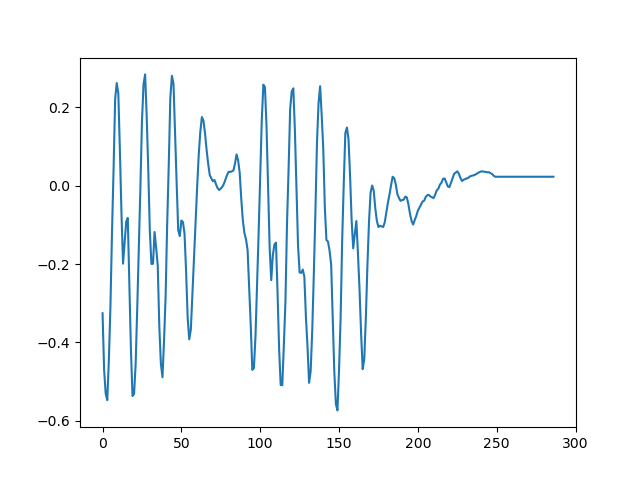

In [22]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# ax.plot(poses[:,:3,3])
# ax.plot(np.diff(poses[:,:3,3], axis = 0))
poses_euls = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
ax.plot(poses_euls[950:,1])

# fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
# ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [41]:
# # idx = 2800 #2700 #2650 #2000 - 3000 is the running and swinging loop
# idx = 2400 #very obvious translation distortion
# # idx = 2020 #static start
# skip = 10 #how many lidar frames between clouds
# # (need to deal with how there are more LIDAR frames than ground truth poses)
# offset = 10 #10 #11  #works best for 05 dataset
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# idx = 990 #slow distortion, very accurate solution
skip = 1 #how many lidar frames between clouds
offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#COLOR SCAN1 POINTS BY ORDER IN CLOUD ~~~~~~~~~~~~~~~~~~~~~~~~~~~
color = 255*np.linspace(0,1,len(scan1_lidarframe))
cname = np.array([255-color//2, color, 255-color]).T.tolist()
# disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
disp.append(Points(pc1, c = cname, r = 3, alpha = 1))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# # DRAW SCANS 1, 2
# disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
# disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

# disp.append(Points(OG_in_hull, c = '#a65852', r = 5)) #red
# disp.append(Points(trans_in_hull, c = '#2c7c94', r = 5)) #blue

# disp.append(Points(pc1[::100,:], c = '#a65852', r = 3)) #red

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run VICET (12-State ICET)

In [43]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 70, niter = 25, draw = True, mnp = 25, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 25, 
#         draw = True, mnp = 25, RM = True, solver = '12_state', 
#         max_buffer = 2.5, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 25, draw = True, mnp = 25, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)


ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.2378  0.0992  0.0869 -0.0123  0.0269  0.0487] 
 [-0.1664  0.3364 -0.5174 -0.0689  0.04    0.0084]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.2462  0.0113  0.3376 -0.0348  0.0076  0.0468] 
 [-0.3548  0.5417 -0.8347 -0.0205  0.095   0.0409]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 residuals (672, 1)

 delta_A
 (12,)
A: 
 [-0.2893  0.0141  0.4262 -0.0417  0.0087  0.0481] 
 [-0.4108  0.5194 -0.9132 -0.013   0.0952  0.0522]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.2944  0.0164  0.4721 -0.0434  0.0124  0.0465] 
 [-0.4228  0.4924 -0.9348 -0.0122  0.0839  0.0569]
~~~~~~~~~~~Iteration 

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [33]:
print(np.rad2deg(0.3))

17.188733853924695


## TODO: remove points from scan1 that lie far outside convex hull of HD Map (so we can calculate proper chamfer distance

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# tested = np.random.rand(1000,3)
# cloud  = np.random.rand(50,3)
# print(in_hull(tested,cloud))

# hull_inflation_scale = 1.05 #tight bounds around HD Map-- good for Quad With Dynamics
hull_inflation_scale = 1.125 #-- need wider bounds for Dynamic Spinning Trajectory 
hull = hull_inflation_scale*submap_in_pc1_frame[::100] #downsample and stretch
pc1_in_hull = pc1[np.where( in_hull(pc1, hull) )]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1, c ='red', r = 3))
disp.append(Points(pc1_in_hull, c = 'blue', r = 3))
# disp.append(Points(hull, c = 'k', alpha = 0.2))
disp.append(Points(submap_in_pc1_frame, c = 'k', r = 1, alpha = 0.2))
plt.show(disp, "Point Cloud 1 inside Convex Hull, Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [ ]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

subsample = 10 #downsample to every nth point

# #consider all LIDAR points (outliers cause chamfer distance to be not super useful)
# source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy()[::subsample,:])[None,:,:] #OG scan
# source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy()[::subsample,:])[None,:,:] #transformed scan

#only consdier LIDAR points within convex hull of HD Map + some buffer
hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:] #subsample
OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()

trans_in_hull = dc.cloud2_tensor.numpy()[::subsample,:] #subsample
trans_in_hull = trans_in_hull[np.where( in_hull(trans_in_hull, hull) )]
source_cloud_trans = torch.from_numpy(trans_in_hull)[None,:,:].float() 

target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]

# #downsample LIDAR clouds -- not sure why this doesn't work
# subsample_size = 10_000
# full_OG = dc.cloud2_tensor_OG.numpy()
# new_OG = full_OG[np.random.choice(full_OG.shape[0], subsample_size, replace=False), :]
# source_cloud_OG = torch.from_numpy(new_OG)[None,:,:] #OG scan
# full_trans = dc.cloud2_tensor.numpy()
# new_trans = full_trans[np.random.choice(full_trans.shape[0], subsample_size, replace=False), :]
# source_cloud_trans = torch.from_numpy(new_trans)[None,:,:] #transformed scan
# target_cloud = torch.from_numpy(submap_in_pc1_frame[::1,:3].astype(np.float32))[None,:,:]

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud, reverse = False)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud, reverse = False)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

# print("\n Normalized OG CD: \n", subsample*dist_forward_OG/len(dc.cloud2_tensor))
# print("\n Normalized transformed CD: \n", subsample*dist_forward_trans/len(dc.cloud2_tensor))

print("\n Normalized OG CD: \n", dist_forward_OG/len(source_cloud_OG))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(source_cloud_trans))

# Generate Transform for 1000 frames of VICET/ ICET in 05

In [14]:
st = time.time()
runlen = 1000
# start_idx = 2400 #2000 #one full loop running around the quad
start_idx = 2020 #static start

A_hist = np.zeros([runlen, 12]) #VICET
# X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    #seed with noisy initial transform to make things fair
#     A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
        fid = 85, niter = 25, draw = False, mnp = 25, RM = True, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A    
    np.save("results/VICET/VICET_05_start_from_static_A_hist_v7", A_hist)

#     #run ICET ------------------------------------------------------------
#     initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
#     it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#     X_hist[idx,:] = it.X
    
# #     np.save("results/ICET/ICET_05_start_from_static_A_hist", X_hist)
    


 
 Frame # 2020 at 0.00023293495178222656 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0469  0.0399 -0.0161 -0.0026  0.0008 -0.0032] 
 [-0.0077 -0.0332  0.0607 -0.0059  0.0005 -0.0017]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0606  0.0636 -0.0075 -0.0037  0.0026 -0.0058] 
 [-0.0044 -0.0262  0.0352 -0.0049 -0.0029 -0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0676  0.0525 -0.0057 -0.0034  0.0034 -0.0082] 
 [ 0.008   0.0068  0.0271 -0.0059 -0.0042  0.002 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0801  0.028  -0.0032 -0.0032  0.004  -0.0098] 
 [ 0.0264  0.0597  0.

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.028  -0.0826 -0.0109 -0.0097 -0.001   0.0107] 
 [ 0.0656  0.338   0.0464  0.0021 -0.0008 -0.0295]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0289 -0.0834 -0.0114 -0.0097 -0.0011  0.0107] 
 [ 0.0674  0.3394  0.0476  0.0022 -0.0007 -0.0296]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0292 -0.0839 -0.012  -0.0097 -0.0012  0.0107] 
 [ 0.0682  0.3405  0.0488  0.0022 -0.0005 -0.0297]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0293 -0.0842 -0.0125 -0.0097 -0.0012  0.0107] 
 [ 0.0686  0.3414  0.0501  0.0023 -0.0004 -0.0298]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.085  -0.0869  0.0347 -0.0083  0.0025 -0.0008] 
 [ 0.1209  0.3241 -0.0442  0.004  -0.0186 -0.0111]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.085  -0.087   0.0347 -0.0083  0.0024 -0.0008] 
 [ 0.1209  0.3242 -0.0441  0.0041 -0.0185 -0.0111]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.085  -0.087   0.0346 -0.0083  0.0024 -0.0008] 
 [ 0.121   0.3243 -0.044   0.0041 -0.0185 -0.0111]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0851 -0.087   0.0346 -0.0083  0.0024 -0.0008] 
 [ 0.121   0.3243 -0.0439  0.0041 -0.0185 -0.0111]

 
 Frame # 2023 at 9.813478946685791 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0265 -0.1117  0.0057 -0.0041 -0.0024  0.0046] 
 [ 0.0599  0.3688  0.0246  0.0137 -0.0016 -0.0152]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.026  -0.1133  0.0058 -0.0041 -0.0024  0.0047] 
 [ 0.0591  0.3723  0.0243  0.0137 -0.0017 -0.0156]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0258 -0.114   0.0059 -0.0041 -0.0024  0.0047] 
 [ 0.0588  0.375   0.0241  0.0138 -0.0017 -0.0157]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.026  -0.1146  0.006  -0.0041 -0.0024  0.0047] 
 [ 0.0593  0.3772  0.0239  0.0138 -0.0017 -0.0157]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0929 -0.0496  0.0406 -0.005   0.0031 -0.0012] 
 [ 0.1206  0.2673 -0.043   0.0091 -0.0074 -0.0075]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0931 -0.0501  0.04   -0.0049  0.003  -0.0013] 
 [ 0.1218  0.2691 -0.0421  0.0091 -0.0073 -0.0075]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0933 -0.0505  0.0397 -0.0049  0.003  -0.0013] 
 [ 0.1228  0.2706 -0.0416  0.0091 -0.0072 -0.0074]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0935 -0.0508  0.0396 -0.0049  0.003  -0.0014] 
 [ 0.1238  0.2719 -0.0413  0.0091 -0.0072 -0.0073]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.0678 -0.0665  0.0297 -0.0013 -0.0022  0.0009] 
 [ 0.0297  0.2317 -0.0051  0.0169  0.0035 -0.0057]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0689 -0.0655  0.0289 -0.0013 -0.0023  0.0007] 
 [ 0.047   0.2432 -0.0032  0.0171  0.0036 -0.006 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0695 -0.0677  0.0283 -0.0013 -0.0024  0.0005] 
 [ 0.0578  0.2574 -0.0013  0.0173  0.0036 -0.0062]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0715 -0.0703  0.0281 -0.0013 -0.0025  0.0003] 
 [ 0.0682  0.2698  0.0003  0.0176  0.0038 -0.0062]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0792 -0.1009  0.0327 -0.0036 -0.0037 -0.0003] 
 [ 0.1214  0.3297 -0.0133  0.0192 -0.0007  0.0007]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0792 -0.101   0.0326 -0.0036 -0.0037 -0.0003] 
 [ 0.1218  0.3305 -0.0132  0.0192 -0.0007  0.0007]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0792 -0.1011  0.0326 -0.0036 -0.0037 -0.0003] 
 [ 0.1222  0.3309 -0.0131  0.0192 -0.0007  0.0007]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0793 -0.1012  0.0325 -0.0036 -0.0037 -0.0003] 
 [ 0.1225  0.3313 -0.0129  0.0192 -0.0007  0.0006]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0101 -0.0721  0.019  -0.0029 -0.0021  0.0015] 
 [-0.0393  0.1819  0.0205  0.0123 -0.0021 -0.0069]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0323 -0.0903  0.0265 -0.0039 -0.0024  0.0017] 
 [-0.0137  0.2564  0.0061  0.0136 -0.0024 -0.0077]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0482 -0.0936  0.0306 -0.0047 -0.0023  0.0018] 
 [ 0.0259  0.2962 -0.0002  0.0149 -0.003  -0.0074]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0566 -0.0918  0.0341 -0.0054 -0.002   0.0015] 
 [ 0.0551  0.3108 -0.0048  0.0158 -0.0038 -0.0059]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0109 -0.0941  0.0067 -0.0034 -0.0042  0.0031] 
 [ 0.0247  0.3329  0.0499  0.0138  0.0039 -0.0066]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0088 -0.0946  0.0056 -0.0034 -0.0043  0.0031] 
 [ 0.022   0.3343  0.0519  0.0138  0.0042 -0.0068]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0068 -0.0949  0.0048 -0.0033 -0.0044  0.0031] 
 [ 0.0192  0.3359  0.0536  0.0138  0.0045 -0.0068]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0053 -0.0948  0.0039 -0.0033 -0.0046  0.0031] 
 [ 0.0173  0.3366  0.0555  0.0139  0.0047 -0.0067]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0371 -0.0793 -0.0005 -0.0039 -0.0064  0.0011] 
 [ 0.034   0.3089  0.0689  0.0144  0.007  -0.0077]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0341 -0.0825 -0.0015 -0.0039 -0.0066  0.0014] 
 [ 0.0318  0.3133  0.071   0.0146  0.0073 -0.0083]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.032  -0.0835 -0.002  -0.0039 -0.0067  0.0015] 
 [ 0.029   0.3166  0.0724  0.0146  0.0075 -0.0085]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0355 -0.0798 -0.0026 -0.0039 -0.0068  0.0012] 
 [ 0.0323  0.3126  0.0738  0.0147  0.0077 -0.0078]

 
 Frame # 2033 at 45.86033916473389 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0564 -0.0999  0.0415 -0.0039  0.0018  0.0045] 
 [ 0.0794  0.3282 -0.0207  0.0128 -0.0014 -0.0137]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0566 -0.1006  0.0411 -0.0039  0.0018  0.0044] 
 [ 0.0809  0.3335 -0.0197  0.0129 -0.0013 -0.0138]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0571 -0.1007  0.0406 -0.0039  0.0017  0.0043] 
 [ 0.0829  0.3361 -0.0186  0.013  -0.0011 -0.0136]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0577 -0.1006  0.0401 -0.0039  0.0016  0.0042] 
 [ 0.0852  0.3371 -0.0174  0.013  -0.001  -0.0135]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0545 -0.1141  0.0496 -0.0054  0.0014  0.0072] 
 [ 0.1045  0.3591 -0.0332  0.0127 -0.0028 -0.0129]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0547 -0.1144  0.0506 -0.0055  0.0015  0.0072] 
 [ 0.1049  0.3594 -0.035   0.0127 -0.003  -0.0129]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0548 -0.1148  0.0513 -0.0056  0.0016  0.0073] 
 [ 0.1052  0.3596 -0.0364  0.0128 -0.0031 -0.0129]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0549 -0.1151  0.052  -0.0056  0.0017  0.0073] 
 [ 0.1054  0.36   -0.0376  0.0128 -0.0033 -0.013 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0971 -0.0332  0.0254  0.0003 -0.0003 -0.0051] 
 [ 0.043   0.1938 -0.0032  0.0069  0.0018  0.008 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1019 -0.0398  0.0266 -0.0001 -0.0005 -0.0057] 
 [ 0.0628  0.213  -0.0031  0.0077  0.0019  0.0098]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1063 -0.0447  0.028  -0.0005 -0.0006 -0.0059] 
 [ 0.0781  0.2184 -0.0029  0.0085  0.002   0.0103]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1087 -0.0469  0.0289 -0.0008 -0.0007 -0.0058] 
 [ 0.088   0.2151 -0.0022  0.0091  0.002   0.0096]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0971 -0.0946  0.0493 -0.0035  0.0021 -0.0008] 
 [ 0.1315  0.3043 -0.0419  0.0116 -0.0051  0.0088]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0962 -0.095   0.0494 -0.0035  0.0021 -0.0008] 
 [ 0.1312  0.3077 -0.0419  0.0117 -0.0051  0.0088]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.096  -0.0951  0.0493 -0.0035  0.002  -0.0008] 
 [ 0.1321  0.31   -0.0417  0.0117 -0.0051  0.009 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0962 -0.0952  0.0492 -0.0035  0.002  -0.0008] 
 [ 0.1335  0.3115 -0.0415  0.0117 -0.005   0.0091]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0743 -0.1223  0.0694 -0.0046  0.0057  0.0018] 
 [ 0.1119  0.3555 -0.0738  0.012  -0.0108  0.0039]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0744 -0.1223  0.0698 -0.0046  0.0058  0.0018] 
 [ 0.112   0.3552 -0.0748  0.0119 -0.0109  0.0039]

 
 Frame # 2040 at 69.14997339248657 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0103 -0.095   0.0468 -0.0021  0.0015  0.003 ] 
 [-0.0335  0.2405 -0.0149  0.0107 -0.0011 -0.0091]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0379 -0.1217  0.058  -0.0025  0.0029  0.0024] 
 [ 0.0012  0.3568 -0.0417  0.01   -0.0039 -0.0052]
~~~~~~~~~

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.1062 -0.0796  0.063  -0.0036  0.004  -0.0025] 
 [ 0.1456  0.2905 -0.0552  0.008  -0.0033  0.0093]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.104  -0.08    0.0627 -0.0036  0.0039 -0.0024] 
 [ 0.1459  0.2941 -0.0544  0.0081 -0.0032  0.0091]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.1025 -0.0801  0.0623 -0.0036  0.0039 -0.0024] 
 [ 0.146   0.2954 -0.0534  0.0082 -0.0031  0.009 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.1017 -0.0801  0.0621 -0.0036  0.0038 -0.0023] 
 [ 0.1461  0.2956 -0.0528  0.0082 -0.003   0.0089]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.047  -0.1109  0.0611 -0.0047  0.0041  0.001 ] 
 [ 0.103   0.3445 -0.0581  0.009  -0.0062  0.0159]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.047  -0.1109  0.0611 -0.0047  0.0041  0.001 ] 
 [ 0.103   0.3445 -0.0581  0.009  -0.0062  0.0159]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.047  -0.1109  0.0611 -0.0047  0.0041  0.001 ] 
 [ 0.103   0.3445 -0.0581  0.009  -0.0062  0.0159]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0471 -0.1109  0.0611 -0.0047  0.0041  0.001 ] 
 [ 0.103   0.3444 -0.0581  0.009  -0.0062  0.0159]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0728 -0.0882  0.0235 -0.003  -0.001   0.0023] 
 [0.1197 0.3065 0.0122 0.0112 0.0014 0.0069]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0657 -0.0903  0.0234 -0.003  -0.001   0.0032] 
 [0.1072 0.3091 0.0121 0.0111 0.0015 0.0045]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0603 -0.0897  0.0231 -0.0029 -0.0011  0.0036] 
 [0.0971 0.3119 0.0123 0.011  0.0015 0.0038]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0574 -0.0874  0.0229 -0.0029 -0.0011  0.0035] 
 [0.0917 0.312  0.0124 0.0109 0.0015 0.004 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (1

LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0428 -0.0958  0.0469 -0.0059  0.0026  0.0026] 
 [ 0.0803  0.3199 -0.0467  0.01   -0.0058  0.0082]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0429 -0.0958  0.047  -0.0059  0.0026  0.0026] 
 [ 0.0804  0.3199 -0.0469  0.01   -0.0059  0.0082]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0429 -0.0959  0.0471 -0.0059  0.0026  0.0026] 
 [ 0.0805  0.3199 -0.0471  0.01   -0.0059  0.0082]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.043  -0.0959  0.0471 -0.0059  0.0026  0.0026] 
 [ 0.0805  0.3199 -0.0473  0.01   -0.0059  0.0082]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0333 -0.0456  0.003  -0.0032 -0.0007  0.0009] 
 [ 0.027   0.2459  0.0338  0.0068  0.0017 -0.0056]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0405 -0.0588  0.0035 -0.0034 -0.0009  0.0009] 
 [ 0.0459  0.2717  0.0338  0.0073  0.002  -0.0059]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0472 -0.0673  0.0042 -0.0036 -0.001   0.001 ] 
 [ 0.0608  0.2886  0.0339  0.0078  0.0021 -0.0062]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0515 -0.0734  0.005  -0.0038 -0.0011  0.0011] 
 [ 0.0712  0.3007  0.0334  0.0081  0.0022 -0.0066]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0785 -0.0798  0.0415 -0.0054  0.002  -0.0014] 
 [ 0.1105  0.3008 -0.0217  0.0078 -0.002   0.0026]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0788 -0.08    0.0424 -0.0054  0.0021 -0.0014] 
 [ 0.1111  0.3009 -0.0236  0.0077 -0.0023  0.0026]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0792 -0.0803  0.0433 -0.0054  0.0023 -0.0014] 
 [ 0.1117  0.3009 -0.0254  0.0077 -0.0025  0.0027]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0795 -0.0805  0.0441 -0.0055  0.0024 -0.0015] 
 [ 0.1121  0.3011 -0.0271  0.0076 -0.0027  0.0027]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0057 -0.1141  0.0546 -0.0052  0.0044  0.0093] 
 [ 0.0278  0.3241 -0.0513  0.0068 -0.0079 -0.0205]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0057 -0.1141  0.0546 -0.0052  0.0044  0.0093] 
 [ 0.0278  0.324  -0.0513  0.0068 -0.0079 -0.0205]

 
 Frame # 2050 at 102.41828680038452 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0244 -0.0547  0.0246 -0.0018 -0.      0.0009] 
 [-0.0169  0.1254  0.0005  0.0043 -0.0007 -0.0088]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0467 -0.0863  0.0339 -0.0024  0.0006  0.001 ] 
 [-0.0035  0.2575 -0.0194  0.0047 -0.0023 -0.0095]
~~~~~~~~

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0397 -0.1091  0.0285 -0.0045 -0.001   0.003 ] 
 [ 0.084   0.358   0.0036  0.0146  0.0022 -0.0123]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0396 -0.1088  0.0289 -0.0045 -0.001   0.003 ] 
 [ 0.0839  0.3565  0.0031  0.0145  0.0021 -0.0123]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0395 -0.1087  0.029  -0.0045 -0.0009  0.003 ] 
 [ 0.0833  0.356   0.0028  0.0145  0.0021 -0.0123]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0394 -0.1088  0.0292 -0.0045 -0.0009  0.003 ] 
 [ 0.0829  0.3561  0.0025  0.0145  0.002  -0.0123]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.1172  0.0461 -0.0031  0.0026  0.0039] 
 [ 0.1001  0.3608 -0.023   0.0123  0.0005 -0.0189]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.1172  0.0461 -0.0031  0.0026  0.0039] 
 [ 0.1001  0.3608 -0.023   0.0123  0.0005 -0.0189]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.1172  0.0461 -0.0031  0.0026  0.0039] 
 [ 0.1001  0.3608 -0.023   0.0123  0.0005 -0.0189]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.1172  0.0461 -0.0031  0.0026  0.0039] 
 [ 0.1001  0.3608 -0.023   0.0123  0.0005 -0.0189]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0429 -0.1157  0.0346 -0.0054 -0.001  -0.0001] 
 [ 0.126   0.3718 -0.0061  0.0076  0.0052  0.0173]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0389 -0.1194  0.0354 -0.0054 -0.0009  0.0003] 
 [ 0.1171  0.3861 -0.0076  0.0077  0.005   0.0168]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.039  -0.1192  0.0363 -0.0055 -0.0009  0.0003] 
 [ 0.1189  0.3901 -0.0092  0.0079  0.0049  0.0171]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0397 -0.1178  0.0369 -0.0056 -0.0008  0.0003] 
 [ 0.1221  0.3879 -0.0103  0.0079  0.0048  0.0173]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0003 -0.0986 -0.0245 -0.0032 -0.0065  0.0072] 
 [ 0.0358  0.3655  0.1124  0.0133  0.0168 -0.0122]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0011 -0.0985 -0.0271 -0.0033 -0.0068  0.0073] 
 [ 0.0349  0.3663  0.1193  0.0139  0.0172 -0.0123]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0018 -0.0981 -0.0276 -0.0032 -0.0071  0.0073] 
 [ 0.0336  0.3671  0.1194  0.0138  0.0179 -0.0124]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0024 -0.098  -0.03   -0.0033 -0.0074  0.0073] 
 [ 0.0332  0.3683  0.1265  0.0146  0.0182 -0.0124]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0087 -0.1511  0.0064 -0.0057 -0.0037  0.0074] 
 [-0.0523  0.4477  0.0244  0.0032 -0.0008 -0.0038]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0324 -0.1311  0.0067 -0.0063 -0.0059  0.0029] 
 [0.0212 0.5104 0.0215 0.0067 0.0034 0.0167]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0626 -0.0812  0.0062 -0.0068 -0.0073 -0.0018] 
 [0.095  0.3981 0.02   0.0086 0.0063 0.029 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0676 -0.0719  0.0084 -0.0075 -0.0079 -0.0021] 
 [0.1213 0.3322 0.0215 0.0097 0.0071 0.0273]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT 

LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0815 -0.0783  0.0417 -0.0071 -0.0018 -0.0091] 
 [ 0.1428  0.3441 -0.0422  0.0197 -0.0109  0.0411]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0812 -0.0785  0.0424 -0.0071 -0.0017 -0.0091] 
 [ 0.1433  0.3448 -0.0437  0.0196 -0.0112  0.0411]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0812 -0.0785  0.043  -0.0071 -0.0016 -0.0091] 
 [ 0.1438  0.3447 -0.045   0.0195 -0.0113  0.0411]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0812 -0.0785  0.0435 -0.0071 -0.0015 -0.0091] 
 [ 0.1441  0.3445 -0.046   0.0195 -0.0115  0.0411]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.097   0.0491 -0.0063 -0.      0.0033] 
 [ 0.0639  0.3599 -0.0646  0.0151 -0.0064 -0.0043]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.0971  0.0491 -0.0063 -0.      0.0033] 
 [ 0.064   0.3602 -0.0646  0.0151 -0.0064 -0.0043]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.0971  0.0491 -0.0063 -0.      0.0033] 
 [ 0.064   0.3604 -0.0646  0.0151 -0.0064 -0.0043]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.0971  0.0491 -0.0063 -0.      0.0033] 
 [ 0.0641  0.3605 -0.0646  0.0151 -0.0064 -0.0042]

 
 Frame # 2060 at 135.9916706085205 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0486 -0.0746  0.0183 -0.0024 -0.0049 -0.0009] 
 [ 0.0351  0.327   0.0281  0.0231  0.016  -0.0191]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0459 -0.0768  0.014  -0.0024 -0.0056 -0.0002] 
 [ 0.0396  0.3335  0.0378  0.024   0.0173 -0.0213]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0425 -0.0781  0.0098 -0.0025 -0.0063  0.0004] 
 [ 0.0411  0.3392  0.0472  0.0248  0.0185 -0.0233]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0385 -0.0793  0.0058 -0.0025 -0.007   0.001 ] 
 [ 0.0408  0.3449  0.056   0.0256  0.0196 -0.025 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0414 -0.087   0.0384 -0.0041 -0.0052 -0.0004] 
 [ 0.0947  0.37    0.0103  0.0222  0.0132 -0.0118]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0414 -0.0868  0.038  -0.0041 -0.0053 -0.0005] 
 [ 0.0944  0.3696  0.0115  0.0223  0.0134 -0.0118]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0413 -0.0867  0.0375 -0.0041 -0.0054 -0.0005] 
 [ 0.0942  0.3695  0.0127  0.0224  0.0135 -0.0118]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0412 -0.0867  0.0371 -0.0041 -0.0055 -0.0005] 
 [ 0.0939  0.3695  0.0137  0.0226  0.0137 -0.0118]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0662 -0.105   0.0672 -0.0106  0.0005 -0.0041] 
 [ 0.1037  0.3866 -0.0726  0.0129 -0.0075  0.0127]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0643 -0.0895  0.0665 -0.0105  0.0005 -0.0038] 
 [ 0.1179  0.3459 -0.0707  0.0125 -0.0074  0.0096]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0603 -0.0845  0.066  -0.0103  0.0004 -0.0037] 
 [ 0.123   0.3279 -0.0696  0.0121 -0.0075  0.0068]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0592 -0.0879  0.0626 -0.01    0.0003 -0.0038] 
 [ 0.1245  0.3357 -0.0638  0.0118 -0.0072  0.005 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0554 -0.0868  0.0008 -0.0121 -0.0058  0.0006] 
 [ 0.1049  0.356   0.0422  0.0148  0.001  -0.0078]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0526 -0.0878  0.0005 -0.0121 -0.0058  0.001 ] 
 [ 0.1047  0.3578  0.0428  0.0149  0.0009 -0.0092]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0489 -0.0886  0.0002 -0.012  -0.0058  0.0014] 
 [ 0.1026  0.359   0.0433  0.0149  0.0009 -0.0103]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0469 -0.0893 -0.0001 -0.012  -0.0058  0.0016] 
 [ 0.1006  0.3602  0.0439  0.0149  0.0008 -0.011 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0434 -0.0628 -0.0056 -0.0119 -0.0063 -0.0074] 
 [ 0.1084  0.3271  0.0158  0.0066 -0.0103  0.0351]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0434 -0.063  -0.0047 -0.0119 -0.0061 -0.0074] 
 [ 0.1089  0.3273  0.0138  0.0065 -0.0106  0.035 ]

 
 Frame # 2067 at 159.49120044708252 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.019  -0.037  -0.0223 -0.0059 -0.0001 -0.0004] 
 [-0.0027  0.1568  0.0414  0.0038 -0.0124 -0.0087]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0291 -0.0559 -0.0183 -0.0071 -0.0011 -0.002 ] 
 [-0.0055  0.2636  0.0363  0.0074 -0.0116 -0.0047]
~~~~~~~~

LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0087 -0.0938  0.     -0.0086 -0.0055  0.001 ] 
 [-0.0029  0.3656  0.014   0.0137 -0.0004 -0.0078]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0092 -0.095   0.0008 -0.0087 -0.0054  0.0011] 
 [-0.0007  0.368   0.0125  0.0137 -0.0006 -0.008 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0096 -0.0959  0.0015 -0.0087 -0.0054  0.0011] 
 [ 0.0013  0.3695  0.0111  0.0137 -0.0008 -0.0081]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0098 -0.0965  0.002  -0.0087 -0.0053  0.0012] 
 [ 0.0028  0.3703  0.0102  0.0137 -0.0009 -0.0083]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.1048 -0.0989  0.0673 -0.0097  0.0042 -0.0061] 
 [ 0.1852  0.3711 -0.1111  0.0107 -0.0193 -0.0039]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.1047 -0.0995  0.0675 -0.0097  0.0042 -0.006 ] 
 [ 0.1865  0.3736 -0.1112  0.0109 -0.0193 -0.0041]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.1047 -0.0998  0.0676 -0.0098  0.0042 -0.006 ] 
 [ 0.1876  0.3757 -0.1112  0.011  -0.0193 -0.0042]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.1046 -0.1002  0.0678 -0.0098  0.0042 -0.006 ] 
 [ 0.1886  0.3774 -0.1113  0.011  -0.0193 -0.0043]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0488 -0.0546  0.0384 -0.0029 -0.     -0.0025] 
 [-0.0064  0.2011 -0.048   0.0096  0.0025 -0.0005]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0512 -0.0576  0.0378 -0.0031 -0.0002 -0.0025] 
 [ 0.0041  0.2165 -0.0466  0.0101  0.0028 -0.0003]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0523 -0.0605  0.0374 -0.0032 -0.0004 -0.0024] 
 [ 0.0131  0.2296 -0.0455  0.0105  0.0031 -0.0006]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0522 -0.0635  0.0372 -0.0033 -0.0006 -0.0021] 
 [ 0.0209  0.2419 -0.0446  0.0109  0.0033 -0.0013]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0411 -0.1031  0.0354 -0.0032 -0.0064  0.0019] 
 [ 0.0919  0.3775 -0.0338  0.0176  0.0031  0.0079]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0407 -0.1032  0.0355 -0.0032 -0.0064  0.002 ] 
 [ 0.0919  0.3781 -0.0339  0.0176  0.0031  0.0078]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0407 -0.1032  0.0354 -0.0032 -0.0064  0.002 ] 
 [ 0.0922  0.3784 -0.0337  0.0177  0.0031  0.0077]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0406 -0.1033  0.0354 -0.0032 -0.0064  0.002 ] 
 [ 0.0924  0.3786 -0.0336  0.0177  0.0031  0.0077]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0538  0.0146  0.0811 -0.0007  0.0021 -0.0002] 
 [-0.0271  0.0333 -0.0604  0.0196  0.0165 -0.0206]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0422 -0.0362  0.0766 -0.0011  0.      0.0023] 
 [-0.0313  0.1891 -0.057   0.021   0.0192 -0.0353]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0269 -0.08    0.0759 -0.0014 -0.0008  0.0045] 
 [-0.0289  0.3078 -0.0591  0.0228  0.0197 -0.0426]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0149 -0.1018  0.0819 -0.0018 -0.0007  0.0058] 
 [-0.0284  0.3621 -0.0718  0.0238  0.0188 -0.0451]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0991 -0.0484  0.0544 -0.0018  0.0036 -0.0143] 
 [ 0.1551  0.2948 -0.0317  0.0074  0.02    0.0389]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0995 -0.0507  0.0537 -0.0018  0.0035 -0.0141] 
 [ 0.1588  0.2987 -0.0299  0.0076  0.0202  0.0382]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0994 -0.0534  0.053  -0.0018  0.0034 -0.0138] 
 [ 0.1618  0.304  -0.0282  0.0079  0.0204  0.0372]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0991 -0.056   0.0524 -0.0018  0.0032 -0.0135] 
 [ 0.1642  0.3097 -0.0268  0.008   0.0206  0.0363]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0405 -0.0511  0.0004  0.0038 -0.0009 -0.0059] 
 [ 0.0505  0.2776  0.0622 -0.0051  0.0228  0.0151]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0397 -0.0516 -0.0012  0.0039 -0.001  -0.0059] 
 [ 0.0509  0.2807  0.0652 -0.0049  0.0231  0.0149]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0391 -0.0519 -0.0027  0.0039 -0.0012 -0.0058] 
 [ 0.0512  0.2835  0.0681 -0.0048  0.0234  0.0148]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0386 -0.0522 -0.0041  0.0039 -0.0013 -0.0058] 
 [ 0.0516  0.286   0.0708 -0.0046  0.0237  0.0147]

 
 Frame # 2077 at 193.1654930114746 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1114 -0.0863  0.0895 -0.0042 -0.0031 -0.013 ] 
 [ 0.1528  0.2815 -0.0965  0.0149 -0.0106  0.0267]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1132 -0.0924  0.0889 -0.0044 -0.0034 -0.0123] 
 [ 0.1662  0.2983 -0.0948  0.0157 -0.0102  0.0248]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1118 -0.0987  0.086  -0.0041 -0.0037 -0.0115] 
 [ 0.1753  0.316  -0.0901  0.0156 -0.0097  0.0224]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1093 -0.1029  0.0834 -0.0041 -0.004  -0.0107] 
 [ 0.1823  0.3294 -0.0852  0.0162 -0.0093  0.0202]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0606 -0.0758  0.0409  0.     -0.0024 -0.0028] 
 [ 0.1179  0.3293 -0.0197  0.0297  0.0002 -0.0113]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0599 -0.0769  0.0417  0.     -0.0024 -0.0026] 
 [ 0.1192  0.332  -0.0213  0.0297  0.     -0.0118]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0594 -0.0777  0.0424 -0.     -0.0023 -0.0025] 
 [ 0.1205  0.3342 -0.0227  0.0296 -0.0002 -0.0122]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0588 -0.0785  0.0431 -0.     -0.0022 -0.0023] 
 [ 0.1215  0.3362 -0.0245  0.0295 -0.0003 -0.0126]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0163 -0.1311  0.0839 -0.0028  0.0062  0.0081] 
 [ 0.0931  0.4488 -0.1022  0.0169  0.0071 -0.0166]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0166 -0.1312  0.0752 -0.0028  0.005   0.0079] 
 [ 0.1094  0.4481 -0.0844  0.0183  0.0091 -0.0185]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0166 -0.1365  0.0696 -0.0028  0.0042  0.0081] 
 [ 0.1176  0.4576 -0.0732  0.019   0.0104 -0.0208]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0165 -0.1412  0.0654 -0.0028  0.0036  0.0084] 
 [ 0.1217  0.4687 -0.0643  0.0197  0.0114 -0.0226]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0034 -0.1309  0.0518 -0.0141  0.0027  0.003 ] 
 [ 0.1738  0.4599 -0.0437  0.0074  0.0154  0.0356]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0038 -0.1302  0.0523 -0.0142  0.0027  0.003 ] 
 [ 0.1725  0.4579 -0.0443  0.0076  0.0154  0.0358]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0043 -0.13    0.0528 -0.0142  0.0027  0.003 ] 
 [ 0.1713  0.457  -0.045   0.0076  0.0154  0.0359]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0047 -0.1298  0.0533 -0.0143  0.0027  0.003 ] 
 [ 0.1702  0.4564 -0.0457  0.0077  0.0154  0.036 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.033  -0.0636 -0.0546 -0.0142  0.0001 -0.0054] 
 [ 0.1924  0.3978  0.1167 -0.0222  0.006   0.0749]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.033  -0.0634 -0.0555 -0.0141  0.0001 -0.0054] 
 [ 0.1921  0.3975  0.1184 -0.0222  0.0061  0.075 ]

 
 Frame # 2084 at 216.8635025024414 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0312 -0.1921  0.0179 -0.0074 -0.0028  0.0141] 
 [-0.0399  0.6877  0.0626 -0.0186 -0.0207  0.0042]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0293 -0.1835 -0.0111 -0.0111  0.0002  0.0213] 
 [ 0.1525  0.7606  0.046  -0.0221 -0.021  -0.0033]
~~~~~~~~~

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0013  0.0534  0.0161 -0.0121  0.0024 -0.0177] 
 [-0.0452  0.1331 -0.0162 -0.0039 -0.0061  0.1266]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0075  0.0467  0.0181 -0.0122  0.0025 -0.0189] 
 [-0.0459  0.1395 -0.0192 -0.0041 -0.006   0.1298]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0139  0.0433  0.0196 -0.0122  0.0025 -0.0197] 
 [-0.0444  0.1427 -0.0213 -0.0042 -0.0058  0.1326]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0185  0.0419  0.021  -0.0122  0.0026 -0.0202] 
 [-0.0412  0.1426 -0.0232 -0.0042 -0.0057  0.1344]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0857 -0.0636  0.0137 -0.0074  0.0066 -0.0099] 
 [ 0.1782  0.4379 -0.0222 -0.0087  0.005  -0.0005]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0857 -0.0641  0.014  -0.0074  0.0066 -0.0099] 
 [ 0.1786  0.4402 -0.0227 -0.0087  0.0049 -0.0006]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0858 -0.0645  0.0143 -0.0074  0.0066 -0.0099] 
 [ 0.1797  0.4414 -0.0235 -0.0087  0.0048 -0.0008]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0857 -0.0644  0.0146 -0.0075  0.0066 -0.0098] 
 [ 0.18    0.442  -0.0241 -0.0087  0.0048 -0.001 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.1207 -0.016   0.0888 -0.0003 -0.0046 -0.0193] 
 [ 0.1224  0.3104 -0.1242  0.0077  0.0102 -0.0001]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.1204 -0.0185  0.0888 -0.0001 -0.0049 -0.0189] 
 [ 0.1294  0.3226 -0.1263  0.0076  0.0102 -0.0023]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.1186 -0.0209  0.0895  0.0001 -0.0051 -0.0184] 
 [ 0.1327  0.3331 -0.1285  0.0076  0.0102 -0.004 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.1167 -0.021   0.0898  0.0002 -0.0052 -0.0181] 
 [ 0.1337  0.3361 -0.13    0.0076  0.0102 -0.0051]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0524 -0.0549  0.1073 -0.0007 -0.0062 -0.0046] 
 [ 0.0996  0.3176 -0.1469  0.0325  0.0074 -0.0468]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0456 -0.0538  0.1042 -0.0004 -0.0063 -0.0038] 
 [ 0.0931  0.3256 -0.1447  0.0324  0.0073 -0.0492]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0415 -0.0551  0.1014 -0.0002 -0.0064 -0.0033] 
 [ 0.0915  0.3351 -0.1422  0.0323  0.0073 -0.0511]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0389 -0.0573  0.0987 -0.0001 -0.0065 -0.0029] 
 [ 0.0915  0.3444 -0.1394  0.0324  0.0074 -0.0529]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.065  -0.0844 -0.0184  0.0141 -0.0023  0.0024] 
 [-0.066   0.363   0.0192  0.0115  0.0052 -0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0811 -0.0712 -0.0939  0.0102 -0.0036  0.0041] 
 [-0.0118  0.4054  0.1132  0.0321  0.0091 -0.004 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0915 -0.0551 -0.1118  0.0081 -0.0066  0.004 ] 
 [ 0.0018  0.3943  0.1454  0.0414  0.0135 -0.0057]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0982 -0.0575 -0.1144  0.0061 -0.0098  0.0039] 
 [ 0.0001  0.4031  0.1619  0.0476  0.0175 -0.0072]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0272 -0.1142  0.1236  0.0023 -0.002   0.0054] 
 [ 0.1684  0.4717 -0.2004  0.0309  0.0008 -0.0608]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.023  -0.1107  0.1161  0.0024 -0.0028  0.0056] 
 [ 0.1636  0.4702 -0.1862  0.0318  0.0021 -0.0615]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0195 -0.1077  0.1092  0.0024 -0.0034  0.0057] 
 [ 0.1592  0.4688 -0.1729  0.0326  0.0033 -0.0619]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0171 -0.1057  0.1038  0.0024 -0.004   0.0058] 
 [ 0.1562  0.4679 -0.1625  0.0333  0.0043 -0.0623]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0839 -0.0983  0.1165  0.002  -0.0075 -0.0018] 
 [ 0.237   0.4171 -0.1542  0.0389  0.0045 -0.0213]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0837 -0.0982  0.1158  0.002  -0.0076 -0.0018] 
 [ 0.2372  0.4179 -0.1529  0.039   0.0046 -0.0214]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0836 -0.098   0.1149  0.002  -0.0076 -0.0018] 
 [ 0.2374  0.4186 -0.1514  0.0392  0.0047 -0.0215]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0836 -0.0978  0.1145  0.002  -0.0077 -0.0018] 
 [ 0.2376  0.4191 -0.1506  0.0392  0.0048 -0.0216]

 
 Frame # 2094 at 251.58375811576843 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.102  -0.1483  0.091   0.013  -0.0124  0.0006] 
 [ 0.2613  0.4742 -0.0648  0.0616  0.0174  0.0018]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.1048 -0.1544  0.0903  0.013  -0.0126  0.0006] 
 [ 0.2666  0.4848 -0.0636  0.0618  0.0177  0.0012]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.1073 -0.1597  0.0908  0.0129 -0.0127  0.0006] 
 [ 0.2712  0.4948 -0.0647  0.0619  0.0177  0.0008]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.1097 -0.164   0.091   0.0129 -0.0127  0.0006] 
 [ 0.2758  0.5023 -0.0655  0.0619  0.0178  0.0005]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0447 -0.1774  0.0421  0.0007 -0.0228  0.0041] 
 [0.2103 0.4918 0.0627 0.0798 0.0288 0.0007]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0447 -0.1829  0.0451  0.0007 -0.0225  0.0045] 
 [ 0.2121  0.4998  0.0556  0.0794  0.0284 -0.0001]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0444 -0.1879  0.0477  0.0008 -0.0223  0.0049] 
 [ 0.2132  0.5069  0.0491  0.0789  0.0279 -0.0007]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0438 -0.1924  0.0501  0.0008 -0.0221  0.0052] 
 [ 0.2139  0.5133  0.0432  0.0785  0.0275 -0.0014]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.5784  0.1063  0.7757  0.0398  0.3267  0.0352] 
 [ 1.5553 -0.0117 -1.7891 -0.3618 -0.6222 -0.0519]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [-0.4583  0.0756  0.7921  0.0385  0.3879  0.0477] 
 [ 1.5923 -0.0179 -1.794  -0.3678 -0.7668 -0.09  ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.5625  0.0754  0.691   0.0286  0.4023  0.0446] 
 [ 1.4951 -0.0654 -1.6069 -0.3599 -0.7985 -0.0918]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.6228  0.0618  0.6905  0.0319  0.4217  0.0462] 
 [ 1.4447 -0.092  -1.5339 -0.377  -0.8454 -0.1043]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0496 -0.07    0.0257 -0.0135 -0.0029 -0.0107] 
 [ 0.2219  0.3482  0.0694  0.006  -0.0042  0.0674]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0485 -0.072   0.0275 -0.0135 -0.0027 -0.0105] 
 [ 0.2205  0.3499  0.0651  0.0058 -0.0045  0.0673]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0473 -0.074   0.029  -0.0135 -0.0026 -0.0103] 
 [ 0.2187  0.352   0.0615  0.0057 -0.0047  0.0672]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0461 -0.0761  0.0304 -0.0135 -0.0024 -0.0101] 
 [ 0.2172  0.3541  0.0583  0.0055 -0.005   0.0671]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.1219 -0.0651 -0.01   -0.0179  0.0001  0.0119] 
 [-0.0033  0.3541  0.078   0.0055 -0.0181  0.003 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.1238 -0.0706 -0.0089 -0.018   0.0002  0.0122] 
 [-0.0047  0.3616  0.0758  0.0055 -0.0182  0.0026]

 
 Frame # 2101 at 276.92305278778076 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [ 0.0731  0.1919 -0.2958 -0.0016 -0.0108 -0.0008] 
 [-0.1873 -0.1243  0.5817  0.0029  0.0075  0.0381]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [ 0.0937  0.231  -0.2925 -0.006  -0.0158  0.0015] 
 [-0.0957 -0.18    0.5885  0.004   0.0052  0.0312]
~~~~~~~~

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0267 -0.1299 -0.0794 -0.027  -0.0051  0.0014] 
 [ 0.0619  0.4474  0.1324  0.0128 -0.0333  0.0193]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.026  -0.1319 -0.0667 -0.0276 -0.0038  0.0015] 
 [ 0.063   0.4493  0.1071  0.0121 -0.0359  0.0193]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0259 -0.1341 -0.0581 -0.028  -0.0027  0.0017] 
 [ 0.0632  0.4511  0.0904  0.0118 -0.038   0.0193]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0258 -0.1362 -0.0515 -0.0282 -0.0018  0.0018] 
 [ 0.0634  0.4531  0.0773  0.0114 -0.0398  0.0193]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0385 -0.1596  0.0131 -0.0233  0.0076 -0.003 ] 
 [ 0.1053  0.4792 -0.0462 -0.0039 -0.0362  0.0057]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0387 -0.16    0.0135 -0.0233  0.0077 -0.003 ] 
 [ 0.1054  0.4795 -0.047  -0.004  -0.0363  0.0057]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0389 -0.1603  0.0139 -0.0233  0.0077 -0.003 ] 
 [ 0.1056  0.4798 -0.0477 -0.004  -0.0364  0.0058]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0391 -0.1605  0.0142 -0.0233  0.0077 -0.003 ] 
 [ 0.1058  0.4799 -0.0482 -0.004  -0.0364  0.0058]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.019   0.0105 -0.2944  0.009  -0.0226 -0.0043] 
 [-0.0216  0.3014  0.4629 -0.0353  0.0543  0.0197]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0172  0.0298 -0.2968  0.0095 -0.0228 -0.0049] 
 [-0.0193  0.2762  0.4655 -0.0359  0.0545  0.0213]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0238  0.0238 -0.3017  0.01   -0.0231 -0.0044] 
 [-0.0262  0.2888  0.4724 -0.0365  0.0553  0.019 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0201  0.038  -0.3049  0.0102 -0.0233 -0.0052] 
 [-0.0232  0.2697  0.4778 -0.0364  0.0556  0.021 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0776 -0.1136 -0.0062 -0.0195 -0.004   0.0048] 
 [-0.0462  0.4509 -0.02   -0.0103 -0.0094  0.0184]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.071  -0.1154  0.0078 -0.0198 -0.0027  0.0042] 
 [-0.0392  0.4496 -0.0451 -0.0115 -0.012   0.02  ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0659 -0.1173  0.0193 -0.0199 -0.0016  0.0036] 
 [-0.0335  0.4495 -0.0659 -0.0125 -0.0143  0.0213]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0616 -0.1191  0.0286 -0.0201 -0.0007  0.0032] 
 [-0.029   0.4501 -0.0827 -0.0133 -0.0161  0.0223]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0263  0.1265  0.022   0.0067  0.0131 -0.011 ] 
 [ 0.0276  0.0883 -0.0383 -0.0018 -0.0106  0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0426  0.1354 -0.0041  0.0103  0.0137 -0.0149] 
 [ 0.0562  0.0921 -0.0677 -0.0085 -0.013   0.0092]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0522  0.1371 -0.0193  0.0098  0.0123 -0.0157] 
 [ 0.072   0.092  -0.0396 -0.0047 -0.0095  0.0091]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0519  0.1422 -0.0302  0.0093  0.0101 -0.0151] 
 [ 0.0808  0.0951 -0.0155 -0.0018 -0.0055  0.0059]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0443 -0.1226  0.1456  0.0056  0.0006 -0.007 ] 
 [ 0.0458  0.451  -0.2566  0.0164  0.0135 -0.0248]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.045  -0.1222  0.1461  0.0056  0.0009 -0.0071] 
 [ 0.046   0.4498 -0.2582  0.0161  0.0132 -0.0244]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0456 -0.1217  0.1468  0.0057  0.001  -0.0072] 
 [ 0.0463  0.4486 -0.2598  0.0158  0.0129 -0.0241]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.046  -0.1215  0.1475  0.0057  0.0012 -0.0073] 
 [ 0.0466  0.448  -0.2613  0.0156  0.0126 -0.0239]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0655 -0.0659  0.1415  0.0107 -0.0028 -0.0067] 
 [ 0.1172  0.3015 -0.2231  0.0333  0.009  -0.0243]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0639 -0.0663  0.1388  0.0107 -0.0031 -0.0065] 
 [ 0.1155  0.3034 -0.2182  0.0336  0.0096 -0.0249]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0622 -0.0668  0.1361  0.0108 -0.0034 -0.0063] 
 [ 0.1137  0.3055 -0.2133  0.0339  0.0102 -0.0254]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0605 -0.0671  0.1333  0.0108 -0.0036 -0.0061] 
 [ 0.1116  0.3075 -0.2083  0.0342  0.0107 -0.0259]

 
 Frame # 2111 at 312.9329855442047 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.1345  0.2909  0.0985 -0.0075 -0.0128 -0.0272] 
 [ 0.0405 -0.3808 -0.0817  0.0432  0.0087  0.0414]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.1357  0.3159  0.0912 -0.0074 -0.0134 -0.0279] 
 [ 0.0417 -0.4115 -0.0674  0.0437  0.0099  0.0415]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.1353  0.3402  0.0831 -0.0073 -0.014  -0.0285] 
 [ 0.04   -0.4384 -0.052   0.0442  0.0108  0.0419]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.133   0.3569  0.076  -0.0071 -0.0145 -0.0291] 
 [ 0.0376 -0.4528 -0.039   0.0444  0.0118  0.042 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0188 -0.1317  0.0443 -0.0007 -0.013   0.0028] 
 [ 0.049   0.4397 -0.0065  0.0423 -0.0037 -0.026 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0191 -0.1317  0.0438 -0.0007 -0.013   0.0029] 
 [ 0.0495  0.4403 -0.0055  0.0424 -0.0036 -0.0263]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0192 -0.1314  0.0433 -0.0007 -0.0131  0.0029] 
 [ 0.0495  0.4405 -0.0045  0.0425 -0.0035 -0.0264]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0192 -0.1313  0.0431 -0.0007 -0.0131  0.0029] 
 [ 0.0496  0.4412 -0.004   0.0425 -0.0035 -0.0265]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0117 -0.1132  0.1122  0.0339  0.024  -0.002 ] 
 [ 0.0243  0.2884 -0.3049 -0.042  -0.0175 -0.0044]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0388 -0.0681  0.2576  0.0413  0.0444 -0.0003] 
 [ 0.0671  0.2302 -0.719  -0.0877 -0.0425 -0.0093]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0564 -0.0793  0.3027  0.0461  0.053   0.0005] 
 [ 0.0933  0.2648 -0.8732 -0.1107 -0.0444 -0.0147]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.0748 -0.1003  0.3508  0.0489  0.0554 -0.0001] 
 [ 0.1122  0.3134 -1.0051 -0.1258 -0.0412 -0.0166]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.064  -0.1541  0.0768  0.0015 -0.0079  0.0104] 
 [ 0.0374  0.4194 -0.0153  0.0398  0.0077 -0.0292]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0617 -0.1533  0.0765  0.0015 -0.0079  0.0102] 
 [ 0.0408  0.42   -0.0142  0.0399  0.0078 -0.0293]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0589 -0.1523  0.0761  0.0014 -0.008   0.01  ] 
 [ 0.0446  0.42   -0.013   0.04    0.0079 -0.0292]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0561 -0.1516  0.0756  0.0014 -0.0081  0.0097] 
 [ 0.0484  0.4204 -0.0114  0.0402  0.008  -0.0292]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0442 -0.1764  0.0815  0.0063 -0.0094  0.0028] 
 [ 0.0934  0.464   0.0077  0.0478 -0.0001  0.0016]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0447 -0.1768  0.0816  0.0063 -0.0093  0.0028] 
 [ 0.0928  0.4645  0.0074  0.0478 -0.0002  0.0015]

 
 Frame # 2118 at 337.72312808036804 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0196 -0.033   0.1123 -0.0008 -0.0105  0.0047] 
 [ 0.0333  0.1694 -0.0475  0.049   0.0113  0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0189 -0.0713  0.0905  0.0021 -0.0094  0.006 ] 
 [ 0.0397  0.2355  0.013   0.0551  0.0033 -0.0043]
~~~~~~~~

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0064 -0.0861  0.0562  0.0035 -0.0047 -0.0067] 
 [0.1162 0.288  0.0482 0.052  0.0173 0.0396]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0093 -0.0887  0.0542  0.0034 -0.0051 -0.0064] 
 [0.1144 0.2927 0.0532 0.0525 0.0177 0.0389]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0119 -0.0905  0.0531  0.0034 -0.0053 -0.0061] 
 [0.1125 0.296  0.0561 0.0527 0.0178 0.0384]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0128 -0.0924  0.0522  0.0033 -0.0054 -0.0061] 
 [0.1121 0.2988 0.0582 0.0528 0.0177 0.0383]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0425 -0.1222  0.0673 -0.0065 -0.0032 -0.001 ] 
 [0.1673 0.3603 0.0247 0.0336 0.0257 0.0214]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0416 -0.1229  0.0666 -0.0064 -0.0033 -0.0009] 
 [0.1665 0.3613 0.026  0.0336 0.0258 0.0212]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0406 -0.1235  0.0659 -0.0064 -0.0033 -0.0008] 
 [0.1659 0.3622 0.0273 0.0336 0.0259 0.021 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0397 -0.1241  0.0652 -0.0064 -0.0033 -0.0007] 
 [0.1651 0.3632 0.0284 0.0336 0.0259 0.0208]

 
 Frame # 2121 at 348.3622817993164 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0778 -0.1188  0.0401 -0.023   0.0021  0.0033] 
 [ 0.025   0.3531  0.0098  0.0078 -0.0322 -0.0098]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0715 -0.12    0.0445 -0.0229  0.0029  0.0031] 
 [ 0.0329  0.3555  0.0008  0.0069 -0.0336 -0.0097]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0667 -0.121   0.0475 -0.0229  0.0035  0.0029] 
 [ 0.0385  0.3573 -0.0052  0.0063 -0.0345 -0.0095]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0631 -0.1216  0.0493 -0.0229  0.0037  0.0027] 
 [ 0.0427  0.3587 -0.0085  0.0061 -0.0349 -0.0093]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0523 -0.133  -0.0195 -0.0238  0.0059  0.0025] 
 [ 0.038   0.3504  0.0956  0.0059 -0.0422 -0.0159]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0512 -0.1323 -0.0176 -0.0239  0.006   0.0025] 
 [ 0.0393  0.3501  0.0913  0.0058 -0.0424 -0.0159]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0506 -0.1318 -0.0156 -0.024   0.0062  0.0024] 
 [ 0.04    0.3505  0.0871  0.0057 -0.0426 -0.016 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0502 -0.1311 -0.0139 -0.024   0.0063  0.0024] 
 [ 0.0405  0.3503  0.0834  0.0056 -0.0428 -0.0161]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0321 -0.0172 -0.1161 -0.0213  0.0085 -0.0061] 
 [ 0.0198  0.227   0.21   -0.0265 -0.0116  0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0164 -0.0204 -0.0841 -0.0226  0.0128 -0.0065] 
 [ 0.0503  0.2353  0.1431 -0.0288 -0.0197  0.0003]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0027 -0.024  -0.0557 -0.0234  0.0161 -0.0069] 
 [ 0.0718  0.2444  0.081  -0.0314 -0.0256 -0.0003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0061 -0.0276 -0.034  -0.0238  0.0186 -0.0072] 
 [ 0.085   0.2538  0.033  -0.0336 -0.0295 -0.0008]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0251 -0.0786 -0.0614 -0.0242  0.0133 -0.0055] 
 [ 0.1244  0.3366  0.0704 -0.0401 -0.0268  0.001 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0251 -0.0778 -0.0626 -0.0241  0.0133 -0.0055] 
 [ 0.1252  0.3373  0.0726 -0.0401 -0.0267  0.0007]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0246 -0.0764 -0.0637 -0.0241  0.0132 -0.0055] 
 [ 0.1254  0.337   0.0747 -0.0401 -0.0266  0.0005]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0243 -0.0752 -0.065  -0.0241  0.0131 -0.0055] 
 [ 0.1257  0.3366  0.0771 -0.04   -0.0264  0.0003]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0166 -0.1148  0.0087 -0.0262  0.0138  0.0003] 
 [ 0.0949  0.4457 -0.1019 -0.0338 -0.0406 -0.009 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0166 -0.1148  0.0087 -0.0262  0.0138  0.0003] 
 [ 0.0949  0.4457 -0.1019 -0.0338 -0.0406 -0.009 ]

 
 Frame # 2128 at 372.4233992099762 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.068   0.0561 -0.0224 -0.0078  0.0035  0.0026] 
 [-0.0523  0.1476 -0.0979 -0.0545 -0.0285 -0.0112]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0863  0.0019 -0.0757 -0.0122  0.0051 -0.0018] 
 [-0.0513  0.2885 -0.0317 -0.0471 -0.0297 -0.0007]
~~~~~~~~~

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0599 -0.0575 -0.0888 -0.0149  0.0002 -0.002 ] 
 [-0.0371  0.3005  0.0663 -0.0026 -0.0137  0.0082]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0607 -0.0571 -0.0893 -0.0148  0.0002 -0.0019] 
 [-0.0379  0.3001  0.0663 -0.0029 -0.0136  0.008 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0613 -0.057  -0.09   -0.0147  0.0002 -0.0019] 
 [-0.0386  0.2999  0.0672 -0.0031 -0.0136  0.008 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.057  -0.0909 -0.0147  0.0002 -0.0019] 
 [-0.0388  0.3001  0.0686 -0.0031 -0.0135  0.0079]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.003  -0.0342  0.015  -0.0099  0.016  -0.0106] 
 [ 0.0547  0.272  -0.1205 -0.0145 -0.0106  0.0164]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0051 -0.0343  0.0172 -0.0099  0.0162 -0.0105] 
 [ 0.052   0.2722 -0.1245 -0.0147 -0.0111  0.0163]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0055 -0.0335  0.0197 -0.0099  0.0165 -0.0105] 
 [ 0.0508  0.2708 -0.1289 -0.0149 -0.0117  0.0166]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0042 -0.0325  0.0222 -0.0099  0.0167 -0.0107] 
 [ 0.0515  0.267  -0.1334 -0.0151 -0.0121  0.0172]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0642 -0.0193 -0.0025  0.0031 -0.0081 -0.0166] 
 [ 0.0519  0.2008 -0.0148  0.0033  0.0235  0.033 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.0446 -0.0262 -0.0007  0.003  -0.0082 -0.0148] 
 [ 0.0416  0.2178 -0.0181  0.0042  0.0226  0.0282]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.0324 -0.0293  0.0005  0.003  -0.0081 -0.0139] 
 [ 0.0317  0.2255 -0.0205  0.0046  0.022   0.026 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.0298 -0.0273  0.0008  0.0031 -0.008  -0.014 ] 
 [ 0.027   0.2206 -0.0211  0.0047  0.0217  0.0267]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [-0.0109 -0.0033 -0.0254  0.0059 -0.0233 -0.0068] 
 [0.008  0.098  0.0653 0.0395 0.0257 0.0097]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0137 -0.006  -0.0257  0.0058 -0.0235 -0.0064] 
 [0.0166 0.1058 0.066  0.0399 0.0259 0.0084]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0163 -0.0082 -0.0262  0.0057 -0.0236 -0.0061] 
 [0.0263 0.113  0.0668 0.0404 0.0261 0.0071]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0194 -0.0106 -0.0272  0.0058 -0.0237 -0.0058] 
 [0.0368 0.1202 0.0674 0.0404 0.026  0.0057]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.043  -0.316  -0.0809  0.0006 -0.0032  0.0014] 
 [-0.0015  0.6468  0.1979  0.0994  0.0099  0.0103]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0627 -0.1147 -0.0234  0.0128 -0.0127 -0.0081] 
 [0.1096 0.2728 0.0584 0.0889 0.0269 0.0421]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0519 -0.056   0.0333  0.0164 -0.0171 -0.0065] 
 [ 0.1265  0.1818 -0.0007  0.0796  0.0309  0.0299]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0011 -0.0725  0.0441  0.0177 -0.0187 -0.0022] 
 [ 0.0905  0.2318 -0.0075  0.0772  0.0304  0.0149]
~~~~~~~~~~~Iteration  4 ~~~

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0402 -0.0711  0.0602  0.0254 -0.0137 -0.0006] 
 [ 0.1284  0.1988 -0.0138  0.059   0.0415  0.0123]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0364 -0.0709  0.0503  0.0255 -0.0149 -0.0005] 
 [0.1248 0.2043 0.0065 0.0603 0.0436 0.0114]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0327 -0.0701  0.0426  0.0255 -0.0159 -0.0003] 
 [0.1217 0.2079 0.0229 0.0617 0.0454 0.0106]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0288 -0.0698  0.0366  0.0254 -0.0168 -0.0001] 
 [0.1183 0.212  0.0364 0.0629 0.0468 0.0096]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 d

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.138   0.0731  0.0181 -0.0254  0.0005] 
 [0.0987 0.3012 0.0497 0.0648 0.0539 0.0243]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0073 -0.1377  0.073   0.0181 -0.0254  0.0005] 
 [0.0988 0.3014 0.0498 0.0648 0.0539 0.0242]

 
 Frame # 2138 at 406.69407844543457 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.092  -0.1595  0.4091 -0.0074  0.0084 -0.0017] 
 [ 0.1711  0.407  -0.6295  0.0441 -0.0388  0.0339]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.1003 -0.1293  0.4219 -0.004   0.0064 -0.0028] 
 [ 0.2395  0.2997 -0.6147  0.0479 -0.0376  0.0366]
~~~~~~~~~~~Iteration

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0472 -0.0914  0.1807 -0.0005 -0.022  -0.0018] 
 [ 0.1712  0.2144 -0.1323  0.0804 -0.0053  0.0272]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.047  -0.0934  0.1742 -0.0003 -0.0224 -0.0017] 
 [ 0.1728  0.2177 -0.1182  0.0808 -0.0048  0.0268]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0462 -0.0955  0.1681 -0.     -0.0228 -0.0016] 
 [ 0.1735  0.2216 -0.1051  0.081  -0.0042  0.0263]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0455 -0.0974  0.1623  0.0002 -0.0232 -0.0015] 
 [ 0.1741  0.2253 -0.0928  0.0813 -0.0038  0.0259]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.5    -0.0886  0.8572  0.078   0.1693 -0.0002] 
 [ 0.239   0.0632 -2.4445 -0.2184 -0.2088  0.0677]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.494  -0.0903  0.8413  0.0772  0.1667 -0.0003] 
 [ 0.2416  0.0688 -2.4026 -0.214  -0.2055  0.0694]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.4908 -0.0902  0.8335  0.0768  0.1644 -0.0003] 
 [ 0.2459  0.065  -2.3815 -0.2109 -0.2017  0.0696]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.4853 -0.0896  0.8306  0.0767  0.1623 -0.0002] 
 [ 0.2485  0.0596 -2.3757 -0.2095 -0.1978  0.0689]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.0618  0.0785 -0.0024 -0.0128 -0.0087] 
 [0.1963 0.138  0.0962 0.0721 0.025  0.0297]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0376 -0.065   0.0657 -0.0027 -0.015  -0.0067] 
 [0.1862 0.1381 0.1237 0.0736 0.0284 0.0238]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0232 -0.0664  0.0563 -0.0027 -0.0165 -0.005 ] 
 [0.1748 0.1384 0.1446 0.0745 0.0304 0.0192]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.017  -0.0642  0.0498 -0.0026 -0.0172 -0.0047] 
 [0.1663 0.1401 0.1599 0.0746 0.0306 0.019 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (1

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0375 -0.0705  0.0838 -0.0033 -0.0057 -0.0053] 
 [0.2229 0.2263 0.0751 0.0412 0.0002 0.0405]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0369 -0.0692  0.0855 -0.0033 -0.0058 -0.0054] 
 [0.2162 0.2228 0.0692 0.0413 0.0008 0.0412]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0377 -0.0675  0.0862 -0.0034 -0.0056 -0.0058] 
 [ 0.2166  0.2161  0.0707  0.0414 -0.0001  0.0424]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0381 -0.0658  0.0865 -0.0034 -0.0054 -0.0057] 
 [ 0.217   0.211   0.0697  0.0414 -0.0006  0.0426]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0171  0.0304  0.0011 -0.0178  0.0003  0.0015] 
 [ 0.1256 -0.0529  0.1326  0.0211 -0.0183  0.0027]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0098  0.0428  0.0238 -0.0189  0.002   0.002 ] 
 [ 0.1412 -0.0886  0.078   0.0206 -0.0212  0.0014]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.0047  0.055   0.0422 -0.0193  0.0034  0.0022] 
 [ 0.1464 -0.1266  0.0325  0.0194 -0.0231  0.0004]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.0013  0.0669  0.055  -0.0194  0.0046  0.0023] 
 [ 0.1496 -0.1646 -0.0002  0.0179 -0.0247 -0.0006]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.0112  0.0002  0.0348 -0.0239  0.0219 -0.0093] 
 [ 0.1044  0.0662  0.0068 -0.0014 -0.0329  0.0422]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.011   0.0014  0.0353 -0.0239  0.0219 -0.0094] 
 [ 0.1039  0.0619  0.0052 -0.0015 -0.033   0.0425]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.0108  0.0025  0.0359 -0.0239  0.022  -0.0094] 
 [ 0.1034  0.0577  0.0035 -0.0015 -0.0332  0.0427]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.0107  0.0035  0.0365 -0.0239  0.0221 -0.0094] 
 [ 0.1029  0.0538  0.0021 -0.0015 -0.0334  0.0429]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0151 -0.1714 -0.1822 -0.024   0.0074 -0.0129] 
 [ 0.1662  0.511   0.4841 -0.0031 -0.0077  0.0541]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0158 -0.1746 -0.1868 -0.024   0.007  -0.0132] 
 [ 0.1678  0.5156  0.4959 -0.0026 -0.0073  0.0546]

 
 Frame # 2148 at 441.449627161026 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1628  0.0006 -0.4348  0.0041 -0.0263 -0.0108] 
 [-0.1187 -0.0065  0.7885 -0.0077  0.0764  0.022 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0468 -0.0916 -0.5051  0.0055 -0.0357 -0.0266] 
 [-0.0909  0.211   0.8749 -0.0229  0.091   0.0593]
~~~~~~~~~~

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0208 -0.0103 -0.3122 -0.0256 -0.0188 -0.0159] 
 [ 0.0017  0.1469  0.6182 -0.0014  0.013   0.0462]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0186 -0.0042 -0.2764 -0.0295 -0.0151 -0.0145] 
 [0.0146 0.1418 0.5528 0.0011 0.0045 0.0438]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0143  0.0012 -0.2378 -0.0329 -0.0109 -0.0131] 
 [ 0.0292  0.138   0.4766  0.002  -0.0044  0.0413]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0103  0.0063 -0.1965 -0.0353 -0.0056 -0.0118] 
 [ 0.0424  0.1348  0.3892 -0.0003 -0.0146  0.0385]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0275 -0.0386 -0.1659 -0.037  -0.0087 -0.0103] 
 [ 0.0041  0.1906  0.3089  0.0071 -0.0265  0.0319]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0294 -0.0415 -0.1667 -0.037  -0.0089 -0.0101] 
 [ 0.0019  0.1962  0.3107  0.0072 -0.0262  0.0308]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0293 -0.0436 -0.1675 -0.037  -0.009  -0.0101] 
 [ 0.0023  0.2002  0.3124  0.0072 -0.0259  0.0305]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0296 -0.0452 -0.1683 -0.037  -0.0092 -0.0101] 
 [ 0.0026  0.2034  0.3146  0.0074 -0.0256  0.0302]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0339 -0.0097 -0.1347 -0.0123  0.0067 -0.0097] 
 [ 0.0484 -0.0059  0.1749 -0.0127 -0.005   0.0019]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0354 -0.0068 -0.1357 -0.0132  0.006  -0.0096] 
 [ 0.0486 -0.0045  0.182  -0.0103 -0.0044  0.0016]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0365 -0.0037 -0.1353 -0.0138  0.0055 -0.0096] 
 [ 0.0474 -0.0029  0.1851 -0.0087 -0.0041  0.0017]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0371 -0.0007 -0.1339 -0.0143  0.0053 -0.0096] 
 [ 0.0459 -0.0012  0.1838 -0.0079 -0.004   0.0018]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0294  0.0753  0.0124 -0.0123  0.0101 -0.0073] 
 [-0.095   0.0414 -0.08   -0.0266  0.0192 -0.0013]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0248  0.0763  0.0204 -0.0124  0.0113 -0.0076] 
 [-0.0892  0.0418 -0.0967 -0.0275  0.017  -0.0005]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0198  0.0784  0.0279 -0.0125  0.0123 -0.0083] 
 [-0.0883  0.043  -0.1116 -0.0283  0.0151  0.0015]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0174  0.0791  0.0346 -0.0127  0.0132 -0.0085] 
 [-0.0855  0.0433 -0.1237 -0.0287  0.013   0.002 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0831 -0.0184 -0.0515  0.0057 -0.0075 -0.0036] 
 [-0.1115 -0.0095  0.0696 -0.0335  0.0273 -0.0041]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0553 -0.0253 -0.0477  0.0036 -0.0094 -0.0083] 
 [-0.1272 -0.0126  0.0538 -0.036   0.0297  0.0024]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0445 -0.0171 -0.0359  0.0008 -0.01   -0.0102] 
 [-0.1408 -0.0077  0.041  -0.0331  0.03    0.0083]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0397 -0.0093 -0.0312 -0.0019 -0.01   -0.0115] 
 [-0.154  -0.0031  0.0409 -0.0282  0.0289  0.013 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0654  0.0886  0.0856  0.0072 -0.0169 -0.0074] 
 [-0.1442 -0.0786 -0.2816 -0.0702  0.0356  0.008 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0668  0.0932  0.0815  0.0074 -0.0173 -0.0075] 
 [-0.1456 -0.0831 -0.2753 -0.0701  0.0367  0.0083]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0664  0.0962  0.0759  0.0075 -0.0177 -0.0076] 
 [-0.146  -0.0855 -0.2655 -0.0696  0.0374  0.0086]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0671  0.0983  0.0711  0.0077 -0.0181 -0.0076] 
 [-0.1467 -0.0865 -0.2572 -0.0694  0.0381  0.0084]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0383  0.0827 -0.0349  0.0024 -0.0119 -0.0079] 
 [-0.021   0.074  -0.0471 -0.0403  0.028   0.0106]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0389  0.0826 -0.0389  0.0023 -0.0121 -0.0079] 
 [-0.0223  0.0742 -0.0393 -0.0396  0.0284  0.0106]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0393  0.0827 -0.0425  0.0022 -0.0124 -0.0079] 
 [-0.0232  0.0744 -0.0323 -0.039   0.0288  0.0106]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0397  0.0827 -0.0462  0.0021 -0.0126 -0.0079] 
 [-0.0239  0.0746 -0.0253 -0.0385  0.0292  0.0106]

 
 Frame # 2158 at 477.6323640346527 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.037   0.0458 -0.0077  0.0081 -0.0135 -0.0042] 
 [-0.0782  0.022  -0.0179 -0.0236  0.0392  0.0209]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0384  0.0518 -0.0097  0.009  -0.0143 -0.0042] 
 [-0.0836  0.0175 -0.0196 -0.0257  0.0413  0.0216]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0392  0.055  -0.0118  0.0101 -0.0151 -0.0043] 
 [-0.0876  0.0161 -0.0213 -0.0278  0.0435  0.0219]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0432  0.0582 -0.0134  0.0111 -0.0159 -0.0041] 
 [-0.094   0.0143 -0.0231 -0.03    0.0454  0.0218]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0021 -0.0922  0.0312  0.0009 -0.0239 -0.0039] 
 [ 0.0171  0.2341 -0.0112  0.0193  0.0243  0.0295]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0052 -0.0955  0.0148  0.0022 -0.0221 -0.0038] 
 [0.0205 0.2379 0.0049 0.0162 0.0225 0.0293]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0026 -0.0935  0.0159  0.0016 -0.0232 -0.0037] 
 [0.0201 0.2372 0.008  0.0181 0.0243 0.0289]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0025 -0.0945  0.0157  0.0012 -0.0242 -0.0037] 
 [0.0196 0.2396 0.0115 0.0194 0.0257 0.0287]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 d

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.0462  0.0011  0.3737 -0.0079 -0.0312 -0.0122] 
 [ 0.0892 -0.0056 -0.4299  0.0996  0.0077  0.0671]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0569  0.0056  0.3659  0.0009 -0.0243 -0.0115] 
 [ 0.1096 -0.0034 -0.4674  0.0754 -0.0013  0.066 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0517  0.0123  0.3261  0.0076 -0.0177 -0.0092] 
 [ 0.1124  0.0013 -0.4517  0.0576 -0.0078  0.0628]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0604  0.0148  0.2928  0.0117 -0.0138 -0.0094] 
 [ 0.1237  0.0025 -0.4289  0.0481 -0.0108  0.0638]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0851 -0.1427  0.5283 -0.0045  0.0187 -0.0027] 
 [ 0.1448  0.2167 -0.8469  0.0547 -0.0522  0.0291]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0834 -0.1425  0.4412 -0.0021  0.0182 -0.0028] 
 [ 0.1339  0.214  -0.7085  0.0533 -0.0448  0.0287]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0817 -0.1404  0.4972 -0.0016  0.0172 -0.0026] 
 [ 0.1395  0.2154 -0.7954  0.052  -0.0473  0.0287]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0844 -0.1675  0.4208  0.0006  0.0163 -0.0034] 
 [ 0.134   0.2617 -0.6756  0.0509 -0.0404  0.0294]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0344 -0.1459  0.2134  0.0133 -0.0036 -0.0025] 
 [ 0.1208  0.2612 -0.2764  0.038   0.0182  0.0261]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0353 -0.1432  0.2117  0.0144 -0.0042 -0.0026] 
 [ 0.1201  0.2626 -0.2855  0.0348  0.0207  0.0265]

 
 Frame # 2165 at 503.0916681289673 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [-0.0567  0.0925  0.2222 -0.017  -0.0352 -0.0113] 
 [ 0.0852 -0.0585 -0.1027  0.0961  0.0459  0.0627]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0204 -0.1329  0.1982 -0.0104 -0.0273 -0.0049] 
 [ 0.0671  0.2451 -0.0961  0.0924  0.0372  0.0334]
~~~~~~~~~

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.043  -0.122   0.1356  0.0051 -0.0195 -0.0032] 
 [ 0.1047  0.1804 -0.0506  0.069   0.0152  0.0186]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0412 -0.1257  0.1299  0.0051 -0.0204 -0.0031] 
 [ 0.1065  0.1846 -0.0384  0.0699  0.0168  0.0177]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0396 -0.1297  0.1238  0.0052 -0.0212 -0.003 ] 
 [ 0.109   0.1892 -0.0251  0.0708  0.0182  0.0167]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0395 -0.1337  0.1186  0.0052 -0.022  -0.003 ] 
 [ 0.1134  0.1939 -0.014   0.0716  0.0196  0.0159]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 2.1297 -0.78    0.1432  0.0086  0.0393  0.3005] 
 [ 0.0456  0.8191 -0.6314 -0.0432 -0.1151 -0.8451]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 2.223  -0.7576  0.176   0.0058  0.0433  0.3125] 
 [ 0.0666  0.7772 -0.723  -0.0496 -0.1245 -0.8759]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 2.2887 -0.73    0.2048  0.002   0.0453  0.3238] 
 [ 0.0613  0.7246 -0.8004 -0.0526 -0.1294 -0.9046]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 2.296  -0.7398  0.2199  0.0039  0.0447  0.3329] 
 [ 0.0683  0.7259 -0.8614 -0.0625 -0.1278 -0.9303]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0668 -0.0274  0.1962  0.0058  0.008  -0.0025] 
 [ 0.1908  0.1351 -0.1617  0.0467  0.0021  0.0423]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0679 -0.0224  0.195   0.006   0.0078 -0.0031] 
 [ 0.1863  0.1233 -0.1581  0.0468  0.0026  0.0438]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0682 -0.0176  0.1923  0.0061  0.0076 -0.0034] 
 [ 0.1823  0.113  -0.1515  0.0471  0.003   0.0449]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0689 -0.0133  0.1909  0.0062  0.0073 -0.0036] 
 [ 0.1795  0.1038 -0.1476  0.0474  0.0036  0.0459]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0182 -0.1243  0.092   0.003  -0.0016  0.0004] 
 [0.1808 0.3485 0.0164 0.0351 0.0205 0.03  ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0182 -0.1252  0.0908  0.003  -0.0017  0.0002] 
 [0.1799 0.3478 0.0187 0.0353 0.0207 0.0304]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0184 -0.1259  0.0898  0.003  -0.0018  0.0001] 
 [0.1793 0.3468 0.0208 0.0355 0.0208 0.0307]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0185 -0.1267  0.0892  0.0029 -0.0019 -0.    ] 
 [0.1788 0.3459 0.022  0.0356 0.0209 0.0311]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0266  0.054   0.0207 -0.0047 -0.0067 -0.0031] 
 [ 0.0871  0.0236  0.1748  0.0356 -0.0047  0.0293]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0241  0.0733  0.0032 -0.0042 -0.0074 -0.0026] 
 [ 0.1214  0.0326  0.1996  0.0431 -0.0062  0.0341]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0104  0.083   0.0146 -0.0046 -0.0079 -0.0016] 
 [ 0.1448  0.0374  0.1642  0.0458 -0.0048  0.0355]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0363  0.0827  0.0381 -0.0052 -0.0081 -0.0008] 
 [ 0.1616  0.0372  0.1212  0.047  -0.0032  0.0345]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0019 -0.3264  0.0336 -0.0092 -0.0088  0.005 ] 
 [ 0.5787  0.6717 -0.0572  0.0381 -0.0011 -0.0533]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0198 -0.3556  0.0316 -0.0081 -0.0083  0.0078] 
 [ 0.5764  0.7333 -0.0642  0.034  -0.001  -0.0637]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0088 -0.3833  0.0238 -0.0072 -0.0084  0.0069] 
 [ 0.6051  0.7828 -0.0618  0.0308  0.0002 -0.0676]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.011  -0.4072  0.0211 -0.0071 -0.0084  0.0075] 
 [ 0.6355  0.8191 -0.0614  0.0294  0.001  -0.0752]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0249 -0.0533  0.0889 -0.0099  0.0152 -0.0023] 
 [ 0.0068  0.2064 -0.0758  0.0425 -0.0304  0.0293]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0227 -0.0504  0.0918 -0.0099  0.0157 -0.0024] 
 [ 0.0053  0.2007 -0.081   0.0423 -0.0315  0.0303]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0214 -0.0474  0.0947 -0.01    0.0162 -0.0025] 
 [ 0.0032  0.1943 -0.0853  0.0424 -0.0324  0.031 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.02   -0.0444  0.0977 -0.0101  0.0166 -0.0025] 
 [ 0.0012  0.1884 -0.0901  0.0423 -0.0335  0.0318]

 
 Frame # 2175 at 539.3538763523102 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.021  -0.0348 -0.0163 -0.0227  0.0017 -0.0126] 
 [ 0.0626  0.1133  0.1011  0.015  -0.0206  0.033 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0227 -0.0389 -0.0096 -0.0228  0.0028 -0.0122] 
 [ 0.058   0.1241  0.0867  0.0141 -0.0227  0.0325]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0247 -0.0425 -0.0039 -0.0229  0.0039 -0.012 ] 
 [ 0.0528  0.1335  0.0747  0.0132 -0.0246  0.0323]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0261 -0.0457  0.0013 -0.0229  0.0049 -0.0118] 
 [ 0.0483  0.1419  0.0635  0.0122 -0.0266  0.0321]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0458 -0.1    -0.0011 -0.032   0.0076 -0.0043] 
 [ 0.0055  0.2011  0.0255  0.0101 -0.0533 -0.0003]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0465 -0.1002 -0.0013 -0.032   0.0075 -0.004 ] 
 [ 0.005   0.2024  0.0262  0.0102 -0.0533 -0.0009]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0458 -0.1002 -0.0017 -0.0319  0.0075 -0.0042] 
 [ 0.0065  0.2027  0.0271  0.0101 -0.0532 -0.0005]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0464 -0.1003 -0.0018 -0.032   0.0075 -0.004 ] 
 [ 0.006   0.2038  0.0274  0.0102 -0.0532 -0.0012]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0251 -0.0396 -0.1022 -0.0284  0.0085 -0.004 ] 
 [ 0.0211  0.1082  0.199   0.0077 -0.0263  0.0044]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0261 -0.0442 -0.1034 -0.029   0.0079 -0.0044] 
 [ 0.0203  0.1167  0.2039  0.0091 -0.0254  0.0046]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0278 -0.0481 -0.1047 -0.0293  0.0076 -0.0048] 
 [ 0.0185  0.1245  0.2074  0.0098 -0.0249  0.0048]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.029  -0.0509 -0.1061 -0.0295  0.0074 -0.0051] 
 [ 0.017   0.1308  0.211   0.0103 -0.0245  0.0048]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.05   -0.1078  0.0161 -0.0285  0.0208 -0.006 ] 
 [ 0.0049  0.2704 -0.0764 -0.0219 -0.037   0.0094]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0505 -0.1096  0.0161 -0.0286  0.0208 -0.0059] 
 [ 0.0049  0.2747 -0.0763 -0.0219 -0.037   0.0091]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.051  -0.1112  0.0163 -0.0286  0.0208 -0.0059] 
 [ 0.0049  0.2787 -0.0767 -0.0219 -0.0369  0.0088]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0515 -0.1127  0.0163 -0.0286  0.0208 -0.0059] 
 [ 0.0048  0.2824 -0.0767 -0.0219 -0.0369  0.0086]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0544 -0.0919 -0.0257 -0.0299  0.0123 -0.0035] 
 [ 0.0215  0.2572  0.0165 -0.024  -0.0296  0.0051]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0545 -0.092  -0.0237 -0.0298  0.0125 -0.0034] 
 [ 0.0216  0.2584  0.0118 -0.0245 -0.0301  0.0049]

 
 Frame # 2182 at 565.1157281398773 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([334   3   3], shape=(3,), dtype=int32)

 residuals (1002, 1)

 delta_A
 (12,)
A: 
 [ 0.0178 -0.0879 -0.151  -0.0108  0.0044 -0.0077] 
 [ 0.0472  0.2306  0.2239 -0.0291 -0.017   0.0109]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0331 -0.0657 -0.1479 -0.0175  0.0011 -0.0096] 
 [ 0.0093  0.2209  0.2259 -0.0208 -0.0151  0.0173]
~~~~~~~~

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0663 -0.1095 -0.0093 -0.0269  0.0022  0.0012] 
 [-0.0098  0.3251 -0.0106 -0.0046 -0.0282  0.001 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0679 -0.1129 -0.0043 -0.0268  0.0028  0.0014] 
 [-0.0133  0.3345 -0.0211 -0.0055 -0.0292  0.0006]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0694 -0.1158 -0.0005 -0.0268  0.0033  0.0016] 
 [-0.016   0.3423 -0.029  -0.0061 -0.03    0.0002]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0704 -0.1182  0.0024 -0.0267  0.0036  0.0018] 
 [-0.0178  0.3489 -0.035  -0.0066 -0.0306 -0.0001]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0147  0.0904 -0.0971 -0.0183 -0.0014 -0.0129] 
 [ 0.0241 -0.0659  0.1336  0.0007 -0.0086  0.0559]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0145  0.0906 -0.0975 -0.0183 -0.0015 -0.0129] 
 [ 0.0239 -0.0659  0.1344  0.0007 -0.0085  0.0559]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0145  0.0908 -0.0979 -0.0183 -0.0015 -0.0129] 
 [ 0.0237 -0.0658  0.1351  0.0008 -0.0084  0.056 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0146  0.0909 -0.0983 -0.0183 -0.0016 -0.0129] 
 [ 0.0234 -0.0657  0.1357  0.0008 -0.0084  0.0561]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0543 -0.0462  0.1147 -0.0135  0.0001 -0.0034] 
 [ 0.0256  0.1432 -0.1585 -0.0145  0.0091 -0.0172]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0515 -0.043   0.113  -0.0133  0.0007 -0.0029] 
 [ 0.0288  0.1449 -0.1592 -0.0151  0.0083 -0.0182]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0499 -0.0407  0.1118 -0.0132  0.001  -0.0027] 
 [ 0.0305  0.1461 -0.1596 -0.0154  0.0078 -0.0187]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0491 -0.0388  0.111  -0.0131  0.0011 -0.0026] 
 [ 0.0312  0.1471 -0.1599 -0.0156  0.0076 -0.0191]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0414  0.0249  0.0488 -0.0033 -0.0037 -0.0074] 
 [ 0.0226  0.0133 -0.0782 -0.0205  0.001  -0.002 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0414  0.0249  0.0485 -0.0033 -0.0038 -0.0074] 
 [ 0.0225  0.0133 -0.0775 -0.0204  0.0011 -0.002 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0414  0.0249  0.0481 -0.0033 -0.0038 -0.0074] 
 [ 0.0224  0.0133 -0.0768 -0.0204  0.0011 -0.002 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0415  0.0249  0.0478 -0.0033 -0.0039 -0.0074] 
 [ 0.0223  0.0133 -0.0762 -0.0204  0.0012 -0.002 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0246 -0.0853 -0.0358  0.0017 -0.005  -0.0054] 
 [ 0.0442  0.1095  0.0588 -0.0007 -0.0091 -0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0086 -0.0746 -0.041   0.0011 -0.0079 -0.0033] 
 [ 0.0425  0.0923  0.0677  0.0011 -0.0071 -0.0119]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0091 -0.049  -0.0485 -0.0001 -0.0099 -0.0028] 
 [ 0.0543  0.0681  0.0891  0.005  -0.0056 -0.0128]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0066 -0.0527 -0.0541 -0.001  -0.0114 -0.0021] 
 [ 0.0622  0.0912  0.1024  0.0083 -0.0036 -0.015 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0001 -0.0125  0.0504  0.003  -0.0035 -0.0027] 
 [ 0.06    0.0219 -0.0502  0.0193 -0.0014  0.0062]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.0141  0.054   0.003  -0.0032 -0.0027] 
 [ 0.0596  0.0272 -0.0569  0.0192 -0.002   0.0059]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0011 -0.0154  0.0578  0.0029 -0.003  -0.0026] 
 [ 0.0591  0.0319 -0.0636  0.0191 -0.0025  0.0058]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.002  -0.0169  0.0614  0.0029 -0.0028 -0.0026] 
 [ 0.0579  0.0365 -0.0704  0.0189 -0.0031  0.0058]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0064 -0.0607  0.1351  0.0152  0.0014 -0.001 ] 
 [ 0.0342  0.157  -0.1929  0.0131  0.0044  0.009 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0062 -0.0606  0.1322  0.0152  0.0011 -0.001 ] 
 [ 0.0341  0.1571 -0.1877  0.0135  0.0051  0.0091]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0059 -0.0604  0.1293  0.0152  0.0008 -0.001 ] 
 [ 0.034   0.1572 -0.1824  0.0138  0.0057  0.0091]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0058 -0.0602  0.1265  0.0152  0.0005 -0.0011] 
 [ 0.0339  0.1573 -0.1773  0.0141  0.0063  0.0091]

 
 Frame # 2192 at 600.1735556125641 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0055 -0.0924  0.1331  0.0154 -0.0239 -0.0016] 
 [ 0.049   0.1546 -0.1304  0.0558  0.019   0.0534]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0067 -0.0918  0.1332  0.0157 -0.0234 -0.0018] 
 [ 0.0505  0.1549 -0.1328  0.0549  0.0184  0.0537]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0076 -0.0914  0.134   0.0158 -0.0231 -0.0019] 
 [ 0.0506  0.1551 -0.1354  0.0544  0.0178  0.0539]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0073 -0.0908  0.1355  0.0159 -0.0229 -0.0016] 
 [ 0.0502  0.1555 -0.1389  0.054   0.0174  0.0533]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.026  -0.0908  0.0667  0.0124 -0.0256 -0.0078] 
 [-0.1234  0.1596 -0.0051  0.0814  0.034   0.089 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0264 -0.0919  0.0667  0.0125 -0.0256 -0.0078] 
 [-0.1232  0.1591 -0.0051  0.0813  0.034   0.0891]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0268 -0.0928  0.0667  0.0125 -0.0256 -0.0079] 
 [-0.1229  0.1586 -0.0051  0.0812  0.034   0.0892]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.027  -0.0936  0.0667  0.0125 -0.0256 -0.0079] 
 [-0.1228  0.1582 -0.0051  0.0812  0.0339  0.0892]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0666  0.0258  0.1616  0.0143  0.0027  0.0051] 
 [ 0.0847  0.0757 -0.1257  0.0649  0.026   0.0259]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.067   0.0257  0.1472  0.0156  0.002   0.0045] 
 [ 0.0965  0.0785 -0.1002  0.0647  0.0279  0.0291]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.07    0.0256  0.1384  0.0161  0.001   0.0034] 
 [ 0.117   0.0809 -0.0839  0.0653  0.03    0.0329]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0637  0.0231  0.1323  0.0161 -0.0002  0.0037] 
 [ 0.1144  0.0801 -0.0724  0.0668  0.0326  0.0327]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0275 -0.0889  0.1477  0.0138  0.0025  0.009 ] 
 [ 0.1258  0.2915 -0.1006  0.0391  0.0249  0.0126]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0267 -0.0885  0.1487  0.0136  0.0018  0.009 ] 
 [ 0.1242  0.2905 -0.1034  0.0399  0.0265  0.0129]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0259 -0.0883  0.1493  0.0134  0.0011  0.009 ] 
 [ 0.1221  0.2892 -0.1048  0.0407  0.0279  0.0132]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0253 -0.0879  0.15    0.0132  0.0005  0.0089] 
 [ 0.1197  0.2872 -0.1059  0.0413  0.0292  0.0136]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0779 -0.144   0.1668  0.0072  0.0027  0.0049] 
 [ 0.9416  0.5489 -0.2685  0.0434  0.009   0.0266]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0832 -0.1504  0.1727  0.0074  0.0035  0.0051] 
 [ 1.0048  0.5775 -0.2928  0.0423  0.0075  0.0278]

 
 Frame # 2199 at 624.9741508960724 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0724 -0.0144  0.0788  0.0067 -0.0085 -0.0006] 
 [ 0.053  -0.0029  0.0479  0.0524  0.0169 -0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0481 -0.0151  0.0903  0.0067 -0.0089 -0.0003] 
 [ 0.0751 -0.0009  0.0489  0.0597  0.0188 -0.0008]
~~~~~~~~~

LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0536 -0.0137  0.1171  0.0022 -0.0036  0.0019] 
 [ 0.256   0.046  -0.0779  0.0637  0.001   0.0012]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0565 -0.0127  0.1197  0.0024 -0.0033  0.0022] 
 [ 0.2731  0.0498 -0.0863  0.0633  0.0002  0.0014]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0588 -0.0119  0.1234  0.0025 -0.003   0.0024] 
 [ 0.2898  0.0538 -0.0983  0.0629 -0.0002  0.0016]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0607 -0.0116  0.1258  0.0026 -0.0027  0.0026] 
 [ 0.3059  0.0587 -0.1058  0.0626 -0.0008  0.0019]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0204 -0.0878  0.1019 -0.0033  0.0008  0.0101] 
 [ 0.2458  0.2369 -0.082   0.0544  0.0158 -0.0101]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.0206 -0.0887  0.1016 -0.0032  0.0008  0.0103] 
 [ 0.2517  0.2404 -0.083   0.0543  0.0157 -0.0102]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.0207 -0.0894  0.1004 -0.0031  0.0007  0.0104] 
 [ 0.2575  0.243  -0.0822  0.0542  0.0159 -0.0103]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.0207 -0.0902  0.0998 -0.003   0.0007  0.0104] 
 [ 0.2628  0.2456 -0.0824  0.0542  0.0159 -0.0104]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0792 -0.0469 -0.1714  0.036   0.0377 -0.0091] 
 [ 0.2315  0.1483  0.2902 -0.0585 -0.0334  0.024 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.079  -0.0485 -0.1892  0.0365  0.0382 -0.0096] 
 [ 0.255   0.1631  0.3247 -0.0576 -0.0369  0.0251]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.083  -0.0492 -0.2003  0.038   0.0395 -0.01  ] 
 [ 0.2806  0.1729  0.3321 -0.0602 -0.0391  0.0257]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0852 -0.0535 -0.2079  0.0388  0.0397 -0.0101] 
 [ 0.303   0.1883  0.3418 -0.0606 -0.0394  0.0255]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [ 0.017  -0.0188  0.0237 -0.0318 -0.0059  0.0057] 
 [ 0.1338  0.159   0.0691  0.037  -0.0229  0.0008]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.0168 -0.0191  0.0299 -0.032  -0.0055  0.0059] 
 [ 0.1369  0.1637  0.0541  0.0367 -0.0236  0.0008]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.0165 -0.0192  0.036  -0.0322 -0.005   0.0061] 
 [ 0.1415  0.1677  0.0399  0.0364 -0.0243  0.0008]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.0163 -0.0191  0.0424 -0.0323 -0.0046  0.0062] 
 [ 0.1448  0.1713  0.0221  0.0358 -0.0246  0.0009]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.019   0.011  -0.0889 -0.0116 -0.0098 -0.    ] 
 [ 0.0192  0.0318  0.1206  0.0039 -0.0155  0.0041]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0208  0.0083 -0.1028 -0.021  -0.0153  0.    ] 
 [ 0.0013  0.0547  0.2     0.0242 -0.022   0.0049]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.0291  0.0051 -0.1051 -0.0269 -0.0169  0.0006] 
 [-0.0034  0.0736  0.245   0.0375 -0.0252  0.0046]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.0315 -0.0005 -0.1106 -0.0296 -0.0169  0.0008] 
 [ 0.0055  0.0947  0.2734  0.0441 -0.0283  0.005 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0134  0.0143  0.0173 -0.0294  0.0157  0.0023] 
 [ 0.0834  0.0555 -0.0783  0.0187 -0.0546  0.0009]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0138  0.0141  0.0168 -0.0294  0.0156  0.0022] 
 [ 0.082   0.0565 -0.0771  0.0187 -0.0544  0.001 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0141  0.0139  0.0162 -0.0294  0.0154  0.0021] 
 [ 0.0811  0.0574 -0.0757  0.0188 -0.0541  0.0011]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0144  0.0138  0.0155 -0.0294  0.0154  0.0021] 
 [ 0.0805  0.0583 -0.0742  0.0189 -0.0539  0.0011]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.1153 -0.101  -0.0888 -0.0302 -0.001  -0.0016] 
 [-0.0916  0.2333  0.1393  0.0085 -0.0079 -0.0086]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.1154 -0.1005 -0.0891 -0.0302 -0.0011 -0.0015] 
 [-0.0936  0.2336  0.1403  0.0084 -0.0077 -0.0089]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.1153 -0.0997 -0.0895 -0.0302 -0.0012 -0.0015] 
 [-0.0948  0.2334  0.1413  0.0085 -0.0076 -0.0092]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.1148 -0.0988 -0.0898 -0.0302 -0.0012 -0.0014] 
 [-0.0955  0.2329  0.1422  0.0085 -0.0074 -0.0095]

 
 Frame # 2209 at 660.8290600776672 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0981 -0.0795 -0.0831 -0.0248 -0.0043 -0.0033] 
 [-0.073   0.2023  0.15    0.0175 -0.0147 -0.0053]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.106  -0.0904 -0.0814 -0.0248 -0.0039 -0.0031] 
 [-0.0796  0.2284  0.144   0.0169 -0.0153 -0.0069]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.1129 -0.102  -0.0806 -0.0248 -0.0036 -0.0028] 
 [-0.086   0.2577  0.1413  0.0165 -0.016  -0.0084]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.1197 -0.1118 -0.0798 -0.0248 -0.0032 -0.0025] 
 [-0.0899  0.283   0.14    0.016  -0.0168 -0.0098]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0983 -0.1565  0.1272  0.0087  0.0519  0.0066] 
 [ 0.069   0.5474 -0.682  -0.1034 -0.0378 -0.0323]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0989 -0.1588  0.1268  0.0084  0.0514  0.007 ] 
 [ 0.0755  0.5613 -0.6802 -0.1024 -0.037  -0.0333]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0992 -0.1608  0.1261  0.0082  0.0512  0.0074] 
 [ 0.0814  0.5745 -0.6762 -0.1017 -0.0372 -0.0343]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0992 -0.1605  0.1278  0.0084  0.0517  0.0078] 
 [ 0.0872  0.5839 -0.684  -0.1026 -0.0376 -0.0351]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.0447 -0.036   0.0088 -0.0183  0.0162 -0.0004] 
 [ 0.1329  0.2191 -0.1047 -0.034  -0.0026  0.0031]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0621 -0.0608  0.007  -0.0188  0.0152 -0.0015] 
 [ 0.1368  0.2794 -0.1002 -0.0321 -0.0012  0.0047]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0797 -0.0796  0.0061 -0.0193  0.0143 -0.0023] 
 [ 0.1339  0.3268 -0.0986 -0.0307  0.0001  0.0057]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0944 -0.096   0.0053 -0.0198  0.0135 -0.0029] 
 [ 0.1314  0.3703 -0.0971 -0.0293  0.0014  0.0067]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [ 0.1782 -0.1476  0.0763 -0.0213 -0.0164 -0.0021] 
 [ 0.0721  0.5596 -0.2434 -0.0221  0.0305  0.0087]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.1818 -0.1475  0.101  -0.0209 -0.0196 -0.0018] 
 [ 0.0748  0.5671 -0.2978 -0.0243  0.0378  0.0078]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.1888 -0.1487  0.1125 -0.0211 -0.0217 -0.0015] 
 [ 0.073   0.5768 -0.3187 -0.0242  0.0416  0.0069]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [ 0.1957 -0.1598  0.0401 -0.0241 -0.0142 -0.0025] 
 [ 0.0605  0.596  -0.1229 -0.0106  0.0178  0.0086]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.111  -0.0615 -0.2177 -0.0169 -0.0368 -0.0001] 
 [0.3522 0.5248 0.2713 0.0116 0.0574 0.001 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.1029 -0.0552 -0.1975 -0.0148 -0.039   0.0004] 
 [ 0.372   0.5223  0.215   0.0055  0.0637 -0.0005]

 
 Frame # 2216 at 685.6354534626007 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0277  0.0985 -0.1439 -0.0034 -0.0108 -0.0081] 
 [ 0.0216 -0.1173  0.1133 -0.0214  0.0093  0.0308]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0278  0.0457 -0.1957 -0.0031 -0.0177 -0.0061] 
 [ 0.1438  0.0336  0.2052 -0.0194  0.0212  0.0307]
~~~~~~~~~~~Iter

LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.045  -0.0491 -0.1064 -0.0079 -0.0053  0.0024] 
 [ 0.3496  0.4386  0.0934  0.0196 -0.0039  0.0174]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0433 -0.0479 -0.0913 -0.0083 -0.0033  0.0028] 
 [ 0.3775  0.4491  0.064   0.0189 -0.0084  0.017 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0394 -0.0525 -0.0772 -0.0085 -0.0013  0.0032] 
 [ 0.4034  0.4709  0.0365  0.0176 -0.0125  0.0164]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0375 -0.0563 -0.0643 -0.0088  0.0004  0.0036] 
 [ 0.4228  0.4891  0.0113  0.0166 -0.0161  0.0158]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0429 -0.0885 -0.0294 -0.002   0.005   0.0059] 
 [ 0.3855  0.5847 -0.059   0.0111  0.0037 -0.0324]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.043  -0.0901 -0.0293 -0.002   0.0049  0.006 ] 
 [ 0.392   0.5934 -0.0607  0.0111  0.0038 -0.0325]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0443 -0.0923 -0.0292 -0.0019  0.0049  0.0064] 
 [ 0.4029  0.6099 -0.0624  0.011   0.0039 -0.0334]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.0436 -0.0954 -0.0295 -0.0019  0.0049  0.0067] 
 [ 0.4138  0.6259 -0.0643  0.011   0.0039 -0.0339]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [ 0.0392 -0.0874 -0.0378 -0.     -0.0121  0.0029] 
 [ 0.2342  0.4383  0.0504  0.0207  0.0154 -0.0184]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [ 0.0432 -0.0906 -0.0449 -0.0001 -0.0132  0.0025] 
 [ 0.2352  0.4574  0.0589  0.0221  0.0177 -0.0185]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [ 0.0458 -0.0912 -0.0523 -0.0001 -0.0144  0.0022] 
 [ 0.2381  0.4683  0.0688  0.0231  0.02   -0.0183]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [ 0.0476 -0.0924 -0.0601 -0.     -0.0156  0.0021] 
 [ 0.2422  0.4779  0.0805  0.0238  0.0224 -0.0185]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.0482 -0.1233  0.0367  0.0087 -0.0176  0.0025] 
 [ 0.3232  0.5883 -0.1404  0.0261  0.0173 -0.0142]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.0482 -0.1234  0.0355  0.0092 -0.0179  0.0024] 
 [ 0.3225  0.5897 -0.1457  0.0245  0.0188 -0.0142]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0484 -0.1238  0.0343  0.0096 -0.0182  0.0024] 
 [ 0.3207  0.5911 -0.1505  0.0231  0.0205 -0.0142]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.049  -0.1245  0.0328  0.0101 -0.0186  0.0023] 
 [ 0.3185  0.5922 -0.1545  0.0216  0.0222 -0.0143]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.0167 -0.0994  0.1274  0.0103  0.0014  0.0029] 
 [ 0.1338  0.1682 -0.1373  0.0537  0.0031 -0.0053]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([224   3   3], shape=(3,), dtype=int32)

 residuals (672, 1)

 delta_A
 (12,)
A: 
 [ 0.0211 -0.1095  0.1317  0.0092  0.0024  0.0034] 
 [ 0.154   0.2448 -0.1771  0.055   0.0036 -0.0007]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0249 -0.1395  0.1452  0.0094  0.003   0.0028] 
 [ 0.2007  0.3489 -0.2196  0.0522  0.0036  0.0037]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.037  -0.1552  0.1504  0.01    0.0026  0.0027] 
 [ 0.2291  0.4154 -0.2462  0.0505  0.0062  0.0067]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0606  0.0721  0.043   0.0123 -0.0173 -0.0018] 
 [ 0.096  -0.1543  0.0343  0.0469  0.0483  0.0061]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [-0.061   0.0672  0.0378  0.0126 -0.0181 -0.0017] 
 [ 0.0945 -0.1434  0.0422  0.047   0.0507  0.0058]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0581  0.0722  0.0422  0.0122 -0.0181 -0.0017] 
 [ 0.0904 -0.1511  0.0365  0.0477  0.0496  0.0056]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [-0.0601  0.0725  0.041   0.0125 -0.019  -0.0018] 
 [ 0.0926 -0.1499  0.0362  0.0473  0.0523  0.0057]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.05    0.008  -0.0698  0.0025 -0.0266  0.0062] 
 [ 0.419   0.1871  0.2762  0.0772  0.0477 -0.0023]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.0499  0.0084 -0.0703  0.0025 -0.0267  0.0064] 
 [ 0.4191  0.1879  0.2771  0.0774  0.0479 -0.0031]

 
 Frame # 2226 at 719.4985632896423 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.0527 -0.0276  0.1649  0.0036 -0.011   0.0036] 
 [ 0.2661  0.0156 -0.1994  0.0406  0.0078 -0.0096]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.0526 -0.0443  0.0992  0.0052 -0.0141  0.0015] 
 [ 0.2587  0.0771 -0.0483  0.0488  0.0075 -0.0037]
~~~~~~~~~

LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [-0.0255 -0.0774  0.0598  0.0049 -0.0109  0.0026] 
 [ 0.3312  0.3848 -0.0099  0.0626  0.0023  0.0301]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [-0.0259 -0.078   0.0587  0.0049 -0.0112  0.0035] 
 [ 0.331   0.3933 -0.0065  0.0631  0.0028  0.029 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [-0.0268 -0.0782  0.0578  0.0049 -0.0114  0.0044] 
 [ 0.3308  0.3993 -0.0042  0.0634  0.0029  0.0277]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [-0.0281 -0.0787  0.0572  0.005  -0.0115  0.0052] 
 [ 0.3306  0.4028 -0.0029  0.0635  0.0031  0.0263]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.0229 -0.1672  0.1327  0.0099  0.0088  0.0037] 
 [ 0.2421  0.4736 -0.2023  0.0449 -0.0159  0.0109]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.0222 -0.1665  0.1334  0.0099  0.0089  0.004 ] 
 [ 0.2422  0.4749 -0.2039  0.0447 -0.016   0.0101]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.0211 -0.1653  0.134   0.01    0.0089  0.0043] 
 [ 0.2422  0.475  -0.2049  0.0445 -0.0161  0.0094]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.0199 -0.1637  0.1347  0.01    0.009   0.0046] 
 [ 0.2422  0.474  -0.2063  0.0444 -0.0162  0.0088]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [ 0.4642 -0.7511  0.0411  0.0145  0.0109  0.0606] 
 [-0.1527  1.4154 -0.1683 -0.014  -0.01   -0.1416]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([187   3   3], shape=(3,), dtype=int32)

 residuals (561, 1)

 delta_A
 (12,)
A: 
 [ 0.4602 -0.7624  0.0387  0.0149  0.0109  0.0589] 
 [-0.1756  1.4276 -0.1535 -0.0131 -0.0095 -0.1341]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.4656 -0.7638  0.0335  0.0149  0.0105  0.0572] 
 [-0.2117  1.42   -0.1385 -0.0116 -0.0088 -0.1269]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.4632 -0.7592  0.025   0.0151  0.0102  0.0542] 
 [-0.252   1.407  -0.1148 -0.0102 -0.0092 -0.1159]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([189   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([176   3   3], shape=(3,), dtype=int32)

 residuals (528, 1)

 delta_A
 (12,)
A: 
 [-0.0437 -0.0159  0.1212  0.0093  0.0057  0.0181] 
 [ 0.1736  0.1541 -0.1005  0.0275 -0.019  -0.0331]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([176   3   3], shape=(3,), dtype=int32)

 residuals (528, 1)

 delta_A
 (12,)
A: 
 [-0.0508 -0.0025  0.1243  0.0096  0.0058  0.0192] 
 [ 0.1718  0.1245 -0.1036  0.0269 -0.019  -0.0353]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([175   3   3], shape=(3,), dtype=int32)

 residuals (525, 1)

 delta_A
 (12,)
A: 
 [-0.0593  0.011   0.1261  0.0098  0.0059  0.02  ] 
 [ 0.1692  0.0932 -0.1031  0.0264 -0.0192 -0.037 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([176   3   3], shape=(3,), dtype=int32)

 residuals (528, 1)

 delta_A
 (12,)
A: 
 [-0.0673  0.0261  0.1302  0.01    0.006   0.0208] 
 [ 0.167   0.0585 -0.1067  0.026  -0.0194 -0.0386]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([176   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 residuals (480, 1)

 delta_A
 (12,)
A: 
 [-0.0518 -0.0063  0.0228  0.0029 -0.0046 -0.0013] 
 [ 0.2164 -0.0634  0.0926  0.0615  0.0102  0.0057]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 residuals (480, 1)

 delta_A
 (12,)
A: 
 [-0.0334 -0.0611  0.0241  0.0027 -0.0057 -0.0021] 
 [0.2214 0.1195 0.0862 0.0685 0.0086 0.0271]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([163   3   3], shape=(3,), dtype=int32)

 residuals (489, 1)

 delta_A
 (12,)
A: 
 [-0.0395 -0.1152  0.0137  0.0025 -0.0055 -0.0077] 
 [0.2216 0.2953 0.104  0.0731 0.0049 0.0567]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([164   3   3], shape=(3,), dtype=int32)

 residuals (492, 1)

 delta_A
 (12,)
A: 
 [-0.0135 -0.1393  0.0028  0.0014 -0.0051 -0.0114] 
 [0.2292 0.3756 0.1331 0.0807 0.0019 0.0786]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT 

LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [-0.0672  0.0449  0.1207  0.017  -0.01    0.053 ] 
 [ 0.1881 -0.2568 -0.1424  0.0044  0.0447 -0.1408]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [-0.0671  0.0629  0.1397  0.0177 -0.0097  0.0594] 
 [ 0.1881 -0.3248 -0.1786  0.0001  0.0461 -0.1609]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([147   3   3], shape=(3,), dtype=int32)

 residuals (441, 1)

 delta_A
 (12,)
A: 
 [-0.0537  0.0885  0.1563  0.0189 -0.0096  0.0706] 
 [ 0.1897 -0.4232 -0.2116 -0.0058  0.0461 -0.1967]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([149   3   3], shape=(3,), dtype=int32)

 residuals (447, 1)

 delta_A
 (12,)
A: 
 [-0.0917  0.1025  0.1738  0.0212 -0.0078  0.0766] 
 [ 0.1845 -0.4723 -0.2587 -0.0173  0.0429 -0.2154]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([147   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([148   3   3], shape=(3,), dtype=int32)

 residuals (444, 1)

 delta_A
 (12,)
A: 
 [-0.0769 -0.032   0.1087  0.      0.0159  0.01  ] 
 [ 0.2863  0.2296 -0.0912  0.0279 -0.0118 -0.0067]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([148   3   3], shape=(3,), dtype=int32)

 residuals (444, 1)

 delta_A
 (12,)
A: 
 [-0.0803 -0.0291  0.1122  0.0002  0.0162  0.0105] 
 [ 0.2975  0.2237 -0.1004  0.0268 -0.0121 -0.0089]

 
 Frame # 2236 at 750.4955725669861 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([140   3   3], shape=(3,), dtype=int32)

 residuals (420, 1)

 delta_A
 (12,)
A: 
 [-0.0278 -0.0052  0.0227 -0.0045 -0.0057  0.0042] 
 [ 0.1934 -0.0675  0.0912  0.0232  0.0062 -0.0194]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([142   3   3], shape=(3,), dtype=int32)

 residuals (426, 1)

 delta_A
 (12,)
A: 
 [-0.026   0.0023  0.0333 -0.0051 -0.0051  0.0059] 
 [ 0.2223 -0.079   0.0657  0.0219 -0.     -0.0235]
~~~~~~~~~

LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [-0.063   0.1185  0.0506 -0.0191 -0.0076 -0.0014] 
 [-0.0133 -0.5326  0.0315  0.0307  0.0338 -0.0621]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [-0.053   0.1161  0.0459 -0.0198 -0.009  -0.0013] 
 [-0.0122 -0.5333  0.0416  0.033   0.0367 -0.0637]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([133   3   3], shape=(3,), dtype=int32)

 residuals (399, 1)

 delta_A
 (12,)
A: 
 [-0.0514  0.1153  0.0361 -0.0203 -0.0107 -0.0021] 
 [-0.0122 -0.5327  0.057   0.0353  0.0402 -0.0631]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [-0.0472  0.113   0.0323 -0.0209 -0.0113 -0.0024] 
 [-0.0117 -0.533   0.0671  0.0371  0.0411 -0.0641]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 resid

LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [-0.1158  0.2145  0.107  -0.0033  0.008   0.025 ] 
 [-0.0759 -0.9715 -0.1544 -0.0404  0.0121 -0.1672]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [-0.115   0.2137  0.1063 -0.0033  0.0079  0.0251] 
 [-0.0759 -0.9728 -0.1537 -0.0406  0.0123 -0.1679]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [-0.1141  0.2129  0.1052 -0.0032  0.0078  0.0252] 
 [-0.076  -0.9745 -0.1523 -0.0407  0.0126 -0.1686]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [-0.1132  0.212   0.1038 -0.0032  0.0077  0.0253] 
 [-0.0761 -0.9758 -0.1502 -0.0407  0.0128 -0.1693]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([144   3   3], shape=(3,), dtype=int32)

 residuals (432, 1)

 delta_A
 (12,)
A: 
 [ 0.0544 -0.0334 -0.0926 -0.0178  0.0152 -0.0086] 
 [-0.0165  0.2244  0.1774  0.0106 -0.0079  0.04  ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([144   3   3], shape=(3,), dtype=int32)

 residuals (432, 1)

 delta_A
 (12,)
A: 
 [ 0.0583 -0.0327 -0.0904 -0.0181  0.0153 -0.0078] 
 [-0.0123  0.2278  0.17    0.0105 -0.0082  0.0381]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([144   3   3], shape=(3,), dtype=int32)

 residuals (432, 1)

 delta_A
 (12,)
A: 
 [ 0.0639 -0.0308 -0.0882 -0.0182  0.0155 -0.0065] 
 [-0.0069  0.2269  0.1627  0.0099 -0.0089  0.0346]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([143   3   3], shape=(3,), dtype=int32)

 residuals (429, 1)

 delta_A
 (12,)
A: 
 [ 0.0681 -0.0286 -0.0858 -0.018   0.0159 -0.005 ] 
 [-0.0025  0.2262  0.1532  0.0086 -0.0097  0.0308]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([143   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([141   3   3], shape=(3,), dtype=int32)

 residuals (423, 1)

 delta_A
 (12,)
A: 
 [ 0.0271  0.1631 -0.0266  0.0011  0.0126  0.0773] 
 [ 0.1356 -0.152  -0.0308 -0.0709 -0.0167 -0.1275]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([140   3   3], shape=(3,), dtype=int32)

 residuals (420, 1)

 delta_A
 (12,)
A: 
 [ 0.0489  0.1767 -0.0168  0.0043  0.014   0.0945] 
 [ 0.1572 -0.1585 -0.0656 -0.0799 -0.0193 -0.1583]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [ 0.0741  0.1952 -0.0014  0.0086  0.0161  0.1147] 
 [ 0.1825 -0.1705 -0.1171 -0.0922 -0.0229 -0.1945]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [0.0496 0.2645 0.0042 0.0144 0.0204 0.1034] 
 [ 0.1451 -0.2611 -0.1562 -0.1072 -0.0293 -0.1701]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([138   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([140   3   3], shape=(3,), dtype=int32)

 residuals (420, 1)

 delta_A
 (12,)
A: 
 [ 0.13    0.0392 -0.0587 -0.0227  0.0347 -0.0039] 
 [-0.2572  0.0776  0.0575  0.0045 -0.1006  0.0225]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([138   3   3], shape=(3,), dtype=int32)

 residuals (414, 1)

 delta_A
 (12,)
A: 
 [ 0.1176  0.0233  0.0112 -0.0286  0.052  -0.0056] 
 [-0.2548  0.1377 -0.0847 -0.0035 -0.1402  0.0306]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [ 0.1157  0.0053  0.0893 -0.0378  0.0712 -0.0041] 
 [-0.2453  0.1923 -0.2135  0.0026 -0.1808  0.0305]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residuals (411, 1)

 delta_A
 (12,)
A: 
 [ 0.1172 -0.0111  0.1452 -0.05    0.0862 -0.0003] 
 [-0.2345  0.2375 -0.297   0.0185 -0.2104  0.0247]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([124   3   3], shape=(3,), dtype=int32)

 residuals (372, 1)

 delta_A
 (12,)
A: 
 [-0.0094  0.0462 -0.0321 -0.0363  0.0193 -0.0188] 
 [ 0.0055  0.0906 -0.072   0.0171 -0.0644  0.051 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 residuals (375, 1)

 delta_A
 (12,)
A: 
 [-0.0089  0.0459 -0.0234 -0.0366  0.0206 -0.0184] 
 [ 0.0062  0.0936 -0.0885  0.0162 -0.0672  0.0495]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 residuals (375, 1)

 delta_A
 (12,)
A: 
 [-0.0083  0.0453 -0.0159 -0.0368  0.0218 -0.0179] 
 [ 0.0071  0.0974 -0.103   0.0155 -0.0696  0.0478]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 residuals (375, 1)

 delta_A
 (12,)
A: 
 [-0.0072  0.0447 -0.009  -0.0371  0.0228 -0.0174] 
 [ 0.0083  0.1011 -0.1163  0.0148 -0.0718  0.046 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([116   3   3], shape=(3,), dtype=int32)

 residuals (348, 1)

 delta_A
 (12,)
A: 
 [-0.0487  0.0157 -0.2319 -0.0169  0.0059 -0.0331] 
 [-0.015   0.1952  0.2566  0.0004 -0.0131  0.1156]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([116   3   3], shape=(3,), dtype=int32)

 residuals (348, 1)

 delta_A
 (12,)
A: 
 [-0.0504  0.0188 -0.232  -0.0175  0.0054 -0.0335] 
 [-0.0166  0.1903  0.2581  0.0018 -0.012   0.1172]

 
 Frame # 2246 at 775.2884266376495 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.0477  0.0244 -0.0918 -0.0254 -0.0002 -0.0042] 
 [-0.0391  0.0295  0.0325 -0.0098 -0.0065  0.0122]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([119   3   3], shape=(3,), dtype=int32)

 residuals (357, 1)

 delta_A
 (12,)
A: 
 [-0.0609  0.038  -0.1181 -0.0303  0.0016 -0.0069] 
 [-0.0501  0.043   0.0731 -0.0051 -0.0084  0.022 ]
~~~~~~~~~

LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [ 0.5791 -0.6578 -0.2072 -0.0127  0.0149  0.1693] 
 [ 0.0592  1.1993  0.1833 -0.0559 -0.0412 -0.3843]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [ 0.6197 -0.7248 -0.2093 -0.0108  0.0174  0.1891] 
 [ 0.0655  1.3017  0.1862 -0.0618 -0.0451 -0.43  ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [ 0.6524 -0.7706 -0.2037 -0.0093  0.0195  0.2101] 
 [ 0.0753  1.3651  0.1776 -0.0678 -0.0482 -0.4778]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [ 0.6613 -0.7714 -0.2007 -0.0078  0.0219  0.2338] 
 [ 0.0812  1.3673  0.1791 -0.0732 -0.052  -0.5258]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([98  3  3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([93  3  3], shape=(3,), dtype=int32)

 residuals (279, 1)

 delta_A
 (12,)
A: 
 [ 0.2824  0.0079 -0.4399 -0.013   0.0269  0.03  ] 
 [ 0.2013 -0.0399  0.5665 -0.039  -0.0644 -0.0892]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([92  3  3], shape=(3,), dtype=int32)

 residuals (276, 1)

 delta_A
 (12,)
A: 
 [ 0.2784  0.0058 -0.4379 -0.013   0.0268  0.0272] 
 [ 0.1984 -0.0404  0.5621 -0.0391 -0.064  -0.0834]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([92  3  3], shape=(3,), dtype=int32)

 residuals (276, 1)

 delta_A
 (12,)
A: 
 [ 0.2733  0.0041 -0.4318 -0.0134  0.0264  0.0244] 
 [ 0.1948 -0.0403  0.5515 -0.0385 -0.0634 -0.0775]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([91  3  3], shape=(3,), dtype=int32)

 residuals (273, 1)

 delta_A
 (12,)
A: 
 [ 0.2699  0.003  -0.428  -0.0137  0.0262  0.0224] 
 [ 0.1924 -0.0402  0.5465 -0.0381 -0.0633 -0.0733]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([91  3  3], shape=(3,), dtype=int32)

 residuals (273, 1)


LUT tf.Tensor([86  3  3], shape=(3,), dtype=int32)

 residuals (258, 1)

 delta_A
 (12,)
A: 
 [-0.0142  0.1077 -0.1947 -0.0276 -0.0034 -0.0217] 
 [-0.0079  0.0809  0.0868  0.0008 -0.0137  0.0609]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([85  3  3], shape=(3,), dtype=int32)

 residuals (255, 1)

 delta_A
 (12,)
A: 
 [-0.0206  0.0999 -0.1827 -0.0276 -0.0036 -0.0281] 
 [-0.0132  0.08    0.0723 -0.0002 -0.0139  0.0733]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([85  3  3], shape=(3,), dtype=int32)

 residuals (255, 1)

 delta_A
 (12,)
A: 
 [-0.0299  0.0933 -0.1705 -0.0272 -0.0037 -0.0342] 
 [-0.0207  0.0806  0.0552 -0.0017 -0.0142  0.0851]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([85  3  3], shape=(3,), dtype=int32)

 residuals (255, 1)

 delta_A
 (12,)
A: 
 [-0.0399  0.0892 -0.1586 -0.0265 -0.0037 -0.0396] 
 [-0.0285  0.0827  0.0371 -0.0038 -0.0146  0.0963]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([86  3  3], shape=(3,), dtype=int32)

 residuals (258, 1)

 de

LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0451  0.2038 -0.2788 -0.0168  0.0019 -0.0026] 
 [ 0.025   0.0256  0.1792 -0.0095  0.0071 -0.0386]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([82  3  3], shape=(3,), dtype=int32)

 residuals (246, 1)

 delta_A
 (12,)
A: 
 [ 0.0451  0.2    -0.2817 -0.0165  0.0011 -0.0011] 
 [ 0.025   0.0228  0.1751 -0.0103  0.0078 -0.0356]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0451  0.2039 -0.2854 -0.0168  0.0009 -0.0025] 
 [ 0.025   0.0258  0.1903 -0.0088  0.009  -0.0388]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([82  3  3], shape=(3,), dtype=int32)

 residuals (246, 1)

 delta_A
 (12,)
A: 
 [ 0.0451  0.1999 -0.2885 -0.0166  0.0001 -0.001 ] 
 [ 0.025   0.0229  0.1863 -0.0095  0.0098 -0.0358]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)


LUT tf.Tensor([82  3  3], shape=(3,), dtype=int32)

 residuals (246, 1)

 delta_A
 (12,)
A: 
 [ 0.0314  0.0745 -0.1287 -0.0137  0.0072  0.0009] 
 [ 0.0167  0.054   0.014  -0.011  -0.0066  0.009 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0293  0.0776 -0.1322 -0.014   0.0077  0.0028] 
 [ 0.0159  0.0555  0.0164 -0.0104 -0.0072  0.0051]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0282  0.0809 -0.1354 -0.0142  0.008   0.0049] 
 [ 0.0154  0.0573  0.0178 -0.01   -0.0077  0.001 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0288  0.0844 -0.1386 -0.0146  0.0083  0.0071] 
 [ 0.0157  0.0593  0.0193 -0.0093 -0.0081 -0.0033]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 de

LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0401  0.0509 -0.139   0.0006  0.0017  0.0024] 
 [ 0.0112  0.0478  0.0623 -0.0242 -0.0111  0.0009]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.041   0.0517 -0.1386  0.0003  0.0017  0.0023] 
 [ 0.0115  0.0488  0.0622 -0.0235 -0.0111  0.0009]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0417  0.0524 -0.1381  0.      0.0016  0.0022] 
 [ 0.0117  0.0496  0.0624 -0.0227 -0.0111  0.0009]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [ 0.0423  0.053  -0.1376 -0.0004  0.0015  0.002 ] 
 [ 0.0119  0.0503  0.0627 -0.0217 -0.0112  0.0009]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)


A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([83  3  3], shape=(3,), dtype=int32)

 residuals (249, 1)

 delta_A
 (12,)
A: 
 [ 0.0594 -0.0305 -0.0861  0.0224  0.0083  0.0012] 
 [ 0.0212 -0.0078  0.0115 -0.0196 -0.0036 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([82  3  3], shape=(3,), dtype=int32)

 residuals (246, 1)

 delta_A
 (12,)
A: 
 [ 0.0116 -0.0249 -0.107   0.0165  0.0037  0.0001] 
 [ 0.0032 -0.0124  0.0589 -0.0038  0.0068  0.0017]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([82  3  3], shape=(3,), dtype=int32)

 residuals (246, 1)

 delta_A
 (12,)
A: 
 [-0.006  -0.021  -0.1282  0.0133  0.0006 -0.0005] 
 [-0.0035 -0.0129  0.0919  0.0047  0.0129  0.0043]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [-0.0112 -0.0173 -0.1422  0.0099 -0.0024 -0.001 ] 
 [-0.0059 -0.0107  0.1202  0.0137  0.0184  0.0067]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~

LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [-0.0354 -0.0305 -0.0075 -0.0056  0.0024 -0.0042] 
 [-0.007   0.0974 -0.0974  0.039   0.0172  0.0208]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [-0.0372 -0.0307 -0.0117 -0.0048  0.002  -0.0042] 
 [-0.0075  0.0977 -0.0955  0.0373  0.0186  0.0208]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([81  3  3], shape=(3,), dtype=int32)

 residuals (243, 1)

 delta_A
 (12,)
A: 
 [-0.0389 -0.0308 -0.0168 -0.0043  0.0013 -0.0041] 
 [-0.008   0.0976 -0.0912  0.0362  0.0205  0.0209]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([80  3  3], shape=(3,), dtype=int32)

 residuals (240, 1)

 delta_A
 (12,)
A: 
 [-0.0414 -0.0336 -0.0224 -0.0034  0.0006 -0.0042] 
 [-0.0087  0.1013 -0.0858  0.0346  0.0222  0.0211]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([80  3  3], shape=(3,), dtype=int32)

 residuals (240, 1)


LUT tf.Tensor([79  3  3], shape=(3,), dtype=int32)

 residuals (237, 1)

 delta_A
 (12,)
A: 
 [-0.1747  0.0448  0.0118  0.0684  0.0321 -0.0189] 
 [-0.0777 -0.0007 -0.2189 -0.095  -0.0426  0.0569]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([79  3  3], shape=(3,), dtype=int32)

 residuals (237, 1)

 delta_A
 (12,)
A: 
 [-0.1772  0.0447  0.0131  0.0683  0.0321 -0.0197] 
 [-0.0788 -0.0011 -0.2207 -0.0947 -0.0425  0.0585]

 
 Frame # 2259 at 806.8962371349335 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([85  3  3], shape=(3,), dtype=int32)

 residuals (255, 1)

 delta_A
 (12,)
A: 
 [ 0.0448 -0.0727 -0.0364  0.0213 -0.0016 -0.0012] 
 [0.0282 0.0423 0.0175 0.0138 0.007  0.006 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([83  3  3], shape=(3,), dtype=int32)

 residuals (249, 1)

 delta_A
 (12,)
A: 
 [ 0.092  -0.0633 -0.0469  0.0196 -0.004  -0.0007] 
 [0.0634 0.0507 0.0547 0.0235 0.0099 0.0099]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~

LUT tf.Tensor([96  3  3], shape=(3,), dtype=int32)

 residuals (288, 1)

 delta_A
 (12,)
A: 
 [ 0.0454  0.0719  0.0001  0.0116 -0.0085 -0.0262] 
 [ 0.0108 -0.0572 -0.016   0.0444  0.0202  0.0814]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([95  3  3], shape=(3,), dtype=int32)

 residuals (285, 1)

 delta_A
 (12,)
A: 
 [ 0.0455  0.0712  0.0086  0.0119 -0.0088 -0.0273] 
 [ 0.0109 -0.0573 -0.032   0.0432  0.0206  0.0831]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([94  3  3], shape=(3,), dtype=int32)

 residuals (282, 1)

 delta_A
 (12,)
A: 
 [ 0.0456  0.0698  0.0102  0.0119 -0.009  -0.0284] 
 [ 0.0109 -0.0581 -0.0337  0.0432  0.0208  0.0845]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([94  3  3], shape=(3,), dtype=int32)

 residuals (282, 1)

 delta_A
 (12,)
A: 
 [ 0.0457  0.0687  0.0118  0.0119 -0.0091 -0.0294] 
 [ 0.011  -0.0588 -0.0354  0.0432  0.0208  0.0861]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([94  3  3], shape=(3,), dtype=int32)

 residuals (282, 1)


A: 
 [ 0.0564  0.0982  0.0145  0.0098 -0.0156 -0.0033] 
 [ 0.035   0.0858 -0.0027  0.0713  0.0281  0.0117]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([102   3   3], shape=(3,), dtype=int32)

 residuals (306, 1)

 delta_A
 (12,)
A: 
 [ 0.0563  0.1003  0.0086  0.0093 -0.0151 -0.003 ] 
 [0.0346 0.0874 0.0057 0.0723 0.0273 0.0105]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [ 0.0565  0.101   0.0041  0.0089 -0.0147 -0.003 ] 
 [0.0347 0.088  0.0136 0.0734 0.0265 0.01  ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [ 0.057   0.102   0.0011  0.0085 -0.0143 -0.0029] 
 [0.035  0.0887 0.0194 0.0742 0.0258 0.0093]

 
 Frame # 2262 at 814.5073292255402 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([117   3   3], shape=(3,), dtype=int32)

 residuals (351, 1)

 delta

LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.022  -0.1011  0.0793  0.0097 -0.0104 -0.0066] 
 [ 0.2143  0.2558 -0.0532  0.0578  0.0435  0.033 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.0199 -0.1     0.0754  0.0097 -0.0104 -0.0062] 
 [ 0.2163  0.2563 -0.0445  0.0583  0.0433  0.0324]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.0189 -0.0988  0.0764  0.0097 -0.0107 -0.0055] 
 [ 0.2175  0.2569 -0.0477  0.0583  0.044   0.0313]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.0184 -0.0982  0.0736  0.0097 -0.0107 -0.0052] 
 [ 0.2181  0.2572 -0.041   0.0587  0.0438  0.0308]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 resid

LUT tf.Tensor([120   3   3], shape=(3,), dtype=int32)

 residuals (360, 1)

 delta_A
 (12,)
A: 
 [-0.0087  0.0548  0.0823  0.0106 -0.0078  0.0473] 
 [ 0.0019  0.0318 -0.0312  0.049   0.0225 -0.0627]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([121   3   3], shape=(3,), dtype=int32)

 residuals (363, 1)

 delta_A
 (12,)
A: 
 [-0.0093  0.0542  0.0824  0.0107 -0.0078  0.0482] 
 [ 0.0014  0.0314 -0.0311  0.0489  0.0224 -0.0646]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([122   3   3], shape=(3,), dtype=int32)

 residuals (366, 1)

 delta_A
 (12,)
A: 
 [-0.0105  0.0536  0.0828  0.0106 -0.0079  0.0491] 
 [ 0.0005  0.031  -0.0316  0.0491  0.0226 -0.0663]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([121   3   3], shape=(3,), dtype=int32)

 residuals (363, 1)

 delta_A
 (12,)
A: 
 [-0.0123  0.0532  0.0832  0.0106 -0.0079  0.0499] 
 [-0.0009  0.0309 -0.032   0.0492  0.0226 -0.0677]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([121   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([138   3   3], shape=(3,), dtype=int32)

 residuals (414, 1)

 delta_A
 (12,)
A: 
 [-0.0329 -0.0594 -0.0051  0.0106 -0.0164 -0.0255] 
 [-0.0303 -0.0333  0.1998  0.0892  0.0255  0.0456]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([142   3   3], shape=(3,), dtype=int32)

 residuals (426, 1)

 delta_A
 (12,)
A: 
 [-0.0172 -0.0734  0.0017  0.0097 -0.0161 -0.0241] 
 [-0.0162 -0.0417  0.1946  0.0922  0.0243  0.0354]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([142   3   3], shape=(3,), dtype=int32)

 residuals (426, 1)

 delta_A
 (12,)
A: 
 [-0.0216 -0.0801  0.0105  0.0092 -0.0146 -0.024 ] 
 [-0.0195 -0.0449  0.1685  0.09    0.0211  0.031 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [-0.0248 -0.0834  0.0212  0.0089 -0.0131 -0.0242] 
 [-0.0219 -0.0463  0.1436  0.0883  0.0186  0.0294]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-0.0224  0.0084  0.097   0.0141 -0.011   0.0471] 
 [ 0.1138  0.1174 -0.0187  0.0656  0.0394 -0.0595]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([155   3   3], shape=(3,), dtype=int32)

 residuals (465, 1)

 delta_A
 (12,)
A: 
 [-0.0247  0.0104  0.0972  0.0142 -0.0114  0.0494] 
 [ 0.1123  0.1183 -0.0163  0.0658  0.04   -0.0637]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([155   3   3], shape=(3,), dtype=int32)

 residuals (465, 1)

 delta_A
 (12,)
A: 
 [-0.0274  0.012   0.0973  0.0145 -0.0118  0.0513] 
 [ 0.1105  0.1191 -0.0141  0.0656  0.0406 -0.0674]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([155   3   3], shape=(3,), dtype=int32)

 residuals (465, 1)

 delta_A
 (12,)
A: 
 [-0.0294  0.0134  0.0981  0.0148 -0.0122  0.0532] 
 [ 0.1091  0.1198 -0.0141  0.0653  0.0412 -0.071 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([155   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([156   3   3], shape=(3,), dtype=int32)

 residuals (468, 1)

 delta_A
 (12,)
A: 
 [-0.0439 -0.0413  0.0715  0.0129  0.0127 -0.0147] 
 [-0.0409  0.0241 -0.0125 -0.0016  0.0015  0.0303]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [-0.0369 -0.0419  0.0775  0.0127  0.0136 -0.0188] 
 [-0.0348  0.0229  0.014  -0.0027  0.0007  0.0411]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([162   3   3], shape=(3,), dtype=int32)

 residuals (486, 1)

 delta_A
 (12,)
A: 
 [-0.0203 -0.0408  0.0604  0.013   0.0134 -0.0233] 
 [-0.0212  0.0225  0.0512 -0.0012  0.0002  0.052 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([158   3   3], shape=(3,), dtype=int32)

 residuals (474, 1)

 delta_A
 (12,)
A: 
 [ 0.0008 -0.0388  0.0397  0.0097  0.012  -0.0287] 
 [-0.0045  0.0226  0.1064  0.0124 -0.0003  0.0651]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([158   3   3], shape=(3,), dtype=int32)

 residuals (474, 1)

 delta_A
 (12,)
A: 
 [ 0.0552 -0.2229  0.0002 -0.0191  0.0058 -0.0599] 
 [0.0372 0.0149 0.0635 0.0443 0.0128 0.0296]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [ 0.0555 -0.2372 -0.0008 -0.0201  0.0064 -0.063 ] 
 [0.0374 0.0163 0.0552 0.0443 0.0138 0.0291]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([161   3   3], shape=(3,), dtype=int32)

 residuals (483, 1)

 delta_A
 (12,)
A: 
 [ 0.0567 -0.2524 -0.0036 -0.0209  0.0074 -0.066 ] 
 [0.0383 0.0305 0.0569 0.0437 0.0129 0.0306]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([162   3   3], shape=(3,), dtype=int32)

 residuals (486, 1)

 delta_A
 (12,)
A: 
 [ 0.0577 -0.2663 -0.0055 -0.0218  0.008  -0.0689] 
 [0.039  0.0406 0.0572 0.0437 0.0125 0.0318]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([162   3   3], shape=(3,), dtype=int32)

 residuals (486, 1)

 delta_A

LUT tf.Tensor([133   3   3], shape=(3,), dtype=int32)

 residuals (399, 1)

 delta_A
 (12,)
A: 
 [ 0.469  -0.4689 -0.3801 -0.0936  0.0368 -0.3602] 
 [ 0.3512 -0.1819  0.3195  0.2128  0.0106  0.5908]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [ 0.4778 -0.5322 -0.4097 -0.1041  0.0369 -0.373 ] 
 [ 0.352  -0.0655  0.3303  0.2349  0.023   0.6158]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([127   3   3], shape=(3,), dtype=int32)

 residuals (381, 1)

 delta_A
 (12,)
A: 
 [ 0.4937 -0.5893 -0.4183 -0.1131  0.0378 -0.3842] 
 [0.3596 0.0273 0.3301 0.2504 0.0318 0.6368]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([127   3   3], shape=(3,), dtype=int32)

 residuals (381, 1)

 delta_A
 (12,)
A: 
 [ 0.5118 -0.6558 -0.4266 -0.1201  0.0396 -0.3966] 
 [0.3686 0.1426 0.3219 0.2621 0.0379 0.6601]

 
 Frame # 2272 at 844.8924272060394 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteratio

LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [-0.0534 -0.0668  0.1024  0.0064  0.0212 -0.0055] 
 [-0.0495  0.0763 -0.1476 -0.0113 -0.      0.0143]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [-0.0573 -0.0682  0.1038  0.0064  0.0216 -0.0062] 
 [-0.053   0.0708 -0.15   -0.0115 -0.0003  0.0149]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [-0.0611 -0.0692  0.1054  0.0062  0.022  -0.0069] 
 [-0.0565  0.0642 -0.1515 -0.0117 -0.0007  0.0155]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [-0.0642 -0.0689  0.1066  0.006   0.0223 -0.0076] 
 [-0.0594  0.0541 -0.152  -0.0115 -0.0012  0.0158]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [ 0.0434  0.0628  0.6705 -0.0606  0.1435  0.0221] 
 [ 0.0159  0.0093 -1.3739 -0.0137 -0.2778  0.0198]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [ 0.0646  0.0835  0.6829 -0.0637  0.1475  0.0238] 
 [ 0.0369 -0.0344 -1.3807 -0.0103 -0.2895  0.0179]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [ 0.072   0.1038  0.7487 -0.0678  0.1498  0.0259] 
 [ 0.0454 -0.0595 -1.5509 -0.0114 -0.2922  0.0179]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [ 0.0889  0.105   0.7454 -0.0668  0.1578  0.0255] 
 [ 0.0589 -0.0572 -1.5551 -0.0179 -0.3109  0.0209]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([166   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [ 0.0272  0.0059 -0.1324 -0.0405 -0.0223  0.002 ] 
 [ 0.0253  0.1022  0.2952  0.048  -0.0069  0.0043]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [ 0.0299 -0.0072 -0.1353 -0.0422 -0.022   0.0011] 
 [ 0.0275  0.1385  0.2996  0.0519 -0.0081  0.0065]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [ 0.0241 -0.0208 -0.1316 -0.0434 -0.0213  0.0002] 
 [ 0.0219  0.1768  0.2912  0.0535 -0.0092  0.0091]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [ 0.0215 -0.0345 -0.1262 -0.0445 -0.0206 -0.0007] 
 [ 0.0194  0.2134  0.287   0.0554 -0.0107  0.0116]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [-0.0113  0.2303 -0.1365 -0.0514  0.0068 -0.0434] 
 [-0.0078 -0.5203  0.243   0.0413 -0.0577  0.0929]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [-0.0113  0.2289 -0.1349 -0.0523  0.0074 -0.0476] 
 [-0.0078 -0.5192  0.2381  0.0437 -0.0587  0.1023]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [-0.0114  0.2234 -0.1358 -0.0534  0.0079 -0.0511] 
 [-0.0079 -0.5043  0.2411  0.0462 -0.0597  0.1109]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([159   3   3], shape=(3,), dtype=int32)

 residuals (477, 1)

 delta_A
 (12,)
A: 
 [-0.0115  0.2162 -0.1359 -0.0541  0.0087 -0.0549] 
 [-0.0079 -0.484   0.2416  0.048  -0.0611  0.1203]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 residuals (480, 1)

 delta_A
 (12,)
A: 
 [ 0.0939 -0.1199 -0.1842 -0.0338  0.0072  0.028 ] 
 [ 0.0258  0.4187  0.2521 -0.0512 -0.0234 -0.0571]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([160   3   3], shape=(3,), dtype=int32)

 residuals (480, 1)

 delta_A
 (12,)
A: 
 [ 0.0943 -0.1259 -0.1843 -0.0337  0.0071  0.0282] 
 [ 0.0249  0.4295  0.2529 -0.0514 -0.0232 -0.0581]

 
 Frame # 2279 at 868.2641580104828 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [ 0.014   0.0493 -0.2072 -0.024   0.008   0.0042] 
 [-0.0293  0.0192  0.2982 -0.0474 -0.032  -0.0024]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([155   3   3], shape=(3,), dtype=int32)

 residuals (465, 1)

 delta_A
 (12,)
A: 
 [ 0.0379  0.0541 -0.1834 -0.0348  0.0071  0.0057] 
 [-0.0152  0.021   0.2255 -0.0322 -0.0245 -0.0046]
~~~~~~~~~

LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [ 0.1281 -0.1058 -0.1175 -0.035   0.0221 -0.0225] 
 [ 0.0137  0.4577  0.0321 -0.0397 -0.0489  0.0654]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([145   3   3], shape=(3,), dtype=int32)

 residuals (435, 1)

 delta_A
 (12,)
A: 
 [ 0.1418 -0.1052 -0.1141 -0.0354  0.0222 -0.027 ] 
 [ 0.0179  0.4811  0.0233 -0.0388 -0.049   0.0795]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([146   3   3], shape=(3,), dtype=int32)

 residuals (438, 1)

 delta_A
 (12,)
A: 
 [ 0.1584 -0.1092 -0.112  -0.0357  0.0221 -0.0317] 
 [ 0.0209  0.5194  0.0121 -0.0377 -0.0479  0.0952]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([147   3   3], shape=(3,), dtype=int32)

 residuals (441, 1)

 delta_A
 (12,)
A: 
 [ 0.2017 -0.122  -0.1146 -0.0354  0.0221 -0.0328] 
 [ 0.0363  0.5727  0.0105 -0.038  -0.0475  0.1029]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([149   3   3], shape=(3,), dtype=int32)

 resid

LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.2302 -0.0346 -0.1396 -0.0374 -0.0011 -0.0459] 
 [-0.4598  0.2885  0.077  -0.0225 -0.008   0.1202]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 residuals (375, 1)

 delta_A
 (12,)
A: 
 [ 0.2274 -0.0342 -0.1409 -0.0376 -0.0012 -0.0478] 
 [-0.4599  0.2887  0.0803 -0.0221 -0.0077  0.1247]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.2239 -0.0337 -0.1411 -0.0376 -0.0014 -0.0498] 
 [-0.4602  0.2889  0.0807 -0.0219 -0.0073  0.1293]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.2181 -0.0327 -0.143  -0.0376 -0.0018 -0.0516] 
 [-0.4611  0.2892  0.0835 -0.0216 -0.0063  0.134 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0487 -0.1601 -0.0436 -0.0183 -0.0142  0.0005] 
 [ 0.0205  0.2699 -0.1079 -0.0317  0.0081 -0.018 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0442 -0.1734 -0.0372 -0.0185 -0.016   0.002 ] 
 [ 0.0223  0.2965 -0.1245 -0.0318  0.0121 -0.0203]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0399 -0.1856 -0.0302 -0.0181 -0.0176  0.0034] 
 [ 0.0243  0.3206 -0.1425 -0.033   0.0159 -0.0226]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([131   3   3], shape=(3,), dtype=int32)

 residuals (393, 1)

 delta_A
 (12,)
A: 
 [-0.0354 -0.1957 -0.0223 -0.017  -0.0191  0.0049] 
 [ 0.0265  0.3413 -0.1627 -0.0361  0.0194 -0.0248]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([132   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([120   3   3], shape=(3,), dtype=int32)

 residuals (360, 1)

 delta_A
 (12,)
A: 
 [-0.1662 -0.1399  0.1415  0.0009 -0.0147 -0.0711] 
 [ 0.1961  0.391  -0.401  -0.072   0.029   0.1323]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([119   3   3], shape=(3,), dtype=int32)

 residuals (357, 1)

 delta_A
 (12,)
A: 
 [-0.1631 -0.141   0.1378  0.0019 -0.0161 -0.0779] 
 [ 0.1983  0.3911 -0.4028 -0.0748  0.0318  0.1443]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([117   3   3], shape=(3,), dtype=int32)

 residuals (351, 1)

 delta_A
 (12,)
A: 
 [-0.1532 -0.1418  0.1515  0.0019 -0.0169 -0.0839] 
 [ 0.2055  0.3906 -0.3953 -0.0733  0.0289  0.1551]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([118   3   3], shape=(3,), dtype=int32)

 residuals (354, 1)

 delta_A
 (12,)
A: 
 [-0.1425 -0.145   0.156   0.0017 -0.0163 -0.0903] 
 [ 0.2133  0.3886 -0.3928 -0.0727  0.0263  0.1653]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([116   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([121   3   3], shape=(3,), dtype=int32)

 residuals (363, 1)

 delta_A
 (12,)
A: 
 [-0.0524  0.1627 -0.099  -0.04   -0.0173 -0.0024] 
 [ 0.1561 -0.2325  0.0714  0.0074  0.0243 -0.0012]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([121   3   3], shape=(3,), dtype=int32)

 residuals (363, 1)

 delta_A
 (12,)
A: 
 [-0.011   0.2383 -0.1232 -0.0517 -0.0282 -0.0006] 
 [ 0.1955 -0.3501  0.1173  0.0295  0.0458 -0.0046]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([120   3   3], shape=(3,), dtype=int32)

 residuals (360, 1)

 delta_A
 (12,)
A: 
 [ 0.0376  0.296  -0.1769 -0.0715 -0.0456  0.0008] 
 [ 0.2436 -0.4449  0.2144  0.068   0.0805 -0.0079]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([122   3   3], shape=(3,), dtype=int32)

 residuals (366, 1)

 delta_A
 (12,)
A: 
 [ 0.0886  0.3261 -0.2692 -0.1008 -0.0706  0.001 ] 
 [ 0.2966 -0.5116  0.3757  0.1237  0.1304 -0.011 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([120   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [-0.0688  0.3393 -1.5693 -0.1441 -0.3016  0.0117] 
 [-0.3724 -1.0587  2.347   0.2982  0.6319 -0.1269]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [-0.0396  0.4136 -1.6805 -0.1517 -0.3218  0.0147] 
 [-0.4671 -1.1545  2.4218  0.3123  0.6828 -0.1442]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [-0.0645  0.503  -1.8209 -0.158  -0.3453  0.0193] 
 [-0.4705 -1.2487  2.4957  0.3251  0.7483 -0.1642]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([101   3   3], shape=(3,), dtype=int32)

 residuals (303, 1)

 delta_A
 (12,)
A: 
 [-0.1182  0.5186 -2.0108 -0.1345 -0.3696  0.0241] 
 [-0.4801 -1.2303  2.6595  0.2938  0.8194 -0.1844]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([106   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([109   3   3], shape=(3,), dtype=int32)

 residuals (327, 1)

 delta_A
 (12,)
A: 
 [-0.0127  0.0716 -0.0696 -0.0065 -0.0047  0.0002] 
 [-0.0648 -0.0872  0.0568 -0.0038  0.0089  0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([108   3   3], shape=(3,), dtype=int32)

 residuals (324, 1)

 delta_A
 (12,)
A: 
 [-0.0389  0.1315 -0.129  -0.0178 -0.0139  0.0033] 
 [-0.0673 -0.167   0.1291  0.0122  0.027  -0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([109   3   3], shape=(3,), dtype=int32)

 residuals (327, 1)

 delta_A
 (12,)
A: 
 [-0.0552  0.1671 -0.1931 -0.0271 -0.0236  0.0076] 
 [-0.0268 -0.2194  0.2075  0.0289  0.0477 -0.0085]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([110   3   3], shape=(3,), dtype=int32)

 residuals (330, 1)

 delta_A
 (12,)
A: 
 [-0.0711  0.1938 -0.2546 -0.0345 -0.0343  0.0115] 
 [-0.0146 -0.2591  0.2913  0.0432  0.0701 -0.0158]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([107   3   3], shape=(3,), dtype=int32)

 residuals (321, 1)

 delta_A
 (12,)
A: 
 [ 0.138  -0.5397 -0.4246  0.1534  0.1363 -0.018 ] 
 [ 0.0122  0.8392  1.0082 -0.2265 -0.2638  0.0136]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([99  3  3], shape=(3,), dtype=int32)

 residuals (297, 1)

 delta_A
 (12,)
A: 
 [ 0.1481 -0.8243 -0.1299  0.1995  0.2003 -0.0292] 
 [-0.0026  1.3201  0.3765 -0.305  -0.3387  0.0208]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([94  3  3], shape=(3,), dtype=int32)

 residuals (282, 1)

 delta_A
 (12,)
A: 
 [ 0.0608 -0.8376 -0.1766  0.2773  0.2463 -0.0307] 
 [-0.036   1.162   0.4012 -0.4451 -0.4031  0.0004]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([88  3  3], shape=(3,), dtype=int32)

 residuals (264, 1)

 delta_A
 (12,)
A: 
 [ 0.1511 -0.9501 -0.3045  0.3106  0.2894 -0.037 ] 
 [ 0.0209  1.2589  0.9027 -0.4286 -0.441   0.0125]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([79  3  3], shape=(3,), dtype=int32)

 residuals (237, 

LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [-0.4348  0.1675 -0.1593  0.3917  0.1774  0.0146] 
 [-0.1967 -0.7817  0.246  -0.6447 -0.2489 -0.1581]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([100   3   3], shape=(3,), dtype=int32)

 residuals (300, 1)

 delta_A
 (12,)
A: 
 [-0.3985  0.0749 -0.1397  0.4177  0.1852  0.0158] 
 [-0.1746 -0.8232  0.2513 -0.6868 -0.2578 -0.1809]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([99  3  3], shape=(3,), dtype=int32)

 residuals (297, 1)

 delta_A
 (12,)
A: 
 [-0.329  -0.0141 -0.119   0.4414  0.1917  0.0164] 
 [-0.1345 -0.8541  0.3137 -0.7224 -0.2653 -0.2032]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([92  3  3], shape=(3,), dtype=int32)

 residuals (276, 1)

 delta_A
 (12,)
A: 
 [-0.2537 -0.1228 -0.1134  0.4707  0.2009  0.0174] 
 [-0.0989 -0.8897  0.4003 -0.7649 -0.2744 -0.2247]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([93  3  3], shape=(3,), dtype=int32)

 residuals (27

LUT tf.Tensor([127   3   3], shape=(3,), dtype=int32)

 residuals (381, 1)

 delta_A
 (12,)
A: 
 [ 0.114   0.261   0.0955  0.0683  0.0356 -0.0112] 
 [ 0.0764 -0.2209 -0.0423 -0.0733 -0.0654  0.0576]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([129   3   3], shape=(3,), dtype=int32)

 residuals (387, 1)

 delta_A
 (12,)
A: 
 [ 0.0944  0.2336  0.0864  0.0687  0.0397 -0.0121] 
 [ 0.0653 -0.1807 -0.0297 -0.0725 -0.0703  0.0585]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([126   3   3], shape=(3,), dtype=int32)

 residuals (378, 1)

 delta_A
 (12,)
A: 
 [ 0.0796  0.1868  0.1147  0.0727  0.0473 -0.013 ] 
 [ 0.0528 -0.1109 -0.0687 -0.0785 -0.0853  0.0591]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([124   3   3], shape=(3,), dtype=int32)

 residuals (372, 1)

 delta_A
 (12,)
A: 
 [ 0.067   0.1377  0.1637  0.0802  0.058  -0.014 ] 
 [ 0.0405 -0.0355 -0.1391 -0.0922 -0.1081  0.0602]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([125   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([129   3   3], shape=(3,), dtype=int32)

 residuals (387, 1)

 delta_A
 (12,)
A: 
 [-0.0758 -0.071   0.6     0.1284  0.0904  0.0468] 
 [ 0.007   0.341  -1.0167 -0.216  -0.1691 -0.069 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0727 -0.0903  0.6309  0.1301  0.0918  0.0493] 
 [ 0.01    0.3757 -1.0722 -0.2214 -0.1713 -0.0751]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0668 -0.1147  0.6182  0.1328  0.0942  0.0516] 
 [ 0.0104  0.4169 -1.0571 -0.2275 -0.1738 -0.0811]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([130   3   3], shape=(3,), dtype=int32)

 residuals (390, 1)

 delta_A
 (12,)
A: 
 [-0.0763 -0.1561  0.6265  0.1416  0.0948  0.0536] 
 [ 0.0049  0.4811 -1.0534 -0.2398 -0.175  -0.087 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([128   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [ 0.0906 -0.2969  0.1543  0.0204 -0.002   0.0014] 
 [ 0.0121  0.6276 -0.1456  0.0603  0.038   0.0148]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([139   3   3], shape=(3,), dtype=int32)

 residuals (417, 1)

 delta_A
 (12,)
A: 
 [ 0.0828 -0.3923  0.1592  0.0168 -0.0046  0.    ] 
 [-0.0045  0.8438 -0.1822  0.067   0.0444  0.0202]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residuals (411, 1)

 delta_A
 (12,)
A: 
 [ 0.074  -0.5082  0.1655  0.0138 -0.0071 -0.0022] 
 [-0.0255  1.0895 -0.2205  0.0728  0.0506  0.0268]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([136   3   3], shape=(3,), dtype=int32)

 residuals (408, 1)

 delta_A
 (12,)
A: 
 [ 0.0606 -0.6429  0.1691  0.0113 -0.0093 -0.0056] 
 [-0.0486  1.3638 -0.2583  0.0777  0.0566  0.0353]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([135   3   3], shape=(3,), dtype=int32)

 residuals (405, 1)

 delta_A
 (12,)
A: 
 [ 0.2466  0.0415  0.1505  0.0007 -0.0026 -0.1074] 
 [-0.4943  0.1428 -0.1232  0.0596  0.0383  0.2559]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [ 0.2134 -0.0147  0.1552 -0.0003 -0.0045 -0.0994] 
 [-0.5133  0.1142 -0.1244  0.0632  0.0412  0.2225]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([133   3   3], shape=(3,), dtype=int32)

 residuals (399, 1)

 delta_A
 (12,)
A: 
 [ 0.2049 -0.0479  0.1654 -0.0005 -0.0077 -0.093 ] 
 [-0.5196  0.0976 -0.1385  0.0659  0.0452  0.1993]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([132   3   3], shape=(3,), dtype=int32)

 residuals (396, 1)

 delta_A
 (12,)
A: 
 [ 0.2193 -0.0507  0.1794  0.0009 -0.011  -0.0902] 
 [-0.5122  0.0975 -0.1565  0.0647  0.0491  0.192 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([133   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([164   3   3], shape=(3,), dtype=int32)

 residuals (492, 1)

 delta_A
 (12,)
A: 
 [ 0.1296  0.1584  0.1258  0.0127 -0.0194  0.009 ] 
 [ 0.106  -0.2516 -0.0103  0.0648  0.0434 -0.0117]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([164   3   3], shape=(3,), dtype=int32)

 residuals (492, 1)

 delta_A
 (12,)
A: 
 [ 0.1293  0.1578  0.1258  0.0127 -0.0194  0.009 ] 
 [ 0.1057 -0.251  -0.0102  0.0648  0.0434 -0.0116]

 
 Frame # 2299 at 921.0295510292053 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([190   3   3], shape=(3,), dtype=int32)

 residuals (570, 1)

 delta_A
 (12,)
A: 
 [ 0.0653 -0.2637  0.147   0.0232 -0.0106  0.0025] 
 [-0.0249  0.4018 -0.1262  0.0244  0.0361 -0.0221]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [ 0.0361 -0.2722  0.0684  0.0174 -0.0202  0.0018] 
 [-0.0369  0.3929  0.0287  0.0559  0.0528 -0.0231]
~~~~~~~~~

LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 residuals (531, 1)

 delta_A
 (12,)
A: 
 [ 0.0648 -0.1277  0.1342  0.0074 -0.0099 -0.0223] 
 [-0.0091  0.2915 -0.0649  0.0632  0.0245  0.0482]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 residuals (531, 1)

 delta_A
 (12,)
A: 
 [ 0.0626 -0.1248  0.1351  0.0072 -0.0099 -0.0251] 
 [-0.01    0.293  -0.0665  0.0633  0.0248  0.0544]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 residuals (531, 1)

 delta_A
 (12,)
A: 
 [ 0.0599 -0.1222  0.135   0.007  -0.01   -0.028 ] 
 [-0.0112  0.2938 -0.0658  0.0637  0.0252  0.0608]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 residuals (531, 1)

 delta_A
 (12,)
A: 
 [ 0.057  -0.1197  0.1364  0.0067 -0.01   -0.0309] 
 [-0.0124  0.295  -0.0679  0.064   0.0255  0.0671]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-0.1059 -0.1536  0.1008  0.0033 -0.0145 -0.0068] 
 [-0.0482 -0.3349  0.0604  0.0626  0.0417 -0.0274]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-0.1062 -0.156   0.1006  0.0033 -0.0145 -0.0069] 
 [-0.0484 -0.3361  0.059   0.0625  0.0417 -0.027 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-0.1067 -0.158   0.1004  0.0034 -0.0144 -0.007 ] 
 [-0.0486 -0.3373  0.0591  0.0623  0.0415 -0.0267]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [-0.1078 -0.16    0.1003  0.0035 -0.0143 -0.0071] 
 [-0.0491 -0.3384  0.0593  0.0622  0.0414 -0.0263]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.1807 -0.0541  0.0682  0.0005 -0.0113  0.0274] 
 [ 0.0817  0.1406 -0.0064  0.0272  0.0134 -0.0494]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.1821 -0.058   0.0673  0.0013 -0.0116  0.0308] 
 [ 0.0824  0.1494 -0.0062  0.026   0.014  -0.0562]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.1848 -0.0624  0.0656  0.0019 -0.0117  0.0338] 
 [ 0.0836  0.1572 -0.0032  0.0249  0.014  -0.0624]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.1879 -0.0677  0.0646  0.0025 -0.0117  0.0366] 
 [ 0.085   0.1664 -0.0024  0.0239  0.0139 -0.0683]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.1157 -0.7793  0.0674 -0.0143 -0.0105 -0.0431] 
 [0.1541 1.376  0.0387 0.0681 0.001  0.1096]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1186 -0.7917  0.0679 -0.0144 -0.0104 -0.0434] 
 [0.1547 1.3899 0.0371 0.0681 0.0007 0.1113]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [-0.122  -0.8048  0.0681 -0.0144 -0.0104 -0.0438] 
 [0.1553 1.4057 0.0365 0.0683 0.0007 0.113 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.1267 -0.8172  0.0684 -0.0145 -0.0104 -0.0442] 
 [0.1552 1.4187 0.0361 0.0686 0.0008 0.1145]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 0.018  -0.0803  0.0587  0.018   0.0012  0.0015] 
 [-0.1571  0.0902 -0.0194  0.0073  0.0057 -0.0084]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.0265  0.1729  0.0674  0.0124 -0.0025  0.0131] 
 [-0.1843 -0.6733 -0.0133  0.0248  0.0143 -0.0621]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [ 0.0678  0.2308  0.1049  0.0082 -0.0058  0.0212] 
 [-0.1456 -0.8385 -0.0367  0.0312  0.0196 -0.083 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1085  0.2723  0.1033  0.007  -0.0085  0.029 ] 
 [-0.1301 -0.952  -0.0655  0.0328  0.0243 -0.103 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0774 -0.0386  0.0585  0.0031 -0.0054  0.0148] 
 [ 0.0536  0.0731  0.0029  0.0453  0.0287 -0.0246]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0765 -0.041   0.0579  0.0032 -0.0054  0.015 ] 
 [ 0.0541  0.0818  0.0055  0.0453  0.0288 -0.0245]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0763 -0.0429  0.0574  0.0033 -0.0055  0.0152] 
 [ 0.0548  0.0892  0.0073  0.0454  0.0289 -0.0246]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0759 -0.0446  0.0569  0.0033 -0.0056  0.0154] 
 [ 0.0553  0.0955  0.0086  0.0454  0.0289 -0.0246]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.2486 -0.1362  0.0178  0.0084 -0.0064  0.0426] 
 [ 0.1912  0.3557 -0.0021  0.014   0.0258 -0.0866]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.2641 -0.1406  0.0148  0.0092 -0.0069  0.0466] 
 [ 0.2024  0.3669 -0.0053  0.0122  0.027  -0.0958]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2786 -0.1452  0.0116  0.0101 -0.0073  0.0506] 
 [ 0.213   0.3797 -0.0088  0.0101  0.028  -0.1051]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.2922 -0.1505  0.0082  0.0111 -0.0078  0.0547] 
 [ 0.2229  0.3941 -0.0116  0.008   0.0291 -0.1143]

 
 Frame # 2309 at 954.6460585594177 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0727 -0.1425  0.0065 -0.0067 -0.0105  0.0107] 
 [ 0.0538  0.289   0.1281  0.0447  0.0152 -0.0315]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0806 -0.1468  0.0034 -0.0062 -0.0104  0.0119] 
 [ 0.0596  0.296   0.1256  0.0431  0.015  -0.0349]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0885 -0.1511  0.0003 -0.0057 -0.0102  0.0131] 
 [ 0.0655  0.3026  0.1246  0.0416  0.0148 -0.0384]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0956 -0.1549 -0.0022 -0.0053 -0.0101  0.0142] 
 [ 0.0708  0.3083  0.1235  0.0404  0.0145 -0.0415]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.0223 -0.0427 -0.0062 -0.0123  0.0013  0.0019] 
 [ 0.0174  0.0272  0.1249  0.0352  0.0164 -0.0128]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.0236 -0.0443 -0.0064 -0.0125  0.0016  0.0018] 
 [ 0.0183  0.0285  0.1237  0.0352  0.0159 -0.0132]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.0251 -0.0459 -0.0062 -0.0126  0.0017  0.0017] 
 [ 0.0195  0.0297  0.1215  0.035   0.0157 -0.0136]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [ 0.0267 -0.0477 -0.0069 -0.0125  0.0017  0.0017] 
 [ 0.0207  0.0311  0.121   0.0348  0.016  -0.014 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0359  0.0367 -0.0034 -0.0214  0.0043  0.0069] 
 [ 0.027  -0.0044  0.0714 -0.015  -0.0115  0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0335  0.0273 -0.0032 -0.0218  0.0044  0.0062] 
 [ 0.0248  0.0191  0.0693 -0.0146 -0.0117  0.0021]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0325  0.019  -0.002  -0.0221  0.0046  0.0057] 
 [ 0.0238  0.0384  0.0693 -0.014  -0.0121  0.0036]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [ 0.0319  0.0116 -0.0007 -0.0224  0.0048  0.0052] 
 [ 0.0232  0.0554  0.0687 -0.0134 -0.0126  0.0049]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0425 -0.0754 -0.27    0.0099  0.0399 -0.003 ] 
 [ 0.0307  0.1787  0.4394 -0.0606 -0.0835  0.0034]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0431 -0.0743 -0.2743  0.0103  0.0396 -0.0033] 
 [ 0.0311  0.1773  0.4468 -0.061  -0.083   0.0036]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0435 -0.0732 -0.2787  0.0107  0.0394 -0.0036] 
 [ 0.0314  0.1758  0.4544 -0.0613 -0.0825  0.0039]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0439 -0.0722 -0.2823  0.011   0.0392 -0.0038] 
 [ 0.0317  0.1748  0.4606 -0.0616 -0.0819  0.0041]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.0069 -0.0742 -0.0347 -0.0318  0.0023 -0.0022] 
 [ 0.001   0.224   0.098   0.0079 -0.0386  0.0082]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [ 0.0071 -0.0748 -0.0348 -0.0318  0.0023 -0.0022] 
 [ 0.0012  0.2249  0.0981  0.0079 -0.0386  0.0082]

 
 Frame # 2316 at 978.9550344944 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0041 -0.0001 -0.2223  0.0036  0.0213 -0.0014] 
 [ 0.0031  0.0231  0.4059 -0.0366 -0.059   0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0457 -0.0131 -0.2126  0.0057  0.0265 -0.0018] 
 [ 0.0389  0.0692  0.3486 -0.0455 -0.0658  0.006 ]
~~~~~~~~~~~I

LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.2255 -0.1887 -0.0761 -0.0189  0.0075 -0.0012] 
 [-0.3279  0.3661  0.1113 -0.0071 -0.0059 -0.0087]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.2275 -0.1926 -0.0774 -0.0188  0.0074 -0.0006] 
 [-0.3257  0.3774  0.1134 -0.0072 -0.0057 -0.0098]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.2292 -0.1956 -0.0781 -0.0187  0.0072 -0.0002] 
 [-0.3238  0.3869  0.1143 -0.0072 -0.0054 -0.0107]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.2303 -0.198  -0.0789 -0.0187  0.0071  0.0001] 
 [-0.3225  0.3953  0.1155 -0.0072 -0.0052 -0.0112]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.1937  0.0261  0.0161 -0.0227  0.0059 -0.0089] 
 [ 0.2266 -0.4087 -0.0287 -0.0181 -0.0011 -0.0447]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.206   0.0189  0.0186 -0.0223  0.0059 -0.007 ] 
 [ 0.2561 -0.3999 -0.0349 -0.0191 -0.0011 -0.0499]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.2016  0.0176  0.0189 -0.0219  0.0057 -0.0061] 
 [ 0.2587 -0.4001 -0.0357 -0.0199 -0.0005 -0.0525]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [-0.1975  0.0156  0.0163 -0.0216  0.0053 -0.0047] 
 [ 0.266  -0.399  -0.0338 -0.0204  0.0005 -0.0562]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([232   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.0395 -0.409   0.0444 -0.0246  0.0026 -0.0348] 
 [-0.1683  0.5762 -0.0276  0.0143 -0.0256  0.0149]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.0285 -0.4308  0.0496 -0.0249  0.0027 -0.0341] 
 [-0.1681  0.6176 -0.0388  0.0139 -0.0262  0.0114]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.0192 -0.4479  0.052  -0.025   0.0026 -0.0334] 
 [-0.1674  0.653  -0.0455  0.0135 -0.026   0.0083]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.0086 -0.4611  0.0532 -0.0251  0.0024 -0.0321] 
 [-0.1648  0.6817 -0.0489  0.0134 -0.026   0.0041]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.2827 -0.2877 -0.0209 -0.0257 -0.0031 -0.036 ] 
 [-0.6614  0.6006  0.0582  0.0271 -0.0129  0.0476]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.2789 -0.2982 -0.0211 -0.0261 -0.0034 -0.0385] 
 [-0.665   0.6269  0.0606  0.0281 -0.0126  0.0534]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.2772 -0.31   -0.021  -0.0264 -0.0036 -0.0412] 
 [-0.6676  0.6542  0.0611  0.029  -0.0117  0.0598]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.2705 -0.3243 -0.0211 -0.0267 -0.004  -0.0442] 
 [-0.6736  0.6857  0.0631  0.03   -0.011   0.0669]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [-0.0551 -0.0312 -0.0277 -0.017   0.0111 -0.0051] 
 [-0.0427  0.1154  0.0534 -0.0149 -0.0088  0.005 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0354 -0.0612 -0.0056 -0.0192  0.0109 -0.0088] 
 [-0.0486  0.1855 -0.0185 -0.0146 -0.0016  0.0089]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.022  -0.0881 -0.0071 -0.0201  0.0097 -0.0118] 
 [-0.0537  0.2511 -0.0172 -0.0121  0.0016  0.0128]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0108 -0.1077 -0.0086 -0.0208  0.0083 -0.0139] 
 [-0.0562  0.3035 -0.0157 -0.0102  0.0044  0.0159]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.3766 -0.274  -0.0125 -0.0298 -0.0032 -0.023 ] 
 [-0.6462  0.7192  0.0056 -0.0021 -0.0011  0.0736]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.3771 -0.2801 -0.0083 -0.0298 -0.003  -0.0231] 
 [-0.6479  0.7314 -0.0018 -0.0023 -0.0015  0.0748]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.3772 -0.2851 -0.0048 -0.0299 -0.0027 -0.0233] 
 [-0.6495  0.7407 -0.0075 -0.0024 -0.0021  0.0761]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.3767 -0.2902 -0.0016 -0.03   -0.0024 -0.0237] 
 [-0.6514  0.7492 -0.0124 -0.0025 -0.0027  0.0774]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.1354 -0.2261 -0.1569 -0.0276 -0.0236 -0.0122] 
 [-0.1927  0.5983  0.2089  0.007   0.0284  0.0217]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.1412 -0.2242 -0.1612 -0.0274 -0.0243 -0.0099] 
 [-0.1885  0.5956  0.2161  0.0073  0.0298  0.0167]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.1426 -0.2195 -0.1662 -0.0273 -0.025  -0.0086] 
 [-0.186   0.5897  0.2251  0.008   0.031   0.0141]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([233   3   3], shape=(3,), dtype=int32)

 residuals (699, 1)

 delta_A
 (12,)
A: 
 [ 0.142  -0.213  -0.1704 -0.0271 -0.0257 -0.0079] 
 [-0.1841  0.5809  0.2323  0.0082  0.0323  0.0128]

 
 Frame # 2326 at 1014.3978214263916 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1065 -0.1528 -0.0104 -0.0279  0.0037  0.0068] 
 [-0.0578  0.3381 -0.0509 -0.0001 -0.0429  0.0002]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1056 -0.1565 -0.0111 -0.0278  0.0036  0.0067] 
 [-0.0562  0.3575 -0.0525 -0.0001 -0.0424  0.0013]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1055 -0.1591 -0.0114 -0.0278  0.0035  0.0065] 
 [-0.0581  0.3741 -0.0544 -0.     -0.0421  0.0023]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1039 -0.1611 -0.0122 -0.0277  0.0034  0.0062] 
 [-0.0561  0.3873 -0.0554 -0.     -0.0417  0.0034]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0311 -0.2106 -0.0136 -0.0222  0.0031  0.0128] 
 [ 0.1262  0.5805 -0.0756 -0.0039 -0.0142 -0.0453]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0329 -0.2095 -0.0136 -0.0224  0.0033  0.0136] 
 [ 0.1273  0.5794 -0.0754 -0.0035 -0.0145 -0.0471]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.2076 -0.014  -0.0225  0.0033  0.0141] 
 [ 0.133   0.5768 -0.0746 -0.0034 -0.0146 -0.0483]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0336 -0.2061 -0.0139 -0.0225  0.0033  0.0147] 
 [ 0.1334  0.5748 -0.0742 -0.0032 -0.0147 -0.0497]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.0499 -0.1675 -0.0208  0.0086 -0.0339 -0.0003] 
 [-0.1876  0.2926 -0.0539 -0.0407  0.048  -0.0168]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.0559 -0.1799 -0.008   0.0038 -0.0331  0.0027] 
 [-0.1507  0.3288 -0.0441 -0.0286  0.0418 -0.0256]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.0648 -0.185   0.003  -0.0009 -0.0288  0.0044] 
 [-0.1306  0.3532 -0.0362 -0.0179  0.0306 -0.0315]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0638 -0.1853  0.0072 -0.0044 -0.0227  0.005 ] 
 [-0.109   0.3706 -0.0307 -0.0119  0.0172 -0.0341]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.3148 -0.2023  0.0179  0.0047 -0.0866  0.016 ] 
 [-0.442   0.4902 -0.0859 -0.0081  0.1404 -0.0514]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3187 -0.1952  0.0164  0.0062 -0.0893  0.0182] 
 [-0.4391  0.4941 -0.0869 -0.009   0.1456 -0.0553]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3219 -0.1894  0.0136  0.0093 -0.0919  0.0204] 
 [-0.4367  0.4975 -0.0887 -0.0127  0.1513 -0.0594]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3271 -0.1831  0.0138  0.0117 -0.094   0.0226] 
 [-0.4331  0.5011 -0.0885 -0.0144  0.1548 -0.0635]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.1575  0.0184  0.1746  0.0194 -0.0117  0.0073] 
 [-0.1942  0.0949 -0.2763 -0.0452 -0.0114 -0.0456]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.1314  0.0184  0.1826  0.0201 -0.0116  0.0075] 
 [-0.1545  0.0963 -0.2896 -0.0466 -0.0117 -0.0465]

 
 Frame # 2333 at 1038.455090045929 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.0461  0.0714  0.0678 -0.0092 -0.0006 -0.0029] 
 [-0.1318 -0.0567 -0.1091 -0.0067  0.0045  0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.087   0.0115  0.1183 -0.0106  0.0041 -0.0086] 
 [-0.1846  0.0522 -0.1998 -0.0056 -0.0067  0.0073]
~~~~~~~~~

LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.116  -0.2697  0.1646 -0.0074 -0.0037 -0.0096] 
 [-0.2165  0.5442 -0.2664 -0.0007  0.024   0.0063]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1195 -0.277   0.1712 -0.0084 -0.0045 -0.0094] 
 [-0.216   0.5535 -0.276   0.0007  0.0252  0.0051]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1224 -0.2844  0.1769 -0.0091 -0.0051 -0.0091] 
 [-0.2157  0.5631 -0.2828  0.002   0.0259  0.0039]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.1244 -0.2919  0.1813 -0.0098 -0.0055 -0.0087] 
 [-0.2159  0.5729 -0.2877  0.0032  0.0264  0.0026]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.1574 -0.3296  0.0033 -0.0222 -0.0305 -0.0178] 
 [-0.158   0.7681 -0.0376  0.0377  0.0602  0.0446]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.1493 -0.3398  0.0055 -0.0227 -0.0318 -0.0182] 
 [-0.1635  0.7849 -0.0385  0.0381  0.0621  0.0445]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.149  -0.3459  0.0045 -0.0225 -0.0325 -0.0182] 
 [-0.1643  0.7898 -0.0399  0.038   0.0635  0.0437]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 residuals (582, 1)

 delta_A
 (12,)
A: 
 [ 0.161  -0.3408  0.0036 -0.0223 -0.0331 -0.0179] 
 [-0.1576  0.7818 -0.0393  0.0382  0.065   0.0438]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([194   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([190   3   3], shape=(3,), dtype=int32)

 residuals (570, 1)

 delta_A
 (12,)
A: 
 [ 0.3427  0.3386  0.2008  0.0506 -0.0287  0.0154] 
 [-0.4581 -0.3868 -0.2322 -0.0134  0.0382  0.0089]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([189   3   3], shape=(3,), dtype=int32)

 residuals (567, 1)

 delta_A
 (12,)
A: 
 [ 0.3362  0.3852  0.2207  0.0523 -0.0276  0.0148] 
 [-0.4878 -0.5186 -0.2469 -0.0175  0.0341  0.0098]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.3219  0.4221  0.2409  0.0537 -0.0263  0.0134] 
 [-0.5151 -0.6339 -0.2606 -0.021   0.0302  0.0122]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residuals (564, 1)

 delta_A
 (12,)
A: 
 [ 0.3222  0.4518  0.2572  0.0548 -0.0247  0.0119] 
 [-0.5621 -0.729  -0.2726 -0.0243  0.0257  0.0148]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([188   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.3346  0.2718  0.0753  0.0335 -0.0302  0.0385] 
 [-0.3705 -0.3144  0.0242  0.033   0.0719 -0.0492]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.342   0.2779  0.0748  0.0342 -0.0303  0.0391] 
 [-0.3831 -0.321   0.0243  0.0322  0.0722 -0.0503]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.3471  0.2849  0.074   0.0345 -0.0306  0.0398] 
 [-0.3912 -0.329   0.0245  0.0318  0.073  -0.0514]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.3559  0.2917  0.0735  0.0351 -0.0308  0.0404] 
 [-0.4058 -0.3358  0.0247  0.0312  0.0735 -0.0523]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.3226 -0.1187  0.3636  0.0165  0.0101  0.0082] 
 [-0.41    0.2629 -0.4092  0.0125 -0.0091 -0.0198]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.3129 -0.0761  0.3599  0.0163  0.0086  0.0089] 
 [-0.3969  0.2312 -0.4141  0.0163 -0.0064 -0.0157]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2785 -0.054   0.3692  0.0142  0.0088  0.0074] 
 [-0.3504  0.2126 -0.4163  0.0214 -0.0086 -0.0096]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.2305 -0.0494  0.3757  0.0129  0.0091  0.0054] 
 [-0.2854  0.2052 -0.4217  0.0232 -0.0096 -0.0051]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.0794 -0.2046  0.3337  0.0069 -0.0013  0.0369] 
 [ 0.1667  0.4767 -0.369   0.0488 -0.0005 -0.1041]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [ 0.0853 -0.2048  0.3321  0.0068 -0.0005  0.0368] 
 [ 0.1536  0.4771 -0.3693  0.0482 -0.002  -0.1025]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [ 0.0851 -0.2047  0.332   0.0067  0.0003  0.0364] 
 [ 0.1486  0.4773 -0.3692  0.048  -0.0031 -0.1005]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [ 0.0821 -0.2048  0.3317  0.0068  0.0007  0.0356] 
 [ 0.1475  0.4771 -0.3695  0.0476 -0.0037 -0.0979]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.039  -0.2676  0.2469  0.0064 -0.0138  0.0041] 
 [ 0.1391  0.5435 -0.2308  0.0563  0.0222 -0.0243]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.0378 -0.2668  0.2469  0.0064 -0.0138  0.0042] 
 [ 0.1375  0.5425 -0.2308  0.0563  0.0221 -0.0243]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.0369 -0.2664  0.2468  0.0064 -0.0137  0.0042] 
 [ 0.1363  0.5419 -0.2308  0.0563  0.0221 -0.0242]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [-0.0366 -0.2662  0.2468  0.0064 -0.0137  0.0041] 
 [ 0.1355  0.5417 -0.2307  0.0563  0.0221 -0.0241]

 
 Frame # 2343 at 1073.4090962409973 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.0775 -0.2725  0.0936  0.0031 -0.0118 -0.0192] 
 [-0.1549  0.6001 -0.0017  0.049   0.0432  0.0549]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.0792 -0.2841  0.0955  0.0028 -0.0117 -0.02  ] 
 [-0.1605  0.616  -0.0059  0.0493  0.0431  0.0573]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0779 -0.2944  0.0975  0.0027 -0.0117 -0.0208] 
 [-0.1675  0.6279 -0.0103  0.0494  0.0431  0.0596]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0764 -0.307   0.0992  0.0026 -0.0117 -0.0217] 
 [-0.1766  0.6451 -0.0131  0.0494  0.0431  0.0623]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0964 -0.201   0.0973 -0.0027 -0.0138 -0.0013] 
 [-0.0742  0.4726 -0.0082  0.0357  0.0201  0.0249]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0934 -0.1951  0.0983 -0.0027 -0.0136 -0.0015] 
 [-0.07    0.4559 -0.0106  0.0356  0.0199  0.0255]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0919 -0.2039  0.0989 -0.0028 -0.0136 -0.0023] 
 [-0.0776  0.471  -0.0112  0.0357  0.0199  0.0277]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0904 -0.2008  0.0998 -0.0028 -0.0135 -0.0026] 
 [-0.0749  0.4606 -0.0127  0.0355  0.0197  0.0284]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.1705 -0.1898  0.0335 -0.005  -0.0173  0.0218] 
 [-0.0537  0.4681  0.0817  0.0493  0.0043 -0.0276]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.1599 -0.162   0.0531 -0.0048 -0.0146  0.0262] 
 [-0.0398  0.4319  0.0444  0.0462 -0.0007 -0.0342]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.1556 -0.1444  0.0658 -0.0044 -0.0128  0.0299] 
 [-0.0293  0.4102  0.019   0.0436 -0.0038 -0.0403]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.1564 -0.1337  0.0728 -0.004  -0.0116  0.0331] 
 [-0.0208  0.3978  0.0048  0.0419 -0.0061 -0.0462]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.2863  0.0097  0.0245  0.0018 -0.0165  0.0363] 
 [-0.237   0.2033  0.1255  0.0503  0.0017 -0.0373]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.2877  0.014   0.0238  0.0019 -0.0166  0.0373] 
 [-0.2349  0.199   0.1268  0.0502  0.0018 -0.0394]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.2896  0.0184  0.0233  0.0021 -0.0167  0.0385] 
 [-0.2323  0.1946  0.1277  0.0501  0.0021 -0.0422]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.2916  0.0234  0.0229  0.0022 -0.0169  0.0399] 
 [-0.2297  0.1895  0.1285  0.0499  0.0023 -0.0452]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.0373  0.0572  0.0552  0.0034 -0.0088 -0.0162] 
 [ 0.0029 -0.1143  0.0742  0.0578  0.0231  0.047 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.0372  0.0557  0.0551  0.0034 -0.0088 -0.0163] 
 [ 0.0025 -0.1125  0.0741  0.0578  0.0231  0.0471]

 
 Frame # 2350 at 1098.3975439071655 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0592 -0.1332  0.1262  0.0032  0.0087  0.0017] 
 [-0.0887  0.2889 -0.0745  0.0324  0.0032  0.0078]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.0766 -0.1569  0.0976  0.0056  0.0053  0.0012] 
 [-0.0803  0.3344 -0.0423  0.0368  0.0141  0.0088]
~~~~~~~~

LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.078  -0.2182  0.0887  0.0063  0.0013  0.0139] 
 [ 0.025   0.4521 -0.0259  0.0297  0.0096 -0.0206]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0799 -0.2201  0.0887  0.0064  0.0013  0.0148] 
 [ 0.0261  0.4562 -0.0268  0.0295  0.0096 -0.0224]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0815 -0.2217  0.0884  0.0066  0.0013  0.0155] 
 [ 0.0271  0.4595 -0.0269  0.0292  0.0097 -0.0239]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0829 -0.2229  0.0872  0.0068  0.0011  0.0161] 
 [ 0.0279  0.4621 -0.0257  0.0289  0.0099 -0.0252]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.1967 -0.2433 -0.3265  0.0794  0.0188 -0.0205] 
 [ 0.3201  0.4204  0.6717 -0.0586 -0.0074  0.0209]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.1951 -0.2432 -0.3298  0.08    0.0186 -0.0203] 
 [ 0.3211  0.4235  0.6761 -0.0596 -0.0067  0.0198]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.1968 -0.2422 -0.3334  0.0806  0.0183 -0.0199] 
 [ 0.3259  0.4252  0.6808 -0.0604 -0.0058  0.0185]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.1919 -0.2412 -0.3363  0.081   0.0178 -0.0196] 
 [ 0.3222  0.427   0.6858 -0.0609 -0.0044  0.0172]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0016 -0.0741  0.0542  0.0009  0.0017  0.    ] 
 [0.0424 0.1591 0.0953 0.0559 0.0084 0.0003]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0011 -0.0554  0.059   0.001   0.0016  0.0005] 
 [ 0.0423  0.131   0.0903  0.056   0.0083 -0.    ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0003 -0.0394  0.063   0.0011  0.0015  0.0009] 
 [ 0.0427  0.1028  0.0858  0.0559  0.008  -0.0008]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0009 -0.0231  0.0664  0.0012  0.0016  0.0014] 
 [ 0.0439  0.0682  0.0808  0.0558  0.0078 -0.0026]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702

LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.2616  0.217   0.1519 -0.026   0.023  -0.1247] 
 [-0.2352 -0.7925  0.0572  0.0827 -0.0012  0.2651]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.2543  0.2241  0.1394 -0.0287  0.0235 -0.1276] 
 [-0.2295 -0.8213  0.0929  0.0893 -0.0041  0.2699]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.253   0.2388  0.1372 -0.0306  0.0242 -0.1305] 
 [-0.2285 -0.873   0.0925  0.0934 -0.0054  0.2743]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.2611  0.2559  0.1415 -0.0319  0.0249 -0.1338] 
 [-0.2348 -0.933   0.0775  0.0953 -0.0058  0.2795]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0217 -0.0202  0.0388 -0.0067  0.0039  0.0028] 
 [ 0.0203  0.0575  0.1091  0.0054 -0.0072  0.0014]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.0633 -0.0238  0.0368 -0.0063  0.0033  0.0042] 
 [ 0.0557  0.0826  0.1091  0.0047 -0.0052  0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0795 -0.0104  0.0237 -0.0053  0.0019  0.0053] 
 [ 0.0688  0.0652  0.0938  0.0032 -0.0011 -0.0014]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [ 0.0753 -0.0019  0.0158 -0.0047  0.0008  0.0057] 
 [ 0.0652  0.0583  0.0918  0.0026  0.0012 -0.0011]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.171  -0.1246 -0.2759 -0.0057 -0.0288 -0.0056] 
 [-0.0013  0.2795  0.6836  0.0237  0.0357  0.0123]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.1719 -0.1246 -0.2916 -0.0048 -0.0313 -0.0058] 
 [0.0007 0.2794 0.7188 0.0243 0.0402 0.0122]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.1723 -0.1246 -0.3071 -0.0039 -0.0339 -0.006 ] 
 [0.0022 0.2798 0.7544 0.025  0.0446 0.012 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.188  -0.1246 -0.322  -0.003  -0.0365 -0.0062] 
 [-0.0131  0.2804  0.789   0.0256  0.0492  0.0118]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 

LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [ 0.0424 -0.0584 -0.0065 -0.0261 -0.0027 -0.0207] 
 [ 0.0448  0.1658  0.0916  0.0319 -0.0304  0.0552]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0417 -0.0573 -0.0043 -0.0261 -0.0025 -0.0209] 
 [ 0.0441  0.1637  0.0873  0.0318 -0.0308  0.0557]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.041  -0.0562 -0.0024 -0.0262 -0.0022 -0.0211] 
 [ 0.0435  0.1616  0.0834  0.0317 -0.0312  0.0561]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([235   3   3], shape=(3,), dtype=int32)

 residuals (705, 1)

 delta_A
 (12,)
A: 
 [ 0.0404 -0.0552 -0.0007 -0.0263 -0.002  -0.0213] 
 [ 0.0429  0.1595  0.0799  0.0317 -0.0315  0.0566]

 
 Frame # 2360 at 1134.620097875595 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.244  -0.0082  0.083  -0.0264  0.0079 -0.0173] 
 [ 0.2699  0.0121 -0.0917  0.0062 -0.0257  0.0278]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.2464 -0.0019  0.0824 -0.0266  0.0079 -0.019 ] 
 [ 0.2678  0.0032 -0.0906  0.0066 -0.0256  0.0302]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.2478  0.0044  0.084  -0.0272  0.0081 -0.0206] 
 [ 0.2665 -0.0048 -0.0918  0.0074 -0.0259  0.0325]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.2493  0.0112  0.0854 -0.0276  0.0083 -0.0223] 
 [ 0.265  -0.0141 -0.0932  0.0081 -0.026   0.035 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.003  -0.0725 -0.0549 -0.025  -0.0032 -0.014 ] 
 [-0.0575  0.1333  0.1862  0.0145 -0.0242  0.0243]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0022 -0.0697 -0.0547 -0.0251 -0.0032 -0.0147] 
 [-0.0586  0.1279  0.1869  0.015  -0.0242  0.0259]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0012 -0.067  -0.0547 -0.0253 -0.0032 -0.0153] 
 [-0.0599  0.1223  0.1876  0.0154 -0.0242  0.0273]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.0001 -0.0645 -0.0546 -0.0254 -0.0032 -0.0158] 
 [-0.0615  0.1174  0.1881  0.0158 -0.0242  0.0285]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.1971 -0.0813 -0.0631 -0.0189  0.0011 -0.0111] 
 [-0.3537  0.1619  0.1134  0.0002 -0.0238 -0.0047]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.4724 -0.1076 -0.078  -0.021   0.0012 -0.0126] 
 [-0.7843  0.2363  0.146   0.0036 -0.0259  0.0046]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.7812 -0.1462 -0.0995 -0.0233 -0.0004 -0.0146] 
 [-1.3342  0.3391  0.1759  0.0073 -0.0219  0.02  ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.892  -0.1358 -0.1511 -0.0247  0.0014 -0.0145] 
 [-1.2456  0.2845  0.3058  0.0115 -0.0322  0.015 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.5804 -0.1321 -0.1573 -0.0358  0.0108 -0.057 ] 
 [-1.139   0.391   0.3367  0.0293 -0.0118  0.1434]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.4762 -0.1378 -0.1431 -0.0357  0.0107 -0.0788] 
 [-1.225   0.4164  0.2664  0.0246 -0.0082  0.1941]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.478  -0.1358 -0.141  -0.0372  0.011  -0.0819] 
 [-1.2251  0.3899  0.3102  0.0308 -0.009   0.1984]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [ 0.4853 -0.1351 -0.1422 -0.0383  0.0109 -0.0823] 
 [-1.2219  0.3707  0.3145  0.0331 -0.0088  0.1971]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 1.1347 -0.2697 -0.1434 -0.0291  0.0114 -0.0065] 
 [-1.6163  0.6998  0.2216 -0.0149 -0.0212  0.0605]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 1.1343 -0.2733 -0.1427 -0.029   0.0115 -0.0057] 
 [-1.6162  0.7009  0.2193 -0.0152 -0.0213  0.0594]

 
 Frame # 2367 at 1160.1930508613586 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0712 -0.0986 -0.0567 -0.0179  0.013   0.0044] 
 [-0.112   0.2066  0.085  -0.0374 -0.0382 -0.0174]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.1705 -0.1047  0.0092 -0.0253  0.0223 -0.0036] 
 [-0.2676  0.2681 -0.0676 -0.0364 -0.0537  0.0052]
~~~~~~~~

LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0177  0.0146  0.0596 -0.03    0.0126 -0.0411] 
 [-0.268   0.0904 -0.1494 -0.0107 -0.0468  0.085 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0147  0.028   0.0728 -0.0305  0.0139 -0.0447] 
 [-0.3459  0.0689 -0.1758 -0.0112 -0.0488  0.0947]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.0812  0.0117  0.0793 -0.0314  0.0148 -0.046 ] 
 [-0.4806  0.1064 -0.1839 -0.0099 -0.0506  0.1005]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.2435 -0.0046  0.0849 -0.0324  0.0154 -0.0469] 
 [-0.7595  0.1586 -0.1876 -0.0086 -0.0521  0.1098]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.1943 -0.0123 -0.0272  0.0082  0.0291] 
 [ 0.1855  0.541  -0.0642 -0.0073 -0.0425 -0.0575]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.1943 -0.0123 -0.0272  0.0082  0.0291] 
 [ 0.1855  0.541  -0.0642 -0.0073 -0.0425 -0.0574]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.1942 -0.0123 -0.0272  0.0082  0.0291] 
 [ 0.1855  0.541  -0.0642 -0.0073 -0.0425 -0.0574]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0007 -0.1942 -0.0123 -0.0272  0.0082  0.0291] 
 [ 0.1855  0.5412 -0.0642 -0.0073 -0.0425 -0.0574]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0035 -0.0232 -0.1012 -0.0158  0.0056 -0.0217] 
 [-0.0994  0.2891  0.0455 -0.0143  0.0062  0.0365]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0049 -0.0141 -0.1098 -0.0152  0.0051 -0.0243] 
 [-0.1168  0.277   0.0565 -0.0151  0.0078  0.0423]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0072 -0.0062 -0.1202 -0.0146  0.0046 -0.0268] 
 [-0.1341  0.2643  0.0697 -0.0159  0.0095  0.0477]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0002 -0.0009 -0.1308 -0.0139  0.004  -0.0286] 
 [-0.1621  0.2566  0.0838 -0.0168  0.0114  0.052 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0225 -0.1342  0.0446 -0.0122  0.011   0.0236] 
 [ 0.2346  0.372  -0.1306 -0.0225 -0.0221 -0.0796]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0227 -0.1348  0.0471 -0.0123  0.0113  0.0236] 
 [ 0.2381  0.3803 -0.1359 -0.0226 -0.0227 -0.0797]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0233 -0.1349  0.0495 -0.0124  0.0115  0.0237] 
 [ 0.2435  0.3871 -0.1408 -0.0226 -0.0232 -0.0797]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0236 -0.1349  0.0519 -0.0124  0.0117  0.0237] 
 [ 0.2478  0.3932 -0.1458 -0.0227 -0.0237 -0.0798]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0678 -0.0182 -0.0649 -0.0081 -0.0066 -0.0069] 
 [-0.0642  0.03    0.093   0.0013 -0.0051 -0.0019]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0703 -0.0469 -0.0692 -0.0093 -0.0097  0.0005] 
 [ 0.0391  0.0545  0.0859  0.0028 -0.002  -0.0302]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0555 -0.0728 -0.0901 -0.0094 -0.0111  0.0109] 
 [ 0.1181  0.0858  0.1297  0.0049 -0.0012 -0.0608]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0381 -0.0913 -0.0941 -0.0093 -0.0095  0.0193] 
 [ 0.1613  0.1126  0.1421  0.0057 -0.0066 -0.0832]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.0044  0.7499  0.0207 -0.035   0.0078 -0.0706] 
 [-0.3491 -1.916   0.0582  0.0252 -0.0434  0.0807]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [-0.0034  0.7048  0.0481 -0.032   0.009  -0.0664] 
 [-0.3192 -1.8487  0.0091  0.019  -0.0472  0.0697]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.0169  0.638   0.0508 -0.0321  0.0095 -0.0624] 
 [-0.2724 -1.7425  0.0162  0.0211 -0.0496  0.0606]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.0366  0.575   0.0566 -0.0344  0.0099 -0.0591] 
 [-0.2219 -1.6473  0.0197  0.0268 -0.0509  0.0531]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [ 0.0774  0.2394 -0.0057 -0.0092  0.0072  0.0236] 
 [ 0.0624 -0.4347  0.0167  0.0041 -0.0319 -0.0765]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [ 0.0823  0.2458 -0.0052 -0.0094  0.0074  0.0244] 
 [ 0.0586 -0.4451  0.0168  0.0043 -0.0325 -0.0779]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [ 0.0866  0.2506 -0.0047 -0.0095  0.0077  0.0251] 
 [ 0.0544 -0.4533  0.0167  0.0044 -0.033  -0.0792]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [ 0.0904  0.2535 -0.0043 -0.0095  0.0078  0.0256] 
 [ 0.0512 -0.4582  0.0166  0.0045 -0.0334 -0.0802]

 
 Frame # 2377 at 1196.681431055069 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0517 -0.1677 -0.0994 -0.0077 -0.0092  0.0146] 
 [ 0.0997  0.3448  0.1312 -0.0027 -0.0109 -0.0471]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0463 -0.1632 -0.1099 -0.008  -0.0099  0.0142] 
 [ 0.0882  0.3509  0.1457 -0.0017 -0.0093 -0.0462]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0437 -0.1663 -0.1192 -0.0078 -0.0103  0.016 ] 
 [ 0.1223  0.3641  0.1576 -0.0014 -0.0082 -0.0505]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [-0.0398 -0.1567 -0.1324 -0.0079 -0.0104  0.0155] 
 [ 0.1037  0.3609  0.1796 -0.0007 -0.0077 -0.049 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0303 -0.2306 -0.006  -0.0294  0.0084  0.0376] 
 [ 0.2136  0.5931 -0.0046  0.0231 -0.0485 -0.0795]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0347 -0.234  -0.0032 -0.0295  0.0086  0.039 ] 
 [ 0.2102  0.6004 -0.0089  0.0233 -0.0489 -0.0821]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0375 -0.2435  0.0046 -0.0295  0.0087  0.04  ] 
 [ 0.2075  0.616  -0.0204  0.0232 -0.0493 -0.0841]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [ 0.0388 -0.2507  0.0108 -0.0295  0.0088  0.041 ] 
 [ 0.2072  0.6281 -0.0295  0.0231 -0.0498 -0.0861]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [-0.0358  0.0538  0.1332  0.0004  0.0064 -0.0061] 
 [ 0.0225  0.0235 -0.2338 -0.0152 -0.0148  0.0174]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.0488  0.0469  0.1677 -0.0015  0.0077 -0.0093] 
 [ 0.031   0.0518 -0.2828 -0.0125 -0.0183  0.0243]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.0732  0.0382  0.1984 -0.0039  0.0087 -0.0108] 
 [ 0.057   0.0789 -0.3272 -0.0091 -0.0212  0.0279]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.0702  0.015   0.2239 -0.0047  0.01   -0.0114] 
 [ 0.0666  0.1257 -0.3706 -0.0093 -0.0242  0.0286]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 0.0767  0.212   0.2061  0.108  -0.0566  0.035 ] 
 [-0.0081 -0.136  -0.7627 -0.2414  0.1421 -0.0896]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.1111  0.2612  0.1809  0.1221 -0.0661  0.0386] 
 [-0.076  -0.1941 -0.7647 -0.263   0.1668 -0.0916]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.1479  0.339   0.1676  0.1382 -0.0796  0.0428] 
 [-0.1468 -0.3012 -0.8081 -0.2901  0.2    -0.0931]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.2039  0.437   0.1525  0.1567 -0.0971  0.0464] 
 [-0.2478 -0.4312 -0.8725 -0.3205  0.2447 -0.0916]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1493 -0.2522  0.2133 -0.0025 -0.0071 -0.0052] 
 [ 0.202   0.5098 -0.2982  0.0297  0.009  -0.0042]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [-0.1484 -0.253   0.215  -0.0025 -0.0068 -0.0048] 
 [ 0.2038  0.5121 -0.3006  0.0298  0.0083 -0.005 ]

 
 Frame # 2384 at 1221.8531439304352 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.02   -0.1596  0.1152  0.0029 -0.0101 -0.0012] 
 [ 0.0067  0.1687 -0.2173  0.0268  0.0167 -0.0092]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([225   3   3], shape=(3,), dtype=int32)

 residuals (675, 1)

 delta_A
 (12,)
A: 
 [-0.0756 -0.1854  0.1578  0.0004 -0.016  -0.0021] 
 [ 0.0312  0.1675 -0.167   0.0574  0.0187 -0.0086]
~~~~~~~~

LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.1746 -0.4504  0.1163  0.0157 -0.0558 -0.0197] 
 [-0.0729  0.7766 -0.1121  0.0672  0.0918  0.0182]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 residuals (663, 1)

 delta_A
 (12,)
A: 
 [-0.1705 -0.4518  0.1196  0.0156 -0.0579 -0.0178] 
 [-0.0518  0.7824 -0.11    0.069   0.0947  0.0136]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.1186 -0.4358  0.123   0.0152 -0.0602 -0.0149] 
 [-0.0889  0.7632 -0.1025  0.0722  0.098   0.0082]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.0923 -0.4244  0.122   0.0136 -0.0627 -0.013 ] 
 [-0.1375  0.7486 -0.0787  0.079   0.1009  0.0041]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([221   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([232   3   3], shape=(3,), dtype=int32)

 residuals (696, 1)

 delta_A
 (12,)
A: 
 [ 0.0837 -0.3542 -0.1306  0.0204 -0.0478 -0.0121] 
 [-1.3015  0.5083  0.1331  0.0592  0.1216 -0.0116]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [ 0.1209 -0.3074 -0.1588  0.0206 -0.0516 -0.0054] 
 [-1.5032  0.3932  0.1702  0.0637  0.1294 -0.0371]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([230   3   3], shape=(3,), dtype=int32)

 residuals (690, 1)

 delta_A
 (12,)
A: 
 [ 0.163  -0.275  -0.1875  0.0208 -0.0558  0.0053] 
 [-1.7062  0.3007  0.2031  0.0692  0.1389 -0.0694]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 0.2654 -0.2395 -0.2222  0.0204 -0.0604  0.0213] 
 [-1.9492  0.1879  0.2493  0.0779  0.1487 -0.1139]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.1606 -0.1586  0.0382  0.0165 -0.0141 -0.02  ] 
 [0.121  0.3008 0.0601 0.0229 0.0385 0.0466]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.1502 -0.1544  0.0378  0.0154 -0.0165 -0.0177] 
 [0.1246 0.3043 0.0689 0.0262 0.042  0.0401]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1374 -0.1496  0.0379  0.0142 -0.0184 -0.0148] 
 [0.1254 0.3084 0.0776 0.0298 0.0445 0.0327]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.122  -0.1448  0.0386  0.0132 -0.0199 -0.0121] 
 [0.1208 0.3125 0.083  0.0326 0.0463 0.0262]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (1

LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0064 -0.123   0.1374  0.0075 -0.011   0.027 ] 
 [ 0.1419  0.3099 -0.0737  0.0458  0.0066 -0.0567]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0086 -0.1231  0.1403  0.0073 -0.0108  0.0276] 
 [ 0.142   0.3099 -0.0785  0.0458  0.0059 -0.058 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0105 -0.123   0.1433  0.0072 -0.0105  0.0282] 
 [ 0.1421  0.3101 -0.0838  0.0458  0.0052 -0.0593]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0125 -0.1229  0.1464  0.007  -0.0102  0.0287] 
 [ 0.1418  0.3102 -0.0893  0.0458  0.0046 -0.0605]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0441 -0.1114  0.0944  0.0135 -0.0153  0.0053] 
 [0.1274 0.3016 0.0562 0.056  0.0236 0.0175]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0433 -0.1108  0.1004  0.0131 -0.0147  0.0055] 
 [0.1278 0.3023 0.0454 0.056  0.0222 0.0174]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0428 -0.1108  0.1046  0.0129 -0.0142  0.0056] 
 [0.1282 0.3025 0.0373 0.0558 0.0213 0.0173]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0426 -0.111   0.1074  0.0128 -0.0139  0.0057] 
 [0.1286 0.3026 0.0315 0.0557 0.0207 0.0172]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (1

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0464 -0.0225  0.1103  0.0124 -0.0167 -0.0036] 
 [0.0765 0.1403 0.0197 0.0576 0.055  0.019 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.045  -0.0207  0.1092  0.0125 -0.017  -0.0033] 
 [0.0765 0.1414 0.0228 0.0577 0.0553 0.0182]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.044  -0.0192  0.1081  0.0125 -0.0171 -0.0031] 
 [0.0762 0.1423 0.0254 0.0578 0.0556 0.0176]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0432 -0.0178  0.1072  0.0125 -0.0173 -0.003 ] 
 [0.0759 0.1431 0.0279 0.0579 0.0559 0.0173]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.043  -0.0971  0.1391  0.0121  0.0093  0.0097] 
 [ 0.1634  0.3003 -0.0388  0.0035  0.0024  0.0045]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0133 -0.1004  0.142   0.011   0.0079  0.0115] 
 [ 0.1671  0.3202 -0.029   0.0141  0.004   0.0034]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0032 -0.0979  0.1442  0.0086  0.0061  0.0129] 
 [ 0.1579  0.3255 -0.0412  0.022   0.0075  0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0038 -0.0953  0.1527  0.0065  0.0044  0.0139] 
 [ 0.1435  0.3277 -0.0565  0.0272  0.0108  0.0012]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.073  -0.1364  0.1667  0.0035 -0.001  -0.0111] 
 [ 0.1447  0.2421 -0.0782  0.0426  0.0092  0.0223]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0743 -0.1385  0.1684  0.0034 -0.0009 -0.0113] 
 [ 0.1461  0.2469 -0.0819  0.0426  0.0091  0.0224]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.075  -0.1401  0.1698  0.0033 -0.0008 -0.0113] 
 [ 0.1471  0.2509 -0.0852  0.0426  0.0089  0.0223]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.076  -0.1411  0.1713  0.0032 -0.0007 -0.0112] 
 [ 0.1488  0.254  -0.0886  0.0425  0.0088  0.022 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0605 -0.1549  0.1206  0.0009 -0.0022 -0.005 ] 
 [ 0.0964  0.301  -0.0116  0.0453  0.0151  0.0102]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0616 -0.1584  0.12    0.0008 -0.0023 -0.0052] 
 [ 0.0982  0.308  -0.0106  0.0454  0.0155  0.0102]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0626 -0.1617  0.1195  0.0008 -0.0024 -0.0054] 
 [ 0.0998  0.3146 -0.0098  0.0455  0.0157  0.0102]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0637 -0.1648  0.1191  0.0007 -0.0025 -0.0055] 
 [ 0.1014  0.3206 -0.0092  0.0456  0.016   0.0102]

 
 Frame # 2397 at 1268.993224620819 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.3202  0.0425 -0.7176  0.1538  0.0757 -0.0189] 
 [ 0.5162 -0.1488  1.2892 -0.2077 -0.0654  0.0294]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.3138  0.0421 -0.7299  0.1515  0.0706 -0.0188] 
 [ 0.5089 -0.1168  1.328  -0.1987 -0.0561  0.0306]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.3098  0.0399 -0.7464  0.1498  0.0665 -0.0191] 
 [ 0.5014 -0.0842  1.3701 -0.1915 -0.0479  0.032 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.3111  0.0362 -0.7595  0.1477  0.062  -0.0195] 
 [ 0.4981 -0.0489  1.4043 -0.1841 -0.0389  0.0337]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0323 -0.1223  0.0501 -0.0044  0.0001 -0.0035] 
 [0.1387 0.3405 0.1268 0.0202 0.0079 0.0154]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.032  -0.1252  0.0479 -0.0044 -0.0002 -0.0033] 
 [0.1408 0.3489 0.1325 0.0204 0.0085 0.0147]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.032  -0.1283  0.0461 -0.0043 -0.0005 -0.0032] 
 [0.1425 0.3579 0.1363 0.0205 0.0091 0.0142]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0323 -0.1312  0.0445 -0.0043 -0.0008 -0.0031] 
 [0.144  0.3668 0.1397 0.0205 0.0097 0.0139]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0508 -0.0859  0.1164 -0.0015  0.0059 -0.0054] 
 [ 0.1445  0.2269 -0.0922  0.0129 -0.0116  0.0232]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0526 -0.0888  0.1173 -0.0028  0.0056 -0.0054] 
 [ 0.1446  0.2355 -0.0897  0.017  -0.0112  0.0239]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0528 -0.09    0.1179 -0.004   0.005  -0.0053] 
 [ 0.1436  0.2386 -0.0861  0.0204 -0.0101  0.0241]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0521 -0.0902  0.1165 -0.0049  0.0042 -0.0052] 
 [ 0.1418  0.2382 -0.0782  0.0234 -0.0088  0.024 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0696 -0.1064 -0.038  -0.0003 -0.0149 -0.0123] 
 [0.2228 0.2932 0.2864 0.0544 0.0097 0.0383]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0654 -0.1098 -0.0406 -0.0002 -0.0158 -0.0116] 
 [0.2176 0.3041 0.2913 0.0548 0.0117 0.0372]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0612 -0.1131 -0.043  -0.0001 -0.0167 -0.0109] 
 [0.2129 0.3142 0.2959 0.0551 0.0135 0.0359]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0579 -0.1165 -0.0451  0.0001 -0.0175 -0.0103] 
 [0.2091 0.3246 0.2991 0.0552 0.0152 0.0348]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0557 -0.0517  0.0999  0.0006  0.0136 -0.0033] 
 [ 0.1311  0.0899 -0.0355  0.0099 -0.0207  0.015 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0406 -0.0598  0.1642 -0.0047  0.0223 -0.0012] 
 [ 0.1508  0.1053 -0.1395  0.0213 -0.0411  0.013 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.027  -0.0525  0.2142 -0.0114  0.0323  0.002 ] 
 [ 0.1422  0.0988 -0.2551  0.0298 -0.0616  0.0099]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0257 -0.0414  0.2762 -0.0185  0.0421  0.0055] 
 [ 0.1323  0.084  -0.4024  0.0352 -0.0785  0.007 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [0.0405 0.4673 0.2765 0.003  0.0185 0.0091] 
 [ 0.0549 -0.989  -0.4451 -0.0028 -0.0368  0.0025]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [0.0483 0.5323 0.3151 0.0029 0.0213 0.0101] 
 [ 0.0398 -1.1161 -0.5368 -0.0072 -0.0404  0.0039]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [0.0558 0.6051 0.3412 0.0024 0.0248 0.0117] 
 [ 0.0157 -1.2819 -0.5865 -0.0084 -0.0496  0.0005]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [0.0581 0.6732 0.3689 0.0016 0.029  0.0127] 
 [ 0.0124 -1.4221 -0.6358 -0.0098 -0.0604  0.001 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A

LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0567 -0.284  -0.0077 -0.0143 -0.0166 -0.0077] 
 [ 0.2036  0.4156  0.1594  0.0641  0.0261 -0.014 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0598 -0.2964 -0.0133 -0.0143 -0.0169 -0.0077] 
 [ 0.2122  0.4328  0.1691  0.0638  0.0267 -0.0161]

 
 Frame # 2407 at 1304.6150410175323 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0166 -0.0275 -0.0255 -0.003  -0.0031 -0.0032] 
 [ 0.0256  0.0598  0.1537  0.0143 -0.0073  0.0062]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0307 -0.043  -0.0456 -0.0051 -0.0051 -0.0063] 
 [ 0.0866  0.0932  0.2304  0.0235 -0.009   0.012 ]
~~~~~~~~

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0026 -0.0585 -0.0367 -0.0252 -0.0043  0.0029] 
 [ 0.1564  0.1819  0.2038  0.0295 -0.0036  0.0028]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0052 -0.0649 -0.0349 -0.0252 -0.0041  0.0034] 
 [ 0.1539  0.1959  0.1993  0.0287 -0.0039  0.0012]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0063 -0.0713 -0.0343 -0.0252 -0.0039  0.0037] 
 [ 0.1528  0.2108  0.1973  0.0279 -0.0043  0.0003]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0066 -0.077  -0.0356 -0.025  -0.0036  0.0039] 
 [ 0.153   0.2238  0.1995  0.0272 -0.0048 -0.0003]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0236  0.1907  0.0581 -0.0278  0.0247  0.0019] 
 [ 0.1811 -0.3957 -0.1273 -0.0346 -0.0694  0.0068]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0252  0.1974  0.0638 -0.0277  0.0255  0.0016] 
 [ 0.1798 -0.4128 -0.1415 -0.0354 -0.0707  0.0079]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.026   0.2046  0.0704 -0.0276  0.0261  0.0014] 
 [ 0.1763 -0.4328 -0.1584 -0.0364 -0.0714  0.0087]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0258  0.2122  0.077  -0.0275  0.0266  0.0013] 
 [ 0.1704 -0.4541 -0.1754 -0.0374 -0.0718  0.0091]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.1079 -0.1748 -0.1308 -0.0437 -0.0402  0.0121] 
 [-0.0642  0.4627  0.2869  0.0242  0.0361 -0.0307]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [ 0.102  -0.1763 -0.1325 -0.0428 -0.0378  0.0107] 
 [-0.0522  0.4765  0.2908  0.0206  0.0305 -0.0266]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [ 0.0946 -0.172  -0.1329 -0.0419 -0.0353  0.0096] 
 [-0.0395  0.475   0.2912  0.0173  0.0252 -0.0236]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0832 -0.1637 -0.1312 -0.0413 -0.0327  0.0071] 
 [-0.0318  0.4685  0.2897  0.0149  0.0195 -0.0168]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.1922  0.2018 -0.1393  0.0859  0.1004 -0.0262] 
 [ 0.07   -0.5568 -0.3732 -0.2438 -0.1706  0.0514]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.193   0.2034 -0.1805  0.0886  0.0979 -0.0261] 
 [ 0.0908 -0.5738 -0.2773 -0.2453 -0.1688  0.0514]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.1971  0.2081 -0.2167  0.0909  0.0962 -0.0268] 
 [ 0.1072 -0.5907 -0.1934 -0.2463 -0.1681  0.0539]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.2042  0.2146 -0.2489  0.093   0.0948 -0.0274] 
 [ 0.1327 -0.6202 -0.1162 -0.2466 -0.1682  0.0543]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [ 0.0194 -0.0401 -0.1665 -0.008  -0.0032 -0.001 ] 
 [-0.014   0.0494  0.2883  0.0032 -0.001  -0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [-0.0145 -0.0406 -0.1485 -0.0117 -0.0076 -0.0059] 
 [0.0063 0.0467 0.2597 0.0021 0.0005 0.0113]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0111 -0.0675 -0.1188 -0.0142 -0.0076 -0.0056] 
 [ 0.0206  0.0706  0.221   0.0031 -0.0051  0.0097]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.007  -0.0897 -0.1024 -0.0165 -0.0051 -0.0051] 
 [ 0.0327  0.0883  0.1946  0.0046 -0.0126  0.0077]
~~~~~~~~~~~Iteration  4 ~~~

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.02    0.0176 -0.0762 -0.0231 -0.0089 -0.0001] 
 [-0.0308  0.1073  0.0925 -0.0128  0.0181  0.0135]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.0209  0.0191 -0.0769 -0.0231 -0.0095 -0.0001] 
 [-0.0331  0.1059  0.0939 -0.0126  0.0195  0.0136]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0218  0.0206 -0.0805 -0.0228 -0.01   -0.0002] 
 [-0.0349  0.1044  0.1044 -0.0126  0.0198  0.0136]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.0226  0.0233 -0.0821 -0.0228 -0.0104 -0.0002] 
 [-0.0362  0.1009  0.1051 -0.0124  0.0211  0.0136]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0045 -0.0045 -0.0771 -0.0152 -0.0065 -0.0049] 
 [-0.0106 -0.0021  0.1492 -0.0088 -0.0073  0.0003]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0045 -0.0043 -0.0772 -0.0152 -0.0065 -0.0049] 
 [-0.0107 -0.0021  0.1494 -0.0087 -0.0073  0.0004]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0045 -0.0041 -0.0773 -0.0152 -0.0065 -0.0049] 
 [-0.0108 -0.002   0.1496 -0.0087 -0.0073  0.0004]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0045 -0.004  -0.0773 -0.0152 -0.0065 -0.0049] 
 [-0.0109 -0.0019  0.1498 -0.0087 -0.0073  0.0004]

 
 Frame # 2417 at 1340.1436748504639 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0039 -0.058   0.0144 -0.0143  0.0066 -0.0006] 
 [-0.0132  0.1947 -0.0268 -0.0077 -0.031  -0.0142]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0044 -0.0552  0.0238 -0.0148  0.0076 -0.0006] 
 [-0.0133  0.1967 -0.0456 -0.0079 -0.0331 -0.0141]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0049 -0.0528  0.0314 -0.0153  0.0085 -0.0006] 
 [-0.0134  0.1984 -0.0608 -0.008  -0.0347 -0.0141]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0061 -0.0505  0.0379 -0.0156  0.0093 -0.0005] 
 [-0.013   0.2001 -0.0742 -0.0082 -0.0362 -0.014 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0052  0.3711 -0.0877 -0.0254  0.0134  0.0065] 
 [-0.0312 -0.256   0.0817 -0.0124 -0.0013 -0.0286]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.004   0.3696 -0.0873 -0.0254  0.0136  0.0063] 
 [-0.0299 -0.2574  0.0812 -0.0124 -0.0015 -0.0282]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0027  0.3684 -0.087  -0.0254  0.0136  0.006 ] 
 [-0.0287 -0.2587  0.0809 -0.0125 -0.0016 -0.0278]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0024  0.3673 -0.0868 -0.0254  0.0137  0.0059] 
 [-0.0281 -0.2596  0.0807 -0.0125 -0.0017 -0.0275]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0156  0.0614 -0.1493 -0.0219  0.0053 -0.0013] 
 [ 0.0054 -0.013   0.2111 -0.0244 -0.0007  0.0017]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0136  0.0626 -0.1446 -0.021   0.0039 -0.0011] 
 [ 0.003  -0.0122  0.2025 -0.0263  0.0013  0.001 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0122  0.0643 -0.1453 -0.0205  0.003  -0.0008] 
 [ 0.0017 -0.0113  0.2039 -0.0267  0.0028  0.0002]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0094  0.0662 -0.1463 -0.0202  0.0022 -0.0005] 
 [-0.0004 -0.0103  0.2066 -0.0269  0.004  -0.0005]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0458  0.2667 -0.0687 -0.0225  0.0035  0.0004] 
 [ 0.0652 -0.0969  0.0152 -0.0194 -0.0301  0.007 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0458  0.2669 -0.0678 -0.0225  0.0036  0.0005] 
 [ 0.0658 -0.0967  0.0138 -0.0194 -0.0302  0.0069]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0457  0.2671 -0.0672 -0.0226  0.0036  0.0005] 
 [ 0.0662 -0.0966  0.0128 -0.0194 -0.0303  0.0068]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0457  0.2672 -0.0669 -0.0226  0.0037  0.0005] 
 [ 0.0664 -0.0966  0.0123 -0.0194 -0.0304  0.0067]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0033  0.0631 -0.0847 -0.0078 -0.0102  0.0074] 
 [ 0.0158  0.0359  0.0291 -0.0472 -0.0072  0.0104]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0026  0.0632 -0.0908 -0.0077 -0.0104  0.0074] 
 [ 0.0145  0.0359  0.0388 -0.0471 -0.0066  0.0102]

 
 Frame # 2424 at 1364.853979587555 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0276  0.0355 -0.0092  0.0032  0.0067 -0.0011] 
 [ 0.0379  0.0281 -0.0434 -0.0397 -0.0181  0.0097]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0349  0.0394 -0.0673  0.0018  0.01   -0.0024] 
 [ 0.0496  0.0315  0.0132 -0.0437 -0.021   0.0135]
~~~~~~~~~

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0473 -0.1371  0.0138 -0.0027  0.0128  0.0204] 
 [-0.1369  0.1498 -0.0465 -0.0293 -0.0147 -0.0811]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.0598 -0.136   0.0013 -0.0036  0.0125  0.0225] 
 [-0.176   0.1487 -0.0262 -0.0266 -0.0142 -0.0867]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0669 -0.1363 -0.0102 -0.0045  0.012   0.0231] 
 [-0.209   0.1467 -0.0079 -0.024  -0.0134 -0.0892]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.0769 -0.1348 -0.0212 -0.0052  0.0118  0.0248] 
 [-0.2473  0.1456  0.0081 -0.0221 -0.0131 -0.0938]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.3268 -0.1018  0.0261 -0.0043  0.0191  0.0898] 
 [-0.8948 -0.0989 -0.0369  0.0117 -0.0523 -0.2818]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 0.3983 -0.1207  0.0333 -0.0058  0.0215  0.104 ] 
 [-1.0379 -0.1077 -0.0459  0.0147 -0.0597 -0.3188]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.4618 -0.1409  0.0542 -0.0083  0.0261  0.1197] 
 [-1.1509 -0.114  -0.0785  0.0172 -0.0721 -0.3587]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.5394 -0.1673  0.075  -0.012   0.0301  0.1392] 
 [-1.2565 -0.1203 -0.1007  0.0219 -0.0843 -0.4072]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0194 -0.5492 -0.4145 -0.0251 -0.003  -0.0048] 
 [-0.1452  0.654   0.7484  0.1256 -0.0032 -0.0168]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [-0.0143 -0.5583 -0.5663 -0.0347  0.0032 -0.0018] 
 [-0.1558  0.6527  1.023   0.1524 -0.0092 -0.0195]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0533 -0.5448 -0.1914 -0.0174 -0.0071  0.0135] 
 [-0.2385  0.6385  0.2837  0.0893  0.0025 -0.058 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0337 -0.5463 -0.2391 -0.0193 -0.0063  0.0094] 
 [-0.2628  0.6419  0.414   0.0979 -0.0043 -0.0514]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.4306 -0.3935  0.0819  0.0028  0.002   0.1228] 
 [-1.3031 -0.203   0.0159  0.0775 -0.0454 -0.3686]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.4969 -0.4433  0.0991  0.0029  0.0057  0.1388] 
 [-1.5556 -0.2279 -0.0029  0.0769 -0.0579 -0.4174]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 0.5823 -0.4948  0.1176  0.002   0.009   0.1613] 
 [-1.8091 -0.2546 -0.0274  0.0773 -0.0689 -0.4807]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.6794 -0.5551  0.1312 -0.0015  0.0149  0.1883] 
 [-2.0691 -0.2866 -0.0166  0.0854 -0.0889 -0.5554]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0699  0.0977  0.12    0.0083 -0.004  -0.0012] 
 [ 0.042   0.0695 -0.1004  0.0183  0.0182  0.0163]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0679  0.0988  0.1011  0.0094 -0.005  -0.0001] 
 [ 0.0572  0.0703 -0.1244  0.0205  0.0261  0.0128]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0632  0.0903  0.0999  0.0087 -0.0072  0.002 ] 
 [ 0.0685  0.0642 -0.1169  0.0242  0.0301  0.007 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0568  0.0911  0.0981  0.0081 -0.0088  0.0045] 
 [ 0.0734  0.0647 -0.1033  0.0271  0.0323  0.0008]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0574  0.11    0.0403  0.0134 -0.0182 -0.0001] 
 [0.0996 0.0722 0.0867 0.04   0.0321 0.0123]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0573  0.1103  0.0428  0.0132 -0.0182 -0.0001] 
 [0.1002 0.0724 0.083  0.0402 0.0318 0.0122]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0573  0.1103  0.0456  0.013  -0.0181 -0.    ] 
 [0.1008 0.0724 0.0786 0.0403 0.0315 0.0122]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0573  0.1103  0.0485  0.0129 -0.018  -0.    ] 
 [0.1015 0.0725 0.0739 0.0403 0.0312 0.0121]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0608  0.0705  0.0638  0.0044 -0.0178 -0.0014] 
 [0.046  0.0362 0.0763 0.0477 0.0326 0.0287]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0608  0.071   0.0634  0.0044 -0.0179 -0.0014] 
 [0.0458 0.0364 0.0771 0.0477 0.0328 0.0287]

 
 Frame # 2434 at 1400.092295885086 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [-0.0809  0.0761  0.2828  0.0112 -0.0031  0.0002] 
 [ 0.1203  0.0429 -0.4013  0.0127  0.0046  0.0395]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0553  0.04    0.2483  0.0119 -0.0031  0.002 ] 
 [ 0.0907  0.0996 -0.2981  0.0299  0.0033  0.0359]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0366  0.0441  0.1641  0.0063  0.0028  0.0116] 
 [ 0.0873  0.0251 -0.1369  0.0397  0.0178 -0.001 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0369  0.0454  0.1617  0.0063  0.0025  0.0115] 
 [ 0.087   0.0257 -0.1313  0.04    0.0183 -0.0009]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0368  0.0467  0.1594  0.0063  0.0022  0.0114] 
 [ 0.0865  0.0264 -0.1257  0.0403  0.0188 -0.0009]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0368  0.0479  0.157   0.0064  0.0019  0.0114] 
 [ 0.0863  0.027  -0.1198  0.0407  0.0192 -0.0009]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0406 -0.1129  0.0942  0.0067 -0.0098  0.0099] 
 [ 0.1006  0.2142  0.0318  0.0416  0.0399 -0.0203]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0399 -0.1174  0.0942  0.0067 -0.0098  0.01  ] 
 [ 0.0993  0.2249  0.0317  0.0416  0.0399 -0.0204]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0392 -0.122   0.0932  0.0067 -0.0098  0.0101] 
 [ 0.0978  0.2351  0.0338  0.0417  0.04   -0.0206]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0387 -0.1264  0.0927  0.0067 -0.0098  0.0101] 
 [ 0.0967  0.2453  0.0346  0.0418  0.04   -0.0206]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0515 -0.1317  0.0781  0.0077 -0.0085  0.0009] 
 [0.0934 0.3364 0.0623 0.0427 0.0131 0.0074]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0464 -0.1414  0.0808  0.0062 -0.0105  0.0017] 
 [0.0881 0.3561 0.0617 0.0462 0.0163 0.0051]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0432 -0.1469  0.0814  0.0054 -0.0117  0.0019] 
 [0.0849 0.3664 0.0636 0.0481 0.0181 0.0041]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0414 -0.1513  0.0816  0.0049 -0.0124  0.0019] 
 [0.083  0.3745 0.0648 0.0491 0.0192 0.0036]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (1

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0173 -0.2718  0.1297  0.0029 -0.0008  0.0083] 
 [ 0.0405  0.4984 -0.0802  0.052   0.0002 -0.0214]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0177 -0.2731  0.1323  0.0027 -0.0005  0.0083] 
 [ 0.041   0.4999 -0.0859  0.0521 -0.0003 -0.0214]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.018  -0.2741  0.1351  0.0025 -0.0003  0.0083] 
 [ 0.0413  0.501  -0.0922  0.052  -0.0008 -0.0215]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0182 -0.275   0.1378  0.0024  0.0001  0.0082] 
 [ 0.0417  0.5016 -0.0986  0.0518 -0.0013 -0.0215]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0912  0.0127  0.149   0.0097  0.0293  0.0034] 
 [ 0.2736  0.0757 -0.0854  0.0069 -0.0338  0.0184]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0924  0.0431  0.1616  0.0092  0.0282  0.0032] 
 [ 0.2587  0.0286 -0.1049  0.0087 -0.03    0.0211]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0932  0.0757  0.1703  0.0088  0.0269  0.0029] 
 [ 0.2446 -0.02   -0.1194  0.0104 -0.0263  0.0244]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0978  0.0963  0.1808  0.0086  0.0258  0.0013] 
 [ 0.2308 -0.0396 -0.1403  0.011  -0.0232  0.0308]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0663 -0.0327  0.0885 -0.0054  0.003  -0.0039] 
 [0.1201 0.1557 0.0429 0.0239 0.0144 0.0353]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0662 -0.0311  0.0876 -0.0054  0.0026 -0.0042] 
 [0.1161 0.153  0.0458 0.0244 0.0154 0.0363]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0663 -0.0298  0.0871 -0.0055  0.0022 -0.0046] 
 [0.112  0.151  0.0479 0.0249 0.0163 0.0375]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0664 -0.0285  0.0863 -0.0056  0.0018 -0.0049] 
 [0.108  0.1489 0.0504 0.0254 0.0171 0.0386]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0325 -0.0448  0.0169  0.0036 -0.0122  0.0193] 
 [ 0.1055  0.2387  0.1585  0.0223  0.0096 -0.0171]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0328 -0.0451  0.0162  0.0036 -0.0124  0.0192] 
 [ 0.104   0.2392  0.1602  0.0226  0.01   -0.0168]

 
 Frame # 2444 at 1435.1198644638062 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0912 -0.0489  0.0032 -0.0032 -0.0046 -0.006 ] 
 [ 0.1483  0.1427  0.13    0.0198 -0.0013  0.0222]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.0782 -0.0696 -0.0186 -0.0054 -0.0072 -0.0073] 
 [ 0.1813  0.1898  0.2328  0.0351 -0.0039  0.0261]
~~~~~~~~

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0704 -0.0366  0.0587 -0.0091 -0.0079 -0.0115] 
 [ 0.2385  0.2078  0.0548  0.0503 -0.015   0.0502]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0686 -0.0339  0.0588 -0.0092 -0.0088 -0.0109] 
 [ 0.2324  0.2061  0.0564  0.0509 -0.0131  0.0499]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0682 -0.0311  0.0579 -0.0091 -0.0098 -0.0107] 
 [ 0.2203  0.2037  0.059   0.0515 -0.0109  0.05  ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.066  -0.0284  0.0565 -0.009  -0.011  -0.0105] 
 [ 0.2087  0.2007  0.0643  0.0521 -0.0081  0.0502]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 resid

LUT tf.Tensor([223   3   3], shape=(3,), dtype=int32)

 residuals (669, 1)

 delta_A
 (12,)
A: 
 [-0.9277  1.992  -0.1464  0.0812 -0.0503 -0.1269] 
 [ 2.0806 -3.2066  0.5601  0.0113  0.111   0.3786]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [-0.9197  1.9921 -0.121   0.0776 -0.0619 -0.131 ] 
 [ 2.6146 -3.1153  0.4368  0.0175  0.1323  0.4001]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [-1.037   1.9326 -0.1061  0.08   -0.0729 -0.1444] 
 [ 3.3739 -2.8724  0.2203  0.0065  0.1521  0.4491]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [-1.0552  1.9549 -0.1172  0.0889 -0.0849 -0.1584] 
 [ 3.3724 -2.8564  0.0069 -0.006   0.1744  0.4911]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0226 -0.0361  0.0392 -0.0283 -0.0183 -0.0003] 
 [0.0147 0.2254 0.0313 0.0301 0.018  0.0242]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0198 -0.0369  0.0391 -0.0291 -0.0182 -0.0006] 
 [0.0245 0.2267 0.0336 0.0314 0.017  0.0243]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0164 -0.0373  0.0405 -0.0296 -0.0179 -0.0008] 
 [0.0357 0.227  0.0327 0.0323 0.0159 0.0244]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0129 -0.0376  0.0425 -0.03   -0.0175 -0.001 ] 
 [0.0481 0.227  0.0297 0.0329 0.0147 0.0243]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (1

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.1453 -0.422  -0.2082 -0.0174 -0.0431 -0.0024] 
 [ 0.0169  0.8545  0.4601  0.0293  0.0343 -0.0189]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.1483 -0.4439 -0.2128 -0.0174 -0.0428 -0.0021] 
 [ 0.0286  0.8935  0.464   0.0288  0.0336 -0.0213]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1521 -0.4646 -0.2145 -0.0174 -0.0424 -0.0018] 
 [ 0.0393  0.9287  0.4611  0.0278  0.0329 -0.0238]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1537 -0.4858 -0.2176 -0.0174 -0.0421 -0.0014] 
 [ 0.0598  0.9645  0.4629  0.0272  0.0324 -0.0264]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [ 0.0825  0.1042  0.0175 -0.0242 -0.0071  0.0018] 
 [-0.0661 -0.0749 -0.0493  0.0122  0.0119  0.0133]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0615  0.19    0.0272 -0.03   -0.0104  0.0026] 
 [-0.1271 -0.1681 -0.0699  0.0139  0.0144  0.0205]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0422  0.2541  0.043  -0.032  -0.0116  0.0027] 
 [-0.1898 -0.2581 -0.0693  0.0172  0.0136  0.0249]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0367  0.3105  0.0558 -0.0336 -0.0119  0.0027] 
 [-0.2535 -0.346  -0.0617  0.0211  0.0118  0.0283]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1981  0.0132 -0.0578 -0.0259  0.0007  0.0271] 
 [-0.2523  0.1648  0.1484 -0.0094 -0.012  -0.0406]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.207   0.0209 -0.0529 -0.0254  0.002   0.0292] 
 [-0.2938  0.1595  0.1333 -0.0115 -0.0145 -0.0444]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.2123  0.0542 -0.0527 -0.0257  0.0033  0.0292] 
 [-0.2493  0.0982  0.1485 -0.011  -0.0189 -0.0423]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.2108  0.0492 -0.046  -0.0251  0.0045  0.0328] 
 [-0.2812  0.1244  0.1121 -0.0138 -0.0202 -0.0492]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.1833  0.0658 -0.1112 -0.0212 -0.0199  0.0221] 
 [-0.2233  0.14    0.2638 -0.0051  0.0153 -0.0208]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.1868  0.0677 -0.1128 -0.0212 -0.0202  0.022 ] 
 [-0.2301  0.1375  0.2663 -0.005   0.016  -0.0205]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.1886  0.0705 -0.1143 -0.0212 -0.0205  0.0219] 
 [-0.2355  0.1335  0.2693 -0.0048  0.0166 -0.0201]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.1899  0.0749 -0.1153 -0.0211 -0.0209  0.0218] 
 [-0.2416  0.127   0.2712 -0.0046  0.0174 -0.0197]

 
 Frame # 2454 at 1469.1522085666656 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0846  0.1048 -0.1084 -0.0259 -0.0053  0.0202] 
 [-0.174   0.0837  0.2358  0.004  -0.0213 -0.0129]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.095   0.0993 -0.1065 -0.0259 -0.0049  0.0208] 
 [-0.1976  0.0864  0.2329  0.0036 -0.0221 -0.0135]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.1036  0.0944 -0.1052 -0.0259 -0.0044  0.0213] 
 [-0.2194  0.088   0.2308  0.0031 -0.023  -0.014 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1123  0.0878 -0.1031 -0.026  -0.004   0.0219] 
 [-0.2326  0.0931  0.2277  0.003  -0.0238 -0.015 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [ 0.0013  0.2026 -0.0635 -0.0233  0.0031  0.0291] 
 [ 0.2042 -0.0471  0.1064 -0.0024 -0.014  -0.0258]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [ 0.0006  0.2031 -0.0638 -0.0233  0.0031  0.0292] 
 [ 0.2066 -0.047   0.1067 -0.0025 -0.014  -0.0262]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [ 0.0007  0.2034 -0.0642 -0.0233  0.0031  0.0293] 
 [ 0.2075 -0.0469  0.1073 -0.0025 -0.0139 -0.0264]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [ 0.0004  0.2036 -0.0644 -0.0233  0.0031  0.0294] 
 [ 0.2092 -0.047   0.1077 -0.0025 -0.0139 -0.0267]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0717  0.2374  0.0574 -0.0148  0.0151  0.0099] 
 [ 0.1638 -0.0574 -0.1307 -0.0328 -0.0131 -0.0123]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0772  0.2378  0.0601 -0.015   0.0157  0.0101] 
 [ 0.1772 -0.0592 -0.1357 -0.0329 -0.014  -0.0126]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0793  0.2402  0.0631 -0.0151  0.0162  0.0104] 
 [ 0.1878 -0.061  -0.1418 -0.0331 -0.0149 -0.013 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.082   0.2436  0.0659 -0.0153  0.0166  0.0107] 
 [ 0.1982 -0.0621 -0.1474 -0.0331 -0.0157 -0.0134]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [-0.0526  0.1304  0.0092 -0.01    0.0004  0.0075] 
 [ 0.2378  0.1266 -0.0337 -0.0226 -0.0008 -0.0127]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0528  0.1304  0.0097 -0.0101  0.0004  0.0075] 
 [ 0.2384  0.1268 -0.0345 -0.0225 -0.0009 -0.0127]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.053   0.1304  0.0102 -0.0101  0.0005  0.0075] 
 [ 0.2388  0.1269 -0.0355 -0.0225 -0.001  -0.0128]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0531  0.1303  0.0109 -0.0101  0.0005  0.0076] 
 [ 0.2392  0.1271 -0.0366 -0.0225 -0.0011 -0.0128]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1013 -0.2348  0.0832 -0.0115 -0.0053  0.0152] 
 [ 0.0337  0.5916 -0.1136 -0.0051 -0.0083 -0.0431]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1013 -0.2355  0.0852 -0.0116 -0.0052  0.0152] 
 [ 0.0343  0.5926 -0.1167 -0.0051 -0.0085 -0.0432]

 
 Frame # 2461 at 1493.0709691047668 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.03   -0.1485  0.0116 -0.0101  0.0019  0.0046] 
 [ 0.1716  0.3575 -0.0138 -0.0045 -0.0085 -0.0166]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.053  -0.1012 -0.005  -0.0108  0.002   0.0083] 
 [ 0.1115  0.3955  0.0019 -0.0012 -0.0082 -0.0252]
~~~~~~~~

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0386  0.143   0.0187 -0.0118  0.0048  0.0116] 
 [ 0.1577  0.1026 -0.0813 -0.0091 -0.0078 -0.0292]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0302  0.1184  0.0221 -0.0118  0.0048  0.0122] 
 [ 0.1519  0.1379 -0.0848 -0.0089 -0.0079 -0.0311]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0237  0.0942  0.0297 -0.0113  0.0047  0.0126] 
 [ 0.1505  0.1708 -0.0956 -0.0098 -0.008  -0.0327]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0163  0.0685  0.035  -0.0111  0.0046  0.013 ] 
 [ 0.1474  0.2063 -0.1018 -0.01   -0.0082 -0.0342]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0611 -0.1167  0.053  -0.0052  0.0012  0.023 ] 
 [ 0.0464  0.4398 -0.1074 -0.0171 -0.0008 -0.0532]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0594 -0.1158  0.053  -0.0052  0.0012  0.023 ] 
 [ 0.0492  0.4391 -0.1074 -0.0171 -0.0008 -0.0531]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0586 -0.115   0.053  -0.0051  0.0012  0.0229] 
 [ 0.0509  0.4385 -0.1076 -0.0172 -0.0008 -0.0531]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0581 -0.1142  0.053  -0.0051  0.0011  0.0229] 
 [ 0.0516  0.4379 -0.1076 -0.0172 -0.0007 -0.0531]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0776  0.1986  0.0655  0.0106 -0.0137  0.019 ] 
 [-0.0302 -0.1207 -0.0865 -0.0076 -0.0018 -0.0137]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0713  0.2     0.0662  0.0088 -0.0127  0.0204] 
 [-0.0193 -0.1094 -0.0917 -0.0052 -0.0037 -0.0163]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0478  0.2031  0.0693  0.0077 -0.0114  0.0223] 
 [ 0.0177 -0.0992 -0.102  -0.004  -0.0062 -0.0195]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0385  0.188   0.0703  0.0062 -0.0103  0.0234] 
 [ 0.0406 -0.0661 -0.108  -0.002  -0.0083 -0.0225]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0313  0.0962 -0.0293  0.002  -0.0072  0.0187] 
 [ 0.1597  0.0612  0.0313  0.0326 -0.0048 -0.0052]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0314  0.0966 -0.0294  0.002  -0.0072  0.0187] 
 [ 0.1594  0.0615  0.0313  0.0326 -0.0047 -0.0052]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0316  0.097  -0.0296  0.002  -0.0073  0.0187] 
 [ 0.1592  0.0618  0.0313  0.0326 -0.0047 -0.0052]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0318  0.0973 -0.0298  0.002  -0.0073  0.0187] 
 [ 0.1592  0.062   0.0314  0.0326 -0.0047 -0.0052]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0465  0.1145  0.0454  0.0269  0.0079  0.0061] 
 [ 0.0739 -0.0561 -0.0627 -0.0009  0.0066  0.0088]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0641  0.1245  0.0382  0.0198  0.0072  0.0127] 
 [ 0.1689 -0.0034 -0.0735  0.0144  0.0114 -0.001 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0836  0.1216  0.0458  0.0138  0.0051  0.0172] 
 [ 0.272   0.0451 -0.0773  0.0261  0.0146 -0.0098]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0961  0.1316  0.0467  0.0097  0.0035  0.0189] 
 [ 0.3155  0.0657 -0.0732  0.0335  0.0161 -0.0133]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0618 -0.0648  0.0617  0.0139 -0.0097  0.0149] 
 [ 0.2934  0.4169 -0.0501  0.0346  0.0361 -0.0203]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0609 -0.0644  0.0615  0.0138 -0.0101  0.015 ] 
 [ 0.2919  0.4175 -0.0483  0.0351  0.0367 -0.0205]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0631 -0.0659  0.0603  0.0138 -0.0104  0.0145] 
 [ 0.2934  0.416  -0.0458  0.0353  0.0372 -0.0196]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.061  -0.066   0.0597  0.0138 -0.0106  0.0145] 
 [ 0.2915  0.4163 -0.0437  0.0355  0.0376 -0.0196]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0806  0.0059 -0.0141  0.0158 -0.0235  0.0092] 
 [ 0.2972  0.2809  0.1251  0.0445  0.0549 -0.0098]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0771  0.0009 -0.015   0.0159 -0.0237  0.0093] 
 [ 0.2924  0.2874  0.1269  0.0445  0.0553 -0.0101]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0743 -0.004  -0.0159  0.016  -0.024   0.0094] 
 [ 0.2897  0.294   0.1285  0.0445  0.0557 -0.0105]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0718 -0.0091 -0.0168  0.0162 -0.0241  0.0094] 
 [ 0.2868  0.3013  0.1302  0.0445  0.0561 -0.0108]

 
 Frame # 2471 at 1526.9792695045471 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0302 -0.2453  0.0918  0.006  -0.0114  0.0061] 
 [ 0.1646  0.5535 -0.0396  0.064   0.0278 -0.0219]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0274 -0.2429  0.0921  0.0059 -0.0116  0.006 ] 
 [ 0.1675  0.5539 -0.0399  0.0641  0.0281 -0.0223]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0252 -0.2412  0.0913  0.0059 -0.0117  0.006 ] 
 [ 0.168   0.5542 -0.0381  0.0642  0.0284 -0.0228]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0237 -0.24    0.0901  0.0059 -0.012   0.006 ] 
 [ 0.1671  0.5546 -0.0352  0.0643  0.0289 -0.0233]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.049  -0.2113  0.0935  0.0052 -0.0064  0.0167] 
 [ 0.1463  0.5135 -0.0249  0.0475  0.0394 -0.0192]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0495 -0.213   0.092   0.0051 -0.0066  0.0167] 
 [ 0.1462  0.5166 -0.0213  0.0478  0.0397 -0.0193]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0501 -0.2145  0.0905  0.0051 -0.0068  0.0167] 
 [ 0.1464  0.5194 -0.0178  0.0482  0.0399 -0.0193]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0505 -0.2159  0.0892  0.005  -0.0069  0.0167] 
 [ 0.1465  0.5221 -0.0146  0.0485  0.0402 -0.0194]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0465  0.0412  0.0676 -0.0015 -0.0091  0.0096] 
 [0.0044 0.0611 0.103  0.0365 0.0156 0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0423  0.0462  0.0759 -0.0017 -0.009   0.0117] 
 [ 0.0216  0.0672  0.084   0.0364  0.015  -0.0006]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0439  0.0507  0.0826 -0.0019 -0.0085  0.0134] 
 [ 0.0433  0.072   0.0676  0.0361  0.0139 -0.0024]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0508  0.0552  0.0897 -0.0019 -0.0079  0.0145] 
 [ 0.0678  0.0747  0.0495  0.0353  0.0126 -0.0034]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1153  0.0905  0.0887  0.0039 -0.0105  0.0233] 
 [ 0.38    0.1454  0.0171  0.0384  0.0053 -0.0044]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1142  0.0873  0.0881  0.0041 -0.0106  0.0237] 
 [ 0.3803  0.1536  0.018   0.0383  0.0053 -0.0055]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1134  0.0829  0.0872  0.0041 -0.0106  0.0241] 
 [ 0.3823  0.1627  0.0198  0.0382  0.0053 -0.0066]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.1124  0.0777  0.086   0.0042 -0.0106  0.0242] 
 [ 0.3822  0.1726  0.0216  0.0382  0.0052 -0.0074]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0571 -0.0149  0.0794  0.0025  0.0034  0.0021] 
 [0.0427 0.0574 0.0322 0.044  0.0009 0.008 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0732 -0.0024  0.1268 -0.0007  0.0038  0.0019] 
 [ 0.1101  0.0674 -0.0419  0.0537  0.0021  0.0153]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.086   0.0055  0.1517 -0.0021  0.0042  0.0019] 
 [ 0.1632  0.0872 -0.0924  0.0551  0.0008  0.0212]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0807  0.0092  0.1713 -0.0028  0.0052  0.0045] 
 [ 0.1806  0.1165 -0.1358  0.0552 -0.0017  0.0211]
~~~~~~~~~~~Iteration  4 ~~~

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1514  0.0359  0.0891  0.002  -0.007   0.0085] 
 [0.4529 0.2152 0.0271 0.048  0.0327 0.0186]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1514  0.0318  0.0878  0.0018 -0.0072  0.0079] 
 [0.4579 0.2251 0.0291 0.0485 0.0329 0.0197]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1512  0.0278  0.0867  0.0016 -0.0073  0.0073] 
 [0.4619 0.234  0.0305 0.049  0.0332 0.0206]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1505  0.0238  0.0854  0.0015 -0.0074  0.0067] 
 [0.4641 0.2422 0.0325 0.0494 0.0334 0.0214]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.057  -0.0767  0.1447 -0.0063 -0.0047  0.0077] 
 [ 0.2889  0.2437 -0.0899  0.045   0.0105  0.035 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0563 -0.0781  0.1477 -0.0064 -0.0043  0.008 ] 
 [ 0.2882  0.2453 -0.0972  0.0449  0.0098  0.0352]

 
 Frame # 2481 at 1561.2546517848969 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.1284 -0.0394  0.0461  0.0024 -0.0102 -0.011 ] 
 [0.147  0.0502 0.0793 0.0286 0.0113 0.0219]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.1128 -0.0548  0.0325 -0.0006 -0.0131 -0.0146] 
 [0.2307 0.0832 0.1746 0.0451 0.0119 0.0306]
~~~~~~~~~~~Iteration

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0194  0.0341  0.1174 -0.0017 -0.0135  0.0324] 
 [-0.0249  0.0804  0.0138  0.0576 -0.0039 -0.06  ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0105  0.0245  0.1142 -0.0004 -0.0128  0.0312] 
 [-0.0671  0.0639  0.0162  0.0534 -0.0034 -0.061 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0034  0.0139  0.1054  0.0004 -0.0128  0.029 ] 
 [-0.1023  0.0486  0.0318  0.0511 -0.0022 -0.0599]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.005   0.0047  0.0969  0.0007 -0.013   0.0265] 
 [-0.1328  0.0329  0.0466  0.0501 -0.0006 -0.0576]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.8901  0.6217 -0.0016 -0.0055 -0.001   0.0507] 
 [-1.9946 -1.44    0.3167  0.0557 -0.0183 -0.0795]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.8421  0.6485 -0.0276 -0.0065  0.      0.0525] 
 [-1.6377 -1.4726  0.358   0.0585 -0.0241 -0.0789]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.757   0.7208 -0.0418 -0.0053 -0.0035  0.0586] 
 [-1.4321 -1.4996  0.3284  0.0607 -0.0185 -0.0743]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.7947  0.8115 -0.0369 -0.0024 -0.0049  0.0675] 
 [-1.5053 -1.5415  0.3357  0.0626 -0.0216 -0.0717]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.1097  0.0394  0.1979 -0.0288  0.0008  0.0026] 
 [ 0.2971  0.057  -0.1861  0.0542  0.0078  0.0198]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.141   0.0603  0.2311 -0.0321  0.0025  0.0027] 
 [ 0.366   0.0436 -0.2415  0.0591  0.0022  0.0226]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.1599  0.0815  0.2568 -0.0344  0.0034  0.0042] 
 [ 0.4199  0.0379 -0.2795  0.0631 -0.0016  0.0231]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1823  0.1012  0.288  -0.0373  0.0045  0.0055] 
 [ 0.4718  0.0313 -0.332   0.0676 -0.0057  0.0234]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0367  0.0338  0.0325 -0.0153 -0.0182 -0.0019] 
 [0.0864 0.0598 0.1457 0.0415 0.027  0.0186]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0392  0.0336  0.0337 -0.0151 -0.0179 -0.0016] 
 [0.0964 0.0648 0.1427 0.041  0.0262 0.0181]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0419  0.0333  0.035  -0.015  -0.0176 -0.0014] 
 [0.1062 0.0702 0.1395 0.0407 0.0256 0.0178]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0445  0.033   0.0364 -0.0149 -0.0174 -0.0012] 
 [0.1158 0.0754 0.1363 0.0403 0.0249 0.0175]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0292  0.0164 -0.0182 -0.0112 -0.0048  0.0021] 
 [-0.0342  0.022   0.1476  0.0177 -0.0073  0.0049]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0366  0.0174 -0.0241 -0.0151 -0.0087  0.0052] 
 [ 0.0133  0.0452  0.1857  0.027  -0.0061  0.0018]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.04    0.0139 -0.024  -0.0167 -0.0119  0.0077] 
 [ 0.054   0.0782  0.1841  0.0321 -0.002  -0.0008]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0423  0.0172 -0.025  -0.0176 -0.0144  0.0095] 
 [ 0.0696  0.1029  0.1869  0.0358  0.0007 -0.001 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0227  0.166   0.0235 -0.0199 -0.0075  0.018 ] 
 [ 0.0086 -0.0874  0.0674  0.0248  0.0008 -0.007 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0215  0.1759  0.0235 -0.0194 -0.0073  0.019 ] 
 [ 0.0145 -0.0963  0.0687  0.0241 -0.     -0.0079]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0222  0.1862  0.0247 -0.0189 -0.0073  0.02  ] 
 [ 0.0171 -0.1059  0.0671  0.0235 -0.0004 -0.0089]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0264  0.196   0.0255 -0.0185 -0.0072  0.021 ] 
 [ 0.0149 -0.1147  0.0662  0.0228 -0.0008 -0.0099]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0675  0.0091  0.0855 -0.0266  0.0041  0.0398] 
 [ 0.0209  0.1894 -0.0864  0.0074 -0.0211 -0.0567]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0749  0.0132  0.0901 -0.0266  0.004   0.0414] 
 [ 0.0087  0.1855 -0.0999  0.0069 -0.0207 -0.0589]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0783  0.0155  0.093  -0.0267  0.0039  0.0435] 
 [ 0.003   0.1853 -0.107   0.0067 -0.0203 -0.0622]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0861  0.0195  0.0984 -0.0266  0.0037  0.0453] 
 [-0.0091  0.1811 -0.1189  0.0062 -0.0198 -0.0651]

 
 Frame # 2491 at 1597.0292856693268 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0011 -0.0663  0.1463 -0.0394  0.0191  0.0121] 
 [ 0.0986  0.2547 -0.2358  0.0012 -0.0841 -0.0235]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0029 -0.0812  0.1646 -0.041   0.0212  0.0137] 
 [ 0.1063  0.2907 -0.2735  0.0014 -0.0882 -0.0265]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0101 -0.0979  0.181  -0.0427  0.023   0.0152] 
 [ 0.1091  0.3277 -0.3068  0.0021 -0.0922 -0.0292]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0193 -0.1154  0.1968 -0.0443  0.025   0.0166] 
 [ 0.11    0.3631 -0.3391  0.0026 -0.0964 -0.0318]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0349  0.3334 -0.0603 -0.0178 -0.0122  0.0501] 
 [ 0.0318 -0.2272  0.1938  0.0107 -0.012  -0.0939]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0233  0.333  -0.0597 -0.0176 -0.012   0.0504] 
 [ 0.0556 -0.2202  0.1935  0.0104 -0.0127 -0.0945]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0192  0.3328 -0.059  -0.0174 -0.0118  0.0505] 
 [ 0.0669 -0.2127  0.1925  0.0101 -0.0133 -0.0949]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0154  0.3319 -0.0585 -0.0174 -0.0115  0.0507] 
 [ 0.0772 -0.2047  0.1919  0.0099 -0.0139 -0.0952]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0139  0.0649  0.0083 -0.0257  0.0036  0.0129] 
 [ 0.0389  0.051  -0.0101 -0.0073 -0.0012 -0.0104]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0341  0.0663  0.0137 -0.0257  0.0032  0.0144] 
 [ 0.0819  0.0681 -0.0176 -0.0075 -0.0008 -0.0122]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0548  0.0684  0.0167 -0.0256  0.0029  0.0154] 
 [ 0.1221  0.0812 -0.0228 -0.0077 -0.0005 -0.0128]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0747  0.0706  0.0189 -0.0253  0.003   0.0159] 
 [ 0.1597  0.0924 -0.0258 -0.008  -0.0008 -0.013 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0989  0.1917 -0.05   -0.0227  0.0002  0.003 ] 
 [ 0.0316 -0.1569  0.0835 -0.0207 -0.0072  0.0122]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.1017  0.1956 -0.0514 -0.0227  0.0002  0.0032] 
 [ 0.0389 -0.1581  0.0876 -0.0204 -0.0075  0.0119]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.1051  0.1993 -0.0524 -0.0227  0.0002  0.0035] 
 [ 0.047  -0.159   0.0893 -0.0205 -0.0076  0.0115]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.1092  0.2028 -0.0603 -0.023   0.0012  0.0037] 
 [ 0.0582 -0.1595  0.1133 -0.0191 -0.0108  0.0114]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.1305 -0.1967 -0.1598 -0.0145 -0.0186  0.0248] 
 [ 0.0821  0.6542  0.2628 -0.0119  0.0107 -0.0352]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.1361 -0.2053 -0.1603 -0.0144 -0.0185  0.0248] 
 [ 0.0786  0.6663  0.2637 -0.0119  0.0106 -0.0353]

 
 Frame # 2498 at 1622.2182383537292 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([332   3   3], shape=(3,), dtype=int32)

 residuals (996, 1)

 delta_A
 (12,)
A: 
 [ 0.051   0.0519 -0.1183 -0.0083 -0.0017  0.0003] 
 [-0.1839 -0.0344  0.1261 -0.0287 -0.0196  0.0106]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0534  0.1036 -0.1266 -0.015  -0.0039  0.0031] 
 [-0.1914 -0.0732  0.1677 -0.0141 -0.0175  0.0076]
~~~~~~~~

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0227  0.0382 -0.1188 -0.0184 -0.002  -0.0018] 
 [-0.1139  0.0713  0.1594  0.0007 -0.0083  0.03  ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0252  0.0293 -0.1204 -0.0184 -0.0024 -0.0013] 
 [-0.1039  0.0926  0.1627  0.0011 -0.0077  0.0288]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.0275  0.0206 -0.122  -0.0184 -0.0027 -0.0007] 
 [-0.0944  0.117   0.1668  0.0017 -0.0071  0.0276]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [ 0.0315  0.0157 -0.1237 -0.0185 -0.0031 -0.0003] 
 [-0.0889  0.1326  0.1702  0.0023 -0.0063  0.0271]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0361  0.2226 -0.0873 -0.0197  0.0107  0.021 ] 
 [-0.219  -0.1933  0.086  -0.009  -0.0103 -0.0211]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0439  0.2196 -0.087  -0.0198  0.0108  0.0216] 
 [-0.2345 -0.1946  0.0866 -0.0089 -0.0104 -0.0223]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0532  0.2164 -0.0863 -0.0198  0.0108  0.0221] 
 [-0.2515 -0.1959  0.0863 -0.0089 -0.0105 -0.0232]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0628  0.2137 -0.0857 -0.0198  0.0108  0.0227] 
 [-0.2682 -0.197   0.0862 -0.0089 -0.0106 -0.0243]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0371  0.053  -0.1389 -0.015  -0.0169 -0.0145] 
 [ 0.2217  0.127   0.2052 -0.0072  0.0362  0.0207]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0286  0.0486 -0.1508 -0.0127 -0.0196 -0.0165] 
 [ 0.2192  0.1412  0.2245 -0.0093  0.0409  0.0232]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0131  0.0453 -0.1638 -0.0115 -0.0229 -0.0179] 
 [ 0.2074  0.1422  0.2501 -0.0092  0.0466  0.0243]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0004  0.0431 -0.1787 -0.0103 -0.0259 -0.0191] 
 [ 0.1905  0.1445  0.2786 -0.0096  0.0521  0.0256]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1124 -0.2401 -0.0907 -0.0209 -0.0192  0.007 ] 
 [ 0.0355  0.6697  0.1232  0.0266  0.022  -0.0327]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.127  -0.2485 -0.0842 -0.0214 -0.0194  0.0067] 
 [ 0.0154  0.6766  0.1153  0.0272  0.0219 -0.0325]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1392 -0.2567 -0.0786 -0.0218 -0.0193  0.0065] 
 [-0.0014  0.683   0.108   0.0276  0.0217 -0.0322]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1497 -0.2647 -0.0731 -0.0221 -0.0192  0.0063] 
 [-0.0155  0.6892  0.1009  0.0279  0.0213 -0.032 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0077 -0.0018 -0.0151  0.0057  0.0016 -0.001 ] 
 [0.0509 0.0089 0.0058 0.0041 0.0018 0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0293 -0.0035 -0.0352  0.0044 -0.0007 -0.0024] 
 [0.068  0.0199 0.0474 0.0107 0.0062 0.002 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0114 -0.019  -0.0457  0.0036 -0.0029 -0.0046] 
 [0.1811 0.0499 0.0739 0.0147 0.0098 0.0047]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0068 -0.0394 -0.0541  0.0021 -0.0053 -0.0065] 
 [0.2367 0.0819 0.1015 0.0198 0.014  0.0066]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Ten

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0736 -0.015   0.0012  0.0052 -0.0033  0.011 ] 
 [ 0.1797  0.2838 -0.0019  0.0205  0.0175 -0.0263]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0775 -0.0174  0.      0.0052 -0.0036  0.0104] 
 [ 0.1936  0.2955 -0.0007  0.0208  0.018  -0.0253]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0807 -0.0215 -0.001   0.005  -0.004   0.0098] 
 [ 0.2065  0.3089  0.0007  0.0213  0.0186 -0.0244]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0842 -0.0219 -0.0016  0.0051 -0.0042  0.009 ] 
 [ 0.2165  0.3158  0.0011  0.0213  0.019  -0.0225]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0785 -0.2333 -0.0057  0.0047 -0.0142  0.016 ] 
 [ 0.0671  0.6291  0.0343  0.0273  0.0355 -0.0347]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0801 -0.2346 -0.0057  0.0047 -0.0143  0.016 ] 
 [ 0.0649  0.6309  0.0344  0.0274  0.0355 -0.0348]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0815 -0.2358 -0.0057  0.0048 -0.0143  0.016 ] 
 [ 0.063   0.6325  0.0345  0.0274  0.0356 -0.0349]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0827 -0.237  -0.0056  0.0048 -0.0143  0.0161] 
 [ 0.0615  0.6342  0.0343  0.0274  0.0356 -0.035 ]

 
 Frame # 2508 at 1657.6384146213531 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.2146 -0.4422  0.021   0.0079 -0.0236  0.0318] 
 [-0.0157  0.9514  0.0403  0.0512  0.0396 -0.0406]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.2383 -0.4631  0.0194  0.0079 -0.0243  0.0339] 
 [-0.0483  0.9845  0.045   0.0522  0.041  -0.0442]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.262  -0.4822  0.0179  0.0081 -0.0249  0.0362] 
 [-0.0752  1.0178  0.0476  0.0528  0.0422 -0.0484]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.2805 -0.5109  0.0155  0.0082 -0.0254  0.0375] 
 [-0.0952  1.0635  0.0514  0.0535  0.0432 -0.0512]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0739 -0.2281  0.1124  0.0117 -0.0101  0.0123] 
 [ 0.0726  0.6058 -0.0829  0.0507  0.0286  0.0136]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0709 -0.2262  0.1066  0.0111 -0.0098  0.0123] 
 [ 0.0764  0.6027 -0.0671  0.0528  0.0279  0.0135]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0677 -0.2237  0.1021  0.0113 -0.0093  0.0123] 
 [ 0.0768  0.6004 -0.0653  0.0519  0.0276  0.0137]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0658 -0.2229  0.0999  0.0114 -0.0091  0.0125] 
 [ 0.0795  0.6004 -0.0621  0.0517  0.0275  0.0133]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0327 -0.1317  0.0999  0.0068 -0.0104  0.0031] 
 [-0.0329  0.3301  0.0232  0.0379  0.0403  0.0158]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0408 -0.1322  0.1107  0.0066 -0.0093  0.0032] 
 [-0.0215  0.3394 -0.0043  0.0367  0.0384  0.0184]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0439 -0.1348  0.1174  0.0063 -0.0083  0.0033] 
 [-0.0054  0.3487 -0.0195  0.0366  0.0364  0.0199]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0433 -0.1399  0.1219  0.0062 -0.0077  0.0033] 
 [ 0.0101  0.3604 -0.0302  0.0364  0.0353  0.0211]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0254 -0.1181  0.2172 -0.0055 -0.011  -0.0059] 
 [ 0.0282  0.2958 -0.1512  0.0608  0.0204  0.0262]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0286 -0.1257  0.2251 -0.0064 -0.0111 -0.006 ] 
 [ 0.0305  0.3104 -0.1648  0.0619  0.02    0.0265]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0319 -0.1336  0.2327 -0.0073 -0.0111 -0.0061] 
 [ 0.0327  0.325  -0.1778  0.0629  0.0195  0.0266]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0353 -0.1421  0.2401 -0.0082 -0.011  -0.0062] 
 [ 0.0344  0.3401 -0.1906  0.064   0.0189  0.0268]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1722 -0.3193  0.1389  0.0004 -0.009  -0.0036] 
 [-0.0622  0.6102 -0.0604  0.0656  0.0143 -0.0002]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.1714 -0.3208  0.1392  0.0004 -0.0089 -0.0035] 
 [-0.0627  0.6147 -0.0607  0.0657  0.0142 -0.0001]

 
 Frame # 2515 at 1682.3513391017914 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [ 0.0173 -0.2881  0.1933 -0.0056 -0.013   0.0176] 
 [ 0.0642  0.4538 -0.1667  0.0742  0.0333 -0.0377]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0022 -0.2217  0.1472  0.002  -0.0128  0.0154] 
 [ 0.0245  0.3477 -0.0614  0.0669  0.0228 -0.0287]
~~~~~~~~

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.5073  0.4305 -0.3253  0.0913  0.1208  0.0069] 
 [ 0.5714 -0.7982  0.7079 -0.096  -0.1543 -0.0151]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.565   0.5066 -0.2971  0.0898  0.1145  0.0044] 
 [ 0.5627 -0.9317  0.6639 -0.0885 -0.135  -0.0101]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.627   0.6095 -0.3068  0.0864  0.1113  0.0023] 
 [ 0.5584 -1.105   0.6878 -0.0778 -0.121  -0.0044]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.6875  0.7262 -0.27    0.0869  0.1061  0.0007] 
 [ 0.5655 -1.302   0.6153 -0.0792 -0.1055 -0.0005]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.2633 -0.6831 -0.0063 -0.0007 -0.0068  0.0273] 
 [ 0.163   1.5058  0.1462  0.045   0.0262 -0.0311]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.2613 -0.7361 -0.0126 -0.0011 -0.0077  0.0279] 
 [ 0.183   1.591   0.1555  0.0475  0.0272 -0.0322]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.2745 -0.7843 -0.0162 -0.0017 -0.008   0.0287] 
 [ 0.1866  1.6657  0.1596  0.0492  0.0269 -0.0337]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.2959 -0.8274 -0.0156 -0.0022 -0.0074  0.0296] 
 [ 0.177   1.73    0.1513  0.0494  0.0245 -0.0354]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1203 -0.2649  0.0372 -0.0008 -0.0101  0.0063] 
 [ 0.0569  0.6683  0.1236  0.0399  0.0062 -0.0021]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1436 -0.2674  0.0287 -0.001  -0.01    0.0047] 
 [0.0507 0.6814 0.1288 0.041  0.0056 0.0031]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.1616 -0.2703  0.0218 -0.0012 -0.0099  0.003 ] 
 [0.0457 0.6884 0.1289 0.042  0.0056 0.0076]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.1732 -0.2738  0.0178 -0.0012 -0.0097  0.0014] 
 [0.0403 0.6931 0.1246 0.0419 0.0055 0.0116]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0513 -0.0586  0.1154 -0.0081 -0.0061 -0.0006] 
 [ 0.1974  0.2797 -0.0115  0.0574  0.0015  0.0181]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0555 -0.0626  0.1193 -0.0084 -0.0058 -0.0011] 
 [ 0.2021  0.2851 -0.0189  0.0577  0.0009  0.0188]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0601 -0.0658  0.123  -0.0088 -0.0055 -0.0015] 
 [ 0.2078  0.2894 -0.0256  0.0578  0.0004  0.0194]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0655 -0.0687  0.1267 -0.0091 -0.0052 -0.0019] 
 [ 0.2143  0.2933 -0.0322  0.058  -0.0002  0.02  ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0191 -0.0261  0.0451  0.0048  0.     -0.0013] 
 [0.0743 0.135  0.1067 0.0352 0.0216 0.0151]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0023 -0.0234  0.0439  0.0036 -0.0012 -0.001 ] 
 [0.0578 0.1467 0.1116 0.0381 0.0225 0.0163]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0168 -0.0234  0.0418  0.0026 -0.0017 -0.001 ] 
 [0.0512 0.1582 0.1165 0.0405 0.0221 0.0173]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0268 -0.024   0.0414  0.0017 -0.0022 -0.0011] 
 [0.0501 0.1678 0.1119 0.0425 0.0232 0.018 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (1

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0158 -0.108   0.119  -0.0059 -0.0011  0.0079] 
 [ 0.1124  0.354  -0.0581  0.0308  0.0183  0.0002]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0143 -0.1085  0.1188 -0.0058 -0.0012  0.0079] 
 [ 0.116   0.3575 -0.058   0.0308  0.0186  0.0005]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0132 -0.109   0.119  -0.0057 -0.0012  0.0079] 
 [ 0.1192  0.3616 -0.0579  0.0308  0.0183  0.0009]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0128 -0.1095  0.1191 -0.0057 -0.0012  0.0078] 
 [ 0.1223  0.3653 -0.0587  0.0308  0.0185  0.0012]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 resi

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0031 -0.0452  0.0794 -0.007  -0.0013  0.0001] 
 [ 0.0028  0.0892 -0.0179  0.0305 -0.0035 -0.0027]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0216 -0.0568  0.0779 -0.0113 -0.0019  0.0006] 
 [ 0.0076  0.1115  0.0497  0.0434 -0.0096 -0.0061]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0361 -0.0635  0.0827 -0.0141 -0.0016  0.0016] 
 [ 0.023   0.1283  0.0427  0.0474 -0.0122 -0.0092]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0369 -0.074   0.0878 -0.0154 -0.0016  0.0023] 
 [ 0.0376  0.1551  0.019   0.0482 -0.0121 -0.0113]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], 

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.001  -0.2296  0.0291 -0.0188 -0.017   0.012 ] 
 [ 0.1691  0.5583  0.1217  0.0571  0.0225 -0.0384]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0029 -0.2322  0.025  -0.019  -0.0182  0.0119] 
 [ 0.1795  0.57    0.1329  0.0587  0.0249 -0.0386]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0077 -0.2343  0.0198 -0.0193 -0.0195  0.0117] 
 [ 0.1884  0.5806  0.1467  0.0607  0.0271 -0.0385]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0117 -0.236   0.0149 -0.0197 -0.0206  0.0115] 
 [ 0.1964  0.59    0.1614  0.063   0.029  -0.0385]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0206 -0.2066  0.0348 -0.0302 -0.0162  0.006 ] 
 [ 0.1675  0.5987  0.1152  0.0611  0.0405 -0.0082]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0193 -0.2058  0.036  -0.0307 -0.0165  0.0056] 
 [ 0.1675  0.6006  0.1147  0.0621  0.041  -0.0076]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.018  -0.2047  0.0378 -0.0312 -0.0168  0.0052] 
 [ 0.1693  0.6012  0.1124  0.063   0.0418 -0.0071]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0161 -0.2034  0.0393 -0.0316 -0.0171  0.0047] 
 [ 0.1693  0.6027  0.1104  0.0637  0.0426 -0.006 ]

 
 Frame # 2528 at 1727.896800994873 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.0995  0.0762 -0.0299 -0.0224  0.0007  0.0029] 
 [-0.0426 -0.0253  0.0615 -0.0118 -0.0284  0.0011]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.102   0.0791 -0.0298 -0.0225  0.0009  0.0028] 
 [-0.0421 -0.0205  0.0586 -0.0118 -0.0287  0.0015]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.1036  0.081  -0.0291 -0.0226  0.0011  0.0027] 
 [-0.0409 -0.0148  0.0558 -0.0117 -0.0291  0.0018]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1043  0.0825 -0.0283 -0.0226  0.0013  0.0025] 
 [-0.039  -0.0094  0.0527 -0.0117 -0.0294  0.0022]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1072 -0.0982  0.0905 -0.0374  0.0065 -0.0132] 
 [ 0.2707  0.371  -0.1317  0.0115 -0.0601  0.0249]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1065 -0.097   0.0892 -0.0373  0.0064 -0.0132] 
 [ 0.2708  0.3712 -0.1294  0.0115 -0.06    0.0249]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1063 -0.0959  0.0879 -0.0373  0.0063 -0.0133] 
 [ 0.2714  0.3715 -0.127   0.0116 -0.0598  0.025 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.1065 -0.0948  0.0866 -0.0373  0.0062 -0.0133] 
 [ 0.2728  0.3716 -0.1245  0.0116 -0.0596  0.0251]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.1618 -0.0556 -0.1013 -0.0179 -0.0066  0.0042] 
 [-0.0655  0.2978  0.1579  0.0063 -0.0261  0.0147]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.1569 -0.0636 -0.0969 -0.0192 -0.0052  0.0047] 
 [-0.0532  0.3242  0.1522  0.0092 -0.0297  0.0154]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.152  -0.07   -0.0852 -0.0207 -0.0036  0.0052] 
 [-0.0391  0.3457  0.1341  0.0115 -0.0337  0.0157]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.1462 -0.0797 -0.0735 -0.0219 -0.0021  0.0055] 
 [-0.0262  0.3698  0.1129  0.0128 -0.0369  0.0161]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.003  -0.1951  0.0411 -0.0297  0.0106  0.0041] 
 [ 0.1335  0.543  -0.0958  0.008  -0.0362 -0.0061]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.004  -0.1947  0.0407 -0.0298  0.0105  0.004 ] 
 [ 0.1359  0.5446 -0.0945  0.0082 -0.0361 -0.006 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.005  -0.1942  0.0404 -0.0299  0.0104  0.0039] 
 [ 0.1381  0.5456 -0.0933  0.0085 -0.0359 -0.0059]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.006  -0.1934  0.0396 -0.0299  0.0103  0.0037] 
 [ 0.14    0.5461 -0.0909  0.0087 -0.0359 -0.0057]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [-0.1805  0.1854  0.1001 -0.0351 -0.0128  0.031 ] 
 [ 1.898  -1.0825 -0.3607 -0.0035  0.0023 -0.2457]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.1266  0.1078  0.0839 -0.032  -0.0126  0.048 ] 
 [ 2.1691 -1.037  -0.3802 -0.0139  0.0004 -0.3022]

 
 Frame # 2535 at 1752.7020390033722 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([327   3   3], shape=(3,), dtype=int32)

 residuals (981, 1)

 delta_A
 (12,)
A: 
 [-0.067   0.0073 -0.0572 -0.0108  0.0001 -0.0011] 
 [ 0.0785 -0.0287  0.0871 -0.0135 -0.0174 -0.011 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.083   0.0154 -0.0513 -0.0161 -0.0027 -0.0013] 
 [ 0.1369 -0.0368  0.0985 -0.0085 -0.0174 -0.019 ]
~~~~~~~~

LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.3116  0.3752 -0.0014 -0.0224  0.0015 -0.0136] 
 [ 2.0362 -1.831  -0.0715 -0.0145 -0.0434 -0.1702]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.3196  0.3822 -0.0121 -0.022   0.0008 -0.0114] 
 [ 2.3462 -1.8326 -0.0885 -0.0138 -0.0424 -0.1706]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.3532  0.443   0.0024 -0.0219  0.0009 -0.0081] 
 [ 2.6921 -1.9598 -0.1741 -0.015  -0.0408 -0.1756]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.3557  0.4934  0.0104 -0.0218  0.0012 -0.0052] 
 [ 3.0569 -2.0868 -0.2285 -0.0154 -0.0413 -0.1825]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0843 -0.0755  0.0465 -0.025   0.0002 -0.0125] 
 [ 0.2129  0.3699 -0.0742  0.0158 -0.031  -0.0142]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0908 -0.0765  0.0517 -0.0253  0.0004 -0.0122] 
 [ 0.2214  0.3719 -0.084   0.0158 -0.0314 -0.0149]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0958 -0.0775  0.0571 -0.0255  0.0007 -0.0119] 
 [ 0.2287  0.3744 -0.0939  0.0157 -0.0321 -0.0156]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0998 -0.0785  0.0623 -0.0257  0.0009 -0.0117] 
 [ 0.2346  0.3764 -0.1056  0.0155 -0.0322 -0.0162]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1965 -0.2112  0.0296 -0.0176  0.0061 -0.0027] 
 [-0.198   0.7622 -0.0548 -0.01   -0.0056  0.0241]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.2427 -0.2334  0.0361 -0.018   0.0065 -0.0043] 
 [-0.2762  0.8475 -0.0685 -0.0093 -0.0061  0.0329]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.2932 -0.2533  0.0412 -0.0184  0.007  -0.0067] 
 [-0.3607  0.9286 -0.0801 -0.0088 -0.0069  0.0433]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.3364 -0.2759  0.0424 -0.0185  0.0071 -0.0102] 
 [-0.4509  1.0098 -0.0868 -0.0085 -0.0064  0.0556]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0197 -0.1139  0.0377 -0.0214 -0.0008 -0.    ] 
 [ 0.1437  0.4418 -0.0597 -0.0076 -0.008   0.0038]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.016  -0.1153  0.037  -0.0213 -0.0008  0.0004] 
 [ 0.1411  0.4463 -0.0586 -0.0076 -0.0079  0.0029]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0114 -0.1167  0.036  -0.0213 -0.0008  0.0009] 
 [ 0.137   0.4507 -0.057  -0.0076 -0.0079  0.002 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0061 -0.1181  0.0351 -0.0213 -0.0009  0.0014] 
 [ 0.1318  0.4551 -0.0553 -0.0075 -0.0078  0.0013]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.0147 -0.0689 -0.099  -0.0069 -0.0092  0.0059] 
 [ 0.021   0.2276  0.0987 -0.0285 -0.0098  0.0025]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0137 -0.1496 -0.1451 -0.0102 -0.0087  0.0101] 
 [ 0.0287  0.5085  0.1948 -0.0184 -0.0128  0.0035]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0618 -0.1657 -0.163  -0.0135 -0.0095  0.0119] 
 [ 0.0258  0.5984  0.2266 -0.0078 -0.0105  0.0075]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0855 -0.1549 -0.1425 -0.0162 -0.0098  0.0115] 
 [ 0.0265  0.5776  0.1927 -0.003  -0.0108  0.0128]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0242  0.0637 -0.0566 -0.021  -0.0029 -0.0166] 
 [ 0.051   0.094   0.0532  0.0002 -0.0206  0.0483]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0401  0.0608 -0.0548 -0.0211 -0.0032 -0.019 ] 
 [ 0.069   0.0973  0.0498  0.0003 -0.0201  0.0522]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0559  0.0534 -0.0528 -0.0212 -0.0035 -0.022 ] 
 [ 0.0871  0.1052  0.0461  0.0003 -0.0197  0.0564]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0746  0.0477 -0.0503 -0.0212 -0.0039 -0.0247] 
 [ 0.1073  0.1107  0.042   0.0003 -0.0192  0.0605]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0271  0.0555 -0.0135 -0.015   0.0054 -0.0009] 
 [ 0.0544  0.1562 -0.0122 -0.0071 -0.021  -0.006 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0259  0.0534 -0.0127 -0.0151  0.0053 -0.0011] 
 [ 0.0558  0.1625 -0.0135 -0.007  -0.0208 -0.0053]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0238  0.0502 -0.0119 -0.0152  0.0052 -0.0014] 
 [ 0.0576  0.1703 -0.0149 -0.0068 -0.0207 -0.0045]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.02    0.0463 -0.0119 -0.0152  0.0051 -0.0018] 
 [ 0.0611  0.1789 -0.0153 -0.0068 -0.0203 -0.0036]

 
 Frame # 2545 at 1787.5947887897491 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0529 -0.0177 -0.0207  0.0059 -0.003  -0.0067] 
 [ 0.1075  0.2449  0.0116 -0.0088 -0.0017 -0.014 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0497 -0.0188 -0.027   0.0058 -0.0034 -0.0062] 
 [ 0.109   0.2544  0.0211 -0.0082 -0.0007 -0.0146]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0462 -0.0215 -0.0318  0.0057 -0.004  -0.0058] 
 [ 0.1091  0.2647  0.0298 -0.0074  0.0004 -0.0151]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0433 -0.0245 -0.036   0.0055 -0.0047 -0.0054] 
 [ 0.1082  0.2742  0.0382 -0.0064  0.0017 -0.0156]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0849 -0.0844 -0.0062  0.0051 -0.0064 -0.0025] 
 [ 0.1772  0.3342  0.012   0.016   0.0027 -0.0294]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0802 -0.0873 -0.0054  0.0048 -0.0062 -0.0016] 
 [ 0.1737  0.342   0.0108  0.0164  0.0024 -0.0307]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0762 -0.0899 -0.0035  0.0047 -0.006  -0.0008] 
 [ 0.1708  0.3498  0.0078  0.0167  0.002  -0.0318]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0727 -0.0923 -0.0018  0.0045 -0.0057  0.    ] 
 [ 0.1682  0.3574  0.0045  0.0169  0.0016 -0.0329]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0211 -0.0051  0.0301  0.0209  0.006   0.0067] 
 [-0.0113  0.1515 -0.0407  0.0011  0.0231 -0.0123]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [0.0416 0.0274 0.0188 0.0212 0.0052 0.0104] 
 [-0.0188  0.1402 -0.0242  0.0022  0.0249 -0.0165]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [0.0657 0.0465 0.0016 0.0208 0.0044 0.0142] 
 [-0.0238  0.1382  0.0103  0.0061  0.0267 -0.0215]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0926  0.0526 -0.0124  0.02    0.0035  0.0172] 
 [-0.0393  0.1468  0.0426  0.0109  0.0281 -0.0258]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)



LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.055  -0.1205  0.1952  0.0106  0.0032 -0.0071] 
 [ 0.1471  0.5984 -0.2734  0.0259  0.0323  0.0269]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0666 -0.1211  0.1947  0.0107  0.003  -0.0085] 
 [ 0.1606  0.606  -0.2739  0.0259  0.0329  0.0297]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0779 -0.1187  0.1934  0.0105  0.0028 -0.01  ] 
 [ 0.1739  0.6044 -0.27    0.0264  0.0332  0.032 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0887 -0.1182  0.1935  0.0104  0.0025 -0.0112] 
 [ 0.1893  0.6053 -0.2693  0.0266  0.0334  0.0338]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0992 -0.1131  0.1987  0.0046 -0.0068 -0.0063] 
 [ 0.249   0.4032 -0.2174  0.0376  0.0335  0.0231]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0991 -0.1132  0.1963  0.0045 -0.0068 -0.0063] 
 [ 0.2483  0.4036 -0.2145  0.0378  0.0336  0.0231]

 
 Frame # 2552 at 1811.634043931961 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0025 -0.1055  0.1398  0.0339  0.0045 -0.0031] 
 [ 0.0067  0.2598 -0.1637 -0.015   0.0104  0.0118]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0272 -0.1183 -0.0083  0.0298 -0.0023  0.0001] 
 [0.0126 0.3403 0.086  0.0096 0.0296 0.0199]
~~~~~~~~~~~Iter

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0876 -0.016   0.0053  0.0111 -0.0198  0.0155] 
 [-0.0323  0.209   0.1502  0.0556  0.048   0.013 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1007 -0.0054  0.0236  0.0109 -0.0212  0.0162] 
 [-0.0433  0.209   0.1221  0.0556  0.049   0.012 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.1144  0.0046  0.0344  0.0102 -0.0221  0.0171] 
 [-0.0527  0.204   0.1071  0.0567  0.0495  0.011 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.1249  0.0119  0.0448  0.0096 -0.0226  0.0178] 
 [-0.0615  0.1998  0.0909  0.0574  0.0495  0.0103]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0125  0.3311  0.0626  0.0084 -0.0155 -0.0184] 
 [-0.0453 -0.3863  0.1002  0.0577  0.0455  0.065 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0094  0.3509  0.0615  0.0083 -0.0157 -0.0199] 
 [-0.0475 -0.416   0.104   0.0578  0.046   0.0673]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0076  0.3673  0.0602  0.0082 -0.0159 -0.0216] 
 [-0.0505 -0.4413  0.1085  0.0581  0.0464  0.0697]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0056  0.3873  0.0595  0.0081 -0.0162 -0.0231] 
 [-0.0535 -0.4712  0.1114  0.058   0.0469  0.0719]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0203 -0.1212  0.1641  0.0045 -0.0062  0.0035] 
 [ 0.1011  0.3465 -0.1098  0.0432  0.0285  0.0146]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0251 -0.1252  0.163   0.0042 -0.0067  0.0029] 
 [ 0.1069  0.3552 -0.105   0.0443  0.0292  0.0159]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0288 -0.1246  0.1617  0.0039 -0.0071  0.0024] 
 [ 0.1113  0.3561 -0.1007  0.0451  0.0297  0.017 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0285 -0.1041  0.1612  0.0038 -0.0074  0.0028] 
 [ 0.1095  0.3268 -0.0983  0.0457  0.0301  0.0171]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.053  -0.186   0.0736  0.0065 -0.0154  0.0121] 
 [ 0.0553  0.5168  0.0485  0.0472  0.0271 -0.001 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0523 -0.1916  0.0784  0.0062 -0.0151  0.0122] 
 [ 0.0572  0.5314  0.0392  0.0474  0.0266 -0.0008]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0515 -0.1967  0.0832  0.0058 -0.015   0.0123] 
 [ 0.0595  0.5449  0.03    0.0476  0.0261 -0.0006]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0506 -0.2013  0.0877  0.0055 -0.0148  0.0124] 
 [ 0.0617  0.5569  0.0216  0.0479  0.0257 -0.0005]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.0233 -0.0092  0.1498  0.0281  0.0045 -0.002 ] 
 [ 0.047   0.0613 -0.1828 -0.0275 -0.0018  0.0126]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0211 -0.0438  0.1554  0.0219  0.0012 -0.0024] 
 [ 0.0624  0.1357 -0.1899  0.0002  0.0099  0.0133]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0385 -0.0872  0.154   0.0152 -0.0047 -0.0036] 
 [ 0.0809  0.2162 -0.1837  0.024   0.0223  0.0119]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0534 -0.1194  0.1496  0.0108 -0.0091 -0.0047] 
 [ 0.0948  0.266  -0.1575  0.0368  0.0283  0.0093]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0346 -0.1768  0.0541  0.0035 -0.0063  0.0038] 
 [0.1474 0.4331 0.1105 0.0548 0.0279 0.0078]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0307 -0.204   0.0516  0.0017 -0.0084  0.0049] 
 [0.1468 0.5169 0.1281 0.06   0.0304 0.0064]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0234 -0.2336  0.0495 -0.     -0.0102  0.006 ] 
 [0.1436 0.6082 0.1439 0.0649 0.0324 0.0055]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0142 -0.2542  0.0489 -0.0015 -0.0116  0.0075] 
 [0.1488 0.674  0.1536 0.069  0.0339 0.003 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0898 -0.2711  0.1364 -0.009  -0.0024 -0.0055] 
 [ 0.2202  0.542  -0.0509  0.0479  0.0156  0.0201]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.091  -0.2733  0.1361 -0.0091 -0.0024 -0.0057] 
 [ 0.2221  0.5457 -0.0505  0.048   0.0156  0.0203]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0927 -0.2755  0.1359 -0.0091 -0.0024 -0.0058] 
 [ 0.2244  0.549  -0.0501  0.0481  0.0156  0.0204]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0945 -0.2773  0.1357 -0.0091 -0.0024 -0.006 ] 
 [ 0.2263  0.5516 -0.0496  0.0481  0.0156  0.0207]

 
 Frame # 2562 at 1846.1043050289154 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0081 -0.054   0.0789 -0.0139 -0.0083 -0.004 ] 
 [ 0.1048  0.2288  0.0086  0.03   -0.0012  0.0282]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0097 -0.0591  0.082  -0.0146 -0.0079 -0.0039] 
 [ 0.1091  0.2395  0.0052  0.0312 -0.0024  0.0278]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0107 -0.0626  0.0855 -0.0152 -0.0075 -0.0037] 
 [ 0.1117  0.2477  0.0002  0.0321 -0.0035  0.0276]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0111 -0.0646  0.0896 -0.0157 -0.0071 -0.0035] 
 [ 0.1131  0.2532 -0.006   0.0328 -0.0045  0.0273]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0361 -0.0054 -0.0268 -0.0169 -0.012   0.0005] 
 [ 0.062   0.1869  0.1836  0.0295 -0.0026  0.0315]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0363 -0.0046 -0.027  -0.0169 -0.0119  0.0006] 
 [ 0.0621  0.1861  0.1841  0.0295 -0.0028  0.0313]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0367 -0.0037 -0.0271 -0.0169 -0.0119  0.0007] 
 [ 0.062   0.1854  0.1845  0.0295 -0.003   0.0312]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0371 -0.0029 -0.0271 -0.0169 -0.0118  0.0008] 
 [ 0.0618  0.1847  0.1846  0.0295 -0.0031  0.031 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0698  0.0047  0.0174 -0.016   0.0007  0.0026] 
 [-0.015   0.1237  0.0056  0.009   0.0051  0.0146]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.061   0.0012  0.0253 -0.0141  0.0008  0.0022] 
 [-0.0161  0.1421 -0.0185  0.0044  0.0063  0.0163]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0554 -0.0029  0.026  -0.0129  0.001   0.0017] 
 [-0.0156  0.157  -0.0209  0.0019  0.0068  0.0178]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0533 -0.0063  0.0223 -0.012   0.0011  0.0013] 
 [-0.015   0.1687 -0.0135  0.0006  0.0071  0.0187]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.078   0.0146 -0.0365 -0.015  -0.0071  0.0065] 
 [-0.0172  0.1906  0.1375  0.0027  0.0011  0.0047]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0804  0.02   -0.037  -0.0148 -0.0071  0.007 ] 
 [-0.0196  0.1847  0.138   0.0025  0.0012  0.0041]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0815  0.0243 -0.0376 -0.0147 -0.0072  0.0073] 
 [-0.0204  0.1801  0.1386  0.0023  0.0012  0.0037]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0828  0.0274 -0.038  -0.0145 -0.0072  0.0076] 
 [-0.0221  0.1776  0.1393  0.0021  0.0013  0.0034]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0273 -0.1174 -0.0164 -0.0196 -0.0042 -0.0002] 
 [ 0.0532  0.324   0.0811  0.0124 -0.0168 -0.0041]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0248 -0.1204 -0.0158 -0.0196 -0.0042 -0.0004] 
 [ 0.0565  0.3298  0.0792  0.0123 -0.0167 -0.0041]

 
 Frame # 2569 at 1869.8945667743683 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.014   0.0134 -0.0486 -0.0074 -0.0054  0.0028] 
 [-0.0155 -0.0824  0.0851  0.0071 -0.0077 -0.02  ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0486 -0.0014 -0.0543 -0.0104 -0.0081  0.0026] 
 [-0.0482 -0.0483  0.1099  0.0091 -0.0087 -0.018 ]
~~~~~~~~

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0705 -0.1785 -0.0676 -0.0211 -0.0036  0.0046] 
 [-0.0158  0.4448  0.1543  0.0218 -0.0086 -0.0119]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0749 -0.1783 -0.0657 -0.0212 -0.0033  0.0051] 
 [-0.0202  0.4498  0.15    0.0217 -0.0092 -0.0125]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0794 -0.1768 -0.0648 -0.0213 -0.0029  0.0056] 
 [-0.0251  0.4521  0.1476  0.0217 -0.0099 -0.0131]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0837 -0.1743 -0.0633 -0.0213 -0.0026  0.0062] 
 [-0.0296  0.452   0.1443  0.0216 -0.0106 -0.0137]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0137 -0.1071 -0.0194 -0.0225  0.0005 -0.0007] 
 [ 0.0692  0.3423  0.0341  0.0006 -0.0116  0.0069]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0135 -0.1077 -0.0175 -0.0226  0.0006 -0.0007] 
 [ 0.0693  0.345   0.0305  0.0006 -0.0118  0.007 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0135 -0.1082 -0.0158 -0.0227  0.0007 -0.0007] 
 [ 0.0692  0.3474  0.0271  0.0006 -0.012   0.007 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0135 -0.1085 -0.0141 -0.0228  0.0008 -0.0008] 
 [ 0.0691  0.3494  0.0236  0.0006 -0.0121  0.0071]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0516 -0.3897 -0.4538  0.0163  0.032   0.0062] 
 [ 0.1615  0.8048  0.714  -0.045  -0.0526 -0.0235]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0533 -0.3586 -0.4642  0.0196  0.0336  0.0058] 
 [ 0.1591  0.7562  0.7189 -0.0517 -0.0532 -0.0229]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.067  -0.335  -0.4784  0.0228  0.035   0.0042] 
 [ 0.1697  0.7169  0.7326 -0.0576 -0.0538 -0.0205]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0836 -0.3328 -0.4834  0.0246  0.0351  0.0018] 
 [ 0.1853  0.7097  0.7337 -0.0612 -0.0526 -0.0177]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0116 -0.1186 -0.0626 -0.0253 -0.0079  0.0021] 
 [ 0.0454  0.4425  0.1052  0.0073 -0.0181 -0.0099]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0114 -0.1159 -0.0606 -0.0253 -0.0076  0.002 ] 
 [ 0.0456  0.4386  0.1008  0.0071 -0.0187 -0.0098]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0111 -0.1132 -0.0587 -0.0254 -0.0073  0.002 ] 
 [ 0.0457  0.4348  0.0969  0.007  -0.0192 -0.0097]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0108 -0.1106 -0.057  -0.0255 -0.007   0.0019] 
 [ 0.0459  0.431   0.0931  0.0069 -0.0198 -0.0096]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [ 0.04   -0.06   -0.0516 -0.0108 -0.0009  0.0025] 
 [-0.0192  0.3394  0.102   0.0035 -0.0081  0.0044]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([327   3   3], shape=(3,), dtype=int32)

 residuals (981, 1)

 delta_A
 (12,)
A: 
 [ 0.055  -0.0498 -0.0641 -0.0121 -0.0006 -0.0003] 
 [-0.024   0.3438  0.0765  0.0004 -0.0069  0.0133]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0607 -0.0511 -0.0648 -0.0124  0.0002 -0.0013] 
 [-0.0425  0.3426  0.0668 -0.0005 -0.0069  0.0168]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0677 -0.0505 -0.0617 -0.0124  0.0005 -0.0017] 
 [-0.0636  0.3417  0.0573 -0.0013 -0.0068  0.0193]
~~~~~~~~~~~Iteration

LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [ 0.0058  0.0659 -0.114  -0.0061 -0.0037 -0.0078] 
 [ 0.0262  0.1975  0.1622 -0.0101  0.0198 -0.006 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0038  0.0628 -0.1131 -0.0062 -0.0033 -0.0075] 
 [ 0.03    0.2031  0.16   -0.0101  0.0191 -0.0065]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0022  0.0599 -0.1125 -0.0063 -0.0029 -0.0073] 
 [ 0.033   0.2076  0.1582 -0.0101  0.0186 -0.0069]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.001   0.0573 -0.1114 -0.0064 -0.0027 -0.0071] 
 [ 0.0353  0.2119  0.1561 -0.0102  0.0181 -0.0073]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0153 -0.0676  0.0126 -0.0161  0.0028  0.0016] 
 [ 0.028   0.4182 -0.0381 -0.0123  0.0064 -0.0216]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0142 -0.0674  0.0153 -0.0162  0.003   0.0016] 
 [ 0.0296  0.4183 -0.0424 -0.0122  0.0061 -0.0216]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0137 -0.0673  0.0179 -0.0164  0.0031  0.0016] 
 [ 0.0308  0.4185 -0.0466 -0.0121  0.0057 -0.0216]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0132 -0.0672  0.0204 -0.0165  0.0032  0.0016] 
 [ 0.0318  0.4186 -0.0505 -0.0119  0.0053 -0.0216]

 
 Frame # 2579 at 1904.4784049987793 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0113 -0.0936 -0.0249 -0.0146 -0.0028  0.0022] 
 [ 0.044   0.4348  0.0184  0.0047 -0.0073 -0.0271]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.01   -0.0931 -0.0172 -0.0152 -0.0023  0.002 ] 
 [ 0.0452  0.434   0.0062  0.0052 -0.0087 -0.0265]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0091 -0.0931 -0.01   -0.0157 -0.0019  0.0019] 
 [ 0.0467  0.4333 -0.005   0.0056 -0.0097 -0.0263]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0084 -0.0932 -0.0044 -0.0161 -0.0015  0.0019] 
 [ 0.048   0.4329 -0.0137  0.0059 -0.0105 -0.0262]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0061 -0.1548 -0.0678 -0.0095 -0.0042  0.008 ] 
 [ 0.0903  0.5025  0.0924  0.011   0.0084 -0.0309]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0062 -0.1549 -0.0692 -0.0094 -0.0043  0.008 ] 
 [ 0.0902  0.5029  0.0947  0.011   0.0087 -0.031 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0062 -0.155  -0.0706 -0.0094 -0.0045  0.008 ] 
 [ 0.0901  0.5031  0.097   0.011   0.009  -0.0311]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0063 -0.155  -0.072  -0.0093 -0.0046  0.008 ] 
 [ 0.09    0.5032  0.0992  0.011   0.0092 -0.0312]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0285  0.0136 -0.0475 -0.0062 -0.0053  0.0013] 
 [ 0.0169  0.2122  0.0528 -0.0043  0.0155 -0.0005]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0256 -0.0071 -0.0434 -0.0062 -0.0059  0.0017] 
 [ 0.0235  0.2538  0.0459 -0.004   0.0168 -0.0008]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0238 -0.0219 -0.0421 -0.0062 -0.0064  0.0022] 
 [ 0.0277  0.2837  0.0434 -0.0037  0.0178 -0.0012]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0226 -0.0333 -0.041  -0.0062 -0.0068  0.0026] 
 [ 0.0306  0.3063  0.0414 -0.0035  0.0186 -0.0016]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.1571 -0.0158 -0.0005 -0.0052 -0.0092  0.0098] 
 [-0.1553  0.2673 -0.0031  0.014   0.0056 -0.0074]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1638 -0.0204  0.0021 -0.0054 -0.009   0.0102] 
 [-0.1596  0.2828 -0.0088  0.0142  0.0054 -0.0075]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1683 -0.0243  0.0051 -0.0055 -0.0087  0.0108] 
 [-0.1689  0.2979 -0.0157  0.0142  0.005  -0.0072]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.175  -0.0279  0.0077 -0.0056 -0.0085  0.0112] 
 [-0.179   0.3128 -0.0221  0.0143  0.0047 -0.0071]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([13  3  3], shape=(3,), dtype=int32)

 residuals (39, 1)

 delta_A
 (12,)
A: 
 [-14.0819  10.7418   1.0244  -1.9104   0.1381  -3.5302] 
 [ 7.8491  5.4895 -0.7368  2.3441 -0.1709 -0.9167]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([10  3  3], shape=(3,), dtype=int32)

 residuals (30, 1)

 delta_A
 (12,)
A: 
 [-14.0862  10.7453   1.017   -1.9124   0.2034  -3.5879] 
 [ 7.8496  5.4919 -0.7444  2.1857 -0.3513 -0.8948]

 
 Frame # 2586 at 1928.5103268623352 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.017   0.0486  0.0311  0.0243 -0.0039 -0.0031] 
 [ 0.0397 -0.0562 -0.0501 -0.0063  0.0063  0.0241]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0092 -0.0367 -0.0508  0.0068 -0.0171  0.0032] 
 [0.0108 0.2319 0.1472 0.0465 0.0288 0.0222]
~~~~~~~~~~

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0313  0.1001  0.0108  0.0199 -0.0019 -0.0114] 
 [ 0.075   0.0565 -0.0065  0.0297  0.0269  0.0467]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0301  0.0994  0.0063  0.0178 -0.0035 -0.0116] 
 [0.073  0.056  0.0125 0.0355 0.0291 0.0466]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0284  0.0996  0.0124  0.0164 -0.0053 -0.0119] 
 [0.0711 0.056  0.0154 0.0398 0.0312 0.0465]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.026   0.0991  0.0014  0.0146 -0.0063 -0.0116] 
 [0.0684 0.0556 0.0406 0.0444 0.033  0.0458]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 d

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0018  0.0362  0.0267  0.0123 -0.0122 -0.0062] 
 [0.0004 0.1209 0.0668 0.0444 0.0615 0.0281]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0018  0.0377  0.0248  0.0124 -0.0125 -0.0063] 
 [0.0003 0.1216 0.0699 0.0444 0.062  0.0281]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0022  0.0389  0.023   0.0125 -0.0127 -0.0064] 
 [0.0008 0.1223 0.0729 0.0444 0.0625 0.0281]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0024  0.0402  0.0214  0.0127 -0.0129 -0.0065] 
 [0.0011 0.123  0.0755 0.0444 0.0628 0.028 ]

 
 Frame # 2589 at 1938.846361398697 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0081  0.0233  0.1207  0.0164 -0.0053 -0.0008] 
 [ 0.0322  0.0241 -0.0675  0.0287  0.0327  0.0155]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0083  0.0306  0.1081  0.0154 -0.0069 -0.0006] 
 [ 0.0278  0.0277 -0.0326  0.0334  0.0342  0.0166]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0065  0.0277  0.0965  0.0146 -0.0079 -0.0004] 
 [ 0.0277  0.0265 -0.0026  0.0372  0.0354  0.0152]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0064  0.0358  0.0919  0.0139 -0.0087 -0.0003] 
 [0.023  0.0308 0.0121 0.0396 0.0361 0.0165]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (8

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.7024 -0.9441  0.1929 -0.0362 -0.0219 -0.292 ] 
 [ 0.4802  1.0456 -0.044   0.1079  0.0656  0.3732]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.7262 -1.0483  0.1919 -0.0394 -0.0225 -0.3141] 
 [ 0.4621  1.2011 -0.0487  0.1113  0.0697  0.4066]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.751  -1.0681  0.1916 -0.0435 -0.0231 -0.3374] 
 [ 0.4404  1.1913 -0.0428  0.1171  0.074   0.4423]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.7686 -1.0886  0.1958 -0.0483 -0.0233 -0.3618] 
 [ 0.4249  1.1805 -0.0372  0.1236  0.0784  0.4789]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0151 -0.083   0.0721  0.0143 -0.0005 -0.0065] 
 [0.1115 0.2579 0.0053 0.0128 0.0195 0.0358]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0128 -0.0817  0.0638  0.0125 -0.0029 -0.0061] 
 [0.1009 0.2522 0.0317 0.0197 0.0237 0.0358]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0077 -0.0789  0.056   0.0109 -0.005  -0.0057] 
 [0.0913 0.2421 0.0578 0.0258 0.027  0.0351]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0049 -0.0775  0.0505  0.0095 -0.0069 -0.0055] 
 [0.0855 0.2349 0.0773 0.0305 0.0298 0.0346]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (1

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.02   -0.1886  0.0704 -0.0102 -0.0118 -0.0101] 
 [0.0941 0.4415 0.061  0.0394 0.0335 0.0405]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0175 -0.1907  0.0751 -0.0109 -0.0122 -0.0096] 
 [0.0918 0.446  0.0534 0.0404 0.0338 0.0397]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0154 -0.1922  0.0794 -0.0114 -0.0123 -0.0092] 
 [0.09   0.4494 0.0463 0.0412 0.034  0.0389]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0136 -0.1934  0.0832 -0.0119 -0.0124 -0.0087] 
 [0.0884 0.452  0.0396 0.0417 0.034  0.0382]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.042  -0.0443  0.056   0.0034 -0.0015 -0.0009] 
 [0.1587 0.1569 0.0027 0.0048 0.0004 0.0115]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0339 -0.0717  0.049   0.0044 -0.0025 -0.0019] 
 [0.1426 0.238  0.0149 0.0089 0.0008 0.0173]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0303 -0.0789  0.0352  0.0034 -0.0029 -0.0021] 
 [0.1248 0.2683 0.0475 0.0159 0.0007 0.0202]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0297 -0.0772  0.0246  0.0019 -0.0037 -0.0019] 
 [0.1168 0.2761 0.0771 0.023  0.002  0.0213]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Ten

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0096 -0.0916 -0.0345  0.0058 -0.0084 -0.0033] 
 [0.1095 0.3316 0.2201 0.0346 0.0089 0.0328]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0076 -0.0915 -0.0305  0.0049 -0.0092 -0.0032] 
 [0.1062 0.3322 0.2159 0.0363 0.0099 0.0327]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0059 -0.0914 -0.0265  0.0041 -0.0098 -0.0031] 
 [0.1032 0.3329 0.2111 0.0377 0.0107 0.0327]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0044 -0.0913 -0.0224  0.0034 -0.0102 -0.0031] 
 [0.1006 0.3333 0.2054 0.0389 0.0112 0.0326]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.1263  0.0026  0.2286 -0.0915  0.127   0.0242] 
 [ 0.4711  0.2096 -0.2406  0.1389 -0.2453  0.0028]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.143   0.0196  0.2499 -0.0959  0.1293  0.0244] 
 [ 0.505   0.1871 -0.2722  0.1446 -0.2511  0.0047]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.146   0.0236  0.2727 -0.0972  0.1322  0.0254] 
 [ 0.5166  0.1876 -0.3238  0.1443 -0.256   0.0044]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.1431  0.03    0.2676 -0.1025  0.1387  0.0273] 
 [ 0.5149  0.1812 -0.3133  0.1518 -0.269   0.0016]

 
 Frame # 2599 at 1973.1727275848389 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0057 -0.0659  0.0962 -0.0065  0.002  -0.0018] 
 [ 0.0597  0.2591 -0.051   0.0149  0.0124  0.0291]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.0042 -0.0728  0.0942 -0.007   0.0012 -0.0023] 
 [ 0.0589  0.2698 -0.044   0.0164  0.0139  0.0297]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0041 -0.0789  0.0925 -0.0075  0.0005 -0.0027] 
 [ 0.057   0.2792 -0.0378  0.0177  0.0151  0.0302]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0046 -0.0842  0.0909 -0.0078  0.     -0.0031] 
 [ 0.0548  0.2871 -0.0328  0.0187  0.0159  0.0306]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.09   -0.1911  0.0322 -0.0018 -0.0164  0.0072] 
 [-0.0012  0.4699  0.0727  0.0336  0.0286 -0.01  ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0906 -0.1904  0.0305 -0.0017 -0.0167  0.0073] 
 [-0.0019  0.4699  0.0767  0.0338  0.0291 -0.0103]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0911 -0.1895  0.0288 -0.0017 -0.0169  0.0075] 
 [-0.0023  0.4696  0.0805  0.034   0.0296 -0.0106]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0916 -0.1886  0.0272 -0.0016 -0.0172  0.0076] 
 [-0.0027  0.4693  0.0841  0.0342  0.03   -0.0109]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0014 -0.1715 -0.0242  0.0048  0.0065 -0.0018] 
 [0.1059 0.3486 0.1021 0.0225 0.0052 0.0005]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0106 -0.1972 -0.0234  0.0015  0.0025 -0.0002] 
 [ 0.0885  0.3967  0.1128  0.0308  0.0126 -0.0041]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0242 -0.2322 -0.0188 -0.001  -0.0003  0.0017] 
 [ 0.075   0.4639  0.1114  0.0359  0.0174 -0.0095]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0373 -0.2607 -0.0165 -0.003  -0.0021  0.0031] 
 [ 0.0633  0.5156  0.1126  0.0397  0.02   -0.0138]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0893 -0.5589  0.0108 -0.0088 -0.0013  0.0027] 
 [0.0702 0.9942 0.024  0.0159 0.0239 0.0002]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0959 -0.5954  0.0066 -0.0088 -0.002   0.0029] 
 [ 0.063   1.046   0.0261  0.0155  0.0254 -0.0011]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.1034 -0.6367  0.0041 -0.0087 -0.0028  0.0028] 
 [ 0.0546  1.1007  0.0274  0.0151  0.027  -0.002 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.1129 -0.6769  0.0001 -0.0087 -0.0035  0.0028] 
 [ 0.044   1.1546  0.0324  0.015   0.0283 -0.003 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.1038 -0.139   0.0032 -0.0136 -0.0076 -0.0025] 
 [-0.0562  0.3829  0.0724  0.0195  0.0179  0.0187]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.104  -0.1369  0.0022 -0.0135 -0.0076 -0.0024] 
 [-0.0568  0.3802  0.0741  0.0196  0.0179  0.0187]

 
 Frame # 2606 at 1996.9982759952545 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.1298 -0.0345 -0.0306 -0.0098 -0.0089  0.0027] 
 [-0.0719  0.1891  0.1341  0.0156  0.0091  0.0141]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.1347 -0.0594 -0.0422 -0.0104 -0.0132  0.0019] 
 [-0.1218  0.259   0.0993  0.0127  0.0111  0.0188]
~~~~~~~~

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0919 -0.1737 -0.0611 -0.0194 -0.026   0.0054] 
 [-0.0425  0.4543  0.1745  0.0337  0.0107  0.0053]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0921 -0.1739 -0.0612 -0.0194 -0.026   0.0057] 
 [-0.0403  0.4562  0.1748  0.0339  0.0104  0.0047]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0926 -0.1738 -0.0611 -0.0194 -0.0259  0.0061] 
 [-0.0388  0.4575  0.1747  0.034   0.0101  0.0041]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0934 -0.1732 -0.061  -0.0195 -0.0258  0.0064] 
 [-0.0383  0.4577  0.1744  0.0341  0.0098  0.0036]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0433  0.1542 -0.0679 -0.0202 -0.0216  0.002 ] 
 [-0.0449  0.0306  0.1916  0.0426  0.003   0.034 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0407  0.1628 -0.067  -0.0202 -0.0216  0.0021] 
 [-0.0425  0.0197  0.1907  0.0427  0.0029  0.0341]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0376  0.1715 -0.0661 -0.0203 -0.0216  0.0019] 
 [-0.0411  0.0084  0.1898  0.0429  0.003   0.0345]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0351  0.1795 -0.0649 -0.0203 -0.0216  0.0018] 
 [-0.0397 -0.0018  0.1887  0.043   0.003   0.0348]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0752 -0.1379 -0.0716 -0.0175 -0.008   0.0085] 
 [-0.0143  0.4197  0.1679  0.0119 -0.0059 -0.0089]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0742 -0.1389 -0.0702 -0.0177 -0.0076  0.0085] 
 [-0.0088  0.4241  0.1635  0.012  -0.0069 -0.009 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0737 -0.139  -0.0677 -0.0178 -0.0071  0.0085] 
 [-0.0065  0.4257  0.157   0.0118 -0.0079 -0.0093]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0733 -0.1385 -0.0648 -0.0179 -0.0066  0.0086] 
 [-0.0049  0.4254  0.1504  0.0116 -0.0088 -0.0095]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.044  -0.0754  0.0253 -0.0252  0.0001  0.0043] 
 [ 0.0497  0.3332 -0.0241  0.0099 -0.0326  0.0019]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0437 -0.075   0.0271 -0.0253  0.0004  0.0044] 
 [ 0.0506  0.3327 -0.0278  0.0098 -0.0331  0.0018]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0435 -0.075   0.0282 -0.0254  0.0006  0.0045] 
 [ 0.0513  0.3327 -0.0303  0.0098 -0.0336  0.0016]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0435 -0.0752  0.0292 -0.0255  0.0008  0.0046] 
 [ 0.0517  0.333  -0.0322  0.0097 -0.0339  0.0015]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([332   3   3], shape=(3,), dtype=int32)

 residuals (996, 1)

 delta_A
 (12,)
A: 
 [-0.0218 -0.1685 -0.1214 -0.0037  0.0005 -0.0126] 
 [ 0.0055  0.384   0.1382 -0.013  -0.0144  0.0093]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([327   3   3], shape=(3,), dtype=int32)

 residuals (981, 1)

 delta_A
 (12,)
A: 
 [ 0.0153 -0.1885 -0.1287 -0.0072 -0.0038 -0.0133] 
 [-0.0372  0.4501  0.187  -0.0046 -0.0144  0.0004]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [ 0.0445 -0.1762 -0.1279 -0.011  -0.0075 -0.0087] 
 [-0.0622  0.4423  0.2109  0.0036 -0.0121 -0.0127]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.0535 -0.1612 -0.1136 -0.0154 -0.012  -0.0044] 
 [-0.0583  0.4283  0.2107  0.0118 -0.0086 -0.0215]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0726 -0.1628 -0.0274 -0.0268 -0.0033  0.0109] 
 [-0.0781  0.4389  0.0624  0.0176 -0.0078 -0.022 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0717 -0.1605 -0.0246 -0.0269 -0.0031  0.0109] 
 [-0.0765  0.4356  0.057   0.0176 -0.0082 -0.0219]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.071  -0.1586 -0.0219 -0.0271 -0.0029  0.0109] 
 [-0.0753  0.4327  0.0517  0.0175 -0.0086 -0.0219]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0704 -0.1572 -0.0194 -0.0272 -0.0027  0.0109] 
 [-0.0747  0.4308  0.0468  0.0175 -0.009  -0.0219]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0525 -0.1073 -0.0296 -0.0213 -0.0048  0.0072] 
 [-0.0078  0.4012  0.0696 -0.0022 -0.001  -0.0108]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0535 -0.1103 -0.0303 -0.0213 -0.0049  0.0073] 
 [-0.009   0.4052  0.0712 -0.0022 -0.0009 -0.0109]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0544 -0.1132 -0.031  -0.0212 -0.005   0.0074] 
 [-0.01    0.4091  0.0728 -0.0022 -0.0007 -0.0111]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.0553 -0.116  -0.0318 -0.0212 -0.005   0.0074] 
 [-0.011   0.4129  0.0743 -0.0022 -0.0006 -0.0112]

 
 Frame # 2616 at 2031.3056733608246 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0156  0.2363 -0.1502 -0.0202 -0.0225  0.0092] 
 [-0.0572 -0.0486  0.2614  0.0121  0.0154  0.0049]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0118  0.2527 -0.1495 -0.0204 -0.0221  0.0089] 
 [-0.0564 -0.0712  0.2589  0.0123  0.0148  0.006 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0062  0.2696 -0.1495 -0.0206 -0.0218  0.0085] 
 [-0.055  -0.0945  0.2576  0.0123  0.0142  0.0071]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0018  0.2872 -0.1496 -0.0208 -0.0216  0.0081] 
 [-0.0535 -0.1189  0.2568  0.0124  0.0139  0.0082]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0538  0.0062 -0.1511 -0.0175 -0.016   0.0162] 
 [-0.0962  0.2491  0.2327  0.0062  0.0063 -0.0029]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0572  0.0001 -0.1548 -0.0173 -0.0162  0.0167] 
 [-0.0993  0.2578  0.2394  0.0061  0.0069 -0.0037]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0604 -0.0045 -0.1581 -0.0172 -0.0165  0.0172] 
 [-0.1028  0.2648  0.2461  0.0063  0.0076 -0.0047]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0631 -0.0092 -0.1614 -0.017  -0.0168  0.0177] 
 [-0.1055  0.2717  0.2522  0.0064  0.0082 -0.0055]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0241  0.1626 -0.0885 -0.011   0.0024  0.0069] 
 [-0.1855  0.0418  0.1011 -0.0025  0.0067  0.0047]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0405  0.1395 -0.089  -0.0112  0.0021  0.007 ] 
 [-0.2467  0.0471  0.1051 -0.0018  0.0074  0.0044]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0272  0.1226 -0.0781 -0.0118  0.0027  0.0073] 
 [-0.2802  0.052   0.0907 -0.0011  0.0057  0.0037]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0403  0.1076 -0.0705 -0.012   0.0033  0.0077] 
 [-0.3188  0.0514  0.0794 -0.0011  0.0044  0.003 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0931 -0.1025 -0.0072 -0.0091 -0.0049  0.0132] 
 [-0.2866  0.3239  0.0233 -0.0082  0.0271 -0.0375]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0973 -0.1019 -0.0078 -0.0091 -0.005   0.0135] 
 [-0.31    0.3178  0.0244 -0.008   0.0273 -0.038 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0999 -0.1007 -0.008  -0.0091 -0.005   0.0136] 
 [-0.3341  0.3098  0.0244 -0.0082  0.0272 -0.0382]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.104  -0.0992 -0.0082 -0.0089 -0.0048  0.0138] 
 [-0.3597  0.3006  0.0243 -0.0084  0.0269 -0.0384]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0702 -0.054  -0.0682 -0.0015 -0.015   0.0128] 
 [-0.2319  0.283   0.1247 -0.0057  0.0349 -0.0329]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.0703 -0.0504 -0.0714 -0.0013 -0.0153  0.0129] 
 [-0.2359  0.2777  0.1297 -0.0058  0.0356 -0.0328]

 
 Frame # 2623 at 2055.5894498825073 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0521 -0.003   0.0153 -0.0017 -0.002   0.0068] 
 [-0.0426  0.1515 -0.0064 -0.0033  0.0008 -0.0119]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0456 -0.0462  0.0049 -0.0014 -0.0032  0.0089] 
 [-0.0761  0.272  -0.0078 -0.0015  0.0031 -0.0191]
~~~~~~~~

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0535  0.2759 -0.0117 -0.0049 -0.0028  0.0057] 
 [-0.0038 -0.1481  0.0322  0.0284  0.0114 -0.017 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0605  0.2966 -0.0176 -0.0047 -0.0028  0.0057] 
 [ 0.0004 -0.176   0.0402  0.028   0.0116 -0.0163]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0668  0.3155 -0.0231 -0.0046 -0.0028  0.0055] 
 [ 0.0045 -0.2013  0.0478  0.0278  0.0118 -0.0155]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0737  0.3336 -0.0281 -0.0043 -0.0029  0.0053] 
 [ 0.0102 -0.2255  0.0539  0.0271  0.0121 -0.0146]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0482  0.0645 -0.0719  0.0044 -0.0002  0.0121] 
 [-0.2867  0.0674  0.1199  0.0163  0.0337 -0.0118]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0479  0.0644 -0.0754  0.0048 -0.0005  0.0119] 
 [-0.2899  0.0673  0.1258  0.0161  0.0344 -0.0116]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0482  0.0643 -0.0794  0.0051 -0.0007  0.0118] 
 [-0.2927  0.0671  0.132   0.0158  0.035  -0.0115]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0473  0.0641 -0.0836  0.0054 -0.0008  0.0117] 
 [-0.2941  0.0666  0.1384  0.0155  0.0355 -0.0113]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0297  0.1077  0.0354  0.0038 -0.0141  0.0129] 
 [-0.2122  0.0219 -0.0032  0.0288  0.0237 -0.0008]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.033   0.0999  0.0357  0.0031 -0.0146  0.0135] 
 [-0.2407  0.0209  0.0015  0.0304  0.0244 -0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0406  0.0934  0.0368  0.0025 -0.015   0.0141] 
 [-0.2701  0.0217  0.0049  0.0318  0.025  -0.0025]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0493  0.0873  0.0384  0.0022 -0.0153  0.0147] 
 [-0.2998  0.0233  0.0063  0.0326  0.0255 -0.0032]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.013   0.0135  0.04    0.0028 -0.0302  0.005 ] 
 [0.0274 0.1802 0.0334 0.0531 0.0403 0.0183]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0139  0.0132  0.0441  0.0026 -0.0306  0.0052] 
 [0.0271 0.1809 0.0286 0.0535 0.0406 0.018 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0148  0.0128  0.0479  0.0024 -0.0309  0.0053] 
 [0.0269 0.1819 0.0239 0.0538 0.0408 0.0177]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0149  0.0117  0.0518  0.0023 -0.0312  0.0054] 
 [0.0277 0.1835 0.0189 0.0541 0.0409 0.0176]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [ 0.0044 -0.1313  0.1144  0.0132 -0.0003  0.0054] 
 [-0.0147  0.2971 -0.095   0.03    0.0204  0.0097]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0471 -0.096   0.1383  0.0084 -0.0048  0.0075] 
 [-0.0137  0.2529 -0.1287  0.0443  0.0286  0.0144]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0479 -0.0819  0.1449  0.0071 -0.0061  0.0098] 
 [-0.0113  0.2629 -0.1396  0.0452  0.0302  0.014 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0466 -0.068   0.1483  0.007  -0.0066  0.0119] 
 [-0.0179  0.2592 -0.1466  0.0454  0.0311  0.0119]
~~~~~~~~~~~Iteration

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0386  0.0845  0.1578  0.0093 -0.0078  0.0211] 
 [-0.135   0.0218 -0.1419  0.0344  0.0461 -0.0109]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0395  0.0922  0.1561  0.0095 -0.0079  0.0214] 
 [-0.145   0.0093 -0.1382  0.0343  0.0464 -0.0108]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0404  0.1002  0.1544  0.0096 -0.008   0.0216] 
 [-0.1572 -0.0038 -0.1345  0.0341  0.0467 -0.0107]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0466  0.1098  0.1525  0.0098 -0.008   0.0226] 
 [-0.1744 -0.0183 -0.1305  0.0339  0.0469 -0.0119]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0497 -0.0707  0.1293  0.003  -0.0097  0.0121] 
 [-0.1333  0.2221 -0.0509  0.0416  0.0413 -0.0041]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0482 -0.0696  0.1282  0.0032 -0.0098  0.0124] 
 [-0.1315  0.2208 -0.0483  0.0415  0.0415 -0.0046]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0477 -0.0678  0.1271  0.0033 -0.0098  0.0128] 
 [-0.1317  0.2186 -0.0462  0.0415  0.0417 -0.005 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0468 -0.0666  0.1261  0.0034 -0.0099  0.0131] 
 [-0.1316  0.2175 -0.044   0.0415  0.0418 -0.0054]

 
 Frame # 2633 at 2090.1902601718903 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.1165 -0.3057  0.1108  0.0054 -0.0112  0.0123] 
 [-0.0491  0.5495 -0.0501  0.0566  0.0239 -0.0406]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.1206 -0.311   0.1079  0.0053 -0.0122  0.0123] 
 [-0.0519  0.5592 -0.0447  0.0575  0.0257 -0.0411]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.1217 -0.315   0.1039  0.0053 -0.0129  0.0121] 
 [-0.0515  0.5663 -0.0375  0.0579  0.027  -0.0414]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.1236 -0.3185  0.1     0.0054 -0.0134  0.0119] 
 [-0.0518  0.5725 -0.0302  0.0582  0.0281 -0.0415]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0923 -0.2252  0.1368 -0.0025 -0.0057  0.0106] 
 [-0.0411  0.4204 -0.1102  0.0673  0.0295 -0.0357]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0925 -0.224   0.138  -0.0026 -0.006   0.0105] 
 [-0.0437  0.4175 -0.112   0.0675  0.0303 -0.0355]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0926 -0.2232  0.1388 -0.0027 -0.0064  0.0104] 
 [-0.0457  0.4156 -0.1131  0.0677  0.031  -0.0353]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0927 -0.2227  0.1392 -0.0028 -0.0067  0.0103] 
 [-0.0473  0.4145 -0.1133  0.068   0.0317 -0.0352]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0946 -0.0038  0.0408 -0.0334  0.0594  0.004 ] 
 [ 0.1018  0.0818  0.2874  0.0872 -0.1249  0.0112]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.1033  0.0249  0.0858 -0.0411  0.0698  0.006 ] 
 [ 0.0835  0.0263  0.2289  0.0974 -0.1514  0.0102]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.1323  0.057   0.1162 -0.0511  0.082   0.0085] 
 [ 0.0925 -0.037   0.2038  0.112  -0.1808  0.0086]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.1837  0.1035  0.1559 -0.0607  0.095   0.0101] 
 [ 0.164  -0.125   0.1377  0.1238 -0.2074  0.0105]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0536 -0.1599  0.0478 -0.0059 -0.0197 -0.0027] 
 [ 0.29    0.4829 -0.0023  0.0415  0.0386  0.0185]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0506 -0.1642  0.0434 -0.0055 -0.0202 -0.0025] 
 [0.3212 0.5029 0.0002 0.0416 0.0394 0.0182]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0485 -0.1684  0.0392 -0.0053 -0.0207 -0.0023] 
 [0.3547 0.5222 0.0016 0.0418 0.0404 0.0178]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0459 -0.1745  0.035  -0.005  -0.0212 -0.0023] 
 [0.388  0.5455 0.0021 0.0419 0.0414 0.0176]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 d

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 residuals (939, 1)

 delta_A
 (12,)
A: 
 [ 0.0132  0.0023  0.0136 -0.007  -0.0078  0.0031] 
 [-0.0389  0.0712  0.1506  0.0417  0.005   0.0069]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0209  0.019   0.0381 -0.0109 -0.0081  0.0055] 
 [-0.0712  0.0748  0.1304  0.0527  0.0028  0.0097]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.0156  0.0408  0.058  -0.0117 -0.0075  0.0079] 
 [-0.0899  0.0559  0.0992  0.0537  0.0006  0.011 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0021  0.057   0.0672 -0.0112 -0.0073  0.0095] 
 [-0.0953  0.0326  0.0897  0.0534  0.0001  0.0118]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1165 -0.123  -0.0072 -0.0063 -0.0029 -0.015 ] 
 [-0.2888  0.1941  0.1956  0.0535  0.0199  0.0383]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1219 -0.1306 -0.0104 -0.0062 -0.0034 -0.0148] 
 [-0.2948  0.2054  0.199   0.0535  0.021   0.0379]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1268 -0.1382 -0.0142 -0.006  -0.0038 -0.0146] 
 [-0.2986  0.2166  0.2037  0.0534  0.0218  0.0375]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1313 -0.1457 -0.0177 -0.0058 -0.0042 -0.0144] 
 [-0.3024  0.2276  0.208   0.0532  0.0227  0.0371]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0343  0.1351  0.1039  0.0018 -0.0033  0.0077] 
 [-0.0811 -0.1071  0.0309  0.0386  0.0357 -0.0069]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0402  0.1446  0.1072  0.0019 -0.0033  0.0081] 
 [-0.0798 -0.1218  0.0283  0.0386  0.0358 -0.0072]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0457  0.1535  0.1112  0.0019 -0.0034  0.0084] 
 [-0.0793 -0.1357  0.0243  0.0387  0.0361 -0.0074]

 
 Frame # 2643 at 2124.3372192382812 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.     -0.0492  0.0604 -0.0044  0.0019 -0.0005] 
 [-0.0057  0.1039  0.0418  0.0285  0.0138  0.0032]
~~~~~~~

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0896 -0.1156  0.0281 -0.0095 -0.0071 -0.0015] 
 [-0.0702  0.26    0.1108  0.0424  0.0148  0.0048]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0957 -0.123   0.0255 -0.0095 -0.0077 -0.0013] 
 [-0.0677  0.2777  0.1089  0.0427  0.0161  0.0044]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.1003 -0.1305  0.0214 -0.0094 -0.0082 -0.0012] 
 [-0.064   0.2959  0.112   0.0427  0.0171  0.004 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1049 -0.138   0.0217 -0.009  -0.0082 -0.001 ] 
 [-0.0611  0.3146  0.1028  0.0414  0.0171  0.0038]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0908 -0.0947  0.0046 -0.0225 -0.0119  0.004 ] 
 [-0.1011  0.2244  0.1335  0.0499  0.0042 -0.023 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0911 -0.0947  0.0043 -0.0225 -0.0119  0.0039] 
 [-0.1039  0.2232  0.1346  0.0497  0.0041 -0.023 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0913 -0.0946  0.0037 -0.0224 -0.0118  0.0039] 
 [-0.1065  0.2213  0.1362  0.0495  0.004  -0.0229]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0915 -0.0943  0.003  -0.0223 -0.0118  0.0039] 
 [-0.1089  0.2191  0.1382  0.0494  0.0039 -0.0229]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [ 0.0451  0.0169 -0.0303 -0.0227  0.0026  0.0068] 
 [-0.1397  0.0506  0.1892  0.0129 -0.0272  0.0024]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.038   0.0153 -0.0232 -0.0229  0.0034  0.0068] 
 [-0.1283  0.0524  0.1749  0.0129 -0.0286  0.0028]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0355  0.0132 -0.0168 -0.0233  0.004   0.0069] 
 [-0.1228  0.0561  0.1627  0.0132 -0.0296  0.0029]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0351  0.0108 -0.0115 -0.0237  0.0044  0.007 ] 
 [-0.1196  0.0605  0.1524  0.0136 -0.0304  0.003 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0619  0.0973 -0.1093 -0.0192 -0.0178  0.0057] 
 [-0.2751 -0.0896  0.2871 -0.0011 -0.0056  0.0083]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0599  0.1042 -0.1085 -0.0188 -0.0181  0.0061] 
 [-0.2775 -0.1012  0.2874 -0.0017 -0.005   0.0079]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0584  0.1111 -0.109  -0.0184 -0.0183  0.0065] 
 [-0.2813 -0.1129  0.2895 -0.0022 -0.0044  0.0077]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0559  0.1181 -0.1093 -0.0179 -0.0186  0.0068] 
 [-0.2841 -0.1248  0.291  -0.0029 -0.0038  0.0075]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.028   0.2215 -0.1604 -0.0105 -0.0398  0.0187] 
 [-0.203  -0.1799  0.3545 -0.0014  0.0133 -0.0156]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0228  0.2326 -0.1629 -0.0094 -0.0404  0.019 ] 
 [-0.2025 -0.1958  0.36   -0.0027  0.0148 -0.0155]

 
 Frame # 2650 at 2148.0279471874237 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [ 0.0604 -0.0895 -0.0912 -0.0114 -0.0149 -0.0043] 
 [-0.1975  0.2528  0.0268 -0.0136 -0.      0.0123]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.1405 -0.0908 -0.1207 -0.0144 -0.0208 -0.0038] 
 [-0.2756  0.2548  0.1308 -0.0116 -0.0025  0.0115]
~~~~~~~~

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0758  0.0033 -0.0236 -0.0278  0.0026  0.0056] 
 [-0.2869  0.0267  0.0829  0.0203 -0.0492  0.0087]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0789 -0.0003 -0.024  -0.0277  0.0027  0.0055] 
 [-0.2948  0.0275  0.0833  0.02   -0.0493  0.0088]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0841 -0.0034 -0.0244 -0.0276  0.003   0.0056] 
 [-0.3043  0.0281  0.0841  0.0197 -0.0501  0.0087]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0883 -0.0066 -0.0253 -0.0275  0.0032  0.0057] 
 [-0.3127  0.0287  0.0853  0.0195 -0.0504  0.0085]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.1839  0.5384 -0.003  -0.0251  0.0017  0.0179] 
 [-0.0791 -0.6283  0.0553  0.008  -0.0108  0.0001]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.22    0.6263  0.0038 -0.0249  0.0019  0.0191] 
 [-0.0741 -0.7561  0.0461  0.0079 -0.011   0.0013]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.2618  0.7281  0.0103 -0.0248  0.002   0.0206] 
 [-0.0684 -0.9041  0.0397  0.0079 -0.0113  0.0028]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.322   0.7494  0.0139 -0.0249  0.0018  0.0251] 
 [ 0.0196 -0.9152  0.0412  0.0093 -0.011  -0.0058]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([313   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.2347 -0.1313 -0.0334 -0.0206 -0.0063  0.0025] 
 [-0.3314  0.3323  0.0873 -0.0066  0.0048 -0.0146]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.2218 -0.106  -0.0415 -0.0203 -0.0066  0.0051] 
 [-0.3184  0.3005  0.1013 -0.0063  0.0057 -0.0181]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [ 0.207  -0.0715 -0.0434 -0.0193 -0.0068  0.0079] 
 [-0.3081  0.2542  0.0969 -0.0084  0.0069 -0.0215]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [ 0.1954 -0.015  -0.0454 -0.0182 -0.0071  0.0119] 
 [-0.3137  0.1741  0.0923 -0.0106  0.0086 -0.0252]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.0042  0.3197 -0.0944 -0.0146 -0.0097  0.0372] 
 [-0.0923 -0.1982  0.1999  0.0048  0.0044 -0.047 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.0311  0.3704 -0.0983 -0.0144 -0.0094  0.0392] 
 [-0.0518 -0.2585  0.2049  0.0049  0.0041 -0.0483]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0671  0.4201 -0.1009 -0.0143 -0.0092  0.0412] 
 [-0.0116 -0.3181  0.2072  0.0047  0.0039 -0.0494]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.1045  0.4649 -0.1154 -0.014  -0.0079  0.0431] 
 [ 0.0328 -0.3696  0.2279  0.0049  0.0024 -0.0508]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [ 0.2008 -0.1699 -0.0051 -0.0129  0.0001  0.0186] 
 [-0.223   0.4057  0.0346  0.0058  0.0107 -0.0382]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([324   3   3], shape=(3,), dtype=int32)

 residuals (972, 1)

 delta_A
 (12,)
A: 
 [ 0.2398 -0.1446 -0.0131 -0.0125 -0.0012  0.0256] 
 [-0.2692  0.3993  0.0389  0.0073  0.0134 -0.0487]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.2247 -0.082  -0.0222 -0.012  -0.0018  0.0304] 
 [-0.2667  0.3218  0.0514  0.0077  0.0145 -0.0538]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.1993 -0.0064 -0.0298 -0.0115 -0.002   0.0348] 
 [-0.2542  0.2211  0.0622  0.0074  0.0153 -0.0576]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.036   0.2032 -0.0513 -0.0148 -0.0063  0.0388] 
 [-0.0638 -0.0951  0.0996  0.005   0.011  -0.0418]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.0377  0.2053 -0.0546 -0.0146 -0.0065  0.0396] 
 [-0.0587 -0.0944  0.1051  0.0053  0.0115 -0.0427]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.0319  0.2066 -0.0567 -0.0144 -0.0067  0.0402] 
 [-0.0624 -0.0929  0.1081  0.0052  0.0121 -0.0435]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [-0.0274  0.2082 -0.0599 -0.0143 -0.007   0.0407] 
 [-0.0643 -0.0916  0.114   0.0055  0.0126 -0.0442]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-1.4512  1.7905 -0.2852 -0.0168  0.0039  0.0683] 
 [ 1.4542 -2.1044  0.3543  0.0145 -0.0167 -0.02  ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-1.4605  1.7932 -0.2889 -0.0169  0.0041  0.0678] 
 [ 1.4719 -2.1063  0.3587  0.0147 -0.0165 -0.0183]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-1.4642  1.7983 -0.2917 -0.0169  0.0041  0.0676] 
 [ 1.4869 -2.1057  0.3624  0.0148 -0.0162 -0.0176]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-1.4375  2.163  -0.2948 -0.0161  0.0042  0.0703] 
 [ 1.404  -2.5856  0.3637  0.013  -0.016  -0.0105]

 
 Frame # 2660 at 2182.502896308899 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.37   -0.3848 -0.084  -0.01   -0.0209  0.0066] 
 [-0.371   0.7219  0.1868  0.0257  0.019  -0.0018]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.3649 -0.3832 -0.0894 -0.0098 -0.0219  0.0074] 
 [-0.345   0.7353  0.1945  0.026   0.0211 -0.0029]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.3554 -0.3818 -0.0964 -0.0095 -0.0227  0.0077] 
 [-0.3092  0.7499  0.2051  0.0262  0.0228 -0.0037]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.3475 -0.3798 -0.104  -0.0092 -0.0236  0.0076] 
 [-0.2782  0.7621  0.2165  0.0263  0.0245 -0.0033]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.6267  1.285  -0.2882 -0.0106  0.0003  0.0574] 
 [ 0.1252 -1.6727  0.4415  0.0228  0.0064 -0.0038]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.7157  1.3004 -0.2942 -0.0103  0.0015  0.0574] 
 [ 0.2204 -1.7047  0.4441  0.0213  0.0049 -0.0018]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.7698  1.3068 -0.2983 -0.01    0.0024  0.0569] 
 [ 0.2746 -1.7245  0.4453  0.0202  0.0039  0.0006]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.7923  1.3068 -0.301  -0.0097  0.0032  0.0563] 
 [ 0.293  -1.7333  0.4454  0.019   0.003   0.0026]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0121  0.136  -0.0189  0.0008  0.0026  0.0138] 
 [-0.1034 -0.0398  0.0423 -0.0107  0.0109 -0.0214]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0095  0.1266 -0.0325  0.0009  0.0014  0.0141] 
 [-0.0748 -0.0228  0.0661 -0.0094  0.0135 -0.0223]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0156  0.1162 -0.0427  0.001  -0.      0.0142] 
 [-0.0664 -0.006   0.0865 -0.0079  0.0163 -0.0225]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0223  0.1074 -0.0519  0.0013 -0.0012  0.0142] 
 [-0.0574  0.0075  0.1039 -0.0074  0.0188 -0.0226]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [ 0.556  -0.8291  0.0606  0.0023 -0.0152  0.0439] 
 [-0.4539  1.3972 -0.0174  0.0126  0.0348 -0.0954]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.5875 -0.8433  0.0702  0.003  -0.0167  0.0452] 
 [-0.488   1.4242 -0.0302  0.0121  0.0368 -0.0958]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.6056 -0.8502  0.0755  0.0035 -0.0175  0.046 ] 
 [-0.5021  1.443  -0.0385  0.0115  0.0385 -0.0959]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 residuals (945, 1)

 delta_A
 (12,)
A: 
 [ 0.618  -0.8537  0.0779  0.0038 -0.0182  0.0469] 
 [-0.5054  1.4582 -0.0429  0.0113  0.0399 -0.0966]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([315   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0936 -0.0994 -0.1132  0.0071 -0.0263  0.005 ] 
 [ 0.1571  0.5468  0.2469  0.0328  0.0503 -0.0377]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0891 -0.0937 -0.1189  0.0072 -0.0267  0.0049] 
 [ 0.1692  0.5458  0.2563  0.0332  0.0512 -0.0377]

 
 Frame # 2667 at 2206.637576341629 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [0.024  0.0351 0.0688 0.0206 0.0117 0.0072] 
 [-0.0163  0.1405 -0.0113  0.0143  0.0083 -0.0231]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [0.0858 0.0373 0.0508 0.0151 0.0082 0.0173] 
 [-0.0389  0.1454 -0.0199  0.0274  0.0138 -0.0405]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.2294 -0.2872 -0.0095  0.0219 -0.016   0.0377] 
 [-0.0892  0.6646  0.106   0.037   0.0784 -0.0821]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [ 0.2473 -0.287  -0.0082  0.0225 -0.0172  0.0396] 
 [-0.1008  0.6721  0.1029  0.0368  0.0803 -0.0849]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.2583 -0.2853 -0.0026  0.0236 -0.0183  0.0414] 
 [-0.105   0.6781  0.0925  0.0353  0.082  -0.0877]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.2691 -0.2823 -0.0097  0.0228 -0.0181  0.0434] 
 [-0.1076  0.6816  0.1079  0.0384  0.0813 -0.0905]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0394 -0.0647  0.1466  0.0012 -0.0085  0.0356] 
 [ 0.0135  0.2447 -0.0927  0.0489  0.0406 -0.0645]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0406 -0.0647  0.1455  0.0012 -0.0081  0.0362] 
 [ 0.0127  0.2451 -0.0913  0.0488  0.04   -0.0653]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0403 -0.0645  0.1465  0.0013 -0.0078  0.0368] 
 [ 0.0133  0.2452 -0.094   0.0485  0.0394 -0.0659]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.041  -0.0646  0.1471  0.0013 -0.0075  0.0373] 
 [ 0.013   0.2454 -0.0951  0.0485  0.0389 -0.0665]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0744 -0.0084 -0.1638  0.0309  0.0154  0.007 ] 
 [-0.0423  0.0392  0.3791  0.0224  0.0035  0.0057]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0688 -0.0133 -0.1754  0.0324  0.0147  0.0101] 
 [-0.0437  0.0525  0.3984  0.0211  0.0052  0.0009]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0664 -0.0209 -0.1903  0.0334  0.014   0.0126] 
 [-0.0398  0.0696  0.4247  0.0211  0.0069 -0.0033]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [-0.0682 -0.0305 -0.203   0.0345  0.0133  0.0147] 
 [-0.031   0.0894  0.4468  0.0209  0.0085 -0.0069]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.1106 -0.1972  0.1107  0.0018 -0.0131  0.0069] 
 [-0.1482  0.3001  0.0022  0.0711  0.0216  0.0133]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.117  -0.211   0.111   0.0017 -0.0127  0.0071] 
 [-0.1513  0.3188 -0.0012  0.071   0.0208  0.013 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.125  -0.225   0.1115  0.0016 -0.0124  0.0073] 
 [-0.1567  0.3377 -0.0045  0.0708  0.0205  0.0127]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.1331 -0.2401  0.1119  0.0016 -0.0122  0.0074] 
 [-0.1621  0.3583 -0.0076  0.0708  0.0201  0.0124]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0135 -0.0357  0.1222  0.0065  0.0031  0.0002] 
 [-0.0389  0.0568 -0.054   0.03    0.0257  0.0042]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0313 -0.0187  0.1344  0.002  -0.0003 -0.005 ] 
 [-0.1169  0.0263 -0.0286  0.0439  0.0301  0.0196]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0006  0.0131  0.1375 -0.0018 -0.0022 -0.009 ] 
 [-0.1099 -0.0417 -0.009   0.0525  0.0319  0.0312]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0002  0.0281  0.1504 -0.004  -0.0028 -0.0101] 
 [-0.126  -0.0674 -0.0141  0.0565  0.0321  0.0355]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.017   0.1322  0.1248  0.0009 -0.0158  0.0203] 
 [-0.1193 -0.1556  0.0416  0.0484  0.0472 -0.0179]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0097  0.1378  0.1286  0.0017 -0.0165  0.0218] 
 [-0.1117 -0.16    0.0344  0.047   0.0484 -0.0197]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0044  0.145   0.1285  0.0022 -0.0172  0.0229] 
 [-0.1059 -0.1682  0.0382  0.0472  0.0497 -0.0209]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0024  0.1566  0.1281  0.0027 -0.0178  0.0242] 
 [-0.0998 -0.1829  0.0409  0.047   0.0508 -0.022 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.119  -0.1627  0.1032 -0.     -0.0031  0.023 ] 
 [-0.0856  0.299  -0.0033  0.0466  0.0103 -0.0381]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1251 -0.1619  0.1026  0.     -0.0031  0.0237] 
 [-0.0915  0.2993 -0.0035  0.0466  0.0104 -0.0387]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1254 -0.1723  0.1014  0.0002 -0.0031  0.024 ] 
 [-0.0878  0.3157 -0.0029  0.0463  0.0103 -0.0394]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1295 -0.1802  0.101   0.0003 -0.0031  0.0241] 
 [-0.0897  0.328  -0.0038  0.0461  0.0103 -0.0398]

 
 Frame # 2677 at 2241.089835166931 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0076 -0.0014  0.0767 -0.005   0.0016  0.0068] 
 [ 0.0006  0.0536  0.0779  0.0521  0.029  -0.0155]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0025  0.0008  0.0799 -0.0052  0.0014  0.0075] 
 [ 0.0108  0.0558  0.0758  0.0525  0.0289 -0.0172]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0018  0.003   0.0835 -0.0053  0.0013  0.0081] 
 [ 0.02    0.0576  0.0711  0.0527  0.0289 -0.0187]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0066  0.0044  0.0867 -0.0054  0.0014  0.0086] 
 [ 0.0287  0.06    0.0661  0.0527  0.0287 -0.0198]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residua

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0651 -0.1657  0.0398 -0.0176  0.001  -0.0182] 
 [-0.1494  0.2429  0.1966  0.0636  0.0351  0.045 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0685 -0.1815  0.0362 -0.0189  0.0014 -0.0204] 
 [-0.146   0.266   0.2038  0.0665  0.0338  0.0493]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0793 -0.1893  0.0417 -0.0197  0.003  -0.0217] 
 [-0.1507  0.2746  0.1857  0.0661  0.0303  0.0515]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0891 -0.1912  0.0495 -0.0199  0.005  -0.0223] 
 [-0.1518  0.2708  0.1567  0.0638  0.0268  0.052 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0723 -0.0032  0.0169 -0.018  -0.013  -0.001 ] 
 [-0.1673 -0.0056  0.1477  0.027   0.0103  0.007 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0749 -0.0027  0.0202 -0.0188 -0.0138 -0.0017] 
 [-0.1771 -0.0099  0.1439  0.0284  0.0115  0.0085]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [ 0.0784 -0.0013  0.0218 -0.0194 -0.0142 -0.0025] 
 [-0.1876 -0.0152  0.1427  0.0293  0.0123  0.01  ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.082   0.0011  0.0223 -0.0198 -0.0144 -0.0032] 
 [-0.1974 -0.0218  0.143   0.03    0.0127  0.0114]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1436 -0.0063 -0.0027 -0.0341 -0.0187 -0.0011] 
 [-0.3    -0.0725  0.1935  0.0588 -0.0064  0.0147]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1444 -0.0074  0.0023 -0.0347 -0.0186 -0.001 ] 
 [-0.3072 -0.0768  0.1871  0.0594 -0.0068  0.0146]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1472 -0.0079  0.0079 -0.0353 -0.0189 -0.0009] 
 [-0.3161 -0.0824  0.1792  0.0601 -0.0066  0.0144]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [ 0.1505 -0.0085  0.0129 -0.036  -0.0191 -0.0007] 
 [-0.3262 -0.0877  0.1728  0.061  -0.0063  0.0142]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.138  -0.0791 -0.0171 -0.023  -0.0032  0.0042] 
 [-0.2402  0.0632  0.1126  0.0376 -0.0309  0.0214]

 
 Frame # 2684 at 2264.784206390381 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0959 -0.0224 -0.1135 -0.0079 -0.002   0.0012] 
 [-0.1995  0.0647  0.259   0.0045 -0.0128 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.1396 -0.023  -0.1115 -0.0154 -0.0069  0.0027] 
 [-0.2211  0.0597  0.2701  0.0151 -0.0065 -0.0047]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.1554 -0.0267 -0.1107 -0.0199 -0.0094  0.0032] 
 [-0.2347  0.0626  0.2644  0.0211 -0.0042 -0.0064]
~~~~~~~~~~

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0898  0.0502 -0.0485 -0.0313 -0.0173 -0.0096] 
 [-0.2588 -0.1302  0.1851  0.0255  0.0032  0.023 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0851  0.0549 -0.0459 -0.0318 -0.0176 -0.0104] 
 [-0.2615 -0.143   0.1844  0.0264  0.0036  0.0244]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0808  0.0604 -0.0436 -0.0322 -0.0178 -0.0112] 
 [-0.2639 -0.1573  0.184   0.0271  0.0039  0.0258]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0767  0.0667 -0.0406 -0.0325 -0.018  -0.012 ] 
 [-0.2675 -0.173   0.1791  0.0276  0.0046  0.0274]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1022 -0.0615 -0.0321 -0.0293 -0.0092  0.0105] 
 [-0.0853  0.2273  0.1077  0.0176 -0.0324 -0.0225]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1012 -0.0622 -0.0282 -0.0294 -0.009   0.0105] 
 [-0.083   0.2303  0.0992  0.0175 -0.0327 -0.0225]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.1003 -0.0628 -0.0245 -0.0296 -0.0089  0.0105] 
 [-0.0806  0.2333  0.0913  0.0174 -0.0331 -0.0225]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0997 -0.0634 -0.021  -0.0297 -0.0087  0.0105] 
 [-0.0788  0.236   0.084   0.0173 -0.0334 -0.0224]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.1999 -0.1061 -0.1322 -0.0306 -0.0118  0.0112] 
 [-0.1829  0.3425  0.2706  0.0332 -0.0224 -0.0332]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.1906 -0.1111 -0.123  -0.0313 -0.0098  0.0121] 
 [-0.1506  0.3578  0.2517  0.0336 -0.0262 -0.036 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.1808 -0.1158 -0.1103 -0.0317 -0.0078  0.0125] 
 [-0.1301  0.3747  0.2218  0.0322 -0.0299 -0.0369]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.174  -0.1198 -0.0967 -0.032  -0.0061  0.013 ] 
 [-0.1104  0.3872  0.1912  0.0309 -0.0331 -0.0383]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.1488  0.0265 -0.1003 -0.0291 -0.0171  0.0056] 
 [-0.2752  0.0529  0.1641  0.0049  0.0108 -0.0025]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1508  0.0261 -0.1007 -0.0289 -0.0174  0.0056] 
 [-0.2751  0.0567  0.1634  0.0046  0.0116 -0.0026]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1524  0.0256 -0.1015 -0.0287 -0.0178  0.0057] 
 [-0.2745  0.0606  0.1634  0.0043  0.0124 -0.0027]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1537  0.0251 -0.1019 -0.0284 -0.0182  0.0058] 
 [-0.2735  0.0646  0.1631  0.004   0.0132 -0.0028]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [ 0.2727 -0.0887 -0.0509 -0.0212 -0.0052  0.0092] 
 [-0.4113  0.1743  0.0641 -0.0152 -0.018  -0.0141]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.3405 -0.1582 -0.0681 -0.0266 -0.0058  0.0143] 
 [-0.5001  0.2757  0.1041 -0.011  -0.0195 -0.0195]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.3983 -0.2398 -0.0691 -0.0269 -0.0051  0.0205] 
 [-0.5472  0.391   0.1185 -0.0102 -0.0211 -0.0295]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.4672 -0.3123 -0.0657 -0.0266 -0.0044  0.0269] 
 [-0.6059  0.4972  0.1192 -0.0108 -0.0221 -0.0407]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.1868  0.0029 -0.1629 -0.0208 -0.0112  0.0029] 
 [-0.2615  0.1772  0.2489 -0.0014 -0.0049 -0.0016]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.1843 -0.0009 -0.1612 -0.0209 -0.0109  0.0029] 
 [-0.2526  0.1876  0.246  -0.0012 -0.0056 -0.0016]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.1819 -0.0043 -0.1585 -0.021  -0.0107  0.0029] 
 [-0.2439  0.1973  0.2413 -0.0011 -0.0062 -0.0015]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.1798 -0.011  -0.1559 -0.0211 -0.0104  0.0028] 
 [-0.2354  0.2109  0.236  -0.0013 -0.0068 -0.0014]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0237  0.0142 -0.1379 -0.0173 -0.0101 -0.013 ] 
 [0.2247 0.4844 0.1672 0.0036 0.0049 0.0518]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0078  0.0148 -0.1359 -0.0173 -0.0099 -0.0141] 
 [0.2694 0.5096 0.1596 0.0034 0.0045 0.0538]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0091  0.0161 -0.1347 -0.0172 -0.0098 -0.0153] 
 [0.3143 0.5331 0.1531 0.003  0.0042 0.0558]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0252  0.0181 -0.1341 -0.0171 -0.0098 -0.0166] 
 [0.3569 0.5548 0.1474 0.0026 0.0042 0.0578]

 
 Frame # 2694 at 2298.985714673996 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.1693 -0.1599  0.0081 -0.0117  0.006   0.0114] 
 [-0.1141  0.5771 -0.0438 -0.0096  0.0096 -0.0333]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.1525 -0.1603  0.0068 -0.0121  0.0054  0.0103] 
 [-0.0617  0.6116 -0.0448 -0.0085  0.011  -0.0302]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.1472 -0.1658  0.0052 -0.0119  0.0051  0.0102] 
 [-0.0206  0.6599 -0.0475 -0.009   0.0117 -0.0291]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.1283 -0.1644  0.0034 -0.0116  0.0048  0.0091] 
 [ 0.0329  0.6979 -0.0501 -0.0096  0.0124 -0.0261]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0709 -0.0005  0.0245 -0.0019  0.0034  0.0101] 
 [-0.0578  0.2138 -0.0783 -0.0157 -0.0019 -0.0371]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0725  0.0007  0.0242 -0.0018  0.0034  0.0104] 
 [-0.0583  0.2135 -0.0792 -0.0162 -0.002  -0.0373]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0742  0.0028  0.021  -0.0021  0.0029  0.0106] 
 [-0.059   0.2131 -0.0735 -0.0155 -0.0008 -0.0374]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0743  0.0048  0.0177 -0.0023  0.0024  0.0108] 
 [-0.0575  0.213  -0.0677 -0.0148  0.0002 -0.0377]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.2515 -0.1378  0.0004 -0.0034 -0.0142  0.0196] 
 [-0.2328  0.3666  0.0384  0.0355  0.0074 -0.0284]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.2674 -0.1577 -0.0023 -0.0052 -0.0155  0.0233] 
 [-0.2241  0.4205  0.0462  0.0403  0.0101 -0.0337]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.2807 -0.1803 -0.0056 -0.0055 -0.0162  0.0272] 
 [-0.214   0.4818  0.0499  0.0417  0.0119 -0.0396]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.2964 -0.2024 -0.0102 -0.0052 -0.0168  0.0308] 
 [-0.2074  0.5367  0.0537  0.0422  0.0134 -0.0452]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0301  0.0038 -0.0092 -0.0009 -0.0112  0.0006] 
 [ 0.0003  0.1839  0.0837  0.0559  0.0232 -0.0332]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0308 -0.0004 -0.0088 -0.0007 -0.0112  0.0004] 
 [ 0.0032  0.1916  0.0821  0.0554  0.0235 -0.0322]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.031  -0.0023 -0.0085 -0.0005 -0.0112  0.0002] 
 [ 0.0078  0.1975  0.0807  0.055   0.0237 -0.031 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0305 -0.0017 -0.0085 -0.0004 -0.0113 -0.0001] 
 [ 0.0143  0.2016  0.0795  0.0546  0.024  -0.0298]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0579 -0.0282 -0.1049  0.012  -0.0261  0.0014] 
 [ 0.0376  0.304   0.2603  0.0414  0.0771 -0.0035]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0557 -0.0267 -0.1089  0.0121 -0.0266  0.0012] 
 [ 0.0432  0.3066  0.2667  0.0416  0.0781 -0.0031]

 
 Frame # 2701 at 2323.10795378685 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [-0.0092 -0.0117  0.0954  0.0089 -0.0017 -0.0001] 
 [-0.0273  0.0682 -0.0441  0.0212  0.022  -0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0088 -0.0216  0.0681  0.0053 -0.0093 -0.0003] 
 [-0.0496  0.084   0.0002  0.0333  0.038  -0.0002]
~~~~~~~~~~

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0565 -0.0212  0.0872  0.0035 -0.0194  0.0052] 
 [-0.1132  0.0731  0.0317  0.0495  0.0392  0.0013]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0573 -0.0245  0.0873  0.0032 -0.0198  0.0059] 
 [-0.1111  0.0809  0.0332  0.0505  0.0399 -0.    ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0619 -0.0275  0.0873  0.003  -0.0202  0.0064] 
 [-0.1141  0.0876  0.0345  0.0512  0.0405 -0.0009]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0652 -0.0297  0.0873  0.0029 -0.0205  0.0069] 
 [-0.1168  0.093   0.0353  0.0518  0.041  -0.0016]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0667 -0.0286 -0.0214  0.0086 -0.0219  0.0067] 
 [-0.1177  0.1099  0.2225  0.0607  0.0537  0.005 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0655 -0.0297 -0.0197  0.0085 -0.0219  0.0068] 
 [-0.1132  0.1142  0.219   0.0607  0.0535  0.005 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0645 -0.0312 -0.0187  0.0085 -0.0219  0.0068] 
 [-0.1087  0.1188  0.2168  0.0606  0.0535  0.0049]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0641 -0.0331 -0.0181  0.0085 -0.0218  0.0069] 
 [-0.1049  0.1242  0.2151  0.0606  0.0534  0.0048]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.1316 -0.0468  0.1959  0.0066 -0.0042  0.001 ] 
 [-0.1875  0.0732 -0.1418  0.0527  0.0378  0.0152]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.1097 -0.0481  0.196   0.0065 -0.0041  0.001 ] 
 [-0.1562  0.0846 -0.1409  0.0532  0.0377  0.0171]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0842 -0.0513  0.1973  0.0064 -0.004   0.0009] 
 [-0.1176  0.0977 -0.1418  0.0538  0.0377  0.0186]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0595 -0.0554  0.199   0.0063 -0.004   0.0006] 
 [-0.0795  0.1109 -0.1435  0.0543  0.0377  0.0197]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0622 -0.0457  0.1604  0.0027 -0.0087 -0.0032] 
 [ 0.0561  0.0446 -0.0498  0.055   0.0492  0.0035]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0625 -0.0477  0.1608  0.0026 -0.0087 -0.0033] 
 [ 0.0567  0.047  -0.0503  0.055   0.0492  0.0035]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0594 -0.0493  0.1612  0.0026 -0.0087 -0.0033] 
 [ 0.0532  0.0487 -0.0511  0.055   0.0491  0.0034]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0559 -0.0497  0.1612  0.0026 -0.0086 -0.0033] 
 [ 0.0484  0.0489 -0.0517  0.0549  0.049   0.0034]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0059 -0.0588  0.1283  0.0126 -0.0086  0.0017] 
 [ 0.0301  0.099  -0.1043  0.0193  0.0242 -0.0051]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0644 -0.1224  0.0899  0.0089 -0.0158  0.0053] 
 [-0.0386  0.21    0.0283  0.0434  0.0325 -0.014 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.1272 -0.1598  0.0715  0.0065 -0.0204  0.0075] 
 [-0.1063  0.2889  0.0744  0.0523  0.0364 -0.0185]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.1631 -0.1894  0.0602  0.0046 -0.0224  0.0098] 
 [-0.1291  0.3545  0.0968  0.0572  0.0375 -0.0227]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0637 -0.0441  0.179  -0.0112 -0.0075 -0.0041] 
 [ 0.0241 -0.0743 -0.0708  0.068   0.0099 -0.0293]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0109 -0.0416  0.1726 -0.0113 -0.0074 -0.0038] 
 [-0.0492 -0.0763 -0.0629  0.0678  0.0099 -0.0293]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.0392 -0.0393  0.1616 -0.0112 -0.0075 -0.0034] 
 [-0.1188 -0.0747 -0.0488  0.0675  0.01   -0.0287]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.0851 -0.0364  0.151  -0.0111 -0.0075 -0.0029] 
 [-0.1818 -0.0715 -0.0347  0.0675  0.0099 -0.0275]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0055 -0.0165  0.1593 -0.0096 -0.     -0.0001] 
 [-0.1629 -0.3485 -0.0462  0.05    0.0201 -0.0496]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0514 -0.0167  0.1521 -0.0098 -0.0006  0.0001] 
 [-0.2411 -0.3626 -0.0352  0.0502  0.0218 -0.0503]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.119  -0.0174  0.1411 -0.0099 -0.0015  0.0002] 
 [-0.3529 -0.3696 -0.019   0.0506  0.0239 -0.0495]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.2057 -0.0186  0.1243 -0.01   -0.003   0.0003] 
 [-0.4971 -0.3662  0.0057  0.0517  0.0273 -0.0464]

 
 Frame # 2711 at 2357.5328862667084 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0042 -0.0008  0.1507 -0.0214 -0.0029 -0.0059] 
 [-0.0332 -0.0365 -0.0405  0.0559  0.0186  0.0155]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0139 -0.0025  0.167  -0.0232 -0.0027 -0.0065] 
 [-0.0134 -0.043  -0.0626  0.0584  0.0179  0.0159]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0296 -0.0051  0.1836 -0.0249 -0.0023 -0.0073] 
 [ 0.0023 -0.0497 -0.0882  0.0602  0.0169  0.0161]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0422 -0.007   0.1976 -0.0266 -0.0019 -0.0081] 
 [ 0.013  -0.0593 -0.1077  0.0621  0.0156  0.0162]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0901  0.002   0.0405 -0.0149 -0.0126 -0.0005] 
 [-0.1049  0.0042  0.1204  0.0453  0.0176  0.0018]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0896  0.0011  0.0404 -0.0149 -0.0126 -0.0005] 
 [-0.1031  0.0064  0.1212  0.0455  0.0177  0.0019]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.089   0.0017  0.0402 -0.0149 -0.0126 -0.0005] 
 [-0.1017  0.0064  0.1213  0.0455  0.0177  0.0019]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0885  0.0007  0.0403 -0.0149 -0.0127 -0.0005] 
 [-0.1002  0.0086  0.1217  0.0456  0.0178  0.0019]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.3029  0.1051 -0.048  -0.0153 -0.0059 -0.0018] 
 [-0.387  -0.1401  0.1928  0.0376 -0.0008  0.0208]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.3309  0.1349 -0.0495 -0.0158 -0.0061 -0.0009] 
 [-0.4264 -0.1535  0.1887  0.0393 -0.0004  0.0258]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.3431  0.1545 -0.0526 -0.0158 -0.0061  0.0001] 
 [-0.4385 -0.1513  0.1933  0.0409 -0.001   0.0296]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.3397  0.169  -0.0549 -0.0155 -0.0057  0.0016] 
 [-0.4238 -0.1414  0.1981  0.0417 -0.0025  0.0318]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0222  0.0052  0.0378 -0.0181 -0.005  -0.0006] 
 [-0.0402 -0.1831  0.0572  0.0316  0.0142 -0.0154]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0231  0.0064  0.0384 -0.0181 -0.0047 -0.0006] 
 [-0.0437 -0.2018  0.0574  0.0311  0.0135 -0.0172]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0232  0.0076  0.04   -0.0182 -0.0036 -0.0004] 
 [-0.0465 -0.2214  0.0566  0.0302  0.0107 -0.0193]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0228  0.0099  0.0454 -0.0186 -0.0013 -0.0003] 
 [-0.0491 -0.2422  0.0496  0.0289  0.0052 -0.0209]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.1569  0.294  -0.022  -0.025  -0.0076 -0.0139] 
 [-0.3165 -0.5601  0.1403  0.0252  0.0088  0.0232]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.1545  0.3064 -0.021  -0.0254 -0.0077 -0.015 ] 
 [-0.3201 -0.5892  0.1403  0.0258  0.009   0.0243]

 
 Frame # 2718 at 2381.3238096237183 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0443 -0.0101 -0.0614 -0.014  -0.0037 -0.0018] 
 [ 0.0239  0.0222  0.2045  0.0083 -0.0146 -0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.0205 -0.0096 -0.0503 -0.0217 -0.0083 -0.0038] 
 [ 0.0273  0.0062  0.2022  0.0196 -0.0066 -0.0022]
~~~~~~~~

LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0513 -0.1287 -0.0392 -0.0294 -0.0166  0.0031] 
 [ 0.0869  0.2161  0.1605  0.0269 -0.0119 -0.0343]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0507 -0.1286 -0.0397 -0.0296 -0.016   0.0031] 
 [ 0.0843  0.21    0.1617  0.0268 -0.013  -0.0353]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0512 -0.1278 -0.0392 -0.0297 -0.0154  0.0031] 
 [ 0.0816  0.2025  0.1606  0.0264 -0.014  -0.0361]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0469 -0.1263 -0.0375 -0.0298 -0.0149  0.0031] 
 [ 0.0735  0.1935  0.1573  0.0261 -0.015  -0.0369]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.2885  0.0891 -0.0512 -0.0288  0.0055  0.0142] 
 [-0.2758  0.0576  0.0497  0.004  -0.0517 -0.0277]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.2917  0.0762 -0.0321 -0.0291  0.0041  0.0137] 
 [-0.2727  0.0794  0.0286  0.0059 -0.0486 -0.0284]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.2938  0.0666 -0.0325 -0.0296  0.0036  0.0134] 
 [-0.2705  0.0978  0.0315  0.007  -0.0479 -0.0291]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.222   0.0611 -0.0324 -0.0295  0.0042  0.0127] 
 [-0.1805  0.1087  0.0274  0.006  -0.0488 -0.0289]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0577  0.0639 -0.0438 -0.0247 -0.0007 -0.0047] 
 [-0.1364 -0.1147  0.0821  0.0037 -0.019  -0.0057]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0551  0.082  -0.0415 -0.0252 -0.0008 -0.0053] 
 [-0.1391 -0.1525  0.0775  0.0044 -0.0186 -0.0061]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0516  0.0985 -0.0395 -0.0258 -0.0009 -0.0061] 
 [-0.1424 -0.1888  0.0762  0.0053 -0.0186 -0.0061]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.0479  0.1138 -0.0366 -0.0264 -0.0011 -0.0071] 
 [-0.1459 -0.2236  0.0729  0.0062 -0.0183 -0.0056]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.1116  0.1029  0.0024 -0.0282  0.0008  0.0006] 
 [-0.2634 -0.2931  0.0083  0.0047 -0.0292 -0.0246]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.1192  0.1154  0.0016 -0.0283  0.0007  0.0009] 
 [-0.2863 -0.3357  0.0115  0.0049 -0.029  -0.0268]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1279  0.1294  0.0012 -0.0284  0.0006  0.0013] 
 [-0.31   -0.3828  0.0138  0.0048 -0.029  -0.0294]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1383  0.1428 -0.0004 -0.0284  0.0005  0.0017] 
 [-0.3355 -0.4297  0.0185  0.0046 -0.0288 -0.0319]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0126  0.0084 -0.0931 -0.0126 -0.0034 -0.0013] 
 [ 0.0286 -0.0263  0.1738  0.0071 -0.0129  0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0193  0.0224 -0.0561 -0.0153 -0.0089 -0.0029] 
 [ 0.0372 -0.0589  0.1109  0.0094 -0.0057  0.0045]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0247  0.0271 -0.0478 -0.0181 -0.0113 -0.0039] 
 [ 0.0492 -0.0723  0.1132  0.0148 -0.0034  0.0047]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0317  0.0346 -0.0397 -0.0196 -0.0128 -0.0052] 
 [ 0.061  -0.0906  0.1064  0.0176 -0.0018  0.0057]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0288  0.1954 -0.0123 -0.0196 -0.0037 -0.0184] 
 [-0.0777 -0.5851  0.0737  0.0172 -0.0013  0.0092]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.019   0.2072 -0.011  -0.0198 -0.0043 -0.02  ] 
 [-0.0702 -0.6412  0.072   0.0176  0.0001  0.0082]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [ 0.0026  0.2267 -0.0107 -0.0202 -0.0047 -0.0225] 
 [-0.0561 -0.714   0.077   0.0184  0.0003  0.0086]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.015   0.2412 -0.0104 -0.0205 -0.005  -0.025 ] 
 [-0.0372 -0.7795  0.0799  0.0184  0.0005  0.0084]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0929 -0.0598  0.0602 -0.0156  0.0037  0.0242] 
 [-0.1347 -0.1936 -0.0375  0.002  -0.0029 -0.0995]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0873 -0.0957  0.0595 -0.0149  0.0042  0.025 ] 
 [-0.1492 -0.0501 -0.0461  0.0008 -0.0025 -0.0907]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [ 0.078  -0.1294  0.0566 -0.0141  0.005   0.0246] 
 [-0.1616  0.1111 -0.0499 -0.0004 -0.0027 -0.0765]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.062  -0.1494  0.0568 -0.0132  0.0056  0.022 ] 
 [-0.1697  0.2573 -0.0666 -0.0021 -0.0014 -0.0561]

 
 Frame # 2728 at 2415.611424446106 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0326  0.0579 -0.07   -0.0183 -0.0206 -0.005 ] 
 [-0.1244  0.0019  0.1611  0.0192  0.0182 -0.0059]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0434  0.0738 -0.0755 -0.0184 -0.0212 -0.0056] 
 [-0.1511 -0.016   0.1708  0.0197  0.0195 -0.0035]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0519  0.0911 -0.0805 -0.0183 -0.0217 -0.0064] 
 [-0.1729 -0.0341  0.1782  0.02    0.0207 -0.0005]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [ 0.0583  0.1087 -0.0861 -0.0183 -0.0222 -0.0073] 
 [-0.1907 -0.0506  0.1866  0.0202  0.0219  0.0032]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0912  0.1415 -0.1678 -0.0133 -0.0314 -0.0112] 
 [-0.1207 -0.0214  0.3071  0.0287  0.026  -0.0079]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0963  0.1369 -0.1728 -0.0132 -0.0319 -0.0108] 
 [-0.128  -0.0164  0.3152  0.0289  0.027  -0.0088]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1008  0.1355 -0.1759 -0.013  -0.0324 -0.0105] 
 [-0.1371 -0.0149  0.3206  0.0288  0.0281 -0.0091]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.1045  0.1364 -0.1789 -0.0127 -0.0329 -0.0104] 
 [-0.1463 -0.0155  0.3254  0.0287  0.0292 -0.0088]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0044  0.0803 -0.1357 -0.0067 -0.0247 -0.0092] 
 [-0.0325 -0.0277  0.2542  0.0246  0.0505 -0.0056]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0117  0.0988 -0.1551 -0.0058 -0.0285 -0.0107] 
 [-0.0409 -0.0552  0.2889  0.0253  0.0576 -0.0054]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0161  0.1153 -0.1764 -0.0046 -0.0321 -0.0121] 
 [-0.0454 -0.0826  0.3253  0.0252  0.0645 -0.0053]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0167  0.1284 -0.1978 -0.0035 -0.0357 -0.0132] 
 [-0.0442 -0.1078  0.3625  0.0251  0.0715 -0.0057]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.6208 -0.5779 -0.1219 -0.0097 -0.0244  0.0212] 
 [ 3.4446 -0.1842  0.5722  0.0204  0.0109 -0.263 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.3923 -0.5936 -0.1287 -0.0088 -0.0239  0.0305] 
 [ 3.3601 -0.1754  0.6032  0.0195  0.0092 -0.2831]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.1161 -0.5632 -0.1388 -0.0081 -0.0233  0.0386] 
 [ 3.0964 -0.1939  0.6428  0.0195  0.0072 -0.2925]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.1236 -0.4818 -0.1621 -0.0078 -0.0218  0.0462] 
 [ 2.7239 -0.2383  0.697   0.0209  0.0045 -0.2922]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0069  0.0391 -0.179  -0.0097 -0.0339 -0.0129] 
 [0.2331 0.6078 0.2722 0.0153 0.0487 0.0399]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0133  0.0216 -0.1831 -0.0094 -0.0346 -0.0106] 
 [0.2538 0.6479 0.2782 0.0156 0.05   0.0344]

 
 Frame # 2735 at 2439.8251507282257 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0705  0.0005 -0.0458 -0.0124 -0.0106  0.001 ] 
 [-0.1034  0.0178  0.1201  0.0102 -0.0031 -0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.123   0.0249 -0.0527 -0.0163 -0.0157  0.002 ] 
 [-0.2235  0.0049  0.1382  0.0168  0.0045 -0.0001]
~~~~~~~~~~~Iteration

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.3949  0.1226 -0.0553 -0.0174 -0.0252 -0.0026] 
 [-0.7701 -0.1923  0.1684  0.0283  0.017   0.0234]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.5691  0.1703 -0.0421 -0.0172 -0.0253 -0.0028] 
 [-1.1348 -0.2698  0.1433  0.0272  0.0179  0.0284]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.7943  0.2342 -0.0281 -0.0169 -0.0254 -0.0032] 
 [-1.6292 -0.3713  0.1125  0.0256  0.019   0.0354]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [ 1.3659  0.2581 -0.0017 -0.0149 -0.0248 -0.0039] 
 [-2.4942 -0.3174  0.048   0.0193  0.019   0.0567]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 1.1422  0.4482 -0.5006  0.02   -0.0882  0.0374] 
 [-1.6653 -0.3836  0.7008  0.0054  0.1821 -0.0461]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 1.14    0.4501 -0.5024  0.0206 -0.0889  0.036 ] 
 [-1.6646 -0.3508  0.6999  0.0039  0.1836 -0.041 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [ 1.1376  0.4534 -0.5058  0.0212 -0.0897  0.0342] 
 [-1.664  -0.319   0.6977  0.0025  0.1855 -0.0349]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [ 1.1497  0.4534 -0.5105  0.0218 -0.0904  0.0324] 
 [-1.6519 -0.2815  0.6948  0.0007  0.1875 -0.0287]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0282 -0.0253  0.0347 -0.0116 -0.0067  0.0012] 
 [-0.2092  0.0376 -0.038   0.0052  0.0063 -0.0279]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0377 -0.0299  0.0342 -0.0117 -0.0072  0.0024] 
 [-0.2569  0.0364 -0.0424  0.0058  0.0068 -0.0325]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0483 -0.0341  0.0328 -0.0119 -0.0077  0.0035] 
 [-0.3073  0.0332 -0.0409  0.0075  0.0074 -0.0366]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0586 -0.0382  0.0326 -0.0121 -0.0081  0.0048] 
 [-0.3604  0.0312 -0.0441  0.0084  0.0081 -0.0408]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0847 -0.0464 -0.1503  0.0014 -0.0373  0.0001] 
 [ 0.0369  0.293   0.3164  0.02    0.0662 -0.0277]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0998 -0.0336 -0.1361 -0.0003 -0.0352  0.0004] 
 [-0.0452  0.3025  0.2842  0.0226  0.0626 -0.0251]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.1149 -0.0197 -0.1225 -0.0018 -0.0335  0.0004] 
 [-0.1244  0.3056  0.2513  0.0246  0.0596 -0.0221]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.1363 -0.0024 -0.1106 -0.0023 -0.0313 -0.0002] 
 [-0.2063  0.3003  0.223   0.0245  0.0558 -0.0183]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.0008  0.0448  0.0748  0.0222  0.0057 -0.0024] 
 [-0.0168  0.023  -0.0638 -0.0014  0.0068 -0.0053]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [ 0.0187 -0.0164  0.0497  0.0217  0.0032  0.0006] 
 [-0.0419  0.1257 -0.0485  0.0053  0.0083 -0.0147]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [ 0.0026 -0.0162  0.0493  0.0215  0.0022 -0.0012] 
 [-0.0526  0.13   -0.0464  0.0089  0.0098 -0.012 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0116 -0.0061  0.0497  0.0208  0.0015 -0.0036] 
 [-0.0591  0.1117 -0.0399  0.0125  0.0106 -0.0077]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.0627 -0.0777  0.1488 -0.0007 -0.0122  0.0108] 
 [ 0.0928  0.2008 -0.0382  0.068   0.0499 -0.0428]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0578 -0.0876  0.2634 -0.0037 -0.0014  0.0111] 
 [ 0.0852  0.2227 -0.2145  0.0677  0.0246 -0.0413]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0487 -0.0975  0.3641 -0.0061  0.0101  0.0111] 
 [ 0.0702  0.235  -0.3895  0.0632  0.0003 -0.0378]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0436 -0.1082  0.461  -0.0086  0.0211  0.011 ] 
 [ 0.0438  0.2429 -0.5579  0.0589 -0.0227 -0.0335]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.6735  0.2295  0.0514  0.0204 -0.0294 -0.0038] 
 [-1.3504  0.383  -0.1038  0.0256  0.1043  0.0556]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.7873  0.2978  0.0538  0.0227 -0.0302 -0.0072] 
 [-1.7065  0.3126 -0.1455  0.0183  0.1087  0.067 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [ 0.9115  0.3741  0.0456  0.0243 -0.0312 -0.0101] 
 [-2.1295  0.2251 -0.1764  0.0134  0.1139  0.0785]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 1.0299  0.4584  0.0056  0.0247 -0.0318 -0.0111] 
 [-2.5148  0.0535 -0.1588  0.0128  0.1204  0.0821]

 
 Frame # 2745 at 2474.291621685028 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0327 -0.0196  0.2551  0.0041 -0.0113 -0.0038] 
 [-0.011   0.0459 -0.2155  0.0491  0.0244  0.016 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0347 -0.0215  0.2541  0.0043 -0.0116 -0.0034] 
 [-0.0047  0.0583 -0.2154  0.0488  0.0251  0.0161]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0366 -0.0252  0.2526  0.0045 -0.0119 -0.0029] 
 [ 0.0029  0.0744 -0.2144  0.0488  0.0257  0.0157]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [ 0.0378 -0.0284  0.2516  0.0046 -0.0122 -0.0024] 
 [ 0.0097  0.0906 -0.2143  0.0487  0.0264  0.0154]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.1101 -0.2121  0.155   0.0063 -0.0167  0.006 ] 
 [ 0.3451  0.094  -0.0316  0.0631  0.0336 -0.0351]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.1187 -0.2246  0.1554  0.0063 -0.0167  0.006 ] 
 [ 0.3692  0.1187 -0.0335  0.0632  0.0336 -0.0354]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.1278 -0.2366  0.1559  0.0063 -0.0167  0.006 ] 
 [ 0.3936  0.1431 -0.0358  0.0632  0.0336 -0.0355]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.1379 -0.2484  0.1567  0.0063 -0.0167  0.0059] 
 [ 0.4187  0.1677 -0.039   0.0631  0.0336 -0.0356]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0283 -0.0437  0.1966 -0.0005 -0.0019 -0.0032] 
 [ 0.0907  0.042  -0.1434  0.0536  0.0225  0.0108]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0346 -0.0543  0.1941 -0.0004 -0.0024 -0.0033] 
 [ 0.1068  0.053  -0.1391  0.0539  0.0235  0.0097]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [-0.0412 -0.0642  0.1895 -0.0004 -0.0028 -0.0032] 
 [ 0.1217  0.0635 -0.1299  0.0544  0.0242  0.0085]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [-0.0475 -0.0723  0.1868 -0.0004 -0.0032 -0.0032] 
 [ 0.1355  0.0712 -0.125   0.0546  0.025   0.0075]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0309 -0.0628  0.1847 -0.0006 -0.006  -0.005 ] 
 [ 0.1714  0.0185 -0.1142  0.0459  0.0179  0.0045]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0352 -0.0683  0.1841 -0.0006 -0.006  -0.005 ] 
 [ 0.184   0.0229 -0.1139  0.0459  0.0179  0.0033]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0391 -0.0737  0.1846 -0.0006 -0.0059 -0.0049] 
 [ 0.1966  0.0273 -0.116   0.0457  0.0179  0.0021]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0422 -0.0794  0.1848 -0.0006 -0.0059 -0.0048] 
 [ 0.2086  0.0322 -0.1175  0.0456  0.0179  0.0007]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0347 -0.1221  0.1657 -0.0014 -0.0078 -0.002 ] 
 [ 0.1239  0.276  -0.0782  0.0544  0.0135  0.0095]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0359 -0.1251  0.1669 -0.0015 -0.0077 -0.0019] 
 [ 0.1292  0.2824 -0.0816  0.0542  0.0133  0.0091]

 
 Frame # 2752 at 2498.2942955493927 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [ 0.0218 -0.0321  0.1027  0.0029 -0.0106  0.0035] 
 [-0.0167  0.0499 -0.0127  0.044   0.0232 -0.0089]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [ 0.0351 -0.047   0.0723 -0.0005 -0.0143  0.0047] 
 [-0.0333  0.0595  0.1033  0.0638  0.0232 -0.0161]
~~~~~~~~

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [ 0.006  -0.0349  0.0762 -0.0056  0.0013 -0.0064] 
 [0.0054 0.0773 0.0688 0.0537 0.0189 0.0125]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0018 -0.0348  0.0794 -0.0058  0.0016 -0.0071] 
 [0.0189 0.0787 0.0635 0.0539 0.0184 0.0134]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0093 -0.0351  0.0827 -0.0061  0.0019 -0.0078] 
 [0.0325 0.0799 0.0574 0.0541 0.0179 0.0141]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.0166 -0.036   0.0862 -0.0063  0.0022 -0.0085] 
 [0.046  0.0812 0.0504 0.0542 0.0175 0.0145]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A

LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.0015 -0.029   0.2339 -0.0117  0.0568  0.0122] 
 [ 0.1468 -0.0619 -0.2735 -0.0007 -0.0967 -0.0288]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0349 -0.0319  0.2216 -0.0114  0.0683  0.0135] 
 [ 0.2023 -0.0582 -0.2456 -0.0051 -0.1212 -0.0309]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0637 -0.0308  0.233  -0.0123  0.0751  0.0143] 
 [ 0.2575 -0.0665 -0.2696 -0.006  -0.1344 -0.032 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0853 -0.0424  0.2486 -0.0142  0.081   0.0161] 
 [ 0.3129 -0.0597 -0.2975 -0.0055 -0.1466 -0.037 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0626  0.0028  0.0985 -0.0103 -0.0028  0.0028] 
 [-0.0072 -0.0541 -0.0669  0.0154  0.0184 -0.0116]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0677  0.005   0.0995 -0.0104 -0.0031  0.0034] 
 [-0.0116 -0.064  -0.0706  0.0153  0.019  -0.0139]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0749  0.0053  0.1008 -0.0101 -0.0031  0.0044] 
 [-0.0174 -0.07   -0.0779  0.0139  0.0193 -0.0171]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [ 0.0799  0.0075  0.1012 -0.0101 -0.0032  0.0049] 
 [-0.0225 -0.0792 -0.081   0.0134  0.0196 -0.0192]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [-0.0218 -0.0344  0.0408 -0.0139 -0.0112 -0.0013] 
 [ 0.1721 -0.0061  0.0417  0.034   0.0255 -0.0101]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.0158 -0.0207  0.0388 -0.0137 -0.0115 -0.0004] 
 [ 0.1731 -0.0659  0.0417  0.0326  0.0262 -0.0168]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0085 -0.0052  0.0355 -0.0136 -0.0117  0.0006] 
 [ 0.1708 -0.1338  0.0445  0.0313  0.0267 -0.0243]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [ 0.      0.0123  0.0337 -0.0132 -0.0118  0.0017] 
 [ 0.1682 -0.2102  0.0423  0.029   0.0272 -0.0325]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0196  0.0024  0.0062 -0.0068  0.0019 -0.0028] 
 [ 0.0287 -0.0074  0.0632  0.0144  0.016   0.0083]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0101  0.0077 -0.0041 -0.0091  0.0027 -0.0037] 
 [ 0.0603 -0.0193  0.0789  0.0199  0.0155  0.0104]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [ 0.0002  0.0133  0.0036 -0.0103  0.0026 -0.0041] 
 [ 0.0787 -0.0371  0.0599  0.022   0.0162  0.0108]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.0034  0.0171  0.015  -0.0114  0.0019 -0.0043] 
 [ 0.0869 -0.0569  0.0394  0.0236  0.0175  0.0097]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [0.5166 0.212  0.0416 0.0013 0.006  0.0988] 
 [-0.1974 -0.5892 -0.2576 -0.0566 -0.0031 -0.2253]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [0.5852 0.2539 0.0457 0.0023 0.0069 0.1096] 
 [-0.2896 -0.6826 -0.2849 -0.0632 -0.0045 -0.249 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [0.6584 0.3004 0.0523 0.0036 0.0078 0.121 ] 
 [-0.3811 -0.7734 -0.3184 -0.0704 -0.0054 -0.2721]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [0.7264 0.3478 0.0488 0.0053 0.0091 0.1325] 
 [-0.4531 -0.8737 -0.3313 -0.0769 -0.0071 -0.2963]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A

LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0041 -0.0598  0.0777 -0.0278 -0.0027 -0.0008] 
 [ 0.099   0.125  -0.113   0.0076 -0.0225 -0.0065]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0041 -0.0605  0.0776 -0.0278 -0.0027 -0.0007] 
 [ 0.0996  0.1276 -0.1129  0.0076 -0.0224 -0.0066]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.004  -0.0611  0.0775 -0.0278 -0.0028 -0.0007] 
 [ 0.1007  0.13   -0.1129  0.0075 -0.0223 -0.0068]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0041 -0.0618  0.0773 -0.0278 -0.0028 -0.0006] 
 [ 0.1014  0.1326 -0.1127  0.0075 -0.0223 -0.0069]

 
 Frame # 2762 at 2532.6172311306 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0259 -0.2462 -0.0195 -0.0257 -0.0156  0.0057] 
 [ 0.0474  0.5127  0.0499  0.0217 -0.0046 -0.0228]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0368 -0.2812 -0.0163 -0.0256 -0.0155  0.0063] 
 [ 0.0753  0.5912  0.0422  0.0216 -0.0048 -0.0237]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0485 -0.3177 -0.0129 -0.0256 -0.0155  0.0068] 
 [ 0.1033  0.6733  0.0342  0.0216 -0.0049 -0.0244]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0598 -0.3434 -0.0082 -0.0262 -0.0156  0.0074] 
 [ 0.1318  0.7309  0.0274  0.0232 -0.0047 -0.0254]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.017  -0.2021  0.0666 -0.0293  0.0051  0.0037] 
 [ 0.1467  0.4581 -0.1414  0.0095 -0.0314 -0.0166]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0202 -0.2068  0.0676 -0.0293  0.0052  0.0035] 
 [ 0.1524  0.4721 -0.1431  0.0096 -0.0314 -0.0157]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0232 -0.2111  0.0682 -0.0294  0.0052  0.0033] 
 [ 0.158   0.4846 -0.1439  0.0098 -0.0314 -0.015 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0256 -0.2149  0.069  -0.0295  0.0052  0.0031] 
 [ 0.1629  0.4958 -0.1451  0.01   -0.0315 -0.0144]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0184  0.0154  0.0403 -0.0315  0.002   0.0008] 
 [ 0.0752 -0.0983 -0.1115 -0.0046 -0.0283 -0.022 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0229  0.0274  0.0402 -0.0316  0.0018  0.0014] 
 [ 0.0753 -0.1506 -0.1119 -0.0054 -0.0281 -0.028 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0279  0.0395  0.0383 -0.0314  0.0016  0.0021] 
 [ 0.0745 -0.2021 -0.1088 -0.0063 -0.0279 -0.0337]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [ 0.0336  0.0503  0.0348 -0.0313  0.0014  0.0027] 
 [ 0.0719 -0.2465 -0.1025 -0.0071 -0.0276 -0.0388]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.075   0.1052 -0.0037 -0.0299 -0.0016  0.0094] 
 [ 0.0151 -0.3357 -0.0246 -0.0072 -0.0363 -0.0569]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0792  0.108  -0.0025 -0.0299 -0.0014  0.0099] 
 [ 0.0101 -0.3431 -0.0271 -0.0076 -0.0368 -0.0583]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0825  0.1094 -0.0019 -0.0299 -0.0013  0.0104] 
 [ 0.006  -0.3469 -0.0284 -0.0077 -0.0371 -0.0592]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0851  0.11   -0.0012 -0.0299 -0.0012  0.0108] 
 [ 0.0031 -0.3483 -0.0297 -0.0079 -0.0373 -0.0598]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.031   0.004  -0.0043 -0.0279 -0.003   0.0074] 
 [ 0.0976  0.0329 -0.0249  0.0027 -0.0317 -0.0318]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0306  0.0017 -0.0032 -0.028  -0.003   0.0076] 
 [ 0.0987  0.0379 -0.0272  0.0027 -0.0317 -0.0319]

 
 Frame # 2769 at 2556.641112089157 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0101 -0.0173 -0.1352 -0.012  -0.0064 -0.0014] 
 [ 0.0175  0.0672  0.2131  0.0021 -0.0104  0.0094]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0135 -0.0301 -0.1225 -0.0146 -0.0102 -0.0022] 
 [ 0.045   0.1107  0.1789  0.0039 -0.0045  0.0132]
~~~~~~~~~

LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0104  0.0486  0.0051 -0.0201 -0.0016  0.0026] 
 [ 0.1185 -0.2245  0.0139  0.0112 -0.0056 -0.0419]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0139  0.0454  0.0105 -0.0203 -0.0008  0.0041] 
 [ 0.1262 -0.2233  0.006   0.0113 -0.0076 -0.0458]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [ 0.0173  0.0432  0.0174 -0.0206  0.0001  0.0054] 
 [ 0.132  -0.2224 -0.0054  0.0111 -0.0096 -0.049 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [ 0.0205  0.0414  0.0258 -0.0208  0.0008  0.0066] 
 [ 0.1348 -0.2221 -0.0213  0.0107 -0.0112 -0.0517]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0741  0.0481 -0.0393 -0.0151 -0.0111  0.0147] 
 [ 0.0014 -0.2129  0.1051  0.001   0.0173 -0.0719]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0746  0.0486 -0.0426 -0.015  -0.0115  0.0147] 
 [ 0.001  -0.2129  0.1106  0.0011  0.0182 -0.0719]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.075   0.0492 -0.0459 -0.0149 -0.0119  0.0147] 
 [ 0.0005 -0.213   0.116   0.0012  0.019  -0.0718]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0754  0.0496 -0.0491 -0.0148 -0.0123  0.0147] 
 [ 0.0001 -0.213   0.1214  0.0013  0.0199 -0.0718]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.0231  0.0859 -0.0734 -0.0134 -0.0211 -0.001 ] 
 [ 0.0801 -0.0897  0.157   0.0223  0.012  -0.0571]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.0267  0.071  -0.077  -0.0132 -0.0214  0.0014] 
 [ 0.0845 -0.0695  0.1644  0.0224  0.0128 -0.0616]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0306  0.0627 -0.0804 -0.0129 -0.0216  0.0034] 
 [ 0.0862 -0.0573  0.1707  0.0223  0.0134 -0.0648]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0351  0.0594 -0.0838 -0.0126 -0.0217  0.0048] 
 [ 0.0859 -0.0513  0.1763  0.0221  0.014  -0.0673]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0762 -0.1676  0.0109 -0.0142 -0.0088  0.0381] 
 [ 0.1496  0.2893  0.0467  0.0304 -0.009  -0.1274]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0803 -0.1662  0.0112 -0.0143 -0.0086  0.0388] 
 [ 0.1462  0.2901  0.0462  0.0305 -0.0092 -0.1285]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0843 -0.1653  0.0112 -0.0143 -0.0085  0.0395] 
 [ 0.1431  0.2916  0.0456  0.0305 -0.0095 -0.1295]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0879 -0.164   0.0113 -0.0143 -0.0083  0.0401] 
 [ 0.1395  0.2925  0.0451  0.0305 -0.0098 -0.1302]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0172  0.0367  0.0496  0.0044  0.0008 -0.0077] 
 [-0.0752 -0.0301 -0.0315  0.0002  0.0176  0.0055]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0398  0.0869  0.0302  0.0028 -0.004  -0.0137] 
 [-0.0696 -0.0926 -0.0115  0.004   0.0275  0.0097]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.0467  0.1286  0.0175  0.002  -0.008  -0.0175] 
 [-0.0476 -0.1492  0.0114  0.0075  0.0336  0.0109]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([250   3   3], shape=(3,), dtype=int32)

 residuals (750, 1)

 delta_A
 (12,)
A: 
 [-0.047   0.156   0.0053  0.0008 -0.0116 -0.0195] 
 [-0.0238 -0.1868  0.0417  0.0122  0.0387  0.0093]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0122  0.0624  0.0308  0.0029 -0.0201 -0.003 ] 
 [ 0.1608 -0.0925  0.0808  0.0276  0.0416 -0.0314]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0102  0.0592  0.028   0.003  -0.0205 -0.0021] 
 [ 0.1665 -0.0997  0.0878  0.0276  0.0422 -0.0345]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0084  0.0566  0.0244  0.0031 -0.0208 -0.0012] 
 [ 0.1714 -0.1073  0.097   0.0279  0.0425 -0.0371]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0045  0.0529  0.0236  0.0031 -0.0213 -0.0003] 
 [ 0.1728 -0.113   0.0998  0.0281  0.0435 -0.0399]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0113 -0.1108  0.0679  0.0045 -0.0261  0.0139] 
 [ 0.1836  0.0181  0.092   0.0508  0.0389 -0.0557]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0117 -0.1116  0.068   0.0045 -0.0262  0.014 ] 
 [ 0.1842  0.0155  0.0925  0.0509  0.0391 -0.0562]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.012  -0.1121  0.0699  0.0045 -0.0263  0.014 ] 
 [ 0.1845  0.0124  0.0895  0.0508  0.0391 -0.0567]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [-0.0125 -0.1126  0.0712  0.0044 -0.0262  0.0141] 
 [ 0.1856  0.0079  0.088   0.0509  0.0389 -0.0571]

 
 Frame # 2779 at 2590.924498319626 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0074 -0.0054  0.0767  0.0106 -0.0291 -0.0035] 
 [0.062  0.0049 0.0779 0.0721 0.0573 0.0186]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0053 -0.0041  0.0875  0.0099 -0.0279 -0.0038] 
 [ 0.0645 -0.001   0.0606  0.0723  0.0545  0.0185]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0039 -0.0047  0.0972  0.0093 -0.0267 -0.0038] 
 [ 0.068  -0.0007  0.0444  0.0722  0.0517  0.0182]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [ 0.0024 -0.0058  0.1062  0.009  -0.0254 -0.0037] 
 [ 0.0725 -0.0007  0.0281  0.0719  0.049   0.0176]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (7

LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0041 -0.0406  0.1882  0.0055 -0.0125  0.0009] 
 [ 0.1147  0.0554 -0.1177  0.0625  0.0442 -0.0164]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0042 -0.0425  0.1883  0.0056 -0.0125  0.0011] 
 [ 0.117   0.0548 -0.1178  0.0625  0.0442 -0.0172]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.0041 -0.0443  0.1882  0.0056 -0.0125  0.0014] 
 [ 0.1188  0.0543 -0.1178  0.0624  0.0442 -0.0181]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.004  -0.046   0.1882  0.0056 -0.0125  0.0016] 
 [ 0.12    0.0537 -0.1179  0.0624  0.0442 -0.0188]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.0103 -0.1189  0.1545  0.0029 -0.0145 -0.0013] 
 [ 0.0275  0.2253 -0.0145  0.0531  0.0318  0.0063]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.0009 -0.1384  0.1624  0.0023 -0.0143 -0.0023] 
 [ 0.0445  0.2703 -0.0297  0.0534  0.0312  0.0086]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.012  -0.1549  0.1677  0.002  -0.0141 -0.0031] 
 [ 0.0626  0.3083 -0.0405  0.0536  0.0307  0.0106]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [-0.0212 -0.1711  0.1716  0.0018 -0.0138 -0.0034] 
 [ 0.0809  0.3433 -0.0485  0.0538  0.0302  0.0111]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0205 -0.2187  0.156   0.0046 -0.0095  0.014 ] 
 [ 0.0708  0.3318 -0.0372  0.055   0.0246 -0.0533]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.021  -0.2255  0.1554  0.0047 -0.0095  0.0145] 
 [ 0.0732  0.3498 -0.0369  0.055   0.0248 -0.054 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0217 -0.2325  0.1549  0.0048 -0.0097  0.0149] 
 [ 0.0753  0.3686 -0.0369  0.0549  0.0251 -0.0545]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [ 0.0219 -0.2392  0.1539  0.0048 -0.0098  0.0154] 
 [ 0.0788  0.3867 -0.0357  0.055   0.0253 -0.0552]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0725 -0.2189  0.1668  0.0007  0.0173 -0.0013] 
 [ 0.2362  0.4113 -0.0934  0.0448  0.0059 -0.0024]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0731 -0.2195  0.1696  0.0005  0.0178 -0.0012] 
 [ 0.2399  0.4103 -0.0996  0.0447  0.0051 -0.0032]

 
 Frame # 2786 at 2614.928960800171 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.0014 -0.0564  0.1647  0.0035  0.0075 -0.0011] 
 [ 0.0353  0.1572 -0.1155  0.0173  0.0265  0.0118]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0009 -0.0851  0.1669  0.0016  0.0041 -0.004 ] 
 [ 0.0613  0.218  -0.0726  0.0273  0.0309  0.0183]
~~~~~~~~~

LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0053 -0.0954  0.1451 -0.0032  0.0014 -0.0056] 
 [ 0.1023  0.2101 -0.1212  0.0141  0.0394  0.011 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0086 -0.0989  0.1409 -0.0033  0.0006 -0.006 ] 
 [ 0.1088  0.216  -0.1112  0.0148  0.0408  0.011 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0118 -0.1018  0.1369 -0.0033 -0.0001 -0.0063] 
 [ 0.1151  0.2208 -0.1017  0.0154  0.0422  0.011 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.015  -0.1045  0.1326 -0.0034 -0.0008 -0.0066] 
 [ 0.1213  0.225  -0.0915  0.0161  0.0435  0.0109]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0189 -0.0466  0.12   -0.0086 -0.0043 -0.0005] 
 [ 0.1094  0.0941 -0.0492  0.0236  0.0193 -0.0014]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0187 -0.0475  0.12   -0.0086 -0.0043 -0.0004] 
 [ 0.1107  0.0962 -0.0493  0.0236  0.0193 -0.0017]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0185 -0.0485  0.12   -0.0086 -0.0043 -0.0004] 
 [ 0.112   0.0984 -0.0497  0.0235  0.0192 -0.002 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [ 0.0184 -0.0495  0.1199 -0.0086 -0.0042 -0.0003] 
 [ 0.1131  0.1007 -0.0499  0.0234  0.0192 -0.0022]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0271 -0.0686  0.0656 -0.0176 -0.0067 -0.0025] 
 [ 0.0976  0.2009 -0.0151  0.0362 -0.0088  0.0198]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0226 -0.0754  0.0672 -0.0179 -0.0066 -0.0031] 
 [ 0.0996  0.2197 -0.0157  0.0371 -0.009   0.0221]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0187 -0.0814  0.0703 -0.0181 -0.0067 -0.0036] 
 [ 0.1043  0.2345 -0.0194  0.0376 -0.0089  0.0235]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0153 -0.0871  0.0714 -0.0183 -0.0067 -0.004 ] 
 [ 0.1078  0.2481 -0.0199  0.0382 -0.0091  0.0249]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.0168 -0.2175  0.0863 -0.0217  0.0032 -0.002 ] 
 [ 0.1485  0.5514 -0.0872  0.031  -0.0099  0.0171]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.0174 -0.2196  0.0885 -0.0219  0.0034 -0.002 ] 
 [ 0.15    0.5577 -0.0909  0.0313 -0.0103  0.0172]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [-0.0178 -0.2215  0.0905 -0.0222  0.0035 -0.002 ] 
 [ 0.1507  0.5631 -0.0942  0.0316 -0.0106  0.0174]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0184 -0.2231  0.0922 -0.0224  0.0036 -0.002 ] 
 [ 0.152   0.5677 -0.097   0.0319 -0.0109  0.0176]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0298 -0.0086  0.0253 -0.0065 -0.0001 -0.0001] 
 [-0.0346 -0.0137  0.0562  0.0184 -0.0027 -0.0056]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0351 -0.0141  0.0282 -0.009  -0.0006 -0.0002] 
 [-0.0358 -0.0149  0.0582  0.0215 -0.0026 -0.0077]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0326 -0.0177  0.0319 -0.0099 -0.0009 -0.0004] 
 [-0.0228 -0.0185  0.0507  0.0218 -0.0022 -0.0095]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [ 0.0302 -0.0208  0.0357 -0.0102 -0.0012 -0.0006] 
 [-0.0135 -0.0213  0.0409  0.0212 -0.0017 -0.0111]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.0249 -0.0437  0.0958 -0.0287 -0.002  -0.015 ] 
 [-0.015   0.1229 -0.0557  0.0497 -0.0093  0.0192]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([260   3   3], shape=(3,), dtype=int32)

 residuals (780, 1)

 delta_A
 (12,)
A: 
 [-0.032  -0.0322  0.0991 -0.0298 -0.002  -0.0174] 
 [-0.0151  0.1051 -0.0569  0.0516 -0.0092  0.024 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.0375 -0.0192  0.102  -0.0307 -0.0019 -0.0195] 
 [-0.016   0.0846 -0.0577  0.0535 -0.0092  0.028 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.0415 -0.0056  0.1051 -0.0316 -0.002  -0.0215] 
 [-0.0176  0.0626 -0.0602  0.0549 -0.009   0.0317]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0263 -0.2102 -0.0148 -0.0261 -0.0179 -0.0004] 
 [ 0.0843  0.3924  0.0946  0.0326  0.0132 -0.0202]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0278 -0.2154 -0.0136 -0.0261 -0.018  -0.0007] 
 [ 0.0865  0.4051  0.0922  0.0325  0.0134 -0.0197]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0303 -0.2204 -0.013  -0.0262 -0.0181 -0.001 ] 
 [ 0.091   0.4174  0.0912  0.0326  0.0137 -0.0193]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0337 -0.2255 -0.0123 -0.0262 -0.0183 -0.0012] 
 [ 0.0959  0.4297  0.0899  0.0327  0.014  -0.0189]

 
 Frame # 2796 at 2649.098509788513 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0427  0.2412  0.0219 -0.0361  0.0043 -0.0315] 
 [-0.0449 -0.4557 -0.033   0.0113 -0.0267  0.0555]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0452  0.2842  0.0245 -0.0369  0.005  -0.0362] 
 [-0.0647 -0.5511 -0.0376  0.012  -0.028   0.0623]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.0509  0.332   0.0273 -0.0379  0.0053 -0.041 ] 
 [-0.0827 -0.6535 -0.0421  0.0131 -0.0283  0.0695]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([246   3   3], shape=(3,), dtype=int32)

 residuals (738, 1)

 delta_A
 (12,)
A: 
 [-0.0583  0.3727  0.0285 -0.0387  0.0053 -0.0468] 
 [-0.1007 -0.7436 -0.042   0.0143 -0.0281  0.0785]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0104 -0.0637  0.0477 -0.0316  0.0012 -0.0005] 
 [ 0.0765  0.2466 -0.1155 -0.0058 -0.0345  0.0009]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0098 -0.0656  0.0478 -0.0317  0.0012 -0.0004] 
 [ 0.0784  0.2531 -0.1156 -0.0057 -0.0345  0.001 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0091 -0.0674  0.048  -0.0317  0.0012 -0.0005] 
 [ 0.08    0.2593 -0.116  -0.0056 -0.0344  0.0012]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [ 0.0085 -0.069   0.0481 -0.0317  0.0012 -0.0005] 
 [ 0.0815  0.2653 -0.1159 -0.0055 -0.0345  0.0014]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([255   3   3], shape=(3,), dtype=int32)

 residuals (765, 1)

 delta_A
 (12,)
A: 
 [ 0.011  -0.1009 -0.0759 -0.0331 -0.0164  0.001 ] 
 [ 0.0471  0.3622  0.1267  0.0222 -0.0124  0.0098]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [ 0.0069 -0.0985 -0.0702 -0.0344 -0.0177  0.0001] 
 [ 0.0533  0.364   0.1228  0.0255 -0.0106  0.0117]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0038 -0.1009 -0.0651 -0.0357 -0.0187 -0.0007] 
 [ 0.0567  0.3735  0.1201  0.0285 -0.0094  0.0129]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [ 0.0019 -0.1066 -0.0594 -0.0368 -0.0196 -0.0012] 
 [ 0.0599  0.3897  0.1154  0.0309 -0.0084  0.0135]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.028  -0.135  -0.1028 -0.0223 -0.0068 -0.0035] 
 [ 0.1439  0.586   0.1029  0.0085 -0.0108  0.0281]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.0274 -0.1354 -0.1067 -0.0222 -0.0071 -0.0034] 
 [ 0.1446  0.5916  0.1087  0.0085 -0.01    0.0279]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.0265 -0.1362 -0.1104 -0.0219 -0.0075 -0.0033] 
 [ 0.1428  0.5982  0.1139  0.0084 -0.0091  0.0278]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.0258 -0.1378 -0.1121 -0.0219 -0.0077 -0.0032] 
 [ 0.1422  0.6064  0.1162  0.0084 -0.0086  0.0279]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-0.0046  0.0145 -0.0443 -0.0211 -0.001   0.0022] 
 [ 0.0209 -0.0269  0.1271  0.0033  0.0043 -0.0209]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [ 0.0129  0.0136 -0.0122 -0.0233 -0.0012  0.0046] 
 [ 0.0185 -0.0318  0.0234 -0.0031  0.0064 -0.0312]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0171  0.0148 -0.0176 -0.021  -0.0008  0.0059] 
 [ 0.0265 -0.0305  0.0196 -0.0097  0.0068 -0.0371]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([241   3   3], shape=(3,), dtype=int32)

 residuals (723, 1)

 delta_A
 (12,)
A: 
 [ 0.0192  0.0176 -0.0126 -0.0205 -0.0006  0.0068] 
 [ 0.0373 -0.0279  0.0053 -0.0111  0.0061 -0.0417]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.062   0.1583  0.0568 -0.0202  0.0015  0.0079] 
 [ 0.0807 -0.1336 -0.1032 -0.0106 -0.0201 -0.0556]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0677  0.1556  0.0594 -0.0203  0.0021  0.0095] 
 [ 0.0836 -0.1348 -0.1068 -0.0108 -0.0215 -0.0596]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0734  0.1527  0.0622 -0.0204  0.0026  0.0109] 
 [ 0.083  -0.1369 -0.1097 -0.0106 -0.0228 -0.0629]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [ 0.0778  0.1486  0.0655 -0.0206  0.0031  0.0122] 
 [ 0.09   -0.1378 -0.1137 -0.0106 -0.024  -0.0664]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.0329 -0.0754 -0.0852 -0.0184 -0.0041  0.0044] 
 [ 0.2871  0.1485  0.1621  0.0094 -0.011  -0.0672]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.0288 -0.0956 -0.0796 -0.0177 -0.0046  0.0067] 
 [ 0.2977  0.179   0.1548  0.0085 -0.0105 -0.0728]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([234   3   3], shape=(3,), dtype=int32)

 residuals (702, 1)

 delta_A
 (12,)
A: 
 [-0.0255 -0.1152 -0.0755 -0.0171 -0.005   0.0088] 
 [ 0.3083  0.2086  0.1509  0.0079 -0.0101 -0.0781]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.0207 -0.1372 -0.0734 -0.0166 -0.0052  0.011 ] 
 [ 0.3155  0.2416  0.1503  0.0075 -0.0099 -0.0832]

 
 Frame # 2806 at 2683.2201397418976 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0456 -0.1254  0.0433 -0.0086 -0.0053  0.0221] 
 [ 0.1669  0.1272  0.018   0.0215  0.007  -0.0952]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.045  -0.1174  0.0431 -0.0085 -0.0053  0.0214] 
 [ 0.1688  0.1308  0.015   0.0214  0.0069 -0.0936]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0432 -0.1105  0.043  -0.0084 -0.0052  0.0204] 
 [ 0.1715  0.1343  0.0113  0.0212  0.0069 -0.0913]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.0402 -0.1042  0.0416 -0.0085 -0.0051  0.0193] 
 [ 0.1737  0.137   0.0104  0.0212  0.0067 -0.0886]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.109  -0.0621  0.0052 -0.0074 -0.0046  0.0333] 
 [ 0.1276 -0.0299  0.1018  0.0192  0.0028 -0.1222]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.1078 -0.0582  0.0083 -0.007  -0.0048  0.0327] 
 [ 0.1273 -0.0276  0.0939  0.0184  0.0033 -0.1205]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 residuals (717, 1)

 delta_A
 (12,)
A: 
 [ 0.1041 -0.0549  0.0042 -0.0074 -0.0047  0.0317] 
 [ 0.1325 -0.0257  0.0992  0.0192  0.0033 -0.1181]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [ 0.1016 -0.0515  0.0083 -0.0069 -0.005   0.0309] 
 [ 0.1372 -0.0228  0.0897  0.0181  0.0039 -0.116 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([239   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [-0.0218 -0.094   0.0245  0.0065 -0.0189  0.0093] 
 [ 0.2211  0.1729  0.0569  0.0379  0.0113 -0.0362]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [-0.0187 -0.0951  0.0284  0.0055 -0.0203  0.0102] 
 [ 0.2212  0.1722  0.0581  0.0406  0.0127 -0.0394]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [-0.0157 -0.0965  0.0314  0.0047 -0.0212  0.011 ] 
 [ 0.2214  0.1714  0.0587  0.0426  0.0136 -0.0426]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residuals (678, 1)

 delta_A
 (12,)
A: 
 [-0.0132 -0.0989  0.0312  0.0041 -0.0213  0.0117] 
 [ 0.2214  0.1703  0.0631  0.0441  0.0133 -0.0457]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([226   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [ 0.1373  0.0222  0.2027  0.0004 -0.0168  0.0298] 
 [ 0.02    0.1078 -0.1743  0.0688  0.0034 -0.0496]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [ 0.1372  0.022   0.2065  0.0003 -0.0165  0.0298] 
 [ 0.0198  0.1073 -0.1809  0.0687  0.0027 -0.0494]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [ 0.1368  0.0217  0.2091  0.0002 -0.0163  0.0298] 
 [ 0.0199  0.1071 -0.1854  0.0686  0.0022 -0.0493]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [ 0.1366  0.0212  0.211   0.0002 -0.0161  0.0298] 
 [ 0.0203  0.1069 -0.1888  0.0685  0.0018 -0.0492]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [-0.087  -0.1542  0.095   0.0127 -0.0209 -0.0131] 
 [ 0.2211  0.5127 -0.0309  0.065   0.0464  0.0578]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([242   3   3], shape=(3,), dtype=int32)

 residuals (726, 1)

 delta_A
 (12,)
A: 
 [-0.0865 -0.1543  0.0908  0.0128 -0.0212 -0.0131] 
 [ 0.2199  0.5125 -0.0241  0.065   0.0473  0.0577]

 
 Frame # 2813 at 2706.8252005577087 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([261   3   3], shape=(3,), dtype=int32)

 residuals (783, 1)

 delta_A
 (12,)
A: 
 [ 0.0024 -0.1124  0.3105 -0.0041 -0.0037  0.0041] 
 [ 0.0645  0.3099 -0.3566  0.0545  0.0334 -0.0075]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.0225 -0.0935  0.287   0.0049 -0.0033  0.0026] 
 [ 0.1204  0.3208 -0.3258  0.0557  0.0324 -0.0018]
~~~~~~~~

LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0474 -0.1457  0.1631  0.0079 -0.0157 -0.0068] 
 [ 0.1042  0.448  -0.0697  0.0478  0.0568  0.0144]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.1456  0.1688  0.0076 -0.0155 -0.0069] 
 [ 0.109   0.4488 -0.0795  0.0478  0.0563  0.0145]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.049  -0.1458  0.174   0.0074 -0.0153 -0.007 ] 
 [ 0.1135  0.4495 -0.0887  0.0477  0.0558  0.0143]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0497 -0.1462  0.1787  0.0072 -0.0151 -0.007 ] 
 [ 0.1181  0.4501 -0.0971  0.0477  0.0552  0.014 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0522 -0.1433  0.1363  0.0075 -0.0169 -0.0074] 
 [ 0.1424  0.3489 -0.002   0.0462  0.0483  0.0106]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0525 -0.1436  0.1362  0.0074 -0.017  -0.0075] 
 [ 0.1429  0.3533 -0.0018  0.0464  0.0484  0.0109]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0528 -0.1439  0.1361  0.0074 -0.017  -0.0075] 
 [ 0.1434  0.3574 -0.0016  0.0465  0.0485  0.0111]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0531 -0.144   0.1362  0.0074 -0.0171 -0.0076] 
 [ 0.1445  0.3613 -0.0017  0.0466  0.0486  0.0114]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.0337 -0.279   0.1764  0.0011 -0.0085  0.0028] 
 [ 0.0992  0.5756 -0.092   0.0561  0.0268 -0.0076]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([259   3   3], shape=(3,), dtype=int32)

 residuals (777, 1)

 delta_A
 (12,)
A: 
 [-0.045  -0.2931  0.1782  0.0007 -0.0086  0.0019] 
 [ 0.1204  0.6065 -0.0943  0.0571  0.027  -0.0058]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.0525 -0.3061  0.1791  0.0004 -0.0086  0.0015] 
 [ 0.1376  0.6312 -0.0957  0.0578  0.0268 -0.0056]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residuals (774, 1)

 delta_A
 (12,)
A: 
 [-0.0585 -0.3174  0.181   0.0003 -0.0087  0.0015] 
 [ 0.152   0.6506 -0.1001  0.0579  0.027  -0.0062]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([258   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0501 -0.2396  0.1459 -0.0002 -0.0061 -0.0023] 
 [ 0.1917  0.5045 -0.0387  0.0516  0.0292 -0.0051]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0525 -0.2436  0.1457 -0.0003 -0.0061 -0.0024] 
 [ 0.1957  0.5142 -0.0378  0.0518  0.0292 -0.0048]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0545 -0.2472  0.1455 -0.0004 -0.0061 -0.0025] 
 [ 0.1992  0.5228 -0.0371  0.052   0.0292 -0.0046]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0562 -0.2503  0.1454 -0.0004 -0.0061 -0.0026] 
 [ 0.2017  0.5306 -0.0366  0.0522  0.0292 -0.0044]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0136 -0.0492  0.1141  0.0034  0.0007 -0.0023] 
 [ 0.0465  0.1159 -0.0519  0.012   0.0109  0.008 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0025 -0.0692  0.1369 -0.0001 -0.003  -0.0021] 
 [ 0.0603  0.154  -0.0683  0.0246  0.0168  0.0062]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0056 -0.0887  0.143  -0.0033 -0.0046 -0.0008] 
 [ 0.0619  0.1915 -0.0657  0.0319  0.0172  0.0019]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0068 -0.1092  0.1459 -0.0051 -0.0047 -0.    ] 
 [ 0.0669  0.236  -0.067   0.0347  0.0163 -0.0002]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0426 -0.1386  0.0947 -0.0097 -0.0084 -0.0048] 
 [0.1918 0.3928 0.0118 0.0405 0.0104 0.0199]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0436 -0.1418  0.0953 -0.0097 -0.0083 -0.0048] 
 [0.1953 0.4003 0.0101 0.0405 0.0103 0.0197]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0443 -0.1445  0.0955 -0.0097 -0.0083 -0.0047] 
 [0.1982 0.4063 0.0098 0.0405 0.0102 0.0195]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.045  -0.1468  0.0957 -0.0097 -0.0082 -0.0047] 
 [0.2005 0.4114 0.0088 0.0405 0.0101 0.0194]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A

LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0055 -0.1007  0.1119 -0.0136 -0.0119 -0.002 ] 
 [ 0.1155  0.2451 -0.0165  0.0542  0.0039  0.018 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0034 -0.1002  0.1143 -0.0137 -0.0117 -0.0017] 
 [ 0.1131  0.2449 -0.0218  0.0539  0.0034  0.0173]

 
 Frame # 2823 at 2740.631355524063 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0191 -0.1907  0.1934 -0.0061  0.0137 -0.005 ] 
 [ 0.093   0.4644 -0.2603  0.0217 -0.0285  0.0268]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0133 -0.115   0.1586 -0.0068  0.014   0.0003] 
 [ 0.1565  0.3791 -0.1796  0.0338 -0.0284  0.0252]
~~~~~~~~~

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0222 -0.0624  0.063  -0.0074 -0.0008 -0.0075] 
 [0.1024 0.1398 0.0378 0.0492 0.0154 0.0198]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0211 -0.0633  0.0691 -0.0078 -0.0005 -0.0073] 
 [0.1017 0.1436 0.0249 0.0491 0.0148 0.0195]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.02   -0.0644  0.0745 -0.008  -0.0001 -0.0072] 
 [0.1006 0.1483 0.013  0.0488 0.014  0.0194]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0195 -0.0657  0.0789 -0.0081  0.0004 -0.0072] 
 [0.098  0.1542 0.0037 0.0484 0.0129 0.0199]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0758 -0.0811 -0.0858  0.0091 -0.002  -0.0115] 
 [0.1855 0.106  0.3214 0.0079 0.0145 0.0222]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0766 -0.0845 -0.0882  0.0094 -0.0019 -0.0114] 
 [0.1879 0.1116 0.3265 0.0075 0.0141 0.022 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0781 -0.0891 -0.0901  0.0097 -0.0021 -0.0116] 
 [0.1906 0.1192 0.3297 0.0073 0.0145 0.0222]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0797 -0.0937 -0.0924  0.01   -0.0021 -0.0117] 
 [0.1931 0.1266 0.3339 0.0069 0.0143 0.0224]

 
 Frame # 2826 at 2750.7171607017517 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0129 -0.2747  0.0938 -0.01    0.0042  0.004 ] 
 [ 0.0845  0.5613 -0.0605  0.0298 -0.0107 -0.0199]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0205 -0.2906  0.0916 -0.0103  0.0038  0.0036] 
 [ 0.0995  0.5939 -0.0526  0.031  -0.0103 -0.0197]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0267 -0.3041  0.09   -0.0106  0.0035  0.0032] 
 [ 0.1124  0.6198 -0.0466  0.032  -0.01   -0.0199]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0323 -0.316   0.0887 -0.011   0.0033  0.003 ] 
 [ 0.1238  0.6421 -0.0419  0.0328 -0.0097 -0.02  ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0066 -0.2328  0.0378 -0.013   0.0036  0.0021] 
 [ 0.1257  0.4809  0.039   0.0351 -0.0022 -0.0177]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0089 -0.2358  0.038  -0.0131  0.0038  0.0018] 
 [ 0.1295  0.487   0.0392  0.0352 -0.0024 -0.0175]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0109 -0.2385  0.0386 -0.0132  0.0039  0.0016] 
 [ 0.133   0.4927  0.0384  0.0353 -0.0026 -0.0173]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0126 -0.2408  0.0393 -0.0133  0.0039  0.0014] 
 [ 0.136   0.4975  0.0372  0.0354 -0.0028 -0.0171]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [ 0.0049 -0.1719 -0.1119 -0.0195 -0.0128 -0.0001] 
 [0.0744 0.4299 0.3365 0.0234 0.0178 0.0051]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0035 -0.1859 -0.1011 -0.0204 -0.0112 -0.0001] 
 [0.0895 0.4479 0.3067 0.0224 0.0145 0.0032]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.0009 -0.1972 -0.0901 -0.0211 -0.0096 -0.    ] 
 [0.1042 0.4633 0.2786 0.0212 0.0119 0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (12,)
A: 
 [-0.0062 -0.2206 -0.0792 -0.022  -0.0081 -0.0001] 
 [0.1138 0.5164 0.2549 0.0207 0.0091 0.0011]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 residuals (816, 1)

 delta_A
 (1

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0359  0.0821  0.0706 -0.0286  0.0036 -0.0045] 
 [ 0.0087 -0.0898 -0.1209  0.0043 -0.0373  0.0108]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0357  0.0894  0.0684 -0.0285  0.0034 -0.0048] 
 [ 0.0085 -0.1026 -0.1165  0.0044 -0.037   0.0111]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0363  0.0957  0.0664 -0.0284  0.0032 -0.0052] 
 [ 0.0071 -0.114  -0.1125  0.0045 -0.0367  0.0116]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0362  0.1025  0.0644 -0.0284  0.0031 -0.0055] 
 [ 0.0065 -0.1263 -0.1083  0.0047 -0.0364  0.0119]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.034  -0.2172  0.0073 -0.031  -0.0006 -0.0051] 
 [ 0.1727  0.5392  0.0235  0.0194 -0.0446  0.011 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0327 -0.2146  0.0116 -0.0312 -0.0003 -0.005 ] 
 [ 0.1701  0.5343  0.0145  0.0192 -0.0452  0.0109]

 
 Frame # 2833 at 2774.1680986881256 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0448 -0.0788 -0.142  -0.0061 -0.0068 -0.0028] 
 [-0.0396  0.2554  0.2966 -0.0026 -0.0176  0.0157]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0134 -0.1228 -0.1045 -0.0127 -0.007  -0.0037] 
 [ 0.0616  0.4077  0.2181  0.0026 -0.0263  0.0277]
~~~~~~~~

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0133 -0.1488  0.0219 -0.0301  0.0058 -0.0088] 
 [ 0.0999  0.4456 -0.0407  0.0211 -0.0341  0.0379]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0136 -0.1541  0.0265 -0.0303  0.0061 -0.0087] 
 [ 0.1002  0.4573 -0.0492  0.0211 -0.0346  0.038 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0138 -0.1587  0.0299 -0.0306  0.0063 -0.0087] 
 [ 0.1005  0.4675 -0.0558  0.0212 -0.0351  0.038 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0138 -0.163   0.0326 -0.0307  0.0065 -0.0086] 
 [ 0.1014  0.4765 -0.0609  0.0213 -0.0354  0.0379]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0112  0.0444  0.0256 -0.0277  0.0098 -0.0045] 
 [ 0.033   0.0207 -0.0825  0.0048 -0.0309  0.0108]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0113  0.0457  0.0294 -0.0278  0.0102 -0.0046] 
 [ 0.0328  0.0214 -0.0907  0.0046 -0.0316  0.011 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0113  0.0469  0.0333 -0.028   0.0105 -0.0046] 
 [ 0.0325  0.022  -0.099   0.0045 -0.0323  0.0111]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0115  0.048   0.0369 -0.0281  0.0109 -0.0046] 
 [ 0.0319  0.0226 -0.1068  0.0043 -0.033   0.0112]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0229 -0.2176 -0.0151 -0.0267 -0.0053 -0.0075] 
 [ 0.079   0.5183  0.0298  0.0095 -0.0257  0.0028]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0237 -0.2235 -0.0021 -0.0271 -0.0041 -0.0075] 
 [ 0.0809  0.5411  0.0041  0.0089 -0.0279  0.0032]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0245 -0.2279  0.0078 -0.0274 -0.0033 -0.0076] 
 [ 0.0808  0.5592 -0.0158  0.0084 -0.0295  0.0038]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0253 -0.2311  0.0151 -0.0276 -0.0026 -0.0077] 
 [ 0.082   0.5733 -0.03    0.0081 -0.0308  0.0042]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0253  0.112   0.0139 -0.0256  0.0008 -0.0026] 
 [ 0.0331  0.0606 -0.0422  0.0144 -0.036  -0.0318]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0251  0.1144  0.0132 -0.0256  0.0008 -0.0027] 
 [ 0.0337  0.0618 -0.0412  0.0145 -0.036  -0.0316]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0251  0.1164  0.0127 -0.0256  0.0008 -0.0028] 
 [ 0.034   0.0627 -0.0405  0.0146 -0.036  -0.0314]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [ 0.0249  0.1182  0.0122 -0.0256  0.0008 -0.0029] 
 [ 0.0344  0.0636 -0.0398  0.0147 -0.0359 -0.0312]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [ 0.0233 -0.0262  0.0019 -0.0192  0.0012 -0.0032] 
 [-0.0113  0.1498  0.0625  0.0054 -0.0052  0.0124]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0114 -0.0589 -0.0033 -0.0214  0.001  -0.0057] 
 [ 0.0149  0.2551  0.026  -0.0002 -0.0002  0.019 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0019 -0.0806  0.0074 -0.0207  0.0012 -0.0071] 
 [ 0.0348  0.3161 -0.0063 -0.0042  0.0005  0.0227]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0106 -0.0902  0.0161 -0.0204  0.002  -0.0078] 
 [ 0.0527  0.3428 -0.0272 -0.0059 -0.0009  0.0239]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0082  0.0826  0.154  -0.0304  0.0069 -0.0036] 
 [ 0.1122  0.0585 -0.2798 -0.0146 -0.025  -0.0043]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0078  0.0793  0.1535 -0.0303  0.0073 -0.003 ] 
 [ 0.1181  0.0568 -0.279  -0.0149 -0.0258 -0.0064]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0072  0.0761  0.1525 -0.0302  0.0075 -0.0024] 
 [ 0.1241  0.0552 -0.2772 -0.0151 -0.0261 -0.0083]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0067  0.0727  0.1515 -0.0301  0.0076 -0.002 ] 
 [ 0.1283  0.0534 -0.2751 -0.0152 -0.0263 -0.0102]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0152  0.1271 -0.0241 -0.0188 -0.0048 -0.0069] 
 [ 0.0179  0.0823 -0.0076 -0.0138 -0.0161  0.0241]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0151  0.1271 -0.0233 -0.0188 -0.0048 -0.0069] 
 [ 0.018   0.0823 -0.0088 -0.0138 -0.0163  0.0241]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0151  0.1272 -0.0225 -0.0188 -0.0047 -0.0069] 
 [ 0.0182  0.0824 -0.01   -0.0138 -0.0164  0.0241]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [ 0.0151  0.1272 -0.0218 -0.0189 -0.0047 -0.0069] 
 [ 0.0182  0.0824 -0.0111 -0.0137 -0.0165  0.0241]

 
 Frame # 2843 at 2808.039248943329 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0307 -0.0634 -0.1236 -0.0086  0.0042  0.0049] 
 [ 0.0649  0.2608  0.1433 -0.0065 -0.018  -0.001 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0317 -0.0693 -0.1289 -0.0083  0.0047  0.0052] 
 [ 0.0656  0.2779  0.1485 -0.0068 -0.0184 -0.0016]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0323 -0.0735 -0.1336 -0.0081  0.005   0.0054] 
 [ 0.0658  0.2913  0.1534 -0.007  -0.0186 -0.0018]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [ 0.0323 -0.0789 -0.1374 -0.008   0.0052  0.0056] 
 [ 0.0676  0.3061  0.157  -0.0072 -0.0186 -0.0024]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.028   0.0335  0.065  -0.0169  0.0039 -0.0112] 
 [ 0.0313  0.05   -0.0943  0.0004 -0.0075  0.0275]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0281  0.0346  0.068  -0.0171  0.004  -0.0112] 
 [ 0.0313  0.0506 -0.099   0.0007 -0.0079  0.0278]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0284  0.0356  0.0716 -0.0175  0.0041 -0.0113] 
 [ 0.0318  0.0512 -0.1044  0.0013 -0.0082  0.0282]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0291  0.0366  0.0751 -0.0178  0.0042 -0.0115] 
 [ 0.0326  0.0518 -0.1094  0.0017 -0.0085  0.0285]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0302  0.1687  0.1016 -0.0001 -0.0024 -0.01  ] 
 [-0.033  -0.2316 -0.1507 -0.0226 -0.002   0.0132]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0249  0.2196  0.088  -0.     -0.0023 -0.0099] 
 [-0.0386 -0.3064 -0.1321 -0.0227 -0.0022  0.0127]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0181  0.2666  0.0736 -0.0001 -0.0026 -0.0096] 
 [-0.0458 -0.3763 -0.1103 -0.0222 -0.0018  0.0115]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0118  0.3083  0.0635  0.0002 -0.0025 -0.0094] 
 [-0.0491 -0.4411 -0.0975 -0.023  -0.002   0.0102]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0267  0.0956  0.0699 -0.0006 -0.0093  0.0011] 
 [-0.0536  0.0738 -0.106   0.0088 -0.002   0.0008]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0195  0.0888  0.0772 -0.001  -0.0091 -0.0003] 
 [-0.0454  0.0692 -0.1146  0.0092 -0.0023  0.0025]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0155  0.0859  0.0862 -0.0014 -0.0091 -0.0007] 
 [-0.0398  0.0674 -0.1254  0.0095 -0.003   0.0026]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [ 0.0159  0.09    0.0965 -0.0016 -0.0085 -0.0004] 
 [-0.0403  0.0709 -0.1408  0.0092 -0.0046  0.0022]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0319 -0.0117  0.0279  0.0014 -0.0156 -0.0036] 
 [ 0.085   0.2681 -0.0198  0.0311  0.0079 -0.0264]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.0323 -0.0111  0.0297  0.0013 -0.0156 -0.0037] 
 [ 0.0859  0.2682 -0.023   0.0312  0.0078 -0.0262]

 
 Frame # 2850 at 2831.701681137085 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], shape=(3,), dtype=int32)

 residuals (825, 1)

 delta_A
 (12,)
A: 
 [-0.0181 -0.1132  0.0022  0.0091 -0.0027 -0.0065] 
 [0.0073 0.1184 0.0193 0.015  0.0109 0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.0408 -0.1494 -0.0009  0.0102 -0.0082 -0.0054] 
 [ 0.0517  0.1789  0.0568  0.0256  0.0177 -0.0071]
~~~~~~~~~~~Iter

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0116  0.0066 -0.0923  0.0148 -0.0118 -0.001 ] 
 [ 0.0722  0.116   0.2013  0.0226  0.0449 -0.0203]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0138  0.0091 -0.0747  0.0139 -0.0118 -0.0015] 
 [ 0.0758  0.119   0.1761  0.0237  0.0439 -0.0188]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0149  0.0117 -0.0586  0.013  -0.0118 -0.0016] 
 [ 0.0786  0.1219  0.1532  0.0248  0.043  -0.0179]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0162  0.0139 -0.0425  0.0121 -0.0118 -0.0018] 
 [ 0.0813  0.1248  0.1301  0.0258  0.0419 -0.017 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0203  0.1075  0.2005  0.0046 -0.004  -0.0079] 
 [ 0.0823  0.0647 -0.2249  0.0196  0.0178  0.0164]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0206  0.1076  0.2037  0.0044 -0.0038 -0.0079] 
 [ 0.0827  0.0648 -0.2298  0.0197  0.0173  0.0165]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0209  0.1076  0.2068  0.0043 -0.0036 -0.0079] 
 [ 0.083   0.0649 -0.2346  0.0198  0.0168  0.0165]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0211  0.1076  0.2099  0.0042 -0.0034 -0.0079] 
 [ 0.0835  0.0649 -0.2394  0.0198  0.0163  0.0166]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0229  0.0895  0.0909  0.0182 -0.0104 -0.0064] 
 [ 0.0715  0.0404 -0.0068  0.0301  0.0366  0.025 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0211  0.1004  0.0768  0.0165 -0.0126 -0.0065] 
 [0.0705 0.0348 0.0272 0.0355 0.0398 0.0241]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([268   3   3], shape=(3,), dtype=int32)

 residuals (804, 1)

 delta_A
 (12,)
A: 
 [-0.0192  0.1114  0.062   0.0148 -0.0136 -0.0066] 
 [0.0697 0.0265 0.0572 0.0399 0.0414 0.0233]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 residuals (807, 1)

 delta_A
 (12,)
A: 
 [-0.0179  0.1229  0.0541  0.0137 -0.0144 -0.0067] 
 [0.0685 0.0174 0.0748 0.0428 0.0426 0.0229]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta

LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0159  0.0033  0.0343  0.0163 -0.0308 -0.0082] 
 [0.0746 0.216  0.1471 0.0573 0.0716 0.0348]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0164  0.0033  0.0398  0.016  -0.0309 -0.0083] 
 [0.0755 0.2161 0.1394 0.0576 0.0714 0.035 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0164  0.0032  0.0451  0.0157 -0.0308 -0.0083] 
 [0.0759 0.2161 0.1318 0.0579 0.071  0.0351]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0163  0.0028  0.0495  0.0155 -0.0308 -0.0083] 
 [0.0768 0.2159 0.1251 0.0581 0.0705 0.0351]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [-0.0238 -0.0343  0.2149  0.0204  0.0102 -0.0018] 
 [ 0.0621  0.2395 -0.2519 -0.0166  0.0181  0.0318]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.002  -0.0342  0.2611  0.0214  0.0037 -0.0021] 
 [ 0.0516  0.1945 -0.366  -0.015   0.0379  0.0264]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0138 -0.0269  0.2679  0.0191  0.0003 -0.0016] 
 [ 0.0407  0.1495 -0.3739 -0.0089  0.0446  0.0209]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0181 -0.0239  0.2773  0.0175 -0.0018 -0.0014] 
 [ 0.0347  0.1348 -0.3833 -0.0057  0.0468  0.0192]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0126 -0.0406  0.186   0.0012 -0.0157 -0.0095] 
 [ 0.0964  0.0769 -0.0819  0.0449  0.0338  0.0248]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0127 -0.0469  0.1852  0.001  -0.016  -0.0095] 
 [ 0.0973  0.0867 -0.0792  0.0455  0.0341  0.0246]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0129 -0.0522  0.1848  0.0008 -0.0161 -0.0095] 
 [ 0.098   0.0954 -0.0779  0.0459  0.0343  0.0245]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0129 -0.0572  0.1849  0.0007 -0.0162 -0.0094] 
 [ 0.0986  0.1037 -0.0776  0.0461  0.0344  0.0243]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.015  -0.1153  0.158   0.0004 -0.0159 -0.0105] 
 [ 0.082   0.1756 -0.0451  0.0635  0.0208  0.017 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.015  -0.1145  0.1579  0.0004 -0.0159 -0.0105] 
 [ 0.082   0.1747 -0.0451  0.0635  0.0208  0.017 ]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0149 -0.1136  0.1578  0.0004 -0.0159 -0.0105] 
 [ 0.0819  0.1736 -0.0449  0.0635  0.0207  0.017 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0149 -0.1127  0.1578  0.0004 -0.0158 -0.0105] 
 [ 0.0819  0.1725 -0.0448  0.0635  0.0207  0.017 ]

 
 Frame # 2860 at 2865.451114654541 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0134 -0.0569  0.1561  0.013   0.0082 -0.0019] 
 [ 0.0884  0.0446 -0.1615  0.0281  0.0001 -0.0053]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0112 -0.0651  0.1536  0.0116  0.0067 -0.0015] 
 [ 0.0885  0.058  -0.1519  0.0326  0.0028 -0.007 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0092 -0.0739  0.1532  0.0103  0.0054 -0.0013] 
 [ 0.0886  0.0743 -0.1482  0.0361  0.0049 -0.0084]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0073 -0.0829  0.152   0.0092  0.0041 -0.0011] 
 [ 0.0878  0.0914 -0.1428  0.0395  0.0073 -0.0094]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0366 -0.1984  0.0907  0.0012 -0.0014 -0.0063] 
 [0.1283 0.4249 0.0381 0.0477 0.0288 0.0207]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0366 -0.1991  0.0904  0.0012 -0.0015 -0.0063] 
 [0.1286 0.4279 0.0391 0.0479 0.029  0.0206]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0365 -0.1999  0.0901  0.0011 -0.0016 -0.0063] 
 [0.1285 0.4309 0.0399 0.048  0.0291 0.0205]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0364 -0.2005  0.0898  0.0011 -0.0016 -0.0062] 
 [0.1285 0.4337 0.0406 0.0481 0.0292 0.0205]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0184 -0.0435  0.1663 -0.009   0.0061 -0.0006] 
 [ 0.1324  0.1805 -0.1761  0.0268 -0.0095  0.0146]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0139 -0.0426  0.1586 -0.0096  0.0038  0.0001] 
 [ 0.1264  0.1823 -0.158   0.0298 -0.0046  0.0134]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.009  -0.0421  0.1501 -0.0101  0.0021  0.0007] 
 [ 0.1192  0.1836 -0.135   0.0323 -0.0021  0.0121]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0082 -0.0435  0.1418 -0.0102  0.0009  0.0006] 
 [ 0.1169  0.19   -0.1142  0.0337 -0.0005  0.0125]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0233 -0.0662  0.0376 -0.0071 -0.0034 -0.0036] 
 [ 0.1466  0.2357  0.0994  0.0441 -0.0033  0.024 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0221 -0.0679  0.0447 -0.0078 -0.0031 -0.0035] 
 [ 0.1458  0.2399  0.0856  0.0446 -0.0038  0.0236]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0211 -0.0694  0.0512 -0.0083 -0.0027 -0.0034] 
 [ 0.1447  0.2443  0.0722  0.0449 -0.0045  0.0232]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0201 -0.0705  0.0575 -0.0087 -0.0023 -0.0032] 
 [ 0.1434  0.2486  0.0585  0.0449 -0.0051  0.0228]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0186  0.03    0.0874 -0.0073  0.0022 -0.0045] 
 [ 0.1241  0.1122 -0.0004  0.0476  0.0033  0.0318]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0187  0.0316  0.0875 -0.0073  0.0022 -0.0044] 
 [ 0.1245  0.1107 -0.0002  0.0477  0.0033  0.0317]

 
 Frame # 2867 at 2888.942623615265 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0231 -0.05    0.0337 -0.0026  0.0121 -0.0036] 
 [ 0.115   0.2044  0.0637  0.0131 -0.0044  0.028 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0401 -0.0603  0.0573 -0.0019  0.0104 -0.0043] 
 [ 0.1378  0.2193 -0.006   0.016   0.0031  0.028 ]
~~~~~~~~~

LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0047 -0.0484  0.0643 -0.0142 -0.0025 -0.003 ] 
 [ 0.1141  0.1751 -0.0223  0.0193  0.014   0.0174]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0055 -0.0459  0.0695 -0.0145 -0.0024 -0.0028] 
 [ 0.1124  0.1725 -0.0327  0.0192  0.0139  0.0172]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [ 0.0068 -0.0437  0.0737 -0.0147 -0.0023 -0.0027] 
 [ 0.1095  0.1714 -0.0411  0.0192  0.0137  0.0171]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0074 -0.0416  0.077  -0.0149 -0.002  -0.0026] 
 [ 0.1074  0.1705 -0.0479  0.0191  0.0134  0.0171]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0336 -0.1401  0.0836 -0.0187 -0.0052 -0.0021] 
 [ 0.0997  0.412  -0.0975  0.0098 -0.0044 -0.    ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0346 -0.1402  0.0849 -0.0188 -0.0053 -0.0019] 
 [ 0.0997  0.4148 -0.0999  0.0097 -0.0044 -0.0007]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0354 -0.1402  0.086  -0.0189 -0.0053 -0.0017] 
 [ 0.0997  0.4171 -0.1024  0.0096 -0.0043 -0.0014]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0358 -0.14    0.0864 -0.0189 -0.0053 -0.0016] 
 [ 0.0999  0.4193 -0.103   0.0097 -0.0044 -0.0019]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0114 -0.1439 -0.0723 -0.0267 -0.0096 -0.0098] 
 [ 0.1055  0.3078  0.1741  0.0328 -0.019  -0.0083]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0094 -0.1309 -0.0488 -0.0282 -0.0082 -0.0079] 
 [ 0.1113  0.2914  0.1238  0.0325 -0.0218 -0.0124]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0039 -0.1189 -0.0323 -0.029  -0.007  -0.0061] 
 [ 0.1112  0.2769  0.0902  0.032  -0.0242 -0.0161]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0015 -0.111  -0.0209 -0.0293 -0.0061 -0.0049] 
 [ 0.1114  0.2723  0.0668  0.031  -0.0263 -0.0183]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0356 -0.2723 -0.1704 -0.0259 -0.007  -0.0009] 
 [ 0.0755  0.539   0.3492  0.0118 -0.0153 -0.0076]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0359 -0.2743 -0.1722 -0.0258 -0.0072 -0.0008] 
 [ 0.0757  0.5422  0.3529  0.0117 -0.015  -0.0078]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.036  -0.2762 -0.1742 -0.0257 -0.0073 -0.0009] 
 [ 0.0761  0.5453  0.357   0.0117 -0.0148 -0.008 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [ 0.0362 -0.2781 -0.1758 -0.0256 -0.0074 -0.001 ] 
 [ 0.0762  0.5482  0.3601  0.0117 -0.0146 -0.0079]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [ 0.0705  0.0248 -0.2251 -0.0191 -0.0082  0.0013] 
 [-0.0471  0.0098  0.4052  0.021  -0.0029 -0.007 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 residuals (903, 1)

 delta_A
 (12,)
A: 
 [ 0.0379  0.04   -0.2457 -0.0262 -0.0137  0.0019] 
 [-0.0059  0.078   0.4673  0.0244 -0.0074  0.0025]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.0213  0.0353 -0.1767 -0.0292 -0.0168  0.0013] 
 [ 0.026   0.1127  0.3455  0.0211 -0.0083  0.003 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0315  0.0172 -0.1392 -0.0308 -0.0149  0.0017] 
 [ 0.0259  0.1643  0.2775  0.0179 -0.0152  0.0005]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0333 -0.1252 -0.1177 -0.0257 -0.0083 -0.001 ] 
 [ 0.0229  0.3889  0.2062  0.0094 -0.0319  0.0069]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0327 -0.1224 -0.1169 -0.0257 -0.0081 -0.0011] 
 [ 0.0235  0.3849  0.204   0.0092 -0.0323  0.0071]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0321 -0.1199 -0.116  -0.0257 -0.0079 -0.0011] 
 [ 0.024   0.3814  0.202   0.0091 -0.0326  0.0071]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.1174 -0.1151 -0.0257 -0.0078 -0.0011] 
 [ 0.0245  0.3779  0.1999  0.009  -0.0328  0.0072]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0355 -0.154  -0.0928 -0.0243 -0.0106 -0.0016] 
 [ 0.0034  0.4257  0.1487  0.0143 -0.0246  0.0133]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0354 -0.1525 -0.0901 -0.0245 -0.0104 -0.0016] 
 [ 0.003   0.4238  0.1441  0.0145 -0.025   0.0134]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0353 -0.1514 -0.0874 -0.0248 -0.0103 -0.0015] 
 [ 0.0031  0.4223  0.1394  0.0147 -0.0254  0.0135]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.0352 -0.1506 -0.085  -0.025  -0.0101 -0.0015] 
 [ 0.003   0.4212  0.1354  0.0149 -0.0258  0.0135]

 
 Frame # 2877 at 2922.5144522190094 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [ 0.0134 -0.1047 -0.0554 -0.0166 -0.0037 -0.0047] 
 [0.0033 0.3761 0.08   0.0022 0.0016 0.0105]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0234 -0.1235 -0.058  -0.0166 -0.0045 -0.0044] 
 [-0.0036  0.4064  0.0884  0.0031  0.0028  0.0092]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0281 -0.1292 -0.0605 -0.0166 -0.0052 -0.0044] 
 [-0.0091  0.4131  0.0951  0.0036  0.004   0.0089]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0296 -0.1318 -0.0628 -0.0165 -0.0058 -0.0046] 
 [-0.0119  0.4159  0.1008  0.0039  0.005   0.0093]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (9

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.0615 -0.2265  0.0032 -0.0183 -0.0124 -0.0076] 
 [-0.1     0.5547  0.0142 -0.0026  0.0102  0.024 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.0613 -0.2263  0.0037 -0.0183 -0.0124 -0.0078] 
 [-0.1014  0.5549  0.0136 -0.0025  0.0102  0.0244]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.0611 -0.2261  0.0041 -0.0184 -0.0125 -0.0079] 
 [-0.1024  0.555   0.0132 -0.0025  0.0103  0.0248]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [ 0.0608 -0.2259  0.0043 -0.0184 -0.0125 -0.008 ] 
 [-0.103   0.5552  0.0129 -0.0024  0.0103  0.0251]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.033   0.0699  0.0215 -0.0192 -0.0059 -0.0077] 
 [ 0.0523  0.0461 -0.0079  0.0131 -0.0108 -0.0038]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0335  0.0744  0.0348 -0.0192 -0.004  -0.0074] 
 [ 0.0623  0.0488 -0.0349  0.0111 -0.0146 -0.0045]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0357  0.0756  0.0446 -0.0192 -0.0021 -0.007 ] 
 [ 0.0696  0.0496 -0.0582  0.0096 -0.0182 -0.0056]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.0369  0.0746  0.0528 -0.0193 -0.0003 -0.0067] 
 [ 0.075   0.049  -0.077   0.0086 -0.0214 -0.0063]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.035   0.1176 -0.0613 -0.0122 -0.0112 -0.0039] 
 [ 0.0205  0.0755  0.0844  0.0016  0.0039 -0.0079]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.035   0.1177 -0.0619 -0.0122 -0.0112 -0.0039] 
 [ 0.0206  0.0755  0.0852  0.0016  0.004  -0.008 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0349  0.1177 -0.0623 -0.0121 -0.0113 -0.0039] 
 [ 0.0205  0.0755  0.0859  0.0016  0.0041 -0.008 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [-0.0349  0.1177 -0.0627 -0.0121 -0.0113 -0.0039] 
 [ 0.0205  0.0755  0.0866  0.0016  0.0042 -0.008 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0142 -0.1141 -0.0327 -0.0121 -0.0013 -0.0056] 
 [-0.0367  0.3649  0.0518 -0.0081  0.007   0.0123]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0142 -0.1141 -0.0329 -0.0121 -0.0013 -0.0056] 
 [-0.0367  0.3649  0.052  -0.0081  0.0071  0.0123]

 
 Frame # 2884 at 2946.185352563858 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([312   3   3], shape=(3,), dtype=int32)

 residuals (936, 1)

 delta_A
 (12,)
A: 
 [-0.0376  0.0054  0.0418 -0.009   0.0033 -0.0081] 
 [ 0.0517  0.0777 -0.0089 -0.0159 -0.0053  0.015 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.0161  0.037   0.0166 -0.0152  0.0025 -0.0045] 
 [ 0.0205  0.0991 -0.0164 -0.0206 -0.0015  0.0069]
~~~~~~~~~

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0034 -0.0813  0.0513 -0.0147  0.0006 -0.0067] 
 [-0.0084  0.3213 -0.094  -0.0182 -0.0187  0.0151]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0035 -0.082   0.053  -0.0148  0.0009 -0.0067] 
 [-0.0087  0.3211 -0.0968 -0.0181 -0.0191  0.0153]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0036 -0.0825  0.0546 -0.015   0.0011 -0.0067] 
 [-0.0088  0.321  -0.0992 -0.0181 -0.0195  0.0154]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0036 -0.083   0.0558 -0.015   0.0012 -0.0068] 
 [-0.0091  0.3208 -0.1012 -0.018  -0.0197  0.0156]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.002  -0.0923  0.0297 -0.0148 -0.0056 -0.0022] 
 [ 0.0001  0.3267 -0.0579 -0.0023 -0.0197  0.0108]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0022 -0.0936  0.0307 -0.0149 -0.0056 -0.0023] 
 [-0.0007  0.3298 -0.0597 -0.0021 -0.0198  0.011 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0024 -0.0953  0.0317 -0.015  -0.0056 -0.0023] 
 [-0.0015  0.3333 -0.0613 -0.002  -0.0199  0.0111]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0026 -0.0968  0.0327 -0.0151 -0.0056 -0.0024] 
 [-0.0024  0.3364 -0.063  -0.0019 -0.0199  0.0112]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0643  0.2048 -0.0154 -0.0087 -0.0071 -0.0098] 
 [ 0.0592 -0.1927  0.0434  0.0194  0.009   0.0317]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0687  0.2256 -0.0194 -0.0092 -0.007  -0.0101] 
 [ 0.0605 -0.2147  0.0459  0.0196  0.009   0.0337]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0741  0.2419 -0.0229 -0.0095 -0.0068 -0.0106] 
 [ 0.0612 -0.2319  0.0489  0.0198  0.009   0.0355]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0777  0.2569 -0.0254 -0.0097 -0.0068 -0.011 ] 
 [ 0.0604 -0.2475  0.0498  0.0199  0.009   0.0371]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0328  0.0129  0.0414  0.0032 -0.0006 -0.0025] 
 [ 0.071   0.1846 -0.0502  0.0133  0.0129 -0.0125]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0299 -0.0011  0.0454  0.0031 -0.0006 -0.0024] 
 [ 0.0684  0.2043 -0.0556  0.0136  0.0128 -0.0128]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0269 -0.0145  0.0493  0.003  -0.0006 -0.0024] 
 [ 0.0643  0.2231 -0.0614  0.0137  0.0127 -0.0131]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0237 -0.0267  0.0532  0.003  -0.0005 -0.0023] 
 [ 0.0604  0.2399 -0.067   0.0138  0.0126 -0.0133]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0421 -0.1183  0.0609  0.0132 -0.0003 -0.0076] 
 [ 0.0434  0.3165 -0.048   0.0103  0.0063  0.0129]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0083 -0.1628  0.1004  0.0127 -0.0057 -0.008 ] 
 [ 0.0158  0.3969 -0.0911  0.0275  0.0149  0.012 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0022 -0.1743  0.1234  0.0123 -0.009  -0.0081] 
 [ 0.0047  0.4153 -0.1188  0.0313  0.0192  0.0107]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [ 0.006  -0.1758  0.1502  0.0128 -0.012  -0.0084] 
 [ 0.0012  0.4162 -0.1527  0.0313  0.0226  0.0106]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0598  0.1156  0.0669  0.0132 -0.0202 -0.0097] 
 [ 0.085  -0.0502  0.0328  0.0462  0.0445  0.0111]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.0626  0.1198  0.0654  0.0134 -0.0203 -0.0095] 
 [ 0.094  -0.0511  0.0353  0.0461  0.0446  0.0102]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.064   0.1195  0.0635  0.0135 -0.0204 -0.0092] 
 [ 0.1016 -0.0462  0.0379  0.0459  0.0447  0.009 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0644  0.112   0.0618  0.0136 -0.0205 -0.0089] 
 [ 0.1092 -0.0318  0.0401  0.0459  0.0447  0.0073]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0092 -0.048  -0.0234  0.0182 -0.0183 -0.0022] 
 [ 0.0567  0.2757  0.1553  0.0511  0.0572 -0.0214]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.009  -0.0478 -0.0259  0.0184 -0.0185 -0.0023] 
 [ 0.0564  0.2758  0.1594  0.0509  0.0577 -0.0215]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0088 -0.0476 -0.0286  0.0186 -0.0187 -0.0023] 
 [ 0.0561  0.2759  0.1636  0.0508  0.0582 -0.0216]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0085 -0.0474 -0.0313  0.0187 -0.0189 -0.0022] 
 [ 0.0556  0.2761  0.168   0.0507  0.0586 -0.0217]

 
 Frame # 2894 at 2979.8203070163727 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0264  0.0717  0.2077  0.006  -0.0096 -0.0057] 
 [ 0.0638  0.0576 -0.2117  0.0231  0.0281  0.0123]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0266  0.0733  0.2037  0.0056 -0.0104 -0.0057] 
 [ 0.0659  0.0584 -0.2017  0.0246  0.0293  0.0119]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0269  0.0746  0.2007  0.0054 -0.0111 -0.0057] 
 [ 0.0678  0.0591 -0.194   0.0257  0.0303  0.0115]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0267  0.0758  0.1976  0.0053 -0.0116 -0.0056] 
 [ 0.0689  0.0597 -0.1873  0.0263  0.0311  0.0111]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0393  0.1065  0.1522  0.0006 -0.0157 -0.0043] 
 [ 0.0949  0.0335 -0.0978  0.0422  0.0208  0.0064]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0399  0.1069  0.1529  0.0004 -0.0157 -0.0042] 
 [ 0.0979  0.0336 -0.0983  0.0426  0.0207  0.0059]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0394  0.1074  0.153   0.0003 -0.0157 -0.0039] 
 [ 0.0994  0.0338 -0.0982  0.0427  0.0207  0.0053]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0394  0.1076  0.1522  0.0008 -0.0162 -0.0039] 
 [ 0.1004  0.0338 -0.0966  0.0421  0.0216  0.0051]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0989  0.2851  0.1452  0.0129  0.0052 -0.009 ] 
 [ 0.069  -0.3459 -0.1467  0.0176 -0.0048  0.0534]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0975  0.2891  0.1285  0.011   0.001  -0.01  ] 
 [ 0.0536 -0.3444 -0.0929  0.0257  0.0014  0.056 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.0962  0.2922  0.1151  0.0095 -0.0026 -0.0109] 
 [ 0.0427 -0.3431 -0.0485  0.0323  0.0067  0.0582]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([299   3   3], shape=(3,), dtype=int32)

 residuals (897, 1)

 delta_A
 (12,)
A: 
 [-0.094   0.2953  0.1065  0.0082 -0.0055 -0.0115] 
 [ 0.0345 -0.3416 -0.0174  0.0371  0.0109  0.0597]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0452  0.142   0.1362  0.0043 -0.0048 -0.0028] 
 [ 0.0703 -0.0234 -0.0702  0.0412  0.0283  0.0205]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0465  0.1451  0.134   0.0043 -0.0051 -0.0029] 
 [ 0.0741 -0.026  -0.0651  0.0414  0.0287  0.0203]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0475  0.1478  0.1318  0.0043 -0.0052 -0.0029] 
 [ 0.0774 -0.0279 -0.0605  0.0416  0.029   0.02  ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0482  0.15    0.1302  0.0044 -0.0054 -0.0029] 
 [ 0.0805 -0.0292 -0.057   0.0417  0.0292  0.0197]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0261 -0.0752  0.0835  0.0034 -0.0071  0.0012] 
 [0.005  0.2614 0.0269 0.0355 0.0415 0.0107]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [ 0.0254 -0.0731  0.0831  0.0034 -0.0072  0.0011] 
 [0.0051 0.2588 0.028  0.0355 0.0416 0.0108]

 
 Frame # 2901 at 3003.5237987041473 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0882 -0.0086  0.0939  0.0122  0.0031 -0.0106] 
 [0.1573 0.072  0.0277 0.0073 0.0016 0.0332]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0385 -0.0825  0.0583  0.0114  0.0045 -0.0082] 
 [0.1721 0.2432 0.1076 0.0223 0.0009 0.0293]
~~~~~~~~~~~Iteration  2 ~~~~~~~~

LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1839 -0.8294  0.04    0.0019 -0.0027  0.0027] 
 [ 0.0992  1.3462  0.0403  0.0588  0.0112 -0.041 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([304   3   3], shape=(3,), dtype=int32)

 residuals (912, 1)

 delta_A
 (12,)
A: 
 [ 0.1913 -0.8442  0.0457  0.0013 -0.0022  0.0035] 
 [ 0.0999  1.3681  0.0242  0.059   0.0098 -0.0427]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.1953 -0.8499  0.0519  0.0007 -0.0016  0.0041] 
 [ 0.0998  1.3758  0.0093  0.0592  0.0086 -0.0435]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.1973 -0.8515  0.0586 -0.     -0.0012  0.0045] 
 [ 0.0988  1.3767 -0.0035  0.0598  0.0074 -0.0438]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0036 -0.0413  0.114   0.003  -0.0041 -0.0007] 
 [ 0.0271  0.1851 -0.001   0.057   0.0217 -0.0082]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0036 -0.0394  0.1134  0.0031 -0.0042 -0.0005] 
 [ 0.0314  0.1843  0.0003  0.057   0.0218 -0.0092]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0041 -0.0377  0.1134  0.0031 -0.0043 -0.0003] 
 [ 0.0358  0.1842 -0.0004  0.0568  0.022  -0.0101]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0044 -0.036   0.1133  0.0031 -0.0043 -0.0001] 
 [ 0.0397  0.1841 -0.0007  0.0567  0.0221 -0.0109]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0639 -0.065   0.0626  0.0097  0.0186 -0.0033] 
 [ 0.1935  0.2071  0.0898  0.0239 -0.0054  0.0268]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0459 -0.0831  0.0629  0.009   0.0157 -0.0021] 
 [0.1626 0.2358 0.0838 0.0253 0.0019 0.0223]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0328 -0.0957  0.0604  0.0082  0.0133 -0.0014] 
 [0.1487 0.2536 0.0858 0.0269 0.0075 0.0191]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0253 -0.1094  0.0571  0.0076  0.0113 -0.0012] 
 [0.1449 0.2751 0.0887 0.0281 0.0118 0.0171]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0113 -0.0259  0.1027 -0.0066  0.0012 -0.0008] 
 [ 0.1763  0.2044 -0.0312  0.0336  0.0115  0.0159]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0099 -0.0298  0.1011 -0.0067  0.0009 -0.0008] 
 [ 0.1764  0.2117 -0.0289  0.0338  0.012   0.0154]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.008  -0.0342  0.0994 -0.0067  0.0006 -0.0007] 
 [ 0.1763  0.2207 -0.0263  0.0339  0.0126  0.015 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0064 -0.0386  0.097  -0.0067  0.0005 -0.0007] 
 [ 0.1759  0.2293 -0.023   0.0339  0.0131  0.0145]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0343  0.0244 -0.0065 -0.0102 -0.      0.0017] 
 [ 0.2604  0.1157  0.1657  0.0374 -0.0273  0.0246]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0344  0.0245  0.0185 -0.0105 -0.0001  0.002 ] 
 [ 0.2529  0.126   0.1042  0.0368 -0.0251  0.0254]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0333  0.0243  0.0414 -0.0112 -0.001   0.002 ] 
 [ 0.2377  0.1311  0.053   0.0372 -0.0214  0.0263]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0261  0.0227  0.06   -0.012  -0.0022  0.0021] 
 [ 0.2117  0.137   0.0139  0.0378 -0.0172  0.0264]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0744  0.0921  0.089  -0.0159  0.0137 -0.0002] 
 [ 0.283   0.0339 -0.0556  0.0395 -0.0359  0.0322]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0768  0.103   0.0966 -0.0163  0.0137 -0.0001] 
 [ 0.2776  0.0183 -0.0665  0.04   -0.0357  0.0325]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0806  0.1141  0.1024 -0.0167  0.0137 -0.    ] 
 [ 0.2741  0.0016 -0.0726  0.0407 -0.0359  0.033 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0834  0.1245  0.1073 -0.0171  0.0138  0.0002] 
 [ 0.2707 -0.0123 -0.0765  0.0415 -0.0362  0.0333]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0087 -0.0551  0.049  -0.0251  0.0037  0.0066] 
 [ 0.1606  0.2713 -0.032   0.0188 -0.0147  0.0096]

 
 Frame # 2911 at 3036.969277858734 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.0134 -0.1923 -0.0706 -0.0163  0.0045 -0.0051] 
 [ 0.0133  0.4021  0.2071 -0.0013 -0.0354  0.0073]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [ 0.0569 -0.1951 -0.089  -0.0225  0.0054 -0.0039] 
 [ 0.0417  0.4019  0.258   0.0025 -0.0451  0.0049]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [ 0.0505 -0.1928 -0.1066 -0.0245  0.0059 -0.0036] 
 [ 0.098   0.3977  0.2713  0.0045 -0.0492  0.0048]
~~~~~~~~~~

LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0729 -0.1379 -0.0065 -0.0315 -0.0017  0.0001] 
 [ 0.0328  0.3493  0.0187  0.0119 -0.057   0.0063]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [ 0.0664 -0.1361  0.0007 -0.032  -0.0006  0.0002] 
 [ 0.0468  0.3478  0.0074  0.0125 -0.0596  0.0063]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0616 -0.1367  0.0063 -0.0325  0.0002  0.0003] 
 [ 0.0598  0.3503 -0.002   0.013  -0.0616  0.0061]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [ 0.0581 -0.1391  0.0111 -0.0329  0.0008  0.0003] 
 [ 0.0718  0.3557 -0.0108  0.0133 -0.063   0.006 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0824 -0.2305 -0.004  -0.034   0.0006  0.005 ] 
 [ 0.0674  0.5146  0.0003  0.0271 -0.0725 -0.0409]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0829 -0.2325 -0.0042 -0.034   0.0006  0.005 ] 
 [ 0.0674  0.5182  0.0004  0.0271 -0.0725 -0.041 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0834 -0.2337 -0.0042 -0.0341  0.0007  0.0049] 
 [ 0.0689  0.5204  0.001   0.0273 -0.0728 -0.0411]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [ 0.0834 -0.2348 -0.0041 -0.0341  0.0007  0.0049] 
 [ 0.0707  0.5225  0.0004  0.0273 -0.0729 -0.0411]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.051   0.0698 -0.1186 -0.0298 -0.0124  0.0025] 
 [-0.0745  0.0627  0.2407  0.0268 -0.0303  0.0036]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0248  0.0938 -0.1123 -0.0298 -0.0123  0.0038] 
 [-0.0072  0.0444  0.2263  0.0264 -0.0304  0.0013]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0039  0.0955 -0.1079 -0.0296 -0.0122  0.0037] 
 [ 0.0293  0.0579  0.2134  0.026  -0.0308  0.001 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.005   0.1015 -0.1037 -0.0298 -0.0119  0.0033] 
 [ 0.0388  0.0575  0.2068  0.0264 -0.0315  0.0013]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0823  0.2342 -0.086  -0.0288 -0.0084  0.0085] 
 [ 0.1291 -0.0872  0.1495  0.0109 -0.0281 -0.0183]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0852  0.2395 -0.0839 -0.0289 -0.0081  0.0084] 
 [ 0.1322 -0.094   0.145   0.0108 -0.0286 -0.0182]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0883  0.2445 -0.0823 -0.029  -0.0078  0.0084] 
 [ 0.1356 -0.1005  0.1415  0.0108 -0.0292 -0.0181]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0915  0.2494 -0.0805 -0.029  -0.0075  0.0083] 
 [ 0.1389 -0.107   0.1375  0.0107 -0.0296 -0.0179]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([301   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0155 -0.0494 -0.0494 -0.0112 -0.007  -0.0061] 
 [ 0.0669  0.1973 -0.0688 -0.0354 -0.0125  0.0131]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [ 0.0216 -0.0283 -0.0365 -0.0107 -0.009  -0.0045] 
 [-0.0092  0.2142 -0.0841 -0.0433 -0.013   0.0131]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([309   3   3], shape=(3,), dtype=int32)

 residuals (927, 1)

 delta_A
 (12,)
A: 
 [ 0.0203 -0.0084 -0.0522 -0.0107 -0.0083 -0.0034] 
 [-0.0244  0.2016 -0.0306 -0.0404 -0.0183  0.0122]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.006   0.0026 -0.0775 -0.0111 -0.0071 -0.0032] 
 [-0.0147  0.1879  0.0256 -0.0358 -0.0209  0.0119]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.006   0.0127 -0.0926 -0.0149 -0.0034 -0.0021] 
 [-0.0641  0.1629  0.1276 -0.0134 -0.0158  0.0186]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0047  0.0151 -0.0928 -0.0149 -0.0035 -0.002 ] 
 [-0.0577  0.1628  0.128  -0.0132 -0.0157  0.0185]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0032  0.0175 -0.093  -0.015  -0.0036 -0.0019] 
 [-0.0514  0.1623  0.1285 -0.0132 -0.0156  0.0185]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([306   3   3], shape=(3,), dtype=int32)

 residuals (918, 1)

 delta_A
 (12,)
A: 
 [ 0.0017  0.0202 -0.0934 -0.015  -0.0036 -0.0018] 
 [-0.0457  0.1612  0.1291 -0.0131 -0.0155  0.0185]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.2591  0.4684 -0.0745 -0.0214  0.015  -0.0035] 
 [ 0.3053 -0.3545  0.0367 -0.0255 -0.0147  0.0281]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.2618  0.4723 -0.0734 -0.0215  0.0155 -0.0035] 
 [ 0.3091 -0.3598  0.0331 -0.0256 -0.0155  0.0282]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.2647  0.4765 -0.0718 -0.0216  0.0159 -0.0035] 
 [ 0.3134 -0.3655  0.0291 -0.0257 -0.0162  0.0283]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [-0.2675  0.481  -0.0703 -0.0217  0.0162 -0.0035] 
 [ 0.3167 -0.3714  0.0255 -0.0258 -0.0168  0.0284]

 
 Frame # 2921 at 3070.628352165222 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0582  0.0539  0.0204  0.0001  0.018  -0.0004] 
 [ 0.1634  0.167  -0.1191 -0.0706 -0.0256 -0.0116]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0582  0.0553  0.0116 -0.0006  0.0163 -0.0003] 
 [ 0.1703  0.1719 -0.0987 -0.0673 -0.0227 -0.0117]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0589  0.0577  0.0039 -0.0013  0.0148 -0.0002] 
 [ 0.178   0.1747 -0.0811 -0.0645 -0.02   -0.0116]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0601  0.0589 -0.0029 -0.0017  0.0136 -0.0001] 
 [ 0.1862  0.1785 -0.0666 -0.0625 -0.0178 -0.0116]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.4714  0.9544 -0.279  -0.0015 -0.0052 -0.008 ] 
 [ 0.5185 -1.0439  0.3176 -0.024   0.0027  0.0259]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.4884  0.9772 -0.2864 -0.0012 -0.0053 -0.0085] 
 [ 0.5466 -1.0693  0.3257 -0.0245  0.0029  0.0268]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.5016  0.9987 -0.294  -0.0009 -0.0055 -0.0085] 
 [ 0.5706 -1.0919  0.3348 -0.0249  0.0033  0.027 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.5169  1.0183 -0.3018 -0.0006 -0.0057 -0.009 ] 
 [ 0.5955 -1.1128  0.3443 -0.0253  0.0038  0.0278]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0526  0.2473 -0.0841  0.0049 -0.0107 -0.0018] 
 [-0.1146 -0.2553  0.1155  0.0091  0.0106  0.0046]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.0656  0.2655 -0.0973  0.0038 -0.0119 -0.0017] 
 [-0.1397 -0.2704  0.1337  0.0127  0.0124  0.0027]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.0755  0.2856 -0.1055  0.0023 -0.0131 -0.0022] 
 [-0.1593 -0.2963  0.1473  0.0169  0.0139  0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0879  0.304  -0.1095  0.0008 -0.0138 -0.0033] 
 [-0.1697 -0.3271  0.1559  0.0205  0.0145  0.0024]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0165 -0.1629  0.0106  0.0125 -0.0056 -0.0049] 
 [ 0.2901  0.4588 -0.0155  0.0035  0.011  -0.0185]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0158 -0.1641  0.0093  0.0124 -0.0058 -0.0042] 
 [ 0.319   0.4724 -0.0119  0.004   0.0114 -0.0196]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [ 0.0142 -0.1653  0.0076  0.0124 -0.0058 -0.0036] 
 [ 0.3477  0.4862 -0.0089  0.004   0.0116 -0.0207]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0166 -0.1615  0.0056  0.0124 -0.0059 -0.0025] 
 [ 0.3772  0.4912 -0.0048  0.0043  0.0117 -0.0214]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-2.5839  6.5057 -0.6584  0.014   0.0334 -0.1115] 
 [ 1.0417 -8.4751  0.5443 -0.0418 -0.0314  0.3534]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-2.6435  7.1135 -0.694   0.0158  0.0333 -0.1254] 
 [ 0.6411 -9.2767  0.5101 -0.0518 -0.0299  0.4079]

 
 Frame # 2928 at 3094.174954175949 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0258  0.0362  0.0872  0.011  -0.0032 -0.0033] 
 [-0.0096  0.0645 -0.0483  0.0199  0.0111  0.0126]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0252  0.0215  0.0805  0.0132 -0.0043 -0.0025] 
 [ 0.0465  0.0919 -0.0806  0.0164  0.016   0.0103]
~~~~~~~~~

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.0333 -0.0452  0.0813  0.0139 -0.0077  0.001 ] 
 [ 0.3115  0.2805 -0.0711  0.0313  0.019   0.0145]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0284 -0.0554  0.0809  0.0139 -0.0081  0.0014] 
 [ 0.3095  0.302  -0.0705  0.0316  0.0196  0.0131]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0234 -0.0632  0.0801  0.014  -0.0085  0.0016] 
 [ 0.3053  0.3184 -0.0695  0.032   0.0201  0.012 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0193 -0.0685  0.0791  0.014  -0.0088  0.0018] 
 [ 0.3018  0.3302 -0.0684  0.0322  0.0207  0.0111]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.264   0.5569 -0.0092  0.0161 -0.0112 -0.0044] 
 [ 0.1872 -0.5975  0.1229  0.0411  0.0316  0.0524]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.2771  0.575  -0.0115  0.0161 -0.0112 -0.0046] 
 [ 0.2089 -0.616   0.127   0.0412  0.0317  0.0531]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.2893  0.5909 -0.0135  0.0161 -0.0113 -0.0047] 
 [ 0.2302 -0.6309  0.1301  0.0411  0.0318  0.0534]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.3018  0.6041 -0.0156  0.0161 -0.0112 -0.0048] 
 [ 0.2532 -0.6424  0.1332  0.041   0.0317  0.0536]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0435  0.0285  0.1529  0.0095  0.0058  0.0008] 
 [-0.128   0.0178 -0.0827  0.0453  0.0238  0.0063]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0395  0.0262  0.1673  0.0101  0.0053  0.0007] 
 [-0.1468  0.0088 -0.1179  0.0417  0.026   0.0056]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0356  0.0212  0.1788  0.0109  0.0047  0.0004] 
 [-0.1629  0.0027 -0.1467  0.0383  0.0282  0.0052]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0277  0.0177  0.1903  0.0119  0.0037  0.0003] 
 [-0.1821 -0.0044 -0.1727  0.0352  0.0306  0.0049]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0466  0.2221  0.1136  0.0152 -0.013  -0.0013] 
 [-0.3258 -0.3392  0.0346  0.0346  0.0504  0.0141]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0486  0.2356  0.1114  0.0151 -0.0134 -0.0018] 
 [-0.3557 -0.3718  0.0443  0.035   0.0511  0.0148]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0513  0.2486  0.1092  0.015  -0.0137 -0.0024] 
 [-0.3869 -0.4044  0.0543  0.0355  0.0517  0.0157]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0535  0.2603  0.1079  0.015  -0.0141 -0.003 ] 
 [-0.4195 -0.435   0.0625  0.0359  0.0524  0.0164]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.0242  0.0613  0.1124  0.0193 -0.0005  0.0023] 
 [-0.0036 -0.1304 -0.006   0.0315  0.0009  0.0023]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0215 -0.0123  0.1076  0.014  -0.0007  0.0026] 
 [-0.0431  0.0035  0.0408  0.0541 -0.0032 -0.003 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0096 -0.0399  0.1117  0.0106 -0.0011  0.0039] 
 [-0.0873  0.0496  0.0438  0.0606 -0.0034 -0.0087]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [ 0.0309 -0.0411  0.1136  0.0092 -0.0014  0.0052] 
 [-0.1273  0.0555  0.0411  0.0619 -0.0038 -0.0131]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0864  0.0409  0.1512  0.0052  0.0026  0.0055] 
 [ 0.0945 -0.0065 -0.0202  0.0683  0.0077 -0.0066]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0873  0.041   0.1508  0.0052  0.0026  0.0054] 
 [ 0.101  -0.003  -0.0198  0.0683  0.0078 -0.0068]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0884  0.0412  0.1507  0.0053  0.0026  0.0054] 
 [ 0.1078  0.0003 -0.0205  0.0682  0.0078 -0.007 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0894  0.0415  0.1498  0.0053  0.0026  0.0053] 
 [ 0.1145  0.0033 -0.0186  0.0683  0.0077 -0.0071]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.025  -0.4398 -0.0706  0.0239  0.012  -0.0059] 
 [0.5851 0.9583 0.1613 0.0204 0.0206 0.0156]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [ 0.0299 -0.4625 -0.08    0.0241  0.0128 -0.0061] 
 [0.6107 1.0039 0.1711 0.0204 0.0191 0.015 ]

 
 Frame # 2938 at 3127.815239906311 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residuals (909, 1)

 delta_A
 (12,)
A: 
 [-0.0594  0.0209  0.0617 -0.0021  0.0055 -0.0022] 
 [ 0.0219 -0.0601  0.1284  0.0311  0.0103  0.0148]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0778  0.0493  0.1074 -0.0034  0.0036 -0.0046] 
 [ 0.0127 -0.1004  0.0707  0.0354  0.0158  0.025 ]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-1.3312 -1.1758  0.3629 -0.0876  0.0311 -0.2517] 
 [ 1.5078  1.2648 -0.2358  0.1412 -0.0143  0.2965]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 residuals (762, 1)

 delta_A
 (12,)
A: 
 [-1.3318 -1.2051  0.3744 -0.0889  0.0323 -0.2543] 
 [ 1.5044  1.3015 -0.2546  0.1409 -0.0135  0.2961]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-1.3366 -1.2652  0.3833 -0.0902  0.0331 -0.2651] 
 [ 1.4953  1.3609 -0.2708  0.1405 -0.0132  0.3069]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-1.3362 -1.2955  0.3702 -0.0921  0.0342 -0.2692] 
 [ 1.4915  1.3885 -0.247   0.1425 -0.0128  0.308 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([254   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0714 -0.0005  0.139  -0.0091  0.0025  0.0002] 
 [ 0.1889  0.1083 -0.0614  0.0449 -0.0154  0.0252]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.072  -0.0024  0.1415 -0.0092  0.0026  0.0005] 
 [ 0.2013  0.1185 -0.0693  0.0451 -0.0157  0.0252]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0727 -0.0048  0.1436 -0.0093  0.0027  0.0009] 
 [ 0.2131  0.13   -0.0769  0.0451 -0.0159  0.0251]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0732 -0.0075  0.1452 -0.0094  0.0028  0.0012] 
 [ 0.2252  0.1417 -0.0826  0.0454 -0.0161  0.025 ]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0192 -0.1414 -0.0019 -0.013   0.0069 -0.0036] 
 [ 0.0457  0.2362  0.2075  0.0507 -0.0035  0.0086]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0285 -0.1618 -0.0051 -0.0133  0.0064 -0.0035] 
 [ 0.0413  0.2745  0.2052  0.0513 -0.0022  0.0081]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0418 -0.1768 -0.0085 -0.0134  0.0059 -0.0033] 
 [ 0.0342  0.3027  0.2057  0.0515 -0.0012  0.0077]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [ 0.0521 -0.1824 -0.0147 -0.0134  0.0059 -0.0032] 
 [ 0.0279  0.3149  0.2115  0.0514 -0.0015  0.0078]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0718  0.069   0.0594 -0.0268 -0.0013 -0.0193] 
 [-0.0599 -0.1834  0.1905  0.0627  0.0044  0.0458]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0777  0.08    0.0628 -0.0273 -0.0015 -0.0201] 
 [-0.0621 -0.2045  0.1902  0.064   0.0047  0.0476]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0841  0.0915  0.0669 -0.0278 -0.0016 -0.0209] 
 [-0.0639 -0.2265  0.1883  0.0652  0.005   0.0494]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [-0.0906  0.1033  0.0708 -0.0283 -0.0018 -0.0216] 
 [-0.0657 -0.249   0.1869  0.0664  0.0053  0.0511]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 resi

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [ 0.0455 -0.0039 -0.0477 -0.005  -0.003  -0.0002] 
 [-0.17    0.0576  0.1323  0.0061 -0.0129  0.0061]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [ 0.0282 -0.0076 -0.0834 -0.0082 -0.0015 -0.0007] 
 [-0.1015  0.0465  0.2654  0.0145 -0.0249  0.0041]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [ 0.0152 -0.009  -0.1025 -0.0092 -0.0025 -0.0012] 
 [-0.0412  0.033   0.3228  0.0184 -0.0291  0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [ 0.0124 -0.0085 -0.1225 -0.0096 -0.0029 -0.0014] 
 [-0.0153  0.0262  0.366   0.022  -0.0321  0.0009]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([275   3   3], 

LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0052  0.0407 -0.0479 -0.0328 -0.0102  0.0092] 
 [ 0.0024 -0.0431  0.2514  0.0568 -0.044  -0.0242]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0161  0.0404 -0.0297 -0.0346 -0.0088  0.0098] 
 [ 0.0091 -0.0454  0.2232  0.0589 -0.0471 -0.0256]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.0272  0.0413 -0.0123 -0.0363 -0.0074  0.0101] 
 [ 0.0156 -0.0509  0.1946  0.0607 -0.05   -0.0265]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([270   3   3], shape=(3,), dtype=int32)

 residuals (810, 1)

 delta_A
 (12,)
A: 
 [-0.036   0.0447  0.0043 -0.038  -0.0059  0.0105] 
 [ 0.0179 -0.0602  0.1663  0.0624 -0.0526 -0.0273]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([269   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0297  0.0253 -0.0157 -0.0361  0.0048  0.0042] 
 [ 0.0721  0.036   0.0826  0.0313 -0.054  -0.0185]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0292  0.0246 -0.0159 -0.036   0.0047  0.0044] 
 [ 0.0728  0.0386  0.0824  0.0312 -0.0537 -0.0191]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.0287  0.0239 -0.0161 -0.0359  0.0046  0.0046] 
 [ 0.0733  0.0416  0.0824  0.0309 -0.0535 -0.0197]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.028   0.0232 -0.0165 -0.0359  0.0045  0.0048] 
 [ 0.0737  0.0444  0.0829  0.0308 -0.0533 -0.0202]

 
 Frame # 2948 at 3161.101709127426 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0391  0.0796 -0.0892 -0.0349  0.0003 -0.0025] 
 [-0.178  -0.1116  0.1537 -0.0091 -0.0573  0.0138]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0337  0.0857 -0.0803 -0.0351  0.0009 -0.0025] 
 [-0.1781 -0.1232  0.1344 -0.0097 -0.0581  0.0144]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0283  0.091  -0.0724 -0.0353  0.0014 -0.0023] 
 [-0.1779 -0.1328  0.1169 -0.0101 -0.0585  0.0148]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [ 0.0238  0.0965 -0.0655 -0.0355  0.0018 -0.0022] 
 [-0.1792 -0.1423  0.1019 -0.0104 -0.0588  0.0151]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.1146  0.1753 -0.0145 -0.0349  0.0068 -0.0017] 
 [ 0.0314 -0.1567 -0.0124 -0.0073 -0.0768  0.0022]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([294   3   3], shape=(3,), dtype=int32)

 residuals (882, 1)

 delta_A
 (12,)
A: 
 [-0.1224  0.1849 -0.0138 -0.0349  0.0068 -0.0017] 
 [ 0.0359 -0.1715 -0.0136 -0.0074 -0.0767  0.0024]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.13    0.194  -0.0125 -0.0349  0.0068 -0.0017] 
 [ 0.0406 -0.1855 -0.016  -0.0073 -0.0766  0.0026]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.1374  0.2037 -0.0114 -0.0349  0.0067 -0.0017] 
 [ 0.0446 -0.2005 -0.0177 -0.0073 -0.0765  0.0028]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0449 -0.0023  0.0934 -0.0158  0.0091 -0.0037] 
 [-0.2073  0.071  -0.3326 -0.0342 -0.0444  0.0115]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0493 -0.0019  0.0842 -0.0145  0.0088 -0.004 ] 
 [-0.2094  0.0691 -0.3235 -0.0362 -0.0429  0.0122]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.053  -0.0022  0.0798 -0.0137  0.0088 -0.0042] 
 [-0.2119  0.07   -0.3208 -0.0378 -0.0423  0.0128]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0568 -0.0038  0.0777 -0.0132  0.0089 -0.0042] 
 [-0.2136  0.0752 -0.32   -0.0388 -0.0421  0.0129]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0423  0.0818 -0.0732 -0.0156  0.0064  0.0018] 
 [-0.128   0.0698  0.046  -0.0113 -0.023  -0.0093]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0439  0.079  -0.0734 -0.0156  0.0063  0.0017] 
 [-0.1286  0.075   0.0465 -0.0113 -0.0229 -0.0092]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0452  0.0761 -0.074  -0.0156  0.0063  0.0017] 
 [-0.1286  0.0799  0.0476 -0.0113 -0.0228 -0.0092]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [ 0.0468  0.0731 -0.0741 -0.0156  0.0062  0.0016] 
 [-0.1287  0.0851  0.0482 -0.0113 -0.0226 -0.0092]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0498 -0.0897 -0.0862 -0.012   0.0007 -0.0105] 
 [ 0.1796  0.4426  0.0771 -0.0282 -0.0035  0.0036]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0476 -0.0996 -0.0856 -0.012   0.0007 -0.0111] 
 [ 0.1828  0.4597  0.0767 -0.0282 -0.0035  0.0045]

 
 Frame # 2955 at 3184.7801332473755 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [ 0.1853  0.1074 -0.0763 -0.0058  0.0022  0.0086] 
 [-0.3113 -0.0776  0.0408 -0.0421 -0.0137 -0.0125]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([305   3   3], shape=(3,), dtype=int32)

 residuals (915, 1)

 delta_A
 (12,)
A: 
 [ 0.1762  0.1469 -0.0976 -0.0083  0.001   0.0128] 
 [-0.329  -0.095   0.0895 -0.0342 -0.0116 -0.0179]
~~~~~~~~

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.3191  0.5961 -0.0436 -0.0179  0.0166  0.0239] 
 [ 0.3109 -0.5719 -0.0801 -0.0207 -0.0553 -0.0416]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.4602  0.7037 -0.0523 -0.0191  0.0169  0.0144] 
 [ 0.3993 -0.7511 -0.0694 -0.018  -0.056  -0.0183]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.5438  0.7786 -0.0594 -0.0197  0.0175  0.0103] 
 [ 0.467  -0.8717 -0.0727 -0.0177 -0.0569 -0.0082]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.5417  0.7699 -0.0567 -0.0188  0.0193  0.0174] 
 [ 0.5084 -0.8422 -0.0983 -0.022  -0.0603 -0.0271]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0852  0.0601 -0.1265 -0.0087 -0.0124 -0.0193] 
 [ 0.0065  0.0705  0.1511 -0.0071 -0.0028  0.008 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0779  0.0478 -0.1263 -0.0085 -0.0127 -0.0194] 
 [ 0.0025  0.0888  0.1518 -0.0072 -0.0022  0.0083]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0704  0.0338 -0.1255 -0.0084 -0.013  -0.0196] 
 [-0.0021  0.1119  0.1516 -0.0075 -0.0017  0.0087]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0589  0.0254 -0.1251 -0.0082 -0.0132 -0.02  ] 
 [-0.0131  0.1259  0.1518 -0.0076 -0.0011  0.0099]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0429  0.1038 -0.0516 -0.0039  0.0051 -0.0043] 
 [-0.0048  0.0133  0.0011 -0.0257 -0.0073  0.0103]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0502  0.103  -0.0536 -0.0039  0.005  -0.0041] 
 [ 0.0218  0.0309  0.0031 -0.0256 -0.0072  0.0092]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0551  0.1009 -0.0546 -0.004   0.005  -0.0037] 
 [ 0.0441  0.0491  0.0039 -0.0253 -0.0073  0.0079]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0574  0.0996 -0.0545 -0.0042  0.005  -0.0032] 
 [ 0.0631  0.065   0.0035 -0.0249 -0.0075  0.0061]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.567   1.0147 -0.2638 -0.0029  0.0065  0.0138] 
 [ 0.4147 -1.2745  0.2173 -0.0326 -0.0105  0.002 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.6237  1.1077 -0.2964 -0.0038  0.0062  0.0182] 
 [ 0.4694 -1.3886  0.2606 -0.0301 -0.0091 -0.0035]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([274   3   3], shape=(3,), dtype=int32)

 residuals (822, 1)

 delta_A
 (12,)
A: 
 [-0.668   1.1241 -0.3291 -0.0054  0.0057  0.0188] 
 [ 0.5199 -1.3983  0.2998 -0.0279 -0.0083 -0.006 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([273   3   3], shape=(3,), dtype=int32)

 residuals (819, 1)

 delta_A
 (12,)
A: 
 [-0.7007  1.2579 -0.3455 -0.0046  0.0058  0.0202] 
 [ 0.5185 -1.5782  0.323  -0.0275 -0.0085 -0.0014]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([272   3   3], shape=(3,), dtype=int32)

 resi

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0181 -0.0353  0.0435  0.0111  0.0024 -0.0004] 
 [ 0.0525  0.0376 -0.1118 -0.0145 -0.0233  0.0076]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.026  -0.0432  0.0775  0.0086  0.0058 -0.0019] 
 [ 0.1263  0.0569 -0.1503 -0.0084 -0.0298  0.0155]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0387 -0.0565  0.0964  0.0073  0.0075 -0.0037] 
 [ 0.1689  0.0954 -0.1732 -0.0087 -0.0328  0.0223]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0454 -0.0697  0.112   0.0074  0.0092 -0.0053] 
 [ 0.2002  0.1368 -0.2016 -0.011  -0.0361  0.0283]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.4389  0.6465 -0.1335  0.0129 -0.0066 -0.0243] 
 [ 0.1993 -0.9186  0.1835  0.0092  0.022   0.1085]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.4763  0.7007 -0.1476  0.0134 -0.0067 -0.0247] 
 [ 0.2245 -0.9893  0.1997  0.0079  0.0226  0.1114]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.5172  0.7522 -0.163   0.0133 -0.0069 -0.025 ] 
 [ 0.2546 -1.0568  0.2181  0.0075  0.0235  0.114 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 residuals (828, 1)

 delta_A
 (12,)
A: 
 [-0.5682  0.8085 -0.1784  0.0135 -0.007  -0.0262] 
 [ 0.2949 -1.1325  0.2365  0.0068  0.024   0.118 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([276   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0938  0.0778  0.0263  0.0107  0.0001 -0.0028] 
 [ 0.0699  0.0229 -0.0323  0.0162  0.0196  0.0174]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0958  0.0789  0.0256  0.0107  0.0001 -0.0029] 
 [ 0.073   0.0231 -0.0313  0.0162  0.0198  0.0175]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0975  0.08    0.0249  0.0107  0.     -0.0029] 
 [ 0.0767  0.0233 -0.0304  0.0162  0.0199  0.0177]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.1003  0.0809  0.0243  0.0108 -0.     -0.003 ] 
 [ 0.0814  0.0236 -0.0294  0.0163  0.02    0.0178]

 
 Frame # 2965 at 3218.379903316498 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [ 0.0012  0.0039  0.0418  0.0161 -0.0127  0.0018] 
 [-0.0433  0.0617  0.0318  0.0234  0.034   0.0052]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0002  0.0054  0.037   0.0162 -0.0134  0.0018] 
 [-0.0384  0.0646  0.0406  0.0236  0.0354  0.0052]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.0011  0.0068  0.0328  0.0163 -0.0141  0.0018] 
 [-0.0354  0.0677  0.0479  0.0238  0.0366  0.0051]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0023  0.0078  0.0291  0.0164 -0.0146  0.0018] 
 [-0.0315  0.0711  0.0543  0.0241  0.0377  0.005 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.098   0.0325  0.0553  0.0156 -0.0108 -0.0067] 
 [0.1331 0.0763 0.0187 0.0342 0.03   0.0053]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0706  0.0085  0.0548  0.0157 -0.0109 -0.0044] 
 [ 0.1122  0.123   0.0192  0.034   0.0302 -0.0003]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0533 -0.0042  0.0541  0.0158 -0.0112 -0.0032] 
 [ 0.098   0.149   0.0199  0.0346  0.0306 -0.0032]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0432 -0.0114  0.0535  0.0158 -0.0115 -0.0025] 
 [ 0.0903  0.165   0.0209  0.0352  0.031  -0.0047]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0464 -0.056   0.1082  0.015  -0.0064  0.0026] 
 [-0.1139  0.0736 -0.0375  0.0303  0.0356  0.0033]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0623 -0.0595  0.1096  0.0147 -0.007   0.0024] 
 [-0.1369  0.0768 -0.0386  0.0312  0.0365  0.0051]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [ 0.0737 -0.0764  0.1183  0.0142 -0.0067  0.0034] 
 [-0.1388  0.1045 -0.0543  0.0312  0.0355  0.0023]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residuals (879, 1)

 delta_A
 (12,)
A: 
 [ 0.0855 -0.0871  0.1213  0.014  -0.0066  0.0041] 
 [-0.1469  0.1208 -0.0608  0.0312  0.035   0.0008]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([293   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0368  0.0026  0.1124  0.0085 -0.0052 -0.0027] 
 [-0.0584 -0.0672 -0.0366  0.0283  0.0334  0.0222]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0373  0.0034  0.1126  0.0085 -0.0051 -0.0028] 
 [-0.058  -0.0693 -0.0375  0.0281  0.0334  0.0226]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0379  0.0037  0.113   0.0085 -0.0051 -0.0029] 
 [-0.0573 -0.0702 -0.0386  0.028   0.0333  0.0229]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0384  0.0037  0.1134  0.0086 -0.005  -0.0029] 
 [-0.0569 -0.0705 -0.0397  0.0279  0.0333  0.0231]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0122 -0.0751  0.1307  0.0027 -0.0055  0.0016] 
 [ 0.0424  0.155  -0.0745  0.0304  0.0068  0.0224]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0161 -0.0749  0.1313  0.0027 -0.0054  0.0014] 
 [ 0.0482  0.1559 -0.076   0.0302  0.0067  0.0227]

 
 Frame # 2972 at 3241.8963055610657 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([335   3   3], shape=(3,), dtype=int32)

 residuals (1005, 1)

 delta_A
 (12,)
A: 
 [-0.0477  0.0103  0.0937  0.0062 -0.0099 -0.0065] 
 [-0.0751 -0.0942 -0.0345  0.0303  0.0093  0.0313]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0022  0.0499  0.0885  0.0043 -0.0088 -0.0067] 
 [-0.1661 -0.191   0.0153  0.0373  0.003   0.0445]
~~~~~~~

LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.017  -0.187   0.0039  0.0073 -0.0129 -0.0232] 
 [0.041  0.3937 0.2138 0.0619 0.0045 0.0946]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0367 -0.2067  0.0101  0.0075 -0.012  -0.0239] 
 [0.1276 0.4775 0.1909 0.0609 0.0034 0.1003]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0546 -0.2223  0.0098  0.0078 -0.0117 -0.025 ] 
 [0.2099 0.5577 0.1841 0.0609 0.0029 0.1074]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([302   3   3], shape=(3,), dtype=int32)

 residuals (906, 1)

 delta_A
 (12,)
A: 
 [-0.0619 -0.2397  0.0256  0.008  -0.0107 -0.0239] 
 [0.2932 0.6266 0.1361 0.0582 0.0018 0.1068]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A

LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0509 -0.0232  0.1023  0.004  -0.0061 -0.0069] 
 [-0.0052 -0.0055 -0.0086  0.0598  0.0066  0.053 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.0482 -0.0331  0.1047  0.0041 -0.0059 -0.0063] 
 [ 0.0082  0.0248 -0.0188  0.0592  0.0065  0.0526]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0456 -0.044   0.1067  0.0041 -0.0054 -0.0056] 
 [ 0.0218  0.0566 -0.0259  0.0587  0.0055  0.0518]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0432 -0.055   0.1083  0.0042 -0.0053 -0.0048] 
 [ 0.0359  0.0883 -0.0341  0.0583  0.0057  0.0507]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.13   -0.2022  0.0854  0.0054 -0.0015  0.0118] 
 [-0.0539  0.4533 -0.0066  0.0326  0.0213 -0.0114]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.1346 -0.225   0.079   0.0058 -0.0014  0.013 ] 
 [-0.0276  0.5213 -0.0004  0.0323  0.0207 -0.0118]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.1326 -0.2403  0.0731  0.0062 -0.0012  0.0139] 
 [ 0.0045  0.5719  0.0076  0.0319  0.0197 -0.0116]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [ 0.1233 -0.2496  0.069   0.0066 -0.001   0.0145] 
 [ 0.0423  0.6067  0.014   0.0318  0.0185 -0.0112]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0414 -0.1504  0.0877  0.0037  0.0027 -0.0068] 
 [0.2298 0.3995 0.0203 0.0369 0.0037 0.0252]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0398 -0.1538  0.088   0.0036  0.0031 -0.007 ] 
 [0.2287 0.4082 0.021  0.0368 0.0022 0.0255]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0416 -0.1574  0.0904  0.0036  0.0032 -0.0071] 
 [0.2368 0.4169 0.0115 0.0365 0.003  0.0258]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0393 -0.1605  0.0909  0.0035  0.0037 -0.0072] 
 [0.2343 0.4244 0.0125 0.0364 0.0013 0.0261]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([300   3   3], shape=(3,), dtype=int32)

 residuals (900, 1)

 delta_A
 (12,)
A: 
 [-0.0028 -0.0484  0.0704  0.0033 -0.0017  0.0032] 
 [ 0.045   0.1108  0.0194  0.0471  0.0267 -0.002 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([282   3   3], shape=(3,), dtype=int32)

 residuals (846, 1)

 delta_A
 (12,)
A: 
 [-0.0303 -0.0728  0.0686  0.0049  0.0008  0.0045] 
 [ 0.078   0.1541  0.0899  0.046   0.0111 -0.0084]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([284   3   3], shape=(3,), dtype=int32)

 residuals (852, 1)

 delta_A
 (12,)
A: 
 [-0.0253 -0.0959  0.0686  0.0053  0.0026  0.0069] 
 [ 0.1109  0.2007  0.1065  0.0451  0.0059 -0.0149]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.0145 -0.1122  0.0684  0.0059  0.0032  0.0089] 
 [ 0.1304  0.237   0.0915  0.0428  0.0053 -0.0202]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.2122  0.149  -0.2679  0.0741  0.0357 -0.0161] 
 [ 0.2752 -0.3705  0.61   -0.0705 -0.0158  0.0672]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.2145  0.1723 -0.271   0.0757  0.0343 -0.0157] 
 [ 0.2806 -0.4113  0.6284 -0.0716 -0.0145  0.0661]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.2144  0.1895 -0.2752  0.0772  0.0327 -0.0156] 
 [ 0.2787 -0.4414  0.6404 -0.0731 -0.0114  0.0653]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.2102  0.197  -0.2829  0.078   0.0303 -0.0158] 
 [ 0.2698 -0.4572  0.6614 -0.0729 -0.0073  0.0646]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [-0.2861  0.1855 -0.4619 -0.0482 -0.274   0.0577] 
 [ 3.236  -0.9838  0.4279  0.2851  0.6017 -0.4247]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [-0.2705  0.2253 -0.5663 -0.047  -0.2905  0.0598] 
 [ 3.2164 -1.1023  0.6385  0.3037  0.6284 -0.4457]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [-0.2311  0.2387 -0.5561 -0.0494 -0.3081  0.0623] 
 [ 3.2152 -1.1703  0.6233  0.3237  0.6684 -0.4665]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([195   3   3], shape=(3,), dtype=int32)

 residuals (585, 1)

 delta_A
 (12,)
A: 
 [-0.2025  0.2787 -0.5637 -0.0511 -0.3287  0.0649] 
 [ 3.2039 -1.2931  0.5915  0.3436  0.7194 -0.4919]

 
 Frame # 2982 at 3275.3449804782867 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0179 -0.158  -0.0423 -0.0273 -0.0074  0.0019] 
 [ 0.3259  0.5708  0.0863  0.0145 -0.0353  0.036 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.0054 -0.1538 -0.0446 -0.0273 -0.0077  0.0023] 
 [ 0.291   0.5464  0.0886  0.0128 -0.0347  0.0331]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [ 0.0009 -0.1547 -0.0423 -0.0273 -0.0075  0.0023] 
 [ 0.2638  0.5425  0.0821  0.011  -0.0345  0.0327]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [ 0.0033 -0.1571 -0.0372 -0.0271 -0.0068  0.002 ] 
 [ 0.2464  0.548   0.0708  0.009  -0.0351  0.034 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residu

LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0356 -0.1315 -0.0841 -0.0281 -0.0082 -0.0018] 
 [ 0.1871  0.4139  0.1508  0.0178 -0.0529  0.0297]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0367 -0.132  -0.0785 -0.0283 -0.0077 -0.0018] 
 [ 0.187   0.4138  0.1388  0.0175 -0.0537  0.03  ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.0375 -0.1324 -0.0733 -0.0285 -0.0072 -0.0018] 
 [ 0.1864  0.4133  0.1277  0.0172 -0.0545  0.0302]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 residuals (834, 1)

 delta_A
 (12,)
A: 
 [-0.0382 -0.1326 -0.0686 -0.0287 -0.0067 -0.0018] 
 [ 0.1856  0.4125  0.1174  0.0169 -0.0552  0.0304]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([278   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([295   3   3], shape=(3,), dtype=int32)

 residuals (885, 1)

 delta_A
 (12,)
A: 
 [-0.0598 -0.1003 -0.0641  0.0059  0.0525  0.0088] 
 [ 0.1707  0.4672 -0.1321 -0.0594 -0.1186  0.0175]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([297   3   3], shape=(3,), dtype=int32)

 residuals (891, 1)

 delta_A
 (12,)
A: 
 [-0.0986 -0.0759 -0.0387  0.0083  0.0581  0.006 ] 
 [ 0.2287  0.3767 -0.2097 -0.0679 -0.1259  0.0178]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.1153 -0.0585 -0.0225  0.0091  0.0599  0.0046] 
 [ 0.2315  0.3039 -0.259  -0.0717 -0.1258  0.0149]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([298   3   3], shape=(3,), dtype=int32)

 residuals (894, 1)

 delta_A
 (12,)
A: 
 [-0.1254 -0.0501  0.0028  0.0111  0.064   0.0036] 
 [ 0.2213  0.2701 -0.3438 -0.0813 -0.128   0.0134]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([303   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0484 -0.0966 -0.0328 -0.0232  0.0046 -0.005 ] 
 [ 0.0956  0.3589  0.0241  0.0076 -0.0452  0.0183]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0489 -0.0972 -0.0331 -0.0232  0.0045 -0.005 ] 
 [ 0.0971  0.3616  0.0252  0.0077 -0.0451  0.0185]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0495 -0.0978 -0.0332 -0.0232  0.0045 -0.0051] 
 [ 0.0987  0.3641  0.0255  0.0077 -0.0451  0.0186]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 residuals (888, 1)

 delta_A
 (12,)
A: 
 [-0.0501 -0.0982 -0.0332 -0.0233  0.0045 -0.0051] 
 [ 0.1002  0.3662  0.0255  0.0078 -0.0451  0.0187]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([296   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.074  -0.1409 -0.0471 -0.0219  0.0016 -0.0042] 
 [ 0.1182  0.4469  0.0648  0.0067 -0.0334  0.0038]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [-0.0741 -0.1409 -0.0468 -0.0219  0.0017 -0.0042] 
 [ 0.119   0.4484  0.064   0.0067 -0.0335  0.0037]

 
 Frame # 2989 at 3298.856821537018 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([331   3   3], shape=(3,), dtype=int32)

 residuals (993, 1)

 delta_A
 (12,)
A: 
 [-0.013  -0.064  -0.0973 -0.0087 -0.0023 -0.0072] 
 [-0.015   0.1433  0.135  -0.0091 -0.0188 -0.0018]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([314   3   3], shape=(3,), dtype=int32)

 residuals (942, 1)

 delta_A
 (12,)
A: 
 [-0.0366 -0.1594 -0.1104 -0.0128 -0.0029 -0.0055] 
 [-0.0134  0.4395  0.1889 -0.0012 -0.0212  0.0047]
~~~~~~~~~

LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [-0.0537 -0.0403 -0.1014 -0.0132 -0.0068 -0.0057] 
 [ 0.0214  0.2762  0.2116  0.0123 -0.0127  0.0004]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.0527 -0.0399 -0.1041 -0.0131 -0.0072 -0.0056] 
 [ 0.0231  0.2787  0.2176  0.0125 -0.0121 -0.0004]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.0514 -0.0402 -0.1067 -0.013  -0.0075 -0.0054] 
 [ 0.0241  0.2821  0.2234  0.0127 -0.0116 -0.001 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.0504 -0.0407 -0.1093 -0.0129 -0.0078 -0.0053] 
 [ 0.025   0.2856  0.2291  0.0128 -0.011  -0.0016]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0664 -0.0821 -0.0198 -0.015  -0.004  -0.0062] 
 [ 0.0356  0.3446  0.0623  0.016  -0.014   0.0089]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0663 -0.0822 -0.0198 -0.015  -0.004  -0.0062] 
 [ 0.0357  0.3449  0.0623  0.016  -0.014   0.0089]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0662 -0.0822 -0.0198 -0.015  -0.004  -0.0062] 
 [ 0.0358  0.3451  0.0623  0.016  -0.014   0.0088]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 residuals (948, 1)

 delta_A
 (12,)
A: 
 [-0.0662 -0.0823 -0.0198 -0.015  -0.004  -0.0062] 
 [ 0.0359  0.3453  0.0623  0.016  -0.014   0.0088]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([316   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.084  -0.0538 -0.0319 -0.0107 -0.0054 -0.01  ] 
 [0.0051 0.3287 0.0968 0.0207 0.0032 0.0116]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.0893 -0.0552 -0.0305 -0.0111 -0.0057 -0.0105] 
 [0.0087 0.3258 0.0962 0.0214 0.0035 0.0121]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.0915 -0.0566 -0.0294 -0.0114 -0.0058 -0.0105] 
 [0.0109 0.3268 0.0951 0.0218 0.0037 0.0118]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.0919 -0.0574 -0.0285 -0.0115 -0.0059 -0.0104] 
 [0.0123 0.328  0.094  0.022  0.0037 0.0113]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (1

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0807 -0.0604 -0.0593 -0.0106 -0.0156 -0.0075] 
 [ 0.1083  0.3796  0.1639  0.0167  0.0129 -0.0076]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0795 -0.0598 -0.0615 -0.0105 -0.0159 -0.0075] 
 [ 0.1057  0.379   0.1686  0.0168  0.0135 -0.0075]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0787 -0.059  -0.0636 -0.0104 -0.0162 -0.0075] 
 [ 0.1038  0.3783  0.1732  0.017   0.0141 -0.0073]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.078  -0.0583 -0.0657 -0.0103 -0.0166 -0.0075] 
 [ 0.1021  0.3773  0.1778  0.0171  0.0146 -0.0072]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0507 -0.1009  0.015  -0.0083 -0.0012 -0.0009] 
 [ 0.0434  0.4022  0.0148  0.0106 -0.0064 -0.0126]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0621 -0.1     0.0214 -0.0091 -0.001  -0.002 ] 
 [ 0.056   0.397   0.0049  0.0114 -0.0071 -0.0102]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0685 -0.1021  0.0288 -0.0096 -0.0003 -0.0023] 
 [ 0.066   0.3985 -0.009   0.0116 -0.0086 -0.0098]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0719 -0.1049  0.0352 -0.0101  0.0002 -0.0024] 
 [ 0.0727  0.4017 -0.0202  0.0119 -0.0098 -0.01  ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0479 -0.0703 -0.0239 -0.004  -0.0055 -0.0011] 
 [ 0.0553  0.3557  0.0996  0.0092  0.0121 -0.0076]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0481 -0.0714 -0.0217 -0.0042 -0.0053 -0.0011] 
 [ 0.056   0.3571  0.0955  0.0094  0.0116 -0.0076]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0479 -0.0702 -0.0239 -0.004  -0.0055 -0.0012] 
 [ 0.0552  0.3554  0.0995  0.0092  0.0121 -0.0075]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [-0.0481 -0.0713 -0.0218 -0.0043 -0.0053 -0.0011] 
 [ 0.0559  0.3568  0.0958  0.0095  0.0116 -0.0075]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0752 -0.0996  0.0494 -0.0073  0.0018 -0.0033] 
 [ 0.0854  0.3757 -0.0322  0.0078 -0.0005  0.0088]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0752 -0.0996  0.0494 -0.0073  0.0018 -0.0033] 
 [ 0.0854  0.3757 -0.0322  0.0078 -0.0005  0.0088]

 
 Frame # 2999 at 3332.676548242569 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.0019 -0.0797  0.026  -0.0026  0.0004  0.004 ] 
 [-0.0473  0.2795 -0.0014  0.      0.0006 -0.0071]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.0327 -0.0793  0.0223 -0.0033  0.0003 -0.0012] 
 [-0.0167  0.3554  0.0024  0.0021  0.0012  0.0081]
~~~~~~~~~

LUT tf.Tensor([317   3   3], shape=(3,), dtype=int32)

 residuals (951, 1)

 delta_A
 (12,)
A: 
 [-0.1047 -0.0589 -0.0137 -0.0005 -0.0025 -0.0111] 
 [0.0526 0.2996 0.0966 0.0086 0.0108 0.0341]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.1025 -0.0593 -0.0176 -0.0003 -0.003  -0.0107] 
 [0.0529 0.3014 0.1045 0.0088 0.0117 0.0331]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.1005 -0.0599 -0.0205  0.0001 -0.0034 -0.0104] 
 [0.0529 0.3037 0.1073 0.0081 0.0127 0.0321]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.0983 -0.0597 -0.025   0.0001 -0.0038 -0.0101] 
 [0.0529 0.3047 0.1189 0.0089 0.0134 0.0314]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.2098 -0.0101  0.0211 -0.0014 -0.0089 -0.0361] 
 [-0.0758  0.1757  0.0655  0.014   0.0285  0.1034]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.2247 -0.0152  0.0179 -0.0015 -0.0095 -0.0369] 
 [-0.0419  0.1805  0.0735  0.0145  0.0295  0.1029]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.2358 -0.0153  0.014  -0.0015 -0.0101 -0.0368] 
 [-0.008   0.1804  0.0824  0.0151  0.0305  0.1008]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.244  -0.0269  0.01   -0.0015 -0.0106 -0.0365] 
 [0.0264 0.1985 0.0922 0.016  0.0313 0.0974]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals 

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1294 -0.0494  0.0407 -0.0009 -0.0041 -0.014 ] 
 [0.0653 0.2552 0.026  0.0223 0.0139 0.028 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.1265 -0.0503  0.0407 -0.0012 -0.0048 -0.0135] 
 [0.0672 0.2538 0.0286 0.0231 0.0149 0.0259]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.1229 -0.0533  0.0404 -0.0014 -0.0054 -0.0128] 
 [0.0678 0.2582 0.031  0.0236 0.0158 0.0239]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.1191 -0.0565  0.0399 -0.0015 -0.0058 -0.0121] 
 [0.0668 0.2644 0.0335 0.0242 0.0165 0.0221]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (1

LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.109  -0.1228  0.1782  0.0011  0.0194  0.0005] 
 [ 0.1392  0.344  -0.315  -0.0081 -0.0303 -0.0018]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([322   3   3], shape=(3,), dtype=int32)

 residuals (966, 1)

 delta_A
 (12,)
A: 
 [-0.1079 -0.1259  0.1826  0.0013  0.0203  0.0011] 
 [ 0.1447  0.3501 -0.3267 -0.0094 -0.0319 -0.0035]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.1067 -0.1291  0.1869  0.0014  0.0212  0.0018] 
 [ 0.1491  0.3569 -0.3379 -0.0106 -0.0334 -0.0051]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.1059 -0.1313  0.1914  0.0016  0.022   0.0022] 
 [ 0.1523  0.3616 -0.3499 -0.0119 -0.0348 -0.0062]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1078 -0.0484  0.0334 -0.0043 -0.0064 -0.0117] 
 [0.0028 0.2197 0.0328 0.024  0.0048 0.033 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1182 -0.0499  0.036  -0.0051 -0.007  -0.0135] 
 [0.0064 0.2186 0.0327 0.0255 0.0058 0.036 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1266 -0.0529  0.0374 -0.0057 -0.0075 -0.0145] 
 [0.0094 0.2249 0.0338 0.0267 0.0065 0.038 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1325 -0.053   0.0379 -0.0061 -0.008  -0.0152] 
 [0.0119 0.2267 0.036  0.0277 0.0071 0.0397]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (1

LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1183 -0.0525  0.0224 -0.0068 -0.007  -0.012 ] 
 [0.0216 0.2079 0.0549 0.0292 0.0067 0.0324]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1182 -0.0528  0.0224 -0.0068 -0.007  -0.0119] 
 [0.021  0.2078 0.0548 0.0292 0.0067 0.0322]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1182 -0.0527  0.0223 -0.0068 -0.007  -0.0119] 
 [0.0211 0.2083 0.055  0.0292 0.0067 0.0323]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A
 (12,)
A: 
 [-0.1184 -0.0524  0.0223 -0.0068 -0.007  -0.012 ] 
 [0.0214 0.2076 0.055  0.0292 0.0067 0.0324]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([321   3   3], shape=(3,), dtype=int32)

 residuals (963, 1)

 delta_A

LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.0732 -0.1051  0.0278 -0.0047 -0.0024 -0.0044] 
 [-0.0096  0.3181  0.0307  0.0156  0.0025  0.0192]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1053 -0.0808  0.0305 -0.0056 -0.003  -0.0093] 
 [0.0141 0.2641 0.032  0.0178 0.0034 0.0314]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.1226 -0.0634  0.032  -0.0062 -0.0034 -0.012 ] 
 [0.028  0.2123 0.0336 0.019  0.0038 0.0371]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.1288 -0.0562  0.0327 -0.0066 -0.0036 -0.0129] 
 [0.0327 0.1849 0.0357 0.0199 0.0039 0.0381]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta

LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1349 -0.0913  0.0153 -0.0043 -0.0049 -0.0139] 
 [0.0401 0.2765 0.0694 0.0208 0.01   0.0426]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1331 -0.0912  0.0141 -0.0042 -0.005  -0.0138] 
 [0.0388 0.2771 0.072  0.0208 0.0103 0.0423]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1321 -0.0911  0.0128 -0.0042 -0.0052 -0.0137] 
 [0.0376 0.2779 0.0747 0.021  0.0106 0.0422]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.1315 -0.0908  0.0116 -0.0042 -0.0054 -0.0137] 
 [0.0364 0.278  0.0773 0.0212 0.0109 0.0422]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([332   3   3], shape=(3,), dtype=int32)

 residuals (996, 1)

 delta_A
 (12,)
A: 
 [-0.0494 -0.0527  0.0518 -0.0032  0.0008 -0.0043] 
 [-0.0007  0.1442 -0.0366  0.0151 -0.0014  0.0048]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [-0.0791 -0.0872  0.0556 -0.0038  0.0005 -0.0066] 
 [ 0.0052  0.2517 -0.037   0.0156 -0.0005  0.0117]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [-0.0969 -0.1029  0.0575 -0.0044  0.0001 -0.0078] 
 [ 0.0145  0.3047 -0.0356  0.0173  0.0001  0.0171]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([330   3   3], shape=(3,), dtype=int32)

 residuals (990, 1)

 delta_A
 (12,)
A: 
 [-0.1059 -0.107   0.0617 -0.005   0.0001 -0.0084] 
 [ 0.0227  0.3197 -0.0409  0.0183 -0.0001  0.0203]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([328   3   3], shape=(3,), dtype=int32)

 residuals (984, 1)

 delta_A
 (12,)
A: 
 [-0.1181 -0.0883  0.0049 -0.0034  0.0005 -0.0067] 
 [ 0.11    0.2963  0.0629  0.0168 -0.0033  0.0016]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.1139 -0.0882 -0.0004 -0.003   0.0004 -0.006 ] 
 [ 0.1108  0.2983  0.0726  0.0166 -0.0031 -0.0003]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.1107 -0.0878 -0.0055 -0.0026  0.0004 -0.0055] 
 [ 0.1112  0.2995  0.0814  0.0163 -0.003  -0.0017]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.1084 -0.0872 -0.01   -0.0022  0.0004 -0.0051] 
 [ 0.1113  0.3009  0.0886  0.0158 -0.003  -0.0027]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.06    0.6808 -0.4942  0.0238 -0.0411 -0.0284] 
 [-0.3214 -1.527   1.1443  0.0271  0.0762 -0.0052]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
LUT tf.Tensor([310   3   3], shape=(3,), dtype=int32)

 residuals (930, 1)

 delta_A
 (12,)
A: 
 [ 0.0777  0.5729 -0.4718  0.0204 -0.0433 -0.0251] 
 [-0.34   -1.3774  1.1193  0.0315  0.0773 -0.0176]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.0637  0.4993 -0.4674  0.0178 -0.0452 -0.0242] 
 [-0.3434 -1.2587  1.1186  0.0365  0.0789 -0.0198]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [ 0.047   0.4671 -0.4509  0.0151 -0.0461 -0.0241] 
 [-0.3346 -1.2055  1.0967  0.0407  0.0786 -0.0186]

 
 Frame # 3015 at 3386.6405498981476 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~

LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.1461 -0.0789  0.0024 -0.009  -0.003  -0.0144] 
 [0.0456 0.2453 0.0673 0.0128 0.0003 0.0244]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.155  -0.0825  0.0008 -0.0089 -0.0031 -0.0154] 
 [0.058  0.2492 0.0704 0.0128 0.0006 0.0251]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.1609 -0.0814 -0.0006 -0.0088 -0.0033 -0.0158] 
 [0.068  0.2463 0.0734 0.0129 0.0009 0.0251]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
LUT tf.Tensor([318   3   3], shape=(3,), dtype=int32)

 residuals (954, 1)

 delta_A
 (12,)
A: 
 [-0.164  -0.0827 -0.0021 -0.0088 -0.0034 -0.016 ] 
 [0.0773 0.248  0.0763 0.0129 0.0013 0.0242]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 

LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.117  -0.0536  0.0306 -0.0101 -0.0023 -0.012 ] 
 [ 0.0306  0.2118  0.0153  0.0129 -0.0053  0.0266]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.1171 -0.0535  0.0307 -0.0101 -0.0023 -0.012 ] 
 [ 0.0328  0.211   0.0148  0.0129 -0.0053  0.026 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.1171 -0.0538  0.0308 -0.0101 -0.0022 -0.0119] 
 [ 0.0348  0.2112  0.0145  0.0128 -0.0054  0.0255]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [-0.117  -0.054   0.0309 -0.0101 -0.0022 -0.0118] 
 [ 0.0369  0.2125  0.0142  0.0127 -0.0054  0.025 ]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0797 -0.0486  0.015  -0.0082 -0.004  -0.0076] 
 [-0.0084  0.2341  0.031   0.0162  0.0012  0.0175]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0895 -0.0493  0.017  -0.0086 -0.0041 -0.0092] 
 [-0.0033  0.2279  0.0291  0.0168  0.0014  0.0202]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.0992 -0.0511  0.0181 -0.0088 -0.0041 -0.0103] 
 [0.0004 0.2281 0.0277 0.017  0.0014 0.0223]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.1065 -0.0492  0.0188 -0.0088 -0.0042 -0.0112] 
 [0.0002 0.225  0.027  0.0171 0.0015 0.0245]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)



# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [ ]:
st = time.time()
runlen = 100 #1000
start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)

    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    #full clouds
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [ ]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    
    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
#         dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 20, 
#                 draw = False, mnp = 25, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 80, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
#     it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
#            draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)


    # Calculate CD for raw, ICET, VICET --------------------------
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
#     hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    hull = 1.125*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)    

In [ ]:
# # #Quad with dynamics
# np.savetxt("results/raw_CD_05_2400_v1.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05_2400_v1.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05_2400_v1.txt", VICET_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_05_2400_v1.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_05_2400_v1.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_05_2400_v1.txt")

# ##dynamic spinning
# np.savetxt("results/raw_CD_06_950_v4.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_06_950_v4.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_06_950_v4.txt", VICET_CD_hist)
# # raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v2.txt")
# # rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v2.txt")
# # VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v2.txt")

#throw out frames where each are worse than provided ICP baseline (it happens but very rarely)
bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
VICET_good_idx = np.where(VICET_CD_hist < raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
ICET_good_idx = np.where(rigid_ICET_CD_hist < raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist)) #, np.sqrt(np.mean(raw_CD_hist)))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))#, np.sqrt(np.mean(rigid_ICET_CD_hist[40:])))
print("\n VICET:",np.mean(VICET_CD_hist))#, np.sqrt(np.mean(VICET_CD_hist[40:])))
print("\n ICET (filtered):", np.mean(rigid_ICET_CD_hist[ICET_good_idx]))
print("\n VICET (filtered):",np.mean(VICET_CD_hist[VICET_good_idx]))

In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

# Draw provided "ground truth" trajectory on top of HD Map

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  # draw HD Map in red

#draw trajectory of platform according to <gt>
# disp.append(Points(gt[2225:3200,2:5], r=3))#, alpha = 0.2))
# disp.append(Points(gt[2241:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[2020:3000,2:5], r=3))#, alpha = 0.2)) #full loop starting from static pose

disp.append(Points(gt[2400,2:5][None,:], r=15, c= 'blue'))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(50):
#     rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
#     arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)